In [1]:
import pandas as pd
from lightgbm.sklearn import LGBMClassifier
import numpy as np
import re
import shap

In [2]:
def preprocess(X, y):
    X = X.copy()
    y = y.copy()
    for col in X.select_dtypes(include=['category']):
        X[col] = X[col].cat.codes
        X.loc[X[col] < 0, col] = np.nan
        X[col] = X[col].astype('category')
    
    X = X[~y.isna()]
    y = y[~y.isna()]
    
    if isinstance(X.columns, pd.MultiIndex):
        X.columns = [re.sub(r'[^0-9a-zA-Z_-]+ ', '', '_'.join(col).strip()) for col in X.columns.values]
    else:
        X.columns = [re.sub(r'[^0-9a-zA-Z_-]+ ', '', col) for col in X.columns.values]
    return X, y

def get_feature_importances(X, y, return_estimator=False, do_preprocess=True, clf=None):
    if do_preprocess:
        X, y = preprocess(X, y)
    
    if clf is None:
        clf = LGBMClassifier(n_jobs=-1)
        clf.fit(X, y)
    
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer(X)[:, :, 1]
    if return_estimator:
        return np.abs(shap_values.values * (~X.isna())).mean(axis=0), clf
    else:
        return np.abs(shap_values.values * (~X.isna())).mean(axis=0)

In [3]:
df = pd.read_pickle('../data/processed/ictcf.pkl')

In [4]:
df_union = df[df.Meta.hospital == 'Union']
df_liyuan = df[df.Meta.hospital == 'Liyuan']
df_c1 = df[df.Meta.cohort == 'c1']
df_c2 = df[df.Meta.cohort == 'c2']

In [44]:
X, y = preprocess(df.Input.Clinical, df.Target.pcr)
c1_importances, clf = get_feature_importances(X[df.Meta.cohort == 'c1'], y[df.Meta.cohort == 'c1'], return_estimator=True, preprocess=False)

TypeError: get_feature_importances() got an unexpected keyword argument 'preprocess'

In [45]:
top_features = c1_importances.sort_values(ascending=False)

NameError: name 'c1_importances' is not defined

In [47]:
X_c2, y_c2 = preprocess(df_c2.Input.Clinical, df_c2.Target.pcr)

In [116]:
from sklearn.metrics import roc_auc_score
def evaluate_clf_with_k_features(X_train, y_train, X_test, y_test, k, clf=None, feature_importances=None):
    if feature_importances is None:
        feature_importances, clf = get_feature_importances(X_train, y_train, return_estimator=True, preprocess=False, clf=clf)
#     print(len(feature_importances))
    feature_importances = feature_importances[~feature_importances.index.str.startswith('Visual')]
#     print(len(feature_importances))
    X = X_test.copy()
    features = feature_importances.sort_values(ascending=False)[:k].index
    cat_cols = X.select_dtypes(include=['category']).columns
    visual_features = set(X.columns[X.columns.str.startswith('Visual')])
    X.loc[:, list(set(X.columns) - set(features) - visual_features)] = np.nan
    for col in cat_cols:
        X[col] = X[col].astype('category')
#     print(X.select_dtypes(include=['category']).columns)
    return roc_auc_score(y_test, clf.predict_proba(X)[:, 1])

In [117]:
def plot_features_vs_performance_curve(X_train, y_train, X_test, y_test, k_min, k_max):
    ks = np.arange(k_min, k_max+1)
    plt.plot(ks, [evaluate_clf_with_k_features(X_train, y_train, X_test, y_test, k) for k in ks])

In [131]:
import seaborn as sns
from sklearn.ensemble import BaggingClassifier
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.pipeline import make_pipeline
from covidcf.evaluation.models import TestTimeImputingClassifier, ColumnImputer
from tqdm import tqdm
def plot_features_vs_performance_curve_with_kfold(X, y, cv, k_min, k_max):
    ks = np.arange(k_min, k_max+1)
    result = []
    X, y = preprocess(df.Input.Clinical, df.Target.pcr)
    for train_idx, test_idx in tqdm(list(cv.split(X, y))):
        X_train, y_train = X.iloc[train_idx].copy(), y.iloc[train_idx].copy()
        X_test, y_test = X.iloc[test_idx].copy(), y.iloc[test_idx].copy()
        X_test.drop(columns=X_train.columns[X_train.isna().all()], inplace=True)
        X_train.drop(columns=X_train.columns[X_train.isna().all()], inplace=True)
#         clf = make_pipeline(IterativeImputer(n_nearest_features=40, max_iter=40), 
#             LGBMClassifier(n_jobs=-1)
#         )
#         clf = make_pipeline(KNNImputer(n), LGBMClassifier(n_jobs=-1))
        clf = TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), ColumnImputer(), 800)
        clf.fit(X_train, y_train)
        feature_importances, clf = get_feature_importances(X_train, y_train, return_estimator=True, do_preprocess=False, clf=clf.base_estimator)
#         clf = BaggingClassifier((LGBMClassifier(n_jobs=-1)), n_estimators=120)
#         clf.fit(X_train, y_train)
        for k in (ks):    
            auc = evaluate_clf_with_k_features(X_train, y_train, X_test, y_test, k, clf=clf, feature_importances=feature_importances)
            result.append({'Number of clinical features': k, 'AUC': auc, 'Feature Type': 'Clinical'})
    
#     X, y = preprocess(df.Input, df.Target.pcr)
#     for train_idx, test_idx in tqdm(list(cv.split(X, y))):
#         X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
#         X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
#         clf = LGBMClassifier(n_jobs=-1)
#         clf.fit(X_train, y_train)
#         feature_importances, clf = get_feature_importances(X_train, y_train, return_estimator=True, do_preprocess=False, clf=clf)
# #         clf = BaggingClassifier((LGBMClassifier(n_jobs=-1)), n_estimators=120)
# #         clf.fit(X_train, y_train)
#         for k in (ks):
#             auc = evaluate_clf_with_k_features(X_train, y_train, X_test, y_test, k, clf=clf, feature_importances=feature_importances)
#             result.append({'Number of clinical features': k, 'AUC': auc, 'Feature Type': 'Clinical/Visual'})
    
    sns.lineplot(data=pd.DataFrame(result), x='Number of clinical features', y='AUC', hue='Feature Type')
    return pd.DataFrame(result)

100%|███████████████████████████████████████████████████████████| 10/10 [12:56<00:00, 77.67s/it]


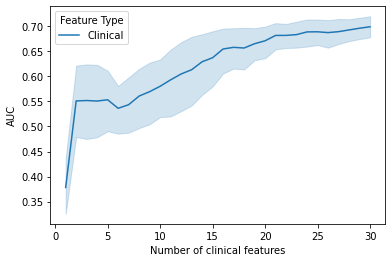

In [132]:
from sklearn.model_selection import StratifiedKFold
perf_data = plot_features_vs_performance_curve_with_kfold(X[~df.Target.Metadata_Morbidity.str.lower().str.contains('suspected')], y[~df.Target.Metadata_Morbidity.str.lower().str.contains('suspected')], StratifiedKFold(n_splits=10, shuffle=True), 1, 30)

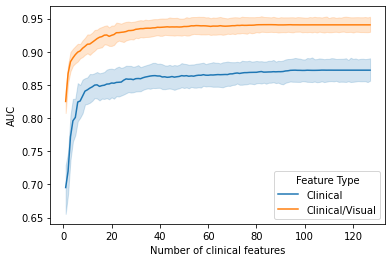

In [100]:
sns.lineplot(data=perf_data, x='Number of clinical features', y='AUC', hue='Feature Type')
plt.savefig('results/perf_for_k_feat.pdf')

In [61]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [62]:
from copy import deepcopy
class RandomLGBM(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator):
        self.base_estimator = base_estimator
    
    def fit(self, X, y):
#         self.base_estimator = deepcopy(self.base_estimator)
        boosting_type = np.random.choice(['gbdt', 'dart', 'goss'])
        min_data_in_leaf = np.random.randint(1, 160)
        self.base_estimator.set_params(n_estimators=np.random.randint(1, 20), 
                                       feature_fraction=np.random.uniform(low=0.03), max_depth=np.random.randint(-1, 30), 
                                       num_leaves=np.random.randint(2, 300), min_data_in_leaf=min_data_in_leaf, 
                                       boosting_type=boosting_type, 
                                       extra_trees=np.random.choice([False, True]), 
                                       max_bin=np.random.choice([15, 31, 63, 127, 255, 1023]), 
                                       linear_tree=np.random.choice([False, True]), 
                                       learning_rate=10**np.random.uniform(-8, -0.5), 
                                       lambda_l1=10**np.random.uniform(-20, 2), 
                                       lambda_l2=10**np.random.uniform(-20, 2), 
                                       min_gain_to_split=10**np.random.uniform(-20, 2))
#         if boosting_type != 'goss':
#             self.base_estimator.set_params(bagging_freq=np.random.randint(1, 20), bagging_fraction=np.random.rand()*0.98+0.01)
        if min_data_in_leaf >= 2:
            self.base_estimator.set_params(path_smooth=10**np.random.uniform(-20, 2))
        self.base_estimator.fit(X, y)
        self.classes_ = self.base_estimator.classes_
        return self
    
    def predict(self, X, y):
        return self.base_estimator.predict(X)
    
    def predict_proba(self, X):
        return self.base_estimator.predict_proba(X)

In [194]:
from copy import deepcopy
class RandomLGBMParam(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator, n_estimators_min=1, n_estimators_max=20, feature_fraction_min=0.03, 
                 feature_fraction_max=1.0, max_depth_min=-1, max_depth_max=30, use_extra_trees=True, max_bin_min=15, 
                 max_bin_max=1023, learning_rate_min=-8, learning_rate_max=-0.5, lambda_l1_min=-20, lambda_l1_max=2, 
                 lambda_l2_min=-20, lambda_l2_max=2, min_gain_to_split_min=-20, min_gain_to_split_max=2, 
                 min_data_in_leaf_min=1, min_data_in_leaf_max=160, num_leaves_min=2, num_leaves_max=300, use_linear_trees=True):
        self.base_estimator = base_estimator
        self._set('n_estimators', n_estimators_min, n_estimators_max)
        self._set('feature_fraction', feature_fraction_min, feature_fraction_max)
        self._set('max_depth', max_depth_min, max_depth_max)
        self.use_extra_trees = use_extra_trees
        self._set('max_bin', max_bin_min, max_bin_max)
        self._set('learning_rate', learning_rate_min, learning_rate_max)
        self._set('lambda_l1', lambda_l1_min, lambda_l1_max)
        self._set('lambda_l2', lambda_l2_min, lambda_l2_max)
        self._set('min_gain_to_split', min_gain_to_split_min, min_gain_to_split_max)
        self._set('min_data_in_leaf', min_data_in_leaf_min, min_data_in_leaf_max)
        self._set('num_leaves', num_leaves_min, num_leaves_max)
        self.use_linear_trees = use_linear_trees
        
    def _set(self, name, param_min, param_max):
        setattr(self, name+'_min', param_min)
        setattr(self, name+'_max', param_max)
        if isinstance(param_max, int):
            setattr(self, name+'_max2', max(param_min, param_max)+1)
        else:
            setattr(self, name+'_max2', max(param_min, param_max)+0.0000001)
        assert max(param_min, param_max) >= param_min
        
    
    def fit(self, X, y):
#         self.base_estimator = deepcopy(self.base_estimator)
        boosting_type = np.random.choice(['gbdt', 'dart', 'goss'])
        min_data_in_leaf = np.random.randint(self.min_data_in_leaf_min, self.min_data_in_leaf_max2)
        self.base_estimator.set_params(n_estimators=np.random.randint(self.n_estimators_min, self.n_estimators_max2), 
                                       feature_fraction=np.random.uniform(low=self.feature_fraction_min, 
                                                                          high=self.feature_fraction_max2), 
                                       max_depth=np.random.randint(self.max_depth_min, self.max_depth_max2), 
                                       num_leaves=np.random.randint(self.num_leaves_min, self.num_leaves_max2), 
                                       min_data_in_leaf=min_data_in_leaf, 
                                       boosting_type=boosting_type, 
                                       extra_trees=np.random.choice([False, True] if self.use_extra_trees else [False]), 
                                       max_bin=np.random.randint(self.max_bin_min, self.max_bin_max2), 
                                       linear_tree=np.random.choice([False, True] if self.use_linear_trees else [False]), 
                                       learning_rate=10**np.random.uniform(self.learning_rate_min, self.learning_rate_max2), 
                                       lambda_l1=10**np.random.uniform(self.lambda_l1_min, self.lambda_l2_max2), 
                                       lambda_l2=10**np.random.uniform(self.lambda_l2_min, self.lambda_l2_max2), 
                                       min_gain_to_split=10**np.random.uniform(self.min_gain_to_split_min, self.min_gain_to_split_max2))
#         if min_data_in_leaf >= 2:
#             self.base_estimator.set_params(path_smooth=10**np.random.uniform(-20, 2))
        self.base_estimator.fit(X, y)
        self.classes_ = self.base_estimator.classes_
        return self
    
    def predict(self, X, y):
        return self.base_estimator.predict(X)
    
    def predict_proba(self, X):
        return self.base_estimator.predict_proba(X)

In [170]:
from optuna.integration.sklearn import OptunaSearchCV
from optuna.distributions import UniformDistribution, IntUniformDistribution, CategoricalDistribution
default_random_lgbm = RandomLGBMParam(LGBMClassifier())
params = {x: getattr(default_random_lgbm, x) for x in default_random_lgbm.get_params() if not x.startswith('base_estimator')}
# for param in params:
#     x = getattr(default_random_lgbm, param)
print('{'+',\n\t'.join(f'"{k}": CategoricalDistribution([{v}])' if isinstance(v, bool) 
 else (f'"{k}": IntUniformDistribution({v}, {v})' if isinstance(v, int) else f'"{k}": UniformDistribution({v}, {v})') for k, v in params.items()))

{"feature_fraction_max": UniformDistribution(1.0, 1.0),
	"feature_fraction_min": UniformDistribution(0.03, 0.03),
	"lambda_l1_max": IntUniformDistribution(2, 2),
	"lambda_l1_min": IntUniformDistribution(-20, -20),
	"lambda_l2_max": IntUniformDistribution(2, 2),
	"lambda_l2_min": IntUniformDistribution(-20, -20),
	"learning_rate_max": UniformDistribution(-0.5, -0.5),
	"learning_rate_min": IntUniformDistribution(-8, -8),
	"max_bin_max": IntUniformDistribution(1023, 1023),
	"max_bin_min": IntUniformDistribution(15, 15),
	"max_depth_max": IntUniformDistribution(30, 30),
	"max_depth_min": IntUniformDistribution(-1, -1),
	"min_data_in_leaf_max": IntUniformDistribution(160, 160),
	"min_data_in_leaf_min": IntUniformDistribution(1, 1),
	"min_gain_to_split_max": IntUniformDistribution(2, 2),
	"min_gain_to_split_min": IntUniformDistribution(-20, -20),
	"n_estimators_max": IntUniformDistribution(20, 20),
	"n_estimators_min": IntUniformDistribution(1, 1),
	"num_leaves_max": IntUniformDistribution(3

In [198]:
dist = {"feature_fraction_max": UniformDistribution(0.3, 1.0),
	"feature_fraction_min": UniformDistribution(0.03, 0.7),
	"lambda_l1_max": UniformDistribution(1, 3),
	"lambda_l1_min": UniformDistribution(-28, -4),
	"lambda_l2_max": UniformDistribution(1, 3),
	"lambda_l2_min": UniformDistribution(-28, -4),
	"learning_rate_max": UniformDistribution(-3, 0),
	"learning_rate_min": UniformDistribution(-20, -3),
	"max_bin_max": IntUniformDistribution(150, 1023),
	"max_bin_min": IntUniformDistribution(3, 255),
	"max_depth_max": IntUniformDistribution(7, 60),
	"max_depth_min": IntUniformDistribution(-1, 10),
	"min_data_in_leaf_max": IntUniformDistribution(10, 300),
	"min_data_in_leaf_min": IntUniformDistribution(1, 50),
	"min_gain_to_split_max": IntUniformDistribution(-1, 2),
	"min_gain_to_split_min": IntUniformDistribution(-30, -1),
	"n_estimators_max": IntUniformDistribution(30, 1000),
	"n_estimators_min": IntUniformDistribution(1, 600),
	"num_leaves_max": IntUniformDistribution(7, 400),
	"num_leaves_min": IntUniformDistribution(2, 100),
	"use_extra_trees": CategoricalDistribution([False, True]),
	"use_linear_trees": CategoricalDistribution([False, True])}
dist = {'base_estimator__'+k: v for k, v in dist.items()}
dist.update({
    'max_samples': UniformDistribution(0.01, 1.0), 
    'max_features': UniformDistribution(0.01, 1.0), 
    'bootstrap': CategoricalDistribution([False, True]), 
    'bootstrap_features': CategoricalDistribution([False, True])
})

In [218]:
from optuna import create_study
from optuna.samplers import TPESampler
study = create_study(sampler=TPESampler(multivariate=True), direction='maximize')
optcv = OptunaSearchCV(BaggingClassifier(RandomLGBMParam(LGBMClassifier(n_jobs=-1)), 120, max_samples=1.0, bootstrap_features=True), dist, n_trials=10, study=study, scoring='roc_auc', cv=4).fit(X[df.Meta.cohort == 'c1'], y[df.Meta.cohort == 'c1'])

``multivariate`` option is an experimental feature. The interface can change in the future.
[I 2021-08-14 21:34:35,126] A new study created in memory with name: no-name-427ad94e-b36b-4df7-a765-5cb2bbe98264
OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error


[LightGBM] [Warning] feature_fraction is set=0.5303876397520456, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5303876397520456
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_gain_to_split is set=0.7476354540712333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7476354540712333
[LightGBM] [Warning] lambda_l1 is set=73.36702247770664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=73.36702247770664
[LightGBM] [Warning] lambda_l2 is set=7.328665491784417e-15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.328665491784417e-15
[LightGBM] [Warning] feature_fraction is set=0.5746188084189355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5746188084189355
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] mi

[I 2021-08-14 21:34:43,138] Trial 0 finished with value: 0.5712347633534074 and parameters: {'base_estimator__feature_fraction_max': 0.7195404446458278, 'base_estimator__feature_fraction_min': 0.279202450196542, 'base_estimator__lambda_l1_max': 1.2509098017368094, 'base_estimator__lambda_l1_min': -4.078532537925035, 'base_estimator__lambda_l2_max': 2.947420658704648, 'base_estimator__lambda_l2_min': -16.64066727784525, 'base_estimator__learning_rate_max': -1.005867489445849, 'base_estimator__learning_rate_min': -10.897056126122838, 'base_estimator__max_bin_max': 931, 'base_estimator__max_bin_min': 209, 'base_estimator__max_depth_max': 33, 'base_estimator__max_depth_min': 3, 'base_estimator__min_data_in_leaf_max': 157, 'base_estimator__min_data_in_leaf_min': 41, 'base_estimator__min_gain_to_split_max': 1, 'base_estimator__min_gain_to_split_min': -14, 'base_estimator__n_estimators_max': 553, 'base_estimator__n_estimators_min': 262, 'base_estimator__num_leaves_max': 59, 'base_estimator__n

[LightGBM] [Warning] feature_fraction is set=0.6137783047882515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6137783047882515
[LightGBM] [Warning] min_data_in_leaf is set=218, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=218
[LightGBM] [Warning] min_gain_to_split is set=0.42941078327422066, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.42941078327422066
[LightGBM] [Warning] lambda_l1 is set=0.00014056321467490764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014056321467490764
[LightGBM] [Warning] lambda_l2 is set=0.009397208691702538, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009397208691702538
[LightGBM] [Warning] feature_fraction is set=0.8661792629726204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8661792629726204
[LightGBM] [Warning] min_data_in_leaf is set=215, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=215
[LightGBM

[I 2021-08-14 21:34:49,668] Trial 1 finished with value: 0.5 and parameters: {'base_estimator__feature_fraction_max': 0.971326771891275, 'base_estimator__feature_fraction_min': 0.20995426890318758, 'base_estimator__lambda_l1_max': 2.429715512961092, 'base_estimator__lambda_l1_min': -4.094425418486306, 'base_estimator__lambda_l2_max': 1.5429056950610511, 'base_estimator__lambda_l2_min': -9.783218278394305, 'base_estimator__learning_rate_max': -0.45291984967617305, 'base_estimator__learning_rate_min': -17.71730889488577, 'base_estimator__max_bin_max': 618, 'base_estimator__max_bin_min': 61, 'base_estimator__max_depth_max': 53, 'base_estimator__max_depth_min': 1, 'base_estimator__min_data_in_leaf_max': 235, 'base_estimator__min_data_in_leaf_min': 41, 'base_estimator__min_gain_to_split_max': 0, 'base_estimator__min_gain_to_split_min': -5, 'base_estimator__n_estimators_max': 941, 'base_estimator__n_estimators_min': 519, 'base_estimator__num_leaves_max': 202, 'base_estimator__num_leaves_min'

[LightGBM] [Warning] feature_fraction is set=0.6201372566451894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6201372566451894
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_gain_to_split is set=3.564057243608393e-18, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.564057243608393e-18
[LightGBM] [Warning] lambda_l1 is set=4.5589985604871646e-10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5589985604871646e-10
[LightGBM] [Warning] lambda_l2 is set=0.0017893573861921753, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017893573861921753
[LightGBM] [Warning] feature_fraction is set=0.14841615736072608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14841615736072608
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[Ligh

[I 2021-08-14 21:34:57,156] Trial 2 finished with value: 0.5278584880279795 and parameters: {'base_estimator__feature_fraction_max': 0.6310001901107796, 'base_estimator__feature_fraction_min': 0.1404115561859335, 'base_estimator__lambda_l1_max': 2.829953372304034, 'base_estimator__lambda_l1_min': -12.549177887981106, 'base_estimator__lambda_l2_max': 1.416606662040726, 'base_estimator__lambda_l2_min': -22.94860841124246, 'base_estimator__learning_rate_max': -0.3808774704269702, 'base_estimator__learning_rate_min': -3.988702471489866, 'base_estimator__max_bin_max': 240, 'base_estimator__max_bin_min': 175, 'base_estimator__max_depth_max': 21, 'base_estimator__max_depth_min': 7, 'base_estimator__min_data_in_leaf_max': 246, 'base_estimator__min_data_in_leaf_min': 1, 'base_estimator__min_gain_to_split_max': 2, 'base_estimator__min_gain_to_split_min': -27, 'base_estimator__n_estimators_max': 489, 'base_estimator__n_estimators_min': 532, 'base_estimator__num_leaves_max': 315, 'base_estimator__

[LightGBM] [Warning] feature_fraction is set=0.5625811461985617, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5625811461985617
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_gain_to_split is set=4.3632296125149343e-16, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.3632296125149343e-16
[LightGBM] [Warning] lambda_l1 is set=0.0001901974466256267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001901974466256267
[LightGBM] [Warning] lambda_l2 is set=0.06537033192794807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06537033192794807
[LightGBM] [Warning] feature_fraction is set=0.8023029555525081, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8023029555525081
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] 

[I 2021-08-14 21:38:32,762] Trial 3 finished with value: 0.7080914095320875 and parameters: {'base_estimator__feature_fraction_max': 0.8873165509332284, 'base_estimator__feature_fraction_min': 0.48743925002293575, 'base_estimator__lambda_l1_max': 2.1865001395308132, 'base_estimator__lambda_l1_min': -14.570183181941765, 'base_estimator__lambda_l2_max': 2.2415297360371103, 'base_estimator__lambda_l2_min': -4.870235923199452, 'base_estimator__learning_rate_max': -2.353113863801333, 'base_estimator__learning_rate_min': -8.627341604719614, 'base_estimator__max_bin_max': 515, 'base_estimator__max_bin_min': 178, 'base_estimator__max_depth_max': 10, 'base_estimator__max_depth_min': 1, 'base_estimator__min_data_in_leaf_max': 32, 'base_estimator__min_data_in_leaf_min': 12, 'base_estimator__min_gain_to_split_max': 0, 'base_estimator__min_gain_to_split_min': -25, 'base_estimator__n_estimators_max': 406, 'base_estimator__n_estimators_min': 423, 'base_estimator__num_leaves_max': 141, 'base_estimator

[LightGBM] [Warning] feature_fraction is set=0.6610622236005181, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6610622236005181
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] min_gain_to_split is set=0.00030929359976973684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00030929359976973684
[LightGBM] [Warning] lambda_l1 is set=3.7730650433143415e-21, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7730650433143415e-21
[LightGBM] [Warning] lambda_l2 is set=1.2773879680636295e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2773879680636295e-09
[LightGBM] [Warning] feature_fraction is set=0.6610622313985185, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6610622313985185
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[Li

[I 2021-08-14 21:39:52,525] Trial 4 finished with value: 0.6177126922042177 and parameters: {'base_estimator__feature_fraction_max': 0.6490495182265903, 'base_estimator__feature_fraction_min': 0.6610621875168284, 'base_estimator__lambda_l1_max': 2.454810085710067, 'base_estimator__lambda_l1_min': -26.39064365176366, 'base_estimator__lambda_l2_max': 2.4208592809340526, 'base_estimator__lambda_l2_min': -14.015806571566419, 'base_estimator__learning_rate_max': -2.0244883392015227, 'base_estimator__learning_rate_min': -18.985205551468372, 'base_estimator__max_bin_max': 198, 'base_estimator__max_bin_min': 209, 'base_estimator__max_depth_max': 8, 'base_estimator__max_depth_min': 2, 'base_estimator__min_data_in_leaf_max': 114, 'base_estimator__min_data_in_leaf_min': 24, 'base_estimator__min_gain_to_split_max': 0, 'base_estimator__min_gain_to_split_min': -18, 'base_estimator__n_estimators_max': 829, 'base_estimator__n_estimators_min': 395, 'base_estimator__num_leaves_max': 182, 'base_estimator

[LightGBM] [Warning] feature_fraction is set=0.5271507258956537, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5271507258956537
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_gain_to_split is set=2.1861385691891614e-08, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1861385691891614e-08
[LightGBM] [Warning] lambda_l1 is set=5.231524517066635e-13, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.231524517066635e-13
[LightGBM] [Warning] lambda_l2 is set=2.0150324263860983e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0150324263860983e-07
[LightGBM] [Warning] feature_fraction is set=0.328509531827097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.328509531827097
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightG

[I 2021-08-14 21:40:33,073] Trial 5 finished with value: 0.6875007760600982 and parameters: {'base_estimator__feature_fraction_max': 0.9965350413915379, 'base_estimator__feature_fraction_min': 0.2893036872527197, 'base_estimator__lambda_l1_max': 2.724683416553923, 'base_estimator__lambda_l1_min': -15.530255170108825, 'base_estimator__lambda_l2_max': 2.0231145633410232, 'base_estimator__lambda_l2_min': -18.74977850962326, 'base_estimator__learning_rate_max': -0.8938892743555535, 'base_estimator__learning_rate_min': -3.3624676798582414, 'base_estimator__max_bin_max': 456, 'base_estimator__max_bin_min': 108, 'base_estimator__max_depth_max': 43, 'base_estimator__max_depth_min': 6, 'base_estimator__min_data_in_leaf_max': 87, 'base_estimator__min_data_in_leaf_min': 43, 'base_estimator__min_gain_to_split_max': 0, 'base_estimator__min_gain_to_split_min': -22, 'base_estimator__n_estimators_max': 767, 'base_estimator__n_estimators_min': 39, 'base_estimator__num_leaves_max': 236, 'base_estimator_

[LightGBM] [Warning] feature_fraction is set=0.6808606471816078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6808606471816078
[LightGBM] [Warning] min_data_in_leaf is set=159, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=159
[LightGBM] [Warning] min_gain_to_split is set=0.06046330370443943, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06046330370443943
[LightGBM] [Warning] lambda_l1 is set=2.4797119301876686e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4797119301876686e-07
[LightGBM] [Warning] lambda_l2 is set=5.066402549172607e-13, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.066402549172607e-13
[LightGBM] [Warning] feature_fraction is set=0.796960296399044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.796960296399044
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] 

[I 2021-08-14 21:41:39,965] Trial 6 finished with value: 0.690694211626415 and parameters: {'base_estimator__feature_fraction_max': 0.8936878008931757, 'base_estimator__feature_fraction_min': 0.4625944772779459, 'base_estimator__lambda_l1_max': 2.4681006182165706, 'base_estimator__lambda_l1_min': -16.11729569053274, 'base_estimator__lambda_l2_max': 2.549308316243404, 'base_estimator__lambda_l2_min': -12.68344280894819, 'base_estimator__learning_rate_max': -2.6445514893494204, 'base_estimator__learning_rate_min': -15.882226793160829, 'base_estimator__max_bin_max': 588, 'base_estimator__max_bin_min': 103, 'base_estimator__max_depth_max': 55, 'base_estimator__max_depth_min': 5, 'base_estimator__min_data_in_leaf_max': 225, 'base_estimator__min_data_in_leaf_min': 8, 'base_estimator__min_gain_to_split_max': -1, 'base_estimator__min_gain_to_split_min': -2, 'base_estimator__n_estimators_max': 522, 'base_estimator__n_estimators_min': 312, 'base_estimator__num_leaves_max': 386, 'base_estimator__

[LightGBM] [Warning] feature_fraction is set=0.5914193184713542, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5914193184713542
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] min_gain_to_split is set=0.027843909390773032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.027843909390773032
[LightGBM] [Warning] lambda_l1 is set=6.678313912037359e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.678313912037359e-09
[LightGBM] [Warning] lambda_l2 is set=7.848778275130333e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.848778275130333e-06
[LightGBM] [Warning] feature_fraction is set=0.6887880976159066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6887880976159066
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] 

[I 2021-08-14 21:42:26,999] Trial 7 finished with value: 0.6671878686285466 and parameters: {'base_estimator__feature_fraction_max': 0.7180079094432661, 'base_estimator__feature_fraction_min': 0.4083431550937575, 'base_estimator__lambda_l1_max': 1.727189935114064, 'base_estimator__lambda_l1_min': -10.056913836639115, 'base_estimator__lambda_l2_max': 2.479920581657316, 'base_estimator__lambda_l2_min': -26.063184962719752, 'base_estimator__learning_rate_max': -2.688869491231887, 'base_estimator__learning_rate_min': -17.343534712237176, 'base_estimator__max_bin_max': 773, 'base_estimator__max_bin_min': 41, 'base_estimator__max_depth_max': 40, 'base_estimator__max_depth_min': 8, 'base_estimator__min_data_in_leaf_max': 298, 'base_estimator__min_data_in_leaf_min': 14, 'base_estimator__min_gain_to_split_max': 1, 'base_estimator__min_gain_to_split_min': -20, 'base_estimator__n_estimators_max': 719, 'base_estimator__n_estimators_min': 382, 'base_estimator__num_leaves_max': 26, 'base_estimator__

[LightGBM] [Warning] feature_fraction is set=0.7589747496857083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7589747496857083
[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] min_gain_to_split is set=0.26954045741320226, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26954045741320226
[LightGBM] [Warning] lambda_l1 is set=0.11265324579571839, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11265324579571839
[LightGBM] [Warning] lambda_l2 is set=1.215127237246917e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.215127237246917e-05
[LightGBM] [Warning] feature_fraction is set=0.6163543195681955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6163543195681955
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [War

[I 2021-08-14 21:42:30,731] Trial 8 finished with value: 0.5793130833385072 and parameters: {'base_estimator__feature_fraction_max': 0.781631471125176, 'base_estimator__feature_fraction_min': 0.23151680368590252, 'base_estimator__lambda_l1_max': 2.676711219173567, 'base_estimator__lambda_l1_min': -12.70380252535136, 'base_estimator__lambda_l2_max': 2.6827152622490855, 'base_estimator__lambda_l2_min': -6.987544769635967, 'base_estimator__learning_rate_max': -1.7913688211268481, 'base_estimator__learning_rate_min': -13.60070785012458, 'base_estimator__max_bin_max': 764, 'base_estimator__max_bin_min': 142, 'base_estimator__max_depth_max': 24, 'base_estimator__max_depth_min': 2, 'base_estimator__min_data_in_leaf_max': 297, 'base_estimator__min_data_in_leaf_min': 49, 'base_estimator__min_gain_to_split_max': 0, 'base_estimator__min_gain_to_split_min': -3, 'base_estimator__n_estimators_max': 273, 'base_estimator__n_estimators_min': 122, 'base_estimator__num_leaves_max': 356, 'base_estimator__

[LightGBM] [Warning] feature_fraction is set=0.592492294241927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.592492294241927
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_gain_to_split is set=1.6670849953849625e-14, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6670849953849625e-14
[LightGBM] [Warning] lambda_l1 is set=4.476273619696397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.476273619696397
[LightGBM] [Warning] lambda_l2 is set=1.0007534360007957e-13, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0007534360007957e-13
[LightGBM] [Warning] feature_fraction is set=0.5344753729998528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5344753729998528
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [War

[I 2021-08-14 21:43:12,602] Trial 9 finished with value: 0.6357970654580823 and parameters: {'base_estimator__feature_fraction_max': 0.6017362220742808, 'base_estimator__feature_fraction_min': 0.2898811798378127, 'base_estimator__lambda_l1_max': 2.764818305147851, 'base_estimator__lambda_l1_min': -5.372399484244301, 'base_estimator__lambda_l2_max': 1.7724426834972664, 'base_estimator__lambda_l2_min': -14.097649486536774, 'base_estimator__learning_rate_max': -2.349692024552476, 'base_estimator__learning_rate_min': -18.411716151579316, 'base_estimator__max_bin_max': 742, 'base_estimator__max_bin_min': 194, 'base_estimator__max_depth_max': 35, 'base_estimator__max_depth_min': 4, 'base_estimator__min_data_in_leaf_max': 215, 'base_estimator__min_data_in_leaf_min': 32, 'base_estimator__min_gain_to_split_max': 2, 'base_estimator__min_gain_to_split_min': -25, 'base_estimator__n_estimators_max': 601, 'base_estimator__n_estimators_min': 388, 'base_estimator__num_leaves_max': 128, 'base_estimator

[LightGBM] [Warning] feature_fraction is set=0.5490584054623605, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5490584054623605
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_gain_to_split is set=2.4555790148356177e-08, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4555790148356177e-08
[LightGBM] [Warning] lambda_l1 is set=6.590996575092274e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.590996575092274e-08
[LightGBM] [Warning] lambda_l2 is set=0.05854991071280589, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05854991071280589


In [224]:
optcv.n_trials = 20

In [225]:

optcv.fit(X[df.Meta.cohort == 'c1'], y[df.Meta.cohort == 'c1'])

Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error


[LightGBM] [Warning] feature_fraction is set=0.7414394501021994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7414394501021994
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_gain_to_split is set=0.0013609052436294722, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0013609052436294722
[LightGBM] [Warning] lambda_l1 is set=3.2218480354899094e-20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2218480354899094e-20
[LightGBM] [Warning] lambda_l2 is set=7.458651178836537e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.458651178836537e-07
[LightGBM] [Warning] feature_fraction is set=0.6779408841040478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6779408841040478
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM

[I 2021-08-14 23:22:31,511] Trial 50 finished with value: 0.7301106144326484 and parameters: {'base_estimator__feature_fraction_max': 0.7700046188928504, 'base_estimator__feature_fraction_min': 0.5752754555795049, 'base_estimator__lambda_l1_max': 2.5311680289523935, 'base_estimator__lambda_l1_min': -23.84344600807626, 'base_estimator__lambda_l2_max': 1.576764333872211, 'base_estimator__lambda_l2_min': -6.671513418983685, 'base_estimator__learning_rate_max': -2.97368774223811, 'base_estimator__learning_rate_min': -4.78425024877696, 'base_estimator__max_bin_max': 548, 'base_estimator__max_bin_min': 223, 'base_estimator__max_depth_max': 51, 'base_estimator__max_depth_min': 0, 'base_estimator__min_data_in_leaf_max': 62, 'base_estimator__min_data_in_leaf_min': 1, 'base_estimator__min_gain_to_split_max': -1, 'base_estimator__min_gain_to_split_min': -13, 'base_estimator__n_estimators_max': 791, 'base_estimator__n_estimators_min': 342, 'base_estimator__num_leaves_max': 209, 'base_estimator__nu

[LightGBM] [Warning] feature_fraction is set=0.373749521058132, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.373749521058132
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.0007531779306393218, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007531779306393218
[LightGBM] [Warning] lambda_l1 is set=1.8565480361800508e-20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8565480361800508e-20
[LightGBM] [Warning] lambda_l2 is set=0.0012598425448570112, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012598425448570112
[LightGBM] [Warning] feature_fraction is set=0.36174067382186226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36174067382186226
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM

[I 2021-08-14 23:25:19,434] Trial 51 finished with value: 0.7035053082510709 and parameters: {'base_estimator__feature_fraction_max': 0.4864615309194687, 'base_estimator__feature_fraction_min': 0.3411572220052196, 'base_estimator__lambda_l1_max': 2.523209711417727, 'base_estimator__lambda_l1_min': -20.489408322346335, 'base_estimator__lambda_l2_max': 1.8214729865526436, 'base_estimator__lambda_l2_min': -5.022456702707082, 'base_estimator__learning_rate_max': -2.6909078022577466, 'base_estimator__learning_rate_min': -8.59178664611754, 'base_estimator__max_bin_max': 552, 'base_estimator__max_bin_min': 246, 'base_estimator__max_depth_max': 57, 'base_estimator__max_depth_min': 0, 'base_estimator__min_data_in_leaf_max': 103, 'base_estimator__min_data_in_leaf_min': 2, 'base_estimator__min_gain_to_split_max': 0, 'base_estimator__min_gain_to_split_min': -8, 'base_estimator__n_estimators_max': 756, 'base_estimator__n_estimators_min': 400, 'base_estimator__num_leaves_max': 233, 'base_estimator__

[LightGBM] [Warning] feature_fraction is set=0.7269388278360452, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7269388278360452
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_gain_to_split is set=0.0035623013248308236, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0035623013248308236
[LightGBM] [Warning] lambda_l1 is set=1.3279080701554686e-19, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3279080701554686e-19
[LightGBM] [Warning] lambda_l2 is set=8.432324676721417e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.432324676721417e-10
[LightGBM] [Warning] feature_fraction is set=0.7254047401138579, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7254047401138579
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightG

[I 2021-08-14 23:27:33,029] Trial 52 finished with value: 0.7222733387140166 and parameters: {'base_estimator__feature_fraction_max': 0.820109211696524, 'base_estimator__feature_fraction_min': 0.5279185963497873, 'base_estimator__lambda_l1_max': 2.0747605989196978, 'base_estimator__lambda_l1_min': -23.145246999880236, 'base_estimator__lambda_l2_max': 1.111698319105221, 'base_estimator__lambda_l2_min': -11.934493587380986, 'base_estimator__learning_rate_max': -2.573535100617397, 'base_estimator__learning_rate_min': -7.2263252743455535, 'base_estimator__max_bin_max': 253, 'base_estimator__max_bin_min': 150, 'base_estimator__max_depth_max': 25, 'base_estimator__max_depth_min': -1, 'base_estimator__min_data_in_leaf_max': 47, 'base_estimator__min_data_in_leaf_min': 24, 'base_estimator__min_gain_to_split_max': -1, 'base_estimator__min_gain_to_split_min': -8, 'base_estimator__n_estimators_max': 508, 'base_estimator__n_estimators_min': 407, 'base_estimator__num_leaves_max': 103, 'base_estimato

[LightGBM] [Warning] feature_fraction is set=0.7685023856524413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7685023856524413
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_gain_to_split is set=2.4263263456069485e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4263263456069485e-05
[LightGBM] [Warning] lambda_l1 is set=4.364004455804363e-22, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.364004455804363e-22
[LightGBM] [Warning] lambda_l2 is set=5.048197187842123e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.048197187842123e-05
[LightGBM] [Warning] feature_fraction is set=0.6803107385464622, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6803107385464622
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightG

[I 2021-08-14 23:29:49,073] Trial 53 finished with value: 0.7086874236874237 and parameters: {'base_estimator__feature_fraction_max': 0.8128640138306004, 'base_estimator__feature_fraction_min': 0.49504905777075475, 'base_estimator__lambda_l1_max': 1.4802698307721545, 'base_estimator__lambda_l1_min': -23.466054630555053, 'base_estimator__lambda_l2_max': 1.0551093844138688, 'base_estimator__lambda_l2_min': -17.608993969459775, 'base_estimator__learning_rate_max': -2.593515471139885, 'base_estimator__learning_rate_min': -8.215599808524193, 'base_estimator__max_bin_max': 452, 'base_estimator__max_bin_min': 56, 'base_estimator__max_depth_max': 43, 'base_estimator__max_depth_min': 0, 'base_estimator__min_data_in_leaf_max': 60, 'base_estimator__min_data_in_leaf_min': 34, 'base_estimator__min_gain_to_split_max': -1, 'base_estimator__min_gain_to_split_min': -7, 'base_estimator__n_estimators_max': 592, 'base_estimator__n_estimators_min': 478, 'base_estimator__num_leaves_max': 54, 'base_estimator

[LightGBM] [Warning] feature_fraction is set=0.76104121811338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.76104121811338
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_gain_to_split is set=0.09245499159067211, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09245499159067211
[LightGBM] [Warning] lambda_l1 is set=2.6631934976830376e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6631934976830376e-08
[LightGBM] [Warning] lambda_l2 is set=2.260758067216584e-11, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.260758067216584e-11
[LightGBM] [Warning] feature_fraction is set=0.6823312018177303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6823312018177303
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [War

[I 2021-08-14 23:32:20,018] Trial 54 finished with value: 0.6999891351586266 and parameters: {'base_estimator__feature_fraction_max': 0.8381139939369296, 'base_estimator__feature_fraction_min': 0.5310218737212548, 'base_estimator__lambda_l1_max': 1.9162268365370225, 'base_estimator__lambda_l1_min': -21.129141703387536, 'base_estimator__lambda_l2_max': 1.3359447285228805, 'base_estimator__lambda_l2_min': -11.314716938385496, 'base_estimator__learning_rate_max': -1.5981565564942999, 'base_estimator__learning_rate_min': -10.121203689077293, 'base_estimator__max_bin_max': 334, 'base_estimator__max_bin_min': 152, 'base_estimator__max_depth_max': 18, 'base_estimator__max_depth_min': 2, 'base_estimator__min_data_in_leaf_max': 58, 'base_estimator__min_data_in_leaf_min': 18, 'base_estimator__min_gain_to_split_max': -1, 'base_estimator__min_gain_to_split_min': -6, 'base_estimator__n_estimators_max': 754, 'base_estimator__n_estimators_min': 415, 'base_estimator__num_leaves_max': 117, 'base_estima

[LightGBM] [Warning] feature_fraction is set=0.8047447171122192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8047447171122192
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_gain_to_split is set=4.547280699214357e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.547280699214357e-05
[LightGBM] [Warning] lambda_l1 is set=1.3563263113172868e-18, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3563263113172868e-18
[LightGBM] [Warning] lambda_l2 is set=2.6090316780412823e-17, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6090316780412823e-17
[LightGBM] [Warning] feature_fraction is set=0.9733822763409792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9733822763409792
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[Ligh

[I 2021-08-14 23:33:42,397] Trial 55 finished with value: 0.7128722501603857 and parameters: {'base_estimator__feature_fraction_max': 0.9940732216094278, 'base_estimator__feature_fraction_min': 0.4319965596549076, 'base_estimator__lambda_l1_max': 2.435676680515235, 'base_estimator__lambda_l1_min': -20.76027069422553, 'base_estimator__lambda_l2_max': 1.5934355642724591, 'base_estimator__lambda_l2_min': -19.43184135193496, 'base_estimator__learning_rate_max': -2.6746636700149393, 'base_estimator__learning_rate_min': -5.105263555434169, 'base_estimator__max_bin_max': 338, 'base_estimator__max_bin_min': 184, 'base_estimator__max_depth_max': 50, 'base_estimator__max_depth_min': 3, 'base_estimator__min_data_in_leaf_max': 95, 'base_estimator__min_data_in_leaf_min': 26, 'base_estimator__min_gain_to_split_max': -1, 'base_estimator__min_gain_to_split_min': -6, 'base_estimator__n_estimators_max': 589, 'base_estimator__n_estimators_min': 552, 'base_estimator__num_leaves_max': 134, 'base_estimator_

[LightGBM] [Warning] feature_fraction is set=0.5886141336021739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5886141336021739
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_gain_to_split is set=3.8356154863296015e-09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8356154863296015e-09
[LightGBM] [Warning] lambda_l1 is set=1.2693155336033634e-24, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2693155336033634e-24
[LightGBM] [Warning] lambda_l2 is set=0.006491265040548995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006491265040548995
[LightGBM] [Warning] feature_fraction is set=0.6696220232459732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6696220232459732
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightG

[I 2021-08-14 23:58:23,073] Trial 56 finished with value: 0.7292191800666377 and parameters: {'base_estimator__feature_fraction_max': 0.9358428315605613, 'base_estimator__feature_fraction_min': 0.487286290578569, 'base_estimator__lambda_l1_max': 2.1914193382329232, 'base_estimator__lambda_l1_min': -25.389678298695156, 'base_estimator__lambda_l2_max': 1.4198175285561232, 'base_estimator__lambda_l2_min': -4.192264240430674, 'base_estimator__learning_rate_max': -2.8515735995212173, 'base_estimator__learning_rate_min': -4.277285455294864, 'base_estimator__max_bin_max': 551, 'base_estimator__max_bin_min': 181, 'base_estimator__max_depth_max': 57, 'base_estimator__max_depth_min': 0, 'base_estimator__min_data_in_leaf_max': 26, 'base_estimator__min_data_in_leaf_min': 1, 'base_estimator__min_gain_to_split_max': -1, 'base_estimator__min_gain_to_split_min': -10, 'base_estimator__n_estimators_max': 699, 'base_estimator__n_estimators_min': 329, 'base_estimator__num_leaves_max': 130, 'base_estimator

[LightGBM] [Warning] feature_fraction is set=0.5643743902475573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5643743902475573
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_gain_to_split is set=4.761496230919679e-06, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.761496230919679e-06
[LightGBM] [Warning] lambda_l1 is set=3.7874456792238893e-10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7874456792238893e-10
[LightGBM] [Warning] lambda_l2 is set=0.20242601883409583, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20242601883409583
[LightGBM] [Warning] feature_fraction is set=0.7770275069616739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7770275069616739
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] 

[I 2021-08-14 23:58:55,096] Trial 57 finished with value: 0.7176572297758739 and parameters: {'base_estimator__feature_fraction_max': 0.8924063428521457, 'base_estimator__feature_fraction_min': 0.46314479017326715, 'base_estimator__lambda_l1_max': 1.732194092944602, 'base_estimator__lambda_l1_min': -19.510068624642823, 'base_estimator__lambda_l2_max': 1.479452134741409, 'base_estimator__lambda_l2_min': -4.628056556165184, 'base_estimator__learning_rate_max': -2.3254343577062064, 'base_estimator__learning_rate_min': -5.105960483485743, 'base_estimator__max_bin_max': 717, 'base_estimator__max_bin_min': 186, 'base_estimator__max_depth_max': 54, 'base_estimator__max_depth_min': 1, 'base_estimator__min_data_in_leaf_max': 39, 'base_estimator__min_data_in_leaf_min': 4, 'base_estimator__min_gain_to_split_max': -1, 'base_estimator__min_gain_to_split_min': -15, 'base_estimator__n_estimators_max': 606, 'base_estimator__n_estimators_min': 198, 'base_estimator__num_leaves_max': 86, 'base_estimator_

[LightGBM] [Warning] feature_fraction is set=0.6398698885131663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6398698885131663
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_gain_to_split is set=2.2386306873790165e-12, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2386306873790165e-12
[LightGBM] [Warning] lambda_l1 is set=6.871096409124542e-15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.871096409124542e-15
[LightGBM] [Warning] lambda_l2 is set=1.1158126769225234e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1158126769225234e-05
[LightGBM] [Warning] feature_fraction is set=0.7207494496418165, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7207494496418165
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[Ligh

[I 2021-08-15 00:00:43,132] Trial 58 finished with value: 0.7213424804950228 and parameters: {'base_estimator__feature_fraction_max': 0.7586022164517026, 'base_estimator__feature_fraction_min': 0.6039244012539776, 'base_estimator__lambda_l1_max': 2.7143882825474024, 'base_estimator__lambda_l1_min': -23.396332970098513, 'base_estimator__lambda_l2_max': 1.0676583937501816, 'base_estimator__lambda_l2_min': -6.200293321421824, 'base_estimator__learning_rate_max': -2.885260928560548, 'base_estimator__learning_rate_min': -4.792883677890442, 'base_estimator__max_bin_max': 469, 'base_estimator__max_bin_min': 230, 'base_estimator__max_depth_max': 42, 'base_estimator__max_depth_min': 2, 'base_estimator__min_data_in_leaf_max': 28, 'base_estimator__min_data_in_leaf_min': 4, 'base_estimator__min_gain_to_split_max': -1, 'base_estimator__min_gain_to_split_min': -26, 'base_estimator__n_estimators_max': 583, 'base_estimator__n_estimators_min': 390, 'base_estimator__num_leaves_max': 311, 'base_estimator

[LightGBM] [Warning] feature_fraction is set=0.46075347676080436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46075347676080436
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_gain_to_split is set=1.3780164660110472e-08, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3780164660110472e-08
[LightGBM] [Warning] lambda_l1 is set=2.0849739291366553e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0849739291366553e-06
[LightGBM] [Warning] lambda_l2 is set=8.080825418716016e-11, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.080825418716016e-11
[LightGBM] [Warning] feature_fraction is set=0.6020894662594941, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6020894662594941
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[Li

[I 2021-08-15 00:05:04,200] Trial 59 finished with value: 0.7205746983713085 and parameters: {'base_estimator__feature_fraction_max': 0.8408284850597292, 'base_estimator__feature_fraction_min': 0.4012846219613845, 'base_estimator__lambda_l1_max': 2.6615138728885044, 'base_estimator__lambda_l1_min': -21.37932091668819, 'base_estimator__lambda_l2_max': 1.1492665054412619, 'base_estimator__lambda_l2_min': -13.251307973565856, 'base_estimator__learning_rate_max': -2.8425362468913224, 'base_estimator__learning_rate_min': -3.404217765248507, 'base_estimator__max_bin_max': 626, 'base_estimator__max_bin_min': 102, 'base_estimator__max_depth_max': 56, 'base_estimator__max_depth_min': 0, 'base_estimator__min_data_in_leaf_max': 17, 'base_estimator__min_data_in_leaf_min': 8, 'base_estimator__min_gain_to_split_max': -1, 'base_estimator__min_gain_to_split_min': -10, 'base_estimator__n_estimators_max': 830, 'base_estimator__n_estimators_min': 425, 'base_estimator__num_leaves_max': 236, 'base_estimato

[LightGBM] [Warning] feature_fraction is set=0.4671743151598937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4671743151598937
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] min_gain_to_split is set=5.7331546517334555e-06, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.7331546517334555e-06
[LightGBM] [Warning] lambda_l1 is set=1.4174764539063756e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4174764539063756e-07
[LightGBM] [Warning] lambda_l2 is set=0.020645900795453292, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.020645900795453292
[LightGBM] [Warning] feature_fraction is set=0.36586423204370006, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36586423204370006
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[Ligh

[I 2021-08-15 00:06:34,659] Trial 60 finished with value: 0.7238700564971752 and parameters: {'base_estimator__feature_fraction_max': 0.7884951781383331, 'base_estimator__feature_fraction_min': 0.3192011449774058, 'base_estimator__lambda_l1_max': 1.7185207752154024, 'base_estimator__lambda_l1_min': -25.33196326610328, 'base_estimator__lambda_l2_max': 1.722535622041243, 'base_estimator__lambda_l2_min': -9.25842761755005, 'base_estimator__learning_rate_max': -2.4167189908904474, 'base_estimator__learning_rate_min': -8.88184449988051, 'base_estimator__max_bin_max': 403, 'base_estimator__max_bin_min': 41, 'base_estimator__max_depth_max': 19, 'base_estimator__max_depth_min': 4, 'base_estimator__min_data_in_leaf_max': 104, 'base_estimator__min_data_in_leaf_min': 25, 'base_estimator__min_gain_to_split_max': -1, 'base_estimator__min_gain_to_split_min': -8, 'base_estimator__n_estimators_max': 396, 'base_estimator__n_estimators_min': 392, 'base_estimator__num_leaves_max': 66, 'base_estimator__nu

[LightGBM] [Warning] feature_fraction is set=0.7004209067069233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7004209067069233
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_gain_to_split is set=5.992181318264745, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.992181318264745
[LightGBM] [Warning] lambda_l1 is set=2.938540410035817e-10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.938540410035817e-10
[LightGBM] [Warning] lambda_l2 is set=0.0006834257555382014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006834257555382014
[LightGBM] [Warning] feature_fraction is set=0.7581485470138888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7581485470138888
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warni

[I 2021-08-15 00:08:59,562] Trial 61 finished with value: 0.7215362885701868 and parameters: {'base_estimator__feature_fraction_max': 0.883243669844811, 'base_estimator__feature_fraction_min': 0.4478434278968759, 'base_estimator__lambda_l1_max': 2.010174588671729, 'base_estimator__lambda_l1_min': -26.128130447746074, 'base_estimator__lambda_l2_max': 1.5019714921868044, 'base_estimator__lambda_l2_min': -4.481189306051328, 'base_estimator__learning_rate_max': -1.9816648899118436, 'base_estimator__learning_rate_min': -10.188518556903912, 'base_estimator__max_bin_max': 376, 'base_estimator__max_bin_min': 17, 'base_estimator__max_depth_max': 15, 'base_estimator__max_depth_min': 4, 'base_estimator__min_data_in_leaf_max': 61, 'base_estimator__min_data_in_leaf_min': 26, 'base_estimator__min_gain_to_split_max': 0, 'base_estimator__min_gain_to_split_min': -1, 'base_estimator__n_estimators_max': 623, 'base_estimator__n_estimators_min': 472, 'base_estimator__num_leaves_max': 157, 'base_estimator__

[LightGBM] [Warning] feature_fraction is set=0.25547508318330997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25547508318330997
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_gain_to_split is set=2.3000754373290887e-08, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3000754373290887e-08
[LightGBM] [Warning] lambda_l1 is set=4.748382123784582e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.748382123784582e-07
[LightGBM] [Warning] lambda_l2 is set=5.853119245108752e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.853119245108752e-06
[LightGBM] [Warning] feature_fraction is set=0.26508655304075524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26508655304075524
[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[

[I 2021-08-15 08:56:32,053] Trial 62 finished with value: 0.735581010326773 and parameters: {'base_estimator__feature_fraction_max': 0.8608408126199738, 'base_estimator__feature_fraction_min': 0.25148936270674654, 'base_estimator__lambda_l1_max': 1.2185556552113712, 'base_estimator__lambda_l1_min': -20.133113698376146, 'base_estimator__lambda_l2_max': 1.0697468560304952, 'base_estimator__lambda_l2_min': -6.531697133520995, 'base_estimator__learning_rate_max': -2.1074309454463602, 'base_estimator__learning_rate_min': -9.00316992287851, 'base_estimator__max_bin_max': 459, 'base_estimator__max_bin_min': 137, 'base_estimator__max_depth_max': 18, 'base_estimator__max_depth_min': 0, 'base_estimator__min_data_in_leaf_max': 151, 'base_estimator__min_data_in_leaf_min': 14, 'base_estimator__min_gain_to_split_max': -1, 'base_estimator__min_gain_to_split_min': -11, 'base_estimator__n_estimators_max': 653, 'base_estimator__n_estimators_min': 214, 'base_estimator__num_leaves_max': 300, 'base_estimat

[LightGBM] [Warning] feature_fraction is set=0.39566656780983905, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39566656780983905
[LightGBM] [Warning] min_data_in_leaf is set=118, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=118
[LightGBM] [Warning] min_gain_to_split is set=9.316807003694032e-17, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.316807003694032e-17
[LightGBM] [Warning] lambda_l1 is set=0.0003016560405981726, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003016560405981726
[LightGBM] [Warning] lambda_l2 is set=0.9166163540381899, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9166163540381899
[LightGBM] [Warning] feature_fraction is set=0.5438981274885037, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5438981274885037
[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM

[I 2021-08-15 08:57:36,022] Trial 63 finished with value: 0.7211113180604706 and parameters: {'base_estimator__feature_fraction_max': 0.9107719255104925, 'base_estimator__feature_fraction_min': 0.09069644131053128, 'base_estimator__lambda_l1_max': 1.4909030607562204, 'base_estimator__lambda_l1_min': -22.007497285303323, 'base_estimator__lambda_l2_max': 1.4639633735089135, 'base_estimator__lambda_l2_min': -6.23291428246282, 'base_estimator__learning_rate_max': -1.9056479855910478, 'base_estimator__learning_rate_min': -3.1529305938718686, 'base_estimator__max_bin_max': 413, 'base_estimator__max_bin_min': 146, 'base_estimator__max_depth_max': 28, 'base_estimator__max_depth_min': -1, 'base_estimator__min_data_in_leaf_max': 175, 'base_estimator__min_data_in_leaf_min': 12, 'base_estimator__min_gain_to_split_max': -1, 'base_estimator__min_gain_to_split_min': -18, 'base_estimator__n_estimators_max': 356, 'base_estimator__n_estimators_min': 324, 'base_estimator__num_leaves_max': 378, 'base_esti

[LightGBM] [Warning] feature_fraction is set=0.6531768059753722, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6531768059753722
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_gain_to_split is set=1.3203325743452279, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3203325743452279
[LightGBM] [Warning] lambda_l1 is set=68.9019693786548, reg_alpha=0.0 will be ignored. Current value: lambda_l1=68.9019693786548
[LightGBM] [Warning] lambda_l2 is set=40.67290120950738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.67290120950738
[LightGBM] [Warning] feature_fraction is set=0.6062878909273902, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6062878909273902
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_gain_to_

[I 2021-08-15 08:58:29,898] Trial 64 finished with value: 0.7246389768423667 and parameters: {'base_estimator__feature_fraction_max': 0.6613720386338704, 'base_estimator__feature_fraction_min': 0.5305958508474551, 'base_estimator__lambda_l1_max': 1.5492770612594005, 'base_estimator__lambda_l1_min': -21.224896604780703, 'base_estimator__lambda_l2_max': 2.0258720361043876, 'base_estimator__lambda_l2_min': -16.771274527170437, 'base_estimator__learning_rate_max': -1.6805318418149282, 'base_estimator__learning_rate_min': -4.162014643388896, 'base_estimator__max_bin_max': 347, 'base_estimator__max_bin_min': 47, 'base_estimator__max_depth_max': 24, 'base_estimator__max_depth_min': 3, 'base_estimator__min_data_in_leaf_max': 26, 'base_estimator__min_data_in_leaf_min': 42, 'base_estimator__min_gain_to_split_max': 0, 'base_estimator__min_gain_to_split_min': -4, 'base_estimator__n_estimators_max': 145, 'base_estimator__n_estimators_min': 215, 'base_estimator__num_leaves_max': 15, 'base_estimator_

[LightGBM] [Warning] feature_fraction is set=0.7640700714794336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7640700714794336
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_gain_to_split is set=0.012085464978216429, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012085464978216429
[LightGBM] [Warning] lambda_l1 is set=7.274824148988893e-20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.274824148988893e-20
[LightGBM] [Warning] lambda_l2 is set=2.1249426413446083e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1249426413446083e-05
[LightGBM] [Warning] feature_fraction is set=0.67937656075581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.67937656075581
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [W

[I 2021-08-15 09:00:05,413] Trial 65 finished with value: 0.7221360278139939 and parameters: {'base_estimator__feature_fraction_max': 0.9179221531156069, 'base_estimator__feature_fraction_min': 0.2369700719598531, 'base_estimator__lambda_l1_max': 1.4333935046430593, 'base_estimator__lambda_l1_min': -22.016449005689733, 'base_estimator__lambda_l2_max': 1.5768982299557892, 'base_estimator__lambda_l2_min': -9.345486397215122, 'base_estimator__learning_rate_max': -2.6631203972055992, 'base_estimator__learning_rate_min': -12.849017328968472, 'base_estimator__max_bin_max': 704, 'base_estimator__max_bin_min': 126, 'base_estimator__max_depth_max': 18, 'base_estimator__max_depth_min': 1, 'base_estimator__min_data_in_leaf_max': 128, 'base_estimator__min_data_in_leaf_min': 19, 'base_estimator__min_gain_to_split_max': -1, 'base_estimator__min_gain_to_split_min': -5, 'base_estimator__n_estimators_max': 504, 'base_estimator__n_estimators_min': 194, 'base_estimator__num_leaves_max': 328, 'base_estima

[LightGBM] [Warning] feature_fraction is set=0.6283694606747403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6283694606747403
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_gain_to_split is set=0.4688611909708926, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4688611909708926
[LightGBM] [Warning] lambda_l1 is set=0.267262354249691, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.267262354249691
[LightGBM] [Warning] lambda_l2 is set=4.1022739135268034e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1022739135268034e-08
[LightGBM] [Warning] feature_fraction is set=0.6990676806079132, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6990676806079132
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] 

[I 2021-08-15 09:00:35,280] Trial 66 finished with value: 0.7189599759938743 and parameters: {'base_estimator__feature_fraction_max': 0.7310308026609333, 'base_estimator__feature_fraction_min': 0.6205553702930328, 'base_estimator__lambda_l1_max': 1.48992001577691, 'base_estimator__lambda_l1_min': -19.683609281513924, 'base_estimator__lambda_l2_max': 2.226218140842733, 'base_estimator__lambda_l2_min': -20.57924669323637, 'base_estimator__learning_rate_max': -2.2385952670042357, 'base_estimator__learning_rate_min': -3.723486221684891, 'base_estimator__max_bin_max': 238, 'base_estimator__max_bin_min': 40, 'base_estimator__max_depth_max': 20, 'base_estimator__max_depth_min': -1, 'base_estimator__min_data_in_leaf_max': 64, 'base_estimator__min_data_in_leaf_min': 34, 'base_estimator__min_gain_to_split_max': 0, 'base_estimator__min_gain_to_split_min': -6, 'base_estimator__n_estimators_max': 130, 'base_estimator__n_estimators_min': 130, 'base_estimator__num_leaves_max': 19, 'base_estimator__nu

[LightGBM] [Warning] feature_fraction is set=0.37232681956729946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37232681956729946
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_gain_to_split is set=0.6696532089606038, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6696532089606038
[LightGBM] [Warning] lambda_l1 is set=7.280028713048985e-25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.280028713048985e-25
[LightGBM] [Warning] lambda_l2 is set=3.993349298125099e-17, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.993349298125099e-17


KeyboardInterrupt: 

In [227]:
# optcv.best_estimator_

BaggingClassifier(base_estimator=RandomLGBMParam(base_estimator=LGBMClassifier(),
                                                 feature_fraction_max=0.9045712542401326,
                                                 feature_fraction_min=0.32117224560854896,
                                                 lambda_l1_max=1.6671310633522114,
                                                 lambda_l1_min=-22.591024220860657,
                                                 lambda_l2_max=1.1862710418350244,
                                                 lambda_l2_min=-11.607504320363397,
                                                 learning_rate_max=-2.659795501357179,
                                                 learning_rate_min=-6.362954889515297,
                                                 max_bin_max=249,
                                                 max_bin_min=126,
                                                 max_depth_max=28,
                              

In [416]:
best_est = deepcopy(optcv.best_estimator_)
best_est.n_estimators = 20
roc_auc_score(y[df.Meta.cohort == 'c2'], best_est.fit(X[df.Meta.cohort == 'c1'], y[df.Meta.cohort == 'c1']).predict_proba(X[df.Meta.cohort == 'c2'])[:, 1])

Finished loading model, total used 347 iterations
Finished loading model, total used 466 iterations
Finished loading model, total used 345 iterations
Finished loading model, total used 485 iterations
Finished loading model, total used 520 iterations
Finished loading model, total used 383 iterations
Finished loading model, total used 511 iterations
Finished loading model, total used 517 iterations
Finished loading model, total used 371 iterations
Finished loading model, total used 400 iterations
Finished loading model, total used 504 iterations
Finished loading model, total used 437 iterations
Finished loading model, total used 377 iterations
Finished loading model, total used 473 iterations
Finished loading model, total used 458 iterations
Finished loading model, total used 447 iterations
Finished loading model, total used 374 iterations
Finished loading model, total used 427 iterations
Finished loading model, total used 467 iterations
Finished loading model, total used 468 iterations


0.9619175972275702

In [108]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score
X, y = preprocess(df.Input.Clinical, df.Target.pcr)
roc_auc_score(y[df.Meta.cohort == 'c2'], BaggingClassifier(LGBMClassifier(n_jobs=-1, n_estimators=10), 100)
              .fit(X[df.Meta.cohort == 'c1'], y[df.Meta.cohort == 'c1'])
              .predict_proba(X[df.Meta.cohort == 'c2'])[:, 1])

0.9257604928763958

In [134]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score
X, y = preprocess(df.Input.Clinical, df.Target.pcr)
np.mean([roc_auc_score(y[df.Meta.cohort == 'c2'], BaggingClassifier(RandomLGBM(LGBMClassifier(n_jobs=-1)), 8000, max_samples=1.0, bootstrap_features=True)
              .fit(X[df.Meta.cohort == 'c1'], y[df.Meta.cohort == 'c1'])
              .predict_proba(X[df.Meta.cohort == 'c2'])[:, 1]) for i in range(10)])

[LightGBM] [Warning] feature_fraction is set=0.36791414210296847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36791414210296847
[LightGBM] [Warning] min_data_in_leaf is set=136, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=136
[LightGBM] [Warning] min_gain_to_split is set=1.3151451830959852e-12, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3151451830959852e-12
[LightGBM] [Warning] lambda_l1 is set=3.802525958004004e-12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.802525958004004e-12
[LightGBM] [Warning] lambda_l2 is set=4.4545856928157634e-14, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.4545856928157634e-14
[LightGBM] [Warning] feature_fraction is set=0.4342497091673849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4342497091673849
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[

0.9599499422410475

In [379]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score
X, y = preprocess(df.Input.Clinical, df.Target.pcr)
is_suspected = df.Target.Metadata_Morbidity.str.lower().str.strip() == 'suspected'
np.mean([roc_auc_score(y[(df.Meta.hospital != 'Union') & ~is_suspected], BaggingClassifier(RandomLGBM(LGBMClassifier(n_jobs=-1)), 400, max_samples=1.0, bootstrap_features=True)
              .fit(X[(df.Meta.hospital != 'Liyuan') & ~is_suspected], y[(df.Meta.hospital != 'Liyuan') & ~is_suspected])
              .predict_proba(X[(df.Meta.hospital != 'Union') & ~is_suspected])[:, 1]) for i in range(4)])

[LightGBM] [Warning] feature_fraction is set=0.44677755497951344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44677755497951344
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] min_gain_to_split is set=8.20282191999698e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.20282191999698e-05
[LightGBM] [Warning] lambda_l1 is set=3.2856767764570605e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2856767764570605e-07
[LightGBM] [Warning] lambda_l2 is set=1.635954371641051e-13, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.635954371641051e-13
[LightGBM] [Warning] feature_fraction is set=0.34966079258611005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34966079258611005
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[Li

0.569849393438103

In [395]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score
X, y = preprocess(df.Input.Clinical, df.Target.pcr)
is_suspected = df.Target.Metadata_Morbidity.str.lower().str.strip() == 'suspected'
# is_suspected = df.Target.Metadata_Morbidity.str.lower().str.strip().str.contains('suspected')
roc_auc_score(y[(df.Meta.hospital != 'Union') & ~is_suspected], BaggingClassifier(LGBMClassifier(n_jobs=-1, n_estimators=20), n_estimators=800)
              .fit(X[(df.Meta.hospital != 'Liyuan') & ~is_suspected], y[(df.Meta.hospital != 'Liyuan') & ~is_suspected])
              .predict_proba(X[(df.Meta.hospital != 'Union') & ~is_suspected])[:, 1])

0.7064033636614283

In [397]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score
X, y = preprocess(df.Input.Clinical, df.Target.pcr)
is_suspected = df.Target.Metadata_Morbidity.str.lower().str.strip() == 'suspected'
# is_suspected = df.Target.Metadata_Morbidity.str.lower().str.strip().str.contains('suspected')
roc_auc_score(y[(df.Meta.hospital != 'Union') & ~is_suspected], LGBMClassifier(n_jobs=-1)
              .fit(X[(df.Meta.hospital != 'Liyuan') & ~is_suspected], y[(df.Meta.hospital != 'Liyuan') & ~is_suspected])
              .predict_proba(X[(df.Meta.hospital != 'Union') & ~is_suspected])[:, 1])

0.769609870416322

In [400]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score
X, y = preprocess(df.Input.Clinical, df.Target.pcr)
is_suspected = df.Target.Metadata_Morbidity.str.lower().str.strip() == 'suspected'
# is_suspected = df.Target.Metadata_Morbidity.str.lower().str.strip().str.contains('suspected')
roc_auc_score(y[(df.Meta.hospital != 'Union') & ~is_suspected], BaggingClassifier(RandomLGBM(LGBMClassifier(n_jobs=-1)), n_estimators=500)
              .fit(X[(df.Meta.hospital != 'Liyuan') & ~is_suspected], y[(df.Meta.hospital != 'Liyuan') & ~is_suspected])
              .predict_proba(X[(df.Meta.hospital != 'Union') & ~is_suspected])[:, 1])

[LightGBM] [Warning] feature_fraction is set=0.3571032211897315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3571032211897315
[LightGBM] [Warning] min_data_in_leaf is set=157, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=157
[LightGBM] [Warning] min_gain_to_split is set=5.77791779682936e-14, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.77791779682936e-14
[LightGBM] [Warning] lambda_l1 is set=42.046899824607074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=42.046899824607074
[LightGBM] [Warning] lambda_l2 is set=3.268109170868463e-14, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.268109170868463e-14


0.5800248138957816

In [401]:
from bonsai.ensemble.paloboost import PaloBoost

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score
X, y = preprocess(df.Input.Clinical, df.Target.pcr)
is_suspected = df.Target.Metadata_Morbidity.str.lower().str.strip() == 'suspected'
# is_suspected = df.Target.Metadata_Morbidity.str.lower().str.strip().str.contains('suspected')
roc_auc_score(y[(df.Meta.hospital != 'Union') & ~is_suspected], BaggingClassifier(LGBMClassifier(n_jobs=-1, n_estimators=10, max_depth=3), n_estimators=50)
              .fit(X[(df.Meta.hospital != 'Liyuan') & ~is_suspected], y[(df.Meta.hospital != 'Liyuan') & ~is_suspected])
              .predict_proba(X[(df.Meta.hospital != 'Union') & ~is_suspected])[:, 1])

0.6032533774469259

In [6]:
cohort1_suspected = (df.Meta.cohort == 'c1') & df.Target.Metadata_Morbidity.str.lower().str.contains('suspected')
cohort1_not_suspected = (df.Meta.cohort == 'c1') & ~df.Target.Metadata_Morbidity.str.lower().str.contains('suspected')
df[cohort1_suspected].Target.Metadata_Morbidity.value_counts(), df[cohort1_not_suspected].Target.Metadata_Morbidity.value_counts()

(Suspected (COVID-19-confirmed later)      51
 Control                                    0
 Control (Community-acquired pneumonia)     0
 Critically ill                             0
 Mild                                       0
 Regular                                    0
 Severe                                     0
 Suspected                                  0
 Name: Metadata_Morbidity, dtype: int64,
 Regular                                   415
 Severe                                    146
 Control (Community-acquired pneumonia)    112
 Control                                   110
 Critically ill                             65
 Mild                                       23
 Suspected                                   0
 Suspected (COVID-19-confirmed later)        0
 Name: Metadata_Morbidity, dtype: int64)

In [399]:
from covidcf.evaluation.models import TestTimeImputingClassifier, ColumnImputer, ShapZeroingClassifier
# cross_val_score(TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), ColumnImputer(), 100), X[cohort1_not_suspected], y[cohort1_not_suspected], scoring='roc_auc').mean()
cross_val_score(ShapZeroingClassifier(LGBMClassifier(n_jobs=-1)), X[cohort1_not_suspected], y[cohort1_not_suspected], scoring='roc_auc').mean()

0.8486034826499942

In [13]:
from covidcf.evaluation.models import TestTimeImputingClassifier, ColumnImputer, ShapZeroingClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
# cross_val_score(TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), ColumnImputer(), 100), X[cohort1_not_suspected], y[cohort1_not_suspected], scoring='roc_auc').mean()
cross_val_score((LGBMClassifier(n_jobs=-1)), X[cohort1_not_suspected], y[cohort1_not_suspected], cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=10), scoring='roc_auc').mean()

0.9299793725296444

In [56]:
cross_val_score(BaggingClassifier(LogisticRegression(penalty='l1', solver='liblinear', max_iter=1600), n_estimators=400), MissingIndicator().fit_transform(X[cohort1_not_suspected]), y[cohort1_not_suspected], cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3), scoring='roc_auc').mean()

0.8996800730971927

In [58]:
cross_val_score((LogisticRegression(penalty='l1', tol=0.00001, solver='liblinear', max_iter=1600)), MissingIndicator().fit_transform(X[cohort1_not_suspected]), y[cohort1_not_suspected], cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=10), scoring='roc_auc').mean()

0.8986178027135908

In [54]:
cross_val_score(LogisticRegression(penalty='l1', solver='liblinear', max_iter=1600), MissingIndicator().fit_transform(X[cohort1_not_suspected]), y[cohort1_not_suspected], cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=10), scoring='roc_auc').mean()

0.8970915361812101

In [166]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

class ShapMeaningClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator):
        self.base_estimator = base_estimator
    
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.X_train = X
        self.base_estimator.fit(X, y)
        return self
        
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
    
    def predict_proba(self, X):
        try:
            explainer = shap.TreeExplainer(self.base_estimator)
            shap_values = explainer(X)
            base_values = shap_values.base_values
            shap_values = shap_values.values
            
            shap_values_train = explainer(self.X_train)
            base_values_train = shap_values_train.base_values
            shap_values_train = shap_values_train.values
        except:
            try:
#                 explainer = shap.TreeExplainer(self.base_estimator.base_estimator)
#                 shap_values = explainer(X)
#                 print('hey1')
                shap_values, base_values = self.base_estimator.shap_values(X)
#                 print('hey2')
#                 base_values = self.base_estimator.base_values(X)
#                 print('hey3')
            except:
                try:
                    shap_valueses = [shap.TreeExplainer(est)(X) for est in self.base_estimator.estimators_]
                    shap_values = np.mean([x.values for x in shap_valueses], axis=0)
                    base_values = np.mean([x.base_values for x in shap_valueses], axis=0)
                except:
                    explainer = shap.Explainer(self.base_estimator.predict_proba, masker=shap.maskers.Independent(X))
                    shap_values = explainer(X)
                    base_values = shap_values.base_values
                    shap_values = shap_values.values
        
        shap_values = np.array(shap_values[:, :, 1])
        base_values = np.array(base_values[:, 1])
        for feat in range(X.shape[1]):
#             print(np.array(shap_values[:, feat]).mean().shape, np.random.randn(np.isnan(np.array(X)[:, feat]).shape[0]).shape, np.std(shap_values[:, feat]).shape)
#             shap_values[np.isnan(np.array(X)[:, feat]), feat] = np.array(shap_values[:, feat]).mean()+np.random.randn(np.isnan(np.array(X)[:, feat]).sum())*np.std(shap_values[:, feat])
#             shap_feat_present = shap_values_train[~np.isnan(np.array(self.X_train)[:, feat]), feat]
            shap_feat_present = shap_values[~np.isnan(np.array(X)[:, feat]), feat]
            if shap_feat_present.ndim == 1 and shap_feat_present.shape[0] > 0:
                shap_values[np.isnan(np.array(X)[:, feat]), feat] = np.random.choice(shap_feat_present, size=np.isnan(np.array(X)[:, feat]).sum(), replace=True)

        preds = inv_logit(base_values + (shap_values.sum(axis=1)))
#         preds = inv_logit(base_values[:, 1] + ((~np.isnan(np.array(X)))*shap_values[:, :, 1]).sum(axis=1))
        return np.stack([1-preds, preds]).T

    def shap_values(self, X):
        try:
            explainer = shap.TreeExplainer(self.base_estimator)
            shap_values = explainer(X)
            base_values = shap_values.base_values
            shap_values = shap_values.values
            
            shap_values_train = explainer(self.X_train)
            base_values_train = shap_values_train.base_values
            shap_values_train = shap_values_train.values
        except:
            try:
#                 explainer = shap.TreeExplainer(self.base_estimator.base_estimator)
#                 shap_values = explainer(X)
#                 print('hey1')
                shap_values, base_values = self.base_estimator.shap_values(X)
#                 print('hey2')
#                 base_values = self.base_estimator.base_values(X)
#                 print('hey3')
            except:
                try:
                    shap_valueses = [shap.TreeExplainer(est)(X) for est in self.base_estimator.estimators_]
                    shap_values = np.mean([x.values for x in shap_valueses], axis=0)
                    base_values = np.mean([x.base_values for x in shap_valueses], axis=0)
                except:
                    explainer = shap.Explainer(self.base_estimator.predict_proba, masker=shap.maskers.Independent(X))
                    shap_values = explainer(X)
                    base_values = shap_values.base_values
                    shap_values = shap_values.values
        
        shap_values = np.array(shap_values[:, :, 1])
        base_values = np.array(base_values[:, 1])
        for feat in range(X.shape[1]):
#             shap_values[np.isnan(np.array(X)[:, feat]), feat] = np.array(shap_values[:, feat]).mean()+np.random.randn(np.isnan(np.array(X)[:, feat]).sum())*np.std(shap_values[:, feat])
#             shap_feat_present = shap_values_train[~np.isnan(np.array(self.X_train)[:, feat]), feat]
            shap_feat_present = shap_values[~np.isnan(np.array(X)[:, feat]), feat]
            if shap_feat_present.ndim == 1 and shap_feat_present.shape[0] > 0:
                shap_values[np.isnan(np.array(X)[:, feat]), feat] = np.random.choice(shap_feat_present, size=np.isnan(np.array(X)[:, feat]).sum(), replace=True)
#             shap_values[np.isnan(np.array(X)[:, feat]), feat] = np.random.choice(shap_values[~np.isnan(np.array(X)[:, feat]), feat], size=np.isnan(np.array(X)[:, feat]).sum(), replace=True)

        
        return shap_values, base_values

In [168]:
cross_val_score(ShapMeaningClassifier(LGBMClassifier(n_jobs=-1)), X[cohort1_not_suspected], y[cohort1_not_suspected], cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=10), scoring='roc_auc').mean()

0.8134353621921558

In [171]:
cross_val_score((LGBMClassifier(n_jobs=-1)), X[df.Target.Metadata_Morbidity != 'Suspected'], y[df.Target.Metadata_Morbidity != 'Suspected'], cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=10), scoring='accuracy').mean()

0.908257874015748

In [174]:
cross_val_score(ShapMeaningClassifier(LGBMClassifier(n_jobs=-1)), X[df.Target.Metadata_Morbidity != 'Suspected'], y[df.Target.Metadata_Morbidity != 'Suspected'].cat.codes, cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=10), scoring='accuracy').mean()

0.781550196850394

In [156]:
import shap
# shap_values = shap.TreeExplainer(LGBMClassifier(n_jobs=-1).fit(X[cohort1_not_suspected], y[cohort1_not_suspected]))(X[cohort1_not_suspected])
shap_values = ShapMeaningClassifier(LGBMClassifier(n_jobs=-1)).fit(X[cohort1_not_suspected], y[cohort1_not_suspected]).shap_values(X[cohort1_not_suspected])[0]

In [157]:
# from sklearn.svm import SVC
# X_shap = pd.DataFrame({'shap': shap_values.values[:, :, 1].ravel(), 'feat': })
df_shap_results = []
for i in range(X.shape[1]):
#     X_shap = shap_values.values[:, i, 1].ravel()
    X_shap = shap_values[:, i]
    y_shap = X[cohort1_not_suspected].isna().values[:, i].ravel()
    df_shap_results.append({'feat': i, 'auc': cross_val_score(LGBMClassifier(n_jobs=-1), X_shap[:, None], y_shap, cv=10, scoring='roc_auc').mean()})

The least populated class in y has only 2 members, which is less than n_splits=10.
Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\sklearn\metrics\_scorer.py", line 88, in __call__
    *args, **kwargs)
  File "c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\sklearn\metrics\_scorer.py", line 362, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\sklearn\metrics\_ranking.py", line 545, 

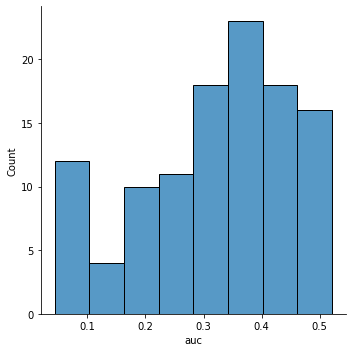

In [158]:
import seaborn as sns
sns.displot(data=pd.DataFrame(df_shap_results), x='auc')

In [100]:
union_not_suspected = (df.Meta.hospital == 'Union') & (df.Target.Metadata_Morbidity != 'Suspected')
liyuan_not_suspected = (df.Meta.hospital == 'Liyuan') & (df.Target.Metadata_Morbidity != 'Suspected')
shap_values = shap.TreeExplainer(LGBMClassifier(n_jobs=-1).fit(X[union_not_suspected], y[union_not_suspected]))(X[liyuan_not_suspected])
X_shap = shap_values.values[:, :, 1].ravel()
y_shap = X[liyuan_not_suspected].isna().values.ravel()
cross_val_score(LGBMClassifier(n_jobs=-1), X_shap[:, None], y_shap, cv=10, scoring='roc_auc').mean()

0.6927682059686497

In [185]:
import shap
shap_values = shap.TreeExplainer(LGBMClassifier(n_jobs=-1).fit(MissingIndicator().fit_transform(X[cohort1_not_suspected]), y[cohort1_not_suspected]))(MissingIndicator().fit_transform(X[cohort1_not_suspected]))

In [186]:
shap_values.feature_names = X.columns

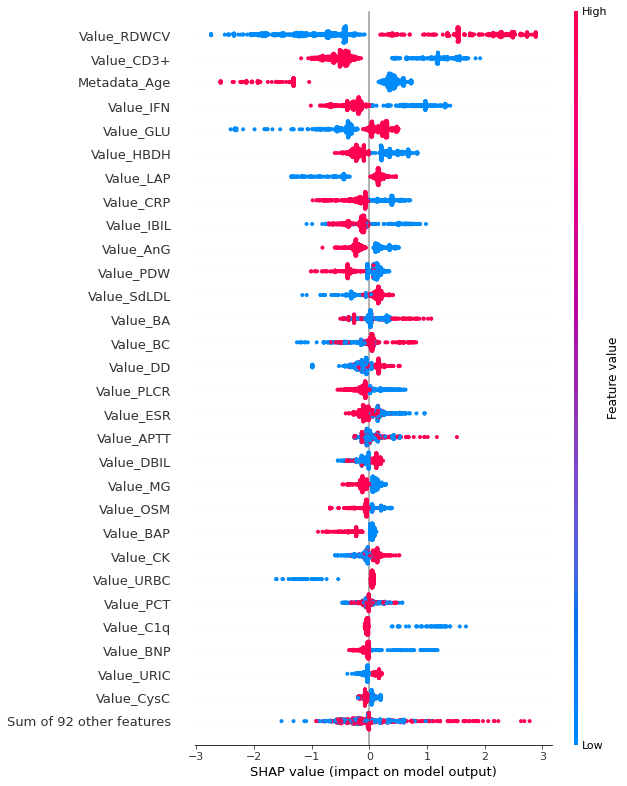

In [187]:
shap.plots.beeswarm(shap_values[:, :, 1], max_display=30)

In [216]:
import shap
shap_values = shap.TreeExplainer(LGBMClassifier(n_jobs=-1).fit(X[cohort1_not_suspected], y[cohort1_not_suspected]))(X[cohort1_not_suspected])

In [204]:
import pickle
with open('../data/processed/mapping.pkl', 'rb') as f:
    mapping = pickle.load(f)

In [217]:
shap_values.feature_names = [mapping[x].replace(' Value', '') if x in mapping else (x.split('_')[1] if '_' in x else x) for x in shap_values.feature_names]

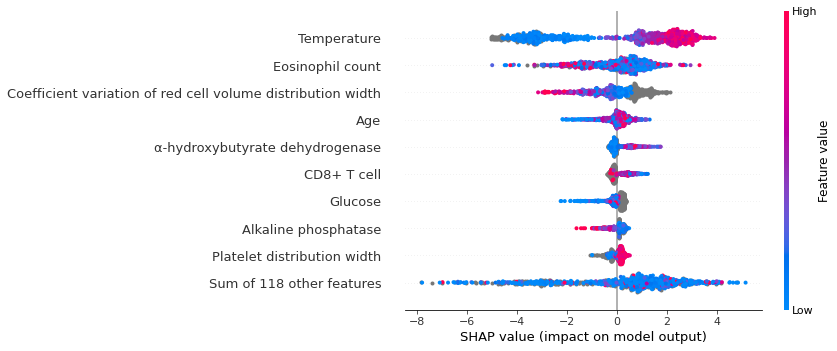

In [219]:
shap.plots.beeswarm(shap_values[:, :, 1])

In [41]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.impute import MissingIndicator
cross_val_score(LogisticRegressionCV(Cs=50, max_iter=1600), MissingIndicator().fit_transform(X[cohort1_not_suspected]), y[cohort1_not_suspected], cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3), scoring='roc_auc').mean()

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.8997358619641229

In [44]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.impute import MissingIndicator
cross_val_score(LogisticRegressionCV(Cs=10, l1_ratios=[0.1, 0.5, 0.9], penalty='elasticnet', solver='saga', max_iter=1600), MissingIndicator().fit_transform(X[cohort1_not_suspected]), y[cohort1_not_suspected], cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3), scoring='roc_auc').mean()

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

0.8954873568460524

In [39]:
from sklearn.base import BaseEstimator, ClassifierMixin
class LRWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, lr):
        self.lr = lr
    
    def fit(self, X, y):
        if self.lr.penalty == 'elasticnet':
            self.lr.solver = 'saga'
        elif self.lr.penalty != 'none':
            self.lr.solver = 'liblinear'
        else:
            self.lr.solver = 'lbfgs'
        self.lr.fit(X, y)
        self.classes_ = self.lr.classes_
        return self
    
    def predict_proba(self, X):
        return self.lr.predict_proba(X)
    
    def predict(self, X):
        return self.lr.predict(X)

In [40]:
from optuna.integration.sklearn import OptunaSearchCV
from sklearn.model_selection import StratifiedKFold
from optuna.distributions import UniformDistribution, IntUniformDistribution, LogUniformDistribution, CategoricalDistribution
params = {
    'lr__penalty': CategoricalDistribution(['l1', 'l2', 'elasticnet', 'none']), 
    'lr__C': LogUniformDistribution(1e-8, 1e6), 
    'lr__l1_ratio': UniformDistribution(0, 1)
}
clf = OptunaSearchCV(LRWrapper(LogisticRegression(max_iter=1600)), params, cv=StratifiedKFold(7, shuffle=True), n_trials=25)
cross_val_score(clf, MissingIndicator().fit_transform(X[cohort1_not_suspected]), y[cohort1_not_suspected], cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=2), scoring='roc_auc').mean()

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-09-06 13:25:06,409] A new study created in memory with name: no-name-20bacb90-34f6-4a32-8e3a-49e702f28346
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
[I 

0.8891812195956218

In [273]:
from sklearn.model_selection import cross_val_score
best_est = deepcopy(optcv.best_estimator_)
best_est.n_estimators = 8
clf = best_est
cross_val_score(clf, X[cohort1_not_suspected], y[cohort1_not_suspected], cv=10, scoring='roc_auc').mean()

Finished loading model, total used 347 iterations
Finished loading model, total used 466 iterations
Finished loading model, total used 345 iterations
Finished loading model, total used 485 iterations
Finished loading model, total used 520 iterations
Finished loading model, total used 383 iterations
Finished loading model, total used 511 iterations
Finished loading model, total used 517 iterations
Finished loading model, total used 371 iterations
Finished loading model, total used 400 iterations
Finished loading model, total used 504 iterations
Finished loading model, total used 437 iterations
Finished loading model, total used 377 iterations
Finished loading model, total used 473 iterations
Finished loading model, total used 458 iterations
Finished loading model, total used 447 iterations
Finished loading model, total used 374 iterations
Finished loading model, total used 427 iterations
Finished loading model, total used 467 iterations
Finished loading model, total used 468 iterations


0.8648955799635146

In [285]:
from sklearn.model_selection import cross_val_score
clf = BaggingClassifier(RandomLGBM(LGBMClassifier(n_jobs=1, n_estimators=24)), 2000, max_samples=1.0)
cross_val_score(clf, X[cohort1_not_suspected], y[cohort1_not_suspected], n_jobs=None, cv=10, scoring='roc_auc').mean()

[LightGBM] [Warning] feature_fraction is set=0.1303220824955959, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1303220824955959
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_gain_to_split is set=9.454938408925672, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.454938408925672
[LightGBM] [Warning] lambda_l1 is set=3.9943936438658333e-14, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9943936438658333e-14
[LightGBM] [Warning] lambda_l2 is set=2.3416024185451057e-16, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3416024185451057e-16
[LightGBM] [Warning] feature_fraction is set=0.8461957385865746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8461957385865746
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [W

0.8679502223320158

In [405]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from optuna import create_study
from optuna.samplers import TPESampler
from optuna.integration.sklearn import OptunaSearchCV
from optuna.distributions import LogUniformDistribution, IntUniformDistribution, CategoricalDistribution, UniformDistribution
X, y = preprocess(df.Input, df.Target.pcr)
clf = ShapZeroingClassifier(LGBMClassifier(n_jobs=-1))
dist = {
    'n_estimators': IntUniformDistribution(1, 780), 
    'learning_rate': LogUniformDistribution(1e-12, 0.5), 
#     'boosting_type': CategoricalDistribution(['gbdt', 'dart', 'goss']), 
    'boosting_type': CategoricalDistribution(['gbdt', 'dart']), 
    'max_depth': IntUniformDistribution(0, 40), 
    'num_leaves': IntUniformDistribution(2, 300), 
    'min_child_samples': IntUniformDistribution(1, 160), 
#     'linear_tree': CategoricalDistribution([False, True]), 
    'extra_trees': CategoricalDistribution([False, True]), 
    'max_bin': IntUniformDistribution(3, 700), 
    'colsample_bytree': UniformDistribution(0.01, 1.0), 
    'path_smooth': LogUniformDistribution(1e-40, 1), 
    'reg_alpha': LogUniformDistribution(1e-40, 10), 
    'reg_lambda': LogUniformDistribution(1e-40, 100), 
    'min_split_gain': LogUniformDistribution(1e-40, 50), 
    'subsample_freq': IntUniformDistribution(1, 60), 
    'subsample': UniformDistribution(0.01, 1.0)
}
dist = {'base_estimator__'+k: v for k, v in dist.items()}
opt = OptunaSearchCV(clf, dist, n_trials=20, study=create_study(sampler=TPESampler(multivariate=True), direction='maximize'), cv=StratifiedKFold(n_splits=8, shuffle=True))
cross_val_score(opt, X[cohort1_not_suspected], y[cohort1_not_suspected].cat.codes, cv=StratifiedKFold(n_splits=10, shuffle=True), scoring='roc_auc').mean()

``multivariate`` option is an experimental feature. The interface can change in the future.
[I 2021-08-30 13:37:44,654] A new study created in memory with name: no-name-c232d8bc-6788-4041-8232-2eef9bc54a57
OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-30 13:37:46,086] Trial 0 finished with value: 0.7458578792341679 and parameters: {'base_estimator__n_estimators': 254, 'base_estimator__learning_rate': 0.0005596464565020999, 'base_estimator__boosting_type': 'gbdt', 'base_estimator__max_depth': 7, 'base_estimator__num_leaves': 29, 'base_estimator__min_child_samples': 87, 'base_estimator__extra_trees': False, 'base_estimator__max_bin': 334, 'base_estimator__colsample_bytree': 0.440366689578326, 'base

0.9504727880814837

In [407]:
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from optuna import create_study
from optuna.samplers import TPESampler
from optuna.integration.sklearn import OptunaSearchCV
from optuna.distributions import LogUniformDistribution, IntUniformDistribution, CategoricalDistribution, UniformDistribution
X, y = preprocess(df.Input, df.Target.pcr)
clf = LGBMClassifier(n_jobs=-1)
dist = {
    'n_estimators': IntUniformDistribution(1, 780), 
    'learning_rate': LogUniformDistribution(1e-12, 0.5), 
#     'boosting_type': CategoricalDistribution(['gbdt', 'dart', 'goss']), 
    'boosting_type': CategoricalDistribution(['gbdt', 'dart']), 
    'max_depth': IntUniformDistribution(0, 40), 
    'num_leaves': IntUniformDistribution(2, 300), 
    'min_child_samples': IntUniformDistribution(1, 160), 
#     'linear_tree': CategoricalDistribution([False, True]), 
    'extra_trees': CategoricalDistribution([False, True]), 
    'max_bin': IntUniformDistribution(3, 700), 
    'colsample_bytree': UniformDistribution(0.01, 1.0), 
    'path_smooth': LogUniformDistribution(1e-40, 1), 
    'reg_alpha': LogUniformDistribution(1e-40, 10), 
    'reg_lambda': LogUniformDistribution(1e-40, 100), 
    'min_split_gain': LogUniformDistribution(1e-40, 50), 
    'subsample_freq': IntUniformDistribution(1, 60), 
    'subsample': UniformDistribution(0.01, 1.0)
}
# dist = {'base_estimator__'+k: v for k, v in dist.items()}
opt = OptunaSearchCV(clf, dist, n_trials=20, study=create_study(sampler=TPESampler(multivariate=True), direction='maximize'), cv=StratifiedKFold(n_splits=8, shuffle=True))
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
result = cross_validate(opt, X[cohort1_not_suspected], y[cohort1_not_suspected].cat.codes, cv=cv, scoring='roc_auc', return_estimator=True)

``multivariate`` option is an experimental feature. The interface can change in the future.
[I 2021-08-30 13:48:27,986] A new study created in memory with name: no-name-f7f1d335-79ec-4138-9b02-c1e2e0a8f4b6
OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-30 13:48:28,622] Trial 0 finished with value: 0.7458578792341679 and parameters: {'n_estimators': 124, 'learning_rate': 6.870494590976883e-05, 'boosting_type': 'dart', 'max_depth': 0, 'num_leaves': 147, 'min_child_samples': 37, 'extra_trees': False, 'max_bin': 286, 'colsample_bytree': 0.5904002598658896, 'path_smooth': 2.536799866671634e-11, 'reg_alpha': 6.643112875584977e-08, 'reg_lambda': 3.354183500185248e-30, 'min_split_gain': 1.6971728433126243

In [418]:
result['estimator'][0].best_estimator_

LGBMClassifier(colsample_bytree=0.7812887063187927, extra_trees=False,
               learning_rate=0.052225778529789324, max_bin=521, max_depth=0,
               min_child_samples=33, min_split_gain=1.3391708295525222e-29,
               n_estimators=487, num_leaves=155,
               path_smooth=4.497044819089075e-15,
               reg_alpha=6.576441917994665e-38,
               reg_lambda=0.0006712780269137868, subsample=0.9689275291596787,
               subsample_freq=59)

In [421]:
from sklearn.base import clone
scores = []
for est, score, (train_idx, test_idx) in zip(result['estimator'], result['test_score'], cv.split(X[cohort1_not_suspected], y[cohort1_not_suspected])):
    X_train, y_train = X[cohort1_not_suspected].iloc[train_idx], y[cohort1_not_suspected].iloc[train_idx]
    X_test, y_test = X[cohort1_not_suspected].iloc[test_idx], y[cohort1_not_suspected].iloc[test_idx]    
    
    new_est = ShapZeroingClassifier(clone(est.best_estimator_))
    new_est.fit(X_train, y_train)
    
    print(score, roc_auc_score(y_test, new_est.predict_proba(X_test)[:, 1]))
    scores.append(roc_auc_score(y_test, new_est.predict_proba(X_test)[:, 1]))
np.mean(scores)

0.9732441471571907 0.9658862876254181
0.9832167832167832 0.9734265734265733
0.9727272727272727 0.9517482517482517
0.9727272727272727 0.9657342657342657
0.9734265734265733 0.9748251748251748
0.9615384615384616 0.9482517482517482
0.9496503496503497 0.9384615384615385
0.9489510489510489 0.9342657342657342
0.9524475524475524 0.9440559440559441
0.970108695652174 0.9572010869565217


0.955385660535117

In [488]:
X_vis_simple = X.copy()
X_vis_simple = X_vis_simple.dropna(axis='columns', thresh=int(len(X_vis_simple)*0.16))
X_vis_simple['vis'] = X_vis_simple.loc[:, X_vis_simple.columns.str.startswith('Visual')].mean(axis=1)
X_vis_simple = X_vis_simple.loc[:, ~X_vis_simple.columns.str.startswith('Visual')]

In [496]:
cross_val_score(BaggingClassifier(LGBMClassifier(n_jobs=-1), n_estimators=60), X[cohort1_not_suspected], y[cohort1_not_suspected], cv=10, scoring='roc_auc').mean()

0.9464680564001217

In [465]:
import joblib
data_in_code = joblib.load(r'C:/Users/Roel/Documents/DIAGCovid/experiments/between_dataset/ictcf_Liyuan/combined/result_bagged_gbdt.pkl')

In [486]:
roc_auc_score(data_in_code['y_test'], 
              BaggingClassifier(LGBMClassifier(n_jobs=-1, n_estimators=100), n_estimators=2000).fit(data_in_code['X_train'], data_in_code['y_train']).predict_proba(data_in_code['X_test'])[:, 1])

0.8445685139233527

In [469]:
roc_auc_score(data_in_code['y_test'], 
              (LGBMClassifier(n_jobs=-1)).fit(data_in_code['X_train'], data_in_code['y_train']).predict_proba(data_in_code['X_test'])[:, 1])

0.8637992831541219

In [451]:
roc_auc_score(y[(df.Meta.hospital == 'Liyuan')], 
             BaggingClassifier(LGBMClassifier(n_jobs=-1, n_estimators=100), n_estimators=200).fit(X[ (df.Meta.hospital == 'Union')], 
                                           y[ (df.Meta.hospital == 'Union')]).predict_proba(X[(df.Meta.hospital == 'Liyuan')])[:, 1])

0.8494109173226322

In [732]:
from sklearn.base import clone
class TestTimeImputingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator, imputer, n_repeat, n_repeated_predict, ensemble=False, impute_in_predict=False):
        self.base_estimator = base_estimator
        self.imputer = imputer
        self.n_repeat = n_repeat
        self.n_repeated_predict = n_repeated_predict
        self.ensemble = ensemble
        self.impute_in_predict = impute_in_predict
        
        if ensemble:
            self._estimators = []
    
    def _impute_data(self, X, y, should_fit):
        X_rep = []
        if y is not None:
            y_rep = []
            
        imputer = self.imputer
        if isinstance(self.imputer, ColumnImputer) and self.impute_in_predict and not should_fit:
            imputer = self.predict_imputer

        if should_fit:
            imputer.fit(X)

        for i in range(self.n_repeat if should_fit else self.n_repeated_predict):
            X_rep.append(imputer.transform(X))
            if y is not None:
                y_rep.append(y)

        X_rep = pd.concat([pd.DataFrame(x) for x in X_rep])
        if y is not None:
            y_rep = pd.concat([pd.Series(y) for y in y_rep])
            return X_rep, y_rep
        else:
            return X_rep
    
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        if not self.impute_in_predict:
            if isinstance(self.imputer, IterativeImputer):
                self.imputer.sample_posterior = True
            elif isinstance(self.imputer, ColumnImputer):
                self.predict_imputer = SimpleImputer(strategy='mean').fit(X, y)
                if isinstance(X, pd.DataFrame):
                    self.cols_to_use = np.where(~X.isna().all())[0]
                    X = X.iloc[:, self.cols_to_use]
                else:
                    self.cols_to_use = np.where(~np.isnan(X.astype(np.float)).all(axis=0))[0]
                    X = X[:, self.cols_to_use]
#                 self.predict_imputer = IterativeImputer(max_iter=30, n_nearest_features=60).fit(X, y)
            elif isinstance(self.imputer, KNNImputer2):
                self.predict_imputer = KNNImputer(n_neighbors=self.imputer.n_neighbors).fit(X, y)
        else:
            if isinstance(self.imputer, ColumnImputer):
#                 self.predict_imputer = IterativeImputer(max_iter=18, n_nearest_features=16, sample_posterior=True).fit(X, y)
                self.predict_imputer = self.imputer
        X_rep, y_rep = self._impute_data(X, y, should_fit=True)
        if self.ensemble:
            n_samples = X.shape[0]
            self._estimators = []
            for i in range(self.n_repeat):
                X_i, y_i = X_rep[n_samples*i:n_samples*(i+1)], y_rep[n_samples*i:n_samples*(i+1)]
                estimator = clone(self.base_estimator)
                estimator.fit(X_i, y_i)
                self._estimators.append(estimator)
        else:
            self.base_estimator.fit(X_rep, y_rep)
        
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
    
    def predict_proba(self, X):
        if not self.impute_in_predict:
            if isinstance(self.imputer, IterativeImputer):
                self.imputer.sample_posterior = False
                return self.base_estimator.predict_proba(self.imputer.transform(X))
            elif isinstance(self.imputer, ColumnImputer):
                if not self.ensemble:
                    return self.base_estimator.predict_proba(self.predict_imputer.transform(X))
                else:
                    X_imputed = self.predict_imputer.transform(X)
                    return np.mean([est.predict_proba(X_imputed) for est in self._estimators], axis=0)
            elif isinstance(self.imputer, KNNImputer2):
                if not self.ensemble:
                    return self.base_estimator.predict_proba(self.predict_imputer.transform(X))
                else:
                    X_imputed = self.predict_imputer.transform(X)
                    return np.mean([est.predict_proba(X_imputed) for est in self._estimators], axis=0)
        
        if self.impute_in_predict:
            X_rep = self._impute_data(X, None, should_fit=False)
        
#         print(np.array([preds[n_preds*i:n_preds*(i+1)] for i in range(self.n_repeat)]).shape)
        if self.ensemble:
            n_samples = X.shape[0]
            if self.impute_in_predict:
                return np.mean([est.predict_proba(X_rep[n_samples*i:n_samples*(i+1)]) for i, est in enumerate(self._estimators)], axis=0)
            else:
                return np.mean([est.predict_proba(X) for i, est in enumerate(self._estimators)], axis=0)
        else:
            preds = self.base_estimator.predict_proba(X_rep)
            n_preds = X.shape[0]
            return np.mean([preds[n_preds*i:n_preds*(i+1)] for i in range(self.n_repeated_predict)], axis=0)
    
    def shap_values(self, X):
        if not isinstance(self.imputer, ColumnImputer):
            raise ValueError('oop cant handle this')

        try:
            X = self.predict_imputer.transform(X)
        except ValueError:
            if isinstance(X, pd.DataFrame):
                X = X.iloc[:, self.cols_to_use]
            else:
                X = X[:, self.cols_to_use]
            X = self.predict_imputer.transform(X)

        if self.ensemble:
            shap_values = [shap.Explainer(est)(X) for est in self._estimators]
            return np.mean([s.values for s in shap_values], axis=0), np.mean([s.base_values for s in shap_values],
                                                                             axis=0)
        else:
            explainer = shap.Explainer(self.base_estimator)(X)
            return explainer.values, explainer.base_values
    
    def base_values(self, X):
        X_rep = self._impute_data(X, None, should_fit=False)
        n_preds = X.shape[0]
        explainer = shap.TreeExplainer(self.base_estimator)
        return np.mean([explainer(X_rep[n_preds*i:n_preds*(i+1)]).base_values for i in range(self.n_repeat)], axis=0)

In [730]:
class TestTimeImputingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator, imputer, n_repeat, ensemble=False, impute_in_predict=True):
        self.base_estimator = base_estimator
        self.imputer = imputer
        self.n_repeat = n_repeat
        self.ensemble = ensemble
        self.impute_in_predict = impute_in_predict

        if ensemble:
            self._estimators = []

    def _impute_data(self, X, y, should_fit):
        X_rep = []
        if y is not None:
            y_rep = []

        if should_fit:
            self.imputer.fit(X)

        for i in range(self.n_repeat):
            X_rep.append(self.imputer.transform(X))
            if y is not None:
                y_rep.append(y)

        X_rep = pd.concat([pd.DataFrame(x) for x in X_rep])
        if y is not None:
            y_rep = pd.concat([pd.Series(y) for y in y_rep])
            return X_rep, y_rep
        else:
            return X_rep

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        if isinstance(self.imputer, IterativeImputer):
            self.imputer.sample_posterior = True
        elif isinstance(self.imputer, ColumnImputer):
            self.predict_imputer = SimpleImputer(strategy='mean').fit(X, y)
            if isinstance(X, pd.DataFrame):
                self.cols_to_use = np.where(~X.isna().all())[0]
                X = X.iloc[:, self.cols_to_use]
            else:
                self.cols_to_use = np.where(~np.isnan(X.astype(np.float)).all(axis=0))[0]
                X = X[:, self.cols_to_use]
        X_rep, y_rep = self._impute_data(X, y, should_fit=True)
        for col in X_rep.select_dtypes(include=[np.object]):
            X_rep[col] = X_rep[col].astype(np.float)
        if self.ensemble:
            n_samples = X.shape[0]
            self._estimators = []
            for i in range(self.n_repeat):
                X_i, y_i = X_rep[n_samples * i:n_samples * (i + 1)], y_rep[n_samples * i:n_samples * (i + 1)]
                estimator = clone(self.base_estimator)
                estimator.fit(X_i, y_i)
                self._estimators.append(estimator)
        else:
            self.base_estimator.fit(X_rep, y_rep)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def predict_proba(self, X):
        if not self.impute_in_predict:
            if isinstance(self.imputer, IterativeImputer):
                self.imputer.sample_posterior = False
                return self.base_estimator.predict_proba(self.imputer.transform(X))
            elif isinstance(self.imputer, ColumnImputer):
                if isinstance(X, pd.DataFrame):
                    X = X.iloc[:, self.cols_to_use]
                else:
                    X = X[:, self.cols_to_use]
                if not self.ensemble:
                    return self.base_estimator.predict_proba(self.predict_imputer.transform(X))
                else:
                    X_imputed = self.predict_imputer.transform(X)
                    return np.mean([est.predict_proba(X_imputed) for est in self._estimators], axis=0)

        if self.impute_in_predict:
            X_rep = self._impute_data(X, None, should_fit=False)

        #         print(np.array([preds[n_preds*i:n_preds*(i+1)] for i in range(self.n_repeat)]).shape)
        if self.ensemble:
            n_samples = X.shape[0]
            if self.impute_in_predict:
                return np.mean([est.predict_proba(X_rep[n_samples * i:n_samples * (i + 1)]) for i, est in
                                enumerate(self._estimators)], axis=0)
            else:
                return np.mean([est.predict_proba(X) for i, est in enumerate(self._estimators)], axis=0)
        else:
            preds = self.base_estimator.predict_proba(X_rep)
            n_preds = X.shape[0]
            return np.mean([preds[n_preds * i:n_preds * (i + 1)] for i in range(self.n_repeat)], axis=0)

    def shap_values(self, X):
        if not isinstance(self.imputer, ColumnImputer):
            raise ValueError('oop cant handle this')

        try:
            X = self.predict_imputer.transform(X)
        except ValueError:
            if isinstance(X, pd.DataFrame):
                X = X.iloc[:, self.cols_to_use]
            else:
                X = X[:, self.cols_to_use]
            X = self.predict_imputer.transform(X)

        if self.ensemble:
            shap_values = [shap.Explainer(est)(X) for est in self._estimators]
            return np.mean([s.values for s in shap_values], axis=0), np.mean([s.base_values for s in shap_values],
                                                                             axis=0), self.cols_to_use
        else:
            explainer = shap.Explainer(self.base_estimator)(X)
            return explainer.values, explainer.base_values, self.cols_to_use
        # X_rep = self._impute_data(X, None, should_fit=False)
        # n_preds = X.shape[0]
        # explainer = shap.TreeExplainer(self.base_estimator)
        # shap_values = [explainer(X_rep[n_preds * i:n_preds * (i + 1)]) for i in range(self.n_repeat)]
        # return np.mean([s.values for s in shap_values], axis=0), np.mean([s.base_values for s in shap_values], axis=0)

    def base_values(self, X):
        X_rep = self._impute_data(X, None, should_fit=False)
        n_preds = X.shape[0]
        explainer = shap.TreeExplainer(self.base_estimator)
        return np.mean([explainer(X_rep[n_preds * i:n_preds * (i + 1)]).base_values for i in range(self.n_repeat)],
                       axis=0)

In [657]:
clf = TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1, n_estimators=100, use_missing=True), ColumnImputer(), 100, ensemble=True, impute_in_predict=False)
clf.fit(X.loc[cohort1_not_suspected, ~X.columns.str.startswith('Visual')], y[cohort1_not_suspected])
cohort2_not_suspected = (df.Meta.cohort == 'c2') & (df.Target.Metadata_Morbidity != 'Suspected')
roc_auc_score(y[cohort2_not_suspected], clf.predict_proba(X.loc[cohort2_not_suspected, ~X.columns.str.startswith('Visual')])[:, 1])

0.7416249518675395

In [660]:
shap_values, _, cols_to_use = clf.shap_values(X.loc[cohort2_not_suspected, ~X.columns.str.startswith('Visual')])
shap_values = shap_values[:, :, 1]

In [661]:
np.mean(np.abs(shap_values * X.iloc[:, cols_to_use].loc[cohort2_not_suspected, ~X.iloc[:, cols_to_use].columns.str.startswith('Visual')].isna())).mean()

0.01564826696178846

In [662]:
np.mean(np.abs(shap_values * ~X.iloc[:, cols_to_use].loc[cohort2_not_suspected, ~X.iloc[:, cols_to_use].columns.str.startswith('Visual')].isna())).mean()

0.0440230198127382

<BarContainer object of 2 artists>

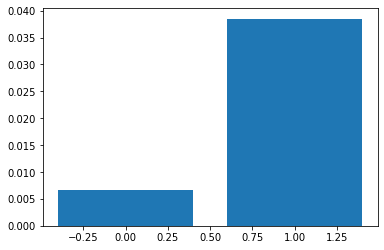

In [656]:
plt.bar([0, 1], [np.mean(np.abs(shap_values * X.iloc[:, cols_to_use].loc[cohort2_not_suspected, ~X.iloc[:, cols_to_use].columns.str.startswith('Visual')].isna())).mean(), 
                np.mean(np.abs(shap_values * ~X.iloc[:, cols_to_use].loc[cohort2_not_suspected, ~X.iloc[:, cols_to_use].columns.str.startswith('Visual')].isna())).mean()])

In [664]:
masker = shap.maskers.Independent(X.loc[cohort1_not_suspected, ~X.columns.str.startswith('Visual')])

In [668]:
x

Clinical_Value_5NT                                               NaN
Clinical_Value_AFU                                               NaN
Clinical_Value_ALB                                          0.120000
Clinical_Value_ALG                                          0.000000
Clinical_Value_ALP                                          0.181818
                                                             ...    
Clinical_Metadata_Temperature                              38.000000
Clinical_Disease_hypertension                               0.000000
Clinical_Disease_diabetes                                   0.000000
Clinical_Disease_coronary atherosclerotic heart disease     0.000000
Clinical_Disease                                            0.000000
Name: 1170, Length: 127, dtype: float64

In [680]:
x = X.loc[cohort2_not_suspected, ~X.columns.str.startswith('Visual')].iloc[0]
mask = np.zeros_like(x.values, dtype=bool)
# mask[0] = True
# masker((~x.isna()).values, x.values)
masker(~mask, x.values)

Clinical_Value_5NT  Clinical_Value_AFU  Clinical_Value_ALB  \
0                  NaN                 NaN                0.12   
1                  NaN                 NaN                 NaN   
2                  NaN                 NaN                0.12   
3                  NaN                 NaN                0.12   
4                  NaN                 NaN                 NaN   
..                 ...                 ...                 ...   
95                 NaN                 NaN                0.12   
96                 NaN                 NaN                 NaN   
97                 NaN                 NaN                 NaN   
98                 NaN                 NaN                0.12   
99                 NaN                 NaN                0.12   

    Clinical_Value_ALG  Clinical_Value_ALP  Clinical_Value_ALT  \
0                  NaN            0.181818                 0.4   
1                  NaN                 NaN                 NaN   
2                  NaN            0.181818                 0.4   
3                  0.0            0.181818                 0.4   
4                  NaN                 NaN                 NaN   
..                 ...                 ...                 ...   
95                 0.0            0.181818                 0.4   
96                 NaN                 NaN                 NaN   
97                 NaN                 NaN                 NaN   
98                 NaN            0.181818                 0.4   
99                 0.0            0.181818                 0.4   

    Clinical_Value_APOA1  Clinical_Value_APOB  Clinical_Value_APTT  \
0                    NaN                  NaN                  NaN   
1                    NaN                  NaN                  NaN   
2                    NaN                  NaN                  NaN   
3                    NaN                  NaN                  NaN   
4                    NaN                  NaN                  NaN   
..                   ...                  ...                  ...   
95                   NaN                  NaN                  NaN   
96                   NaN                  NaN                  NaN   
97                   NaN                  NaN                  NaN   
98                   NaN                  NaN                  NaN   
99                   NaN                  NaN                  NaN   

    Clinical_Value_ASO  ...  Clinical_Value_UWBC  Clinical_Value_WBC  \
0                  NaN  ...                  NaN            0.283333   
1                  NaN  ...                  NaN            0.283333   
2                  NaN  ...                  NaN            0.283333   
3                  NaN  ...                  NaN            0.283333   
4                  NaN  ...                  NaN                 NaN   
..                 ...  ...                  ...                 ...   
95                 NaN  ...                  NaN            0.283333   
96                 NaN  ...                  NaN                 NaN   
97                 NaN  ...                  NaN                 NaN   
98                 NaN  ...                  NaN            0.283333   
99                 NaN  ...                  NaN            0.283333   

    Clinical_Value_WBCC  Clinical_Metadata_Age  Clinical_Metadata_Sex  \
0                   NaN                   66.0                    0.0   
1                   NaN                   66.0                    0.0   
2                   NaN                   66.0                    0.0   
3                   NaN                   66.0                    0.0   
4                   NaN                   66.0                    0.0   
..                  ...                    ...                    ...   
95                  NaN                   66.0                    0.0   
96                  NaN                   66.0                    0.0   
97                  NaN                   66.0         

In [643]:
clf = make_pipeline(
    SimpleImputer(strategy='mean'), 
    LGBMClassifier(n_jobs=-1)
)
clf.fit(X.loc[cohort1_not_suspected, ~X.columns.str.startswith('Visual')], y[cohort1_not_suspected])
cohort2_not_suspected = (df.Meta.cohort == 'c2') & (df.Target.Metadata_Morbidity != 'Suspected')
roc_auc_score(y[cohort2_not_suspected], clf.predict_proba(X.loc[cohort2_not_suspected, ~X.columns.str.startswith('Visual')])[:, 1])

0.9128224874855603

In [647]:
shap_values = shap.TreeExplainer(clf.steps[1][1])(clf.steps[0][1].transform(X.loc[cohort2_not_suspected, ~X.columns.str.startswith('Visual')])).values[:, :, 1]

In [649]:
np.mean(np.abs(shap_values * X.iloc[:, cols_to_use].loc[cohort2_not_suspected, ~X.iloc[:, cols_to_use].columns.str.startswith('Visual')].isna())).mean()

0.016132000767464655

In [650]:
np.mean(np.abs(shap_values * ~X.iloc[:, cols_to_use].loc[cohort2_not_suspected, ~X.iloc[:, cols_to_use].columns.str.startswith('Visual')].isna())).mean()

0.06016482139491018

<BarContainer object of 2 artists>

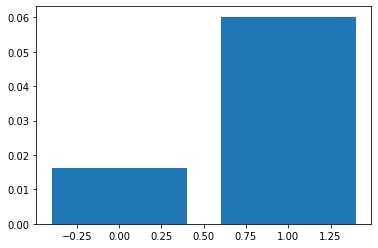

In [651]:
plt.bar([0, 1], [np.mean(np.abs(shap_values * X.iloc[:, cols_to_use].loc[cohort2_not_suspected, ~X.iloc[:, cols_to_use].columns.str.startswith('Visual')].isna())).mean(), 
                np.mean(np.abs(shap_values * ~X.iloc[:, cols_to_use].loc[cohort2_not_suspected, ~X.iloc[:, cols_to_use].columns.str.startswith('Visual')].isna())).mean()])

In [681]:
clf = LGBMClassifier(n_jobs=-1)
clf.fit(X.loc[cohort1_not_suspected, ~X.columns.str.startswith('Visual')], y[cohort1_not_suspected])
cohort2_not_suspected = (df.Meta.cohort == 'c2') & (df.Target.Metadata_Morbidity != 'Suspected')
roc_auc_score(y[cohort2_not_suspected], clf.predict_proba(X.loc[cohort2_not_suspected, ~X.columns.str.startswith('Visual')])[:, 1])

0.934193299961494

In [685]:
shap_values = shap.TreeExplainer(clf)(X.loc[cohort2_not_suspected, ~X.columns.str.startswith('Visual')])

In [691]:
shap_values = pd.DataFrame(shap_values.values[:, :, 1], index=X.loc[cohort2_not_suspected, ~X.columns.str.startswith('Visual')].index, columns=X.loc[cohort2_not_suspected, ~X.columns.str.startswith('Visual')].columns)

In [697]:
X.loc[cohort2_not_suspected, ~X.columns.str.startswith('Visual')]

Clinical_Value_5NT  Clinical_Value_AFU  Clinical_Value_ALB  \
1170                 NaN                 NaN               0.120   
1171                 NaN                 NaN                 NaN   
1172                 NaN                 NaN                 NaN   
1173                 NaN                 NaN                 NaN   
1174                 NaN                 NaN                 NaN   
...                  ...                 ...                 ...   
1516                 0.9                 NaN              -0.045   
1517                 NaN                 NaN                 NaN   
1518                 NaN                 NaN                 NaN   
1519                 NaN                 NaN                 NaN   
1520                 NaN                 NaN                 NaN   

      Clinical_Value_ALG  Clinical_Value_ALP  Clinical_Value_ALT  \
1170                 0.0            0.181818                 0.4   
1171                 NaN                 NaN                 NaN   
1172                 NaN                 NaN                 NaN   
1173                 NaN                 NaN                 NaN   
1174                 NaN                 NaN                 NaN   
...                  ...                 ...                 ...   
1516                -0.8            0.172727                 2.6   
1517                 NaN                 NaN                 NaN   
1518                 NaN                 NaN                 NaN   
1519                 NaN                 NaN                 NaN   
1520                 NaN                 NaN                 NaN   

      Clinical_Value_APOA1  Clinical_Value_APOB  Clinical_Value_APTT  \
1170                   NaN                  NaN                  NaN   
1171                   NaN                  NaN                  NaN   
1172                   NaN                  NaN             1.180645   
1173                   NaN                  NaN             0.825806   
1174                   NaN                  NaN             0.729032   
...                    ...                  ...                  ...   
1516                   NaN                  NaN             0.935484   
1517                   NaN                  NaN                  NaN   
1518                   NaN                  NaN                  NaN   
1519                   NaN                  NaN                  NaN   
1520                   NaN                  NaN                  NaN   

      Clinical_Value_ASO  ...  Clinical_Value_UWBC  Clinical_Value_WBC  \
1170                 NaN  ...                  NaN            0.283333   
1171                 NaN  ...                  NaN            0.283333   
1172                 NaN  ...                  NaN            0.240000   
1173                 NaN  ...                  NaN            0.135000   
1174                 NaN  ...                  NaN            0.015000   
...                  ...  ...                  ...                 ...   
1516                 NaN  ...                  NaN            0.120000   
1517                 NaN  ...                  NaN            0.425000   
1518                 NaN  ...                  NaN            0.086667   
1519                 NaN  ...                  NaN            0.278333   
1520                 NaN  ...                  NaN            0.273333   

      Clinical_Value_WBCC  Clinical_Metadata_Age  Clinical_Metadata_Sex  \
1170                  NaN                     66                    0.0   
1171                  NaN                     68                    0.0   
1172                  NaN                     81                    0.0   
1173                  NaN                     71                    1.0   
1174                  NaN                     86                    0.0   
...                   ...                    ...                    ...   
1516                  NaN                     45                    0.0   
1517              

In [701]:
shap_values[X.loc[cohort2_not_suspected, ~X.columns.str.startswith('Visual')].isna()] = np.nan

In [711]:
pd.DataFrame([shap_values.var(), shap_values.abs().mean()]).T.sort_values(by=1, ascending=False)

0         1
Clinical_Metadata_Temperature  5.275729  2.128021
Clinical_Value_RDWCV           0.413760  0.903408
Clinical_Value_CD8+            0.078229  0.431586
Clinical_Value_ALP             0.190505  0.391115
Clinical_Value_GLU             0.295236  0.384052
...                                 ...       ...
Clinical_Value_UNCC                 NaN       NaN
Clinical_Value_UNCX                 NaN       NaN
Clinical_Value_URBC                 NaN       NaN
Clinical_Value_UWBC                 NaN       NaN
Clinical_Value_WBCC                 NaN       NaN

[127 rows x 2 columns]

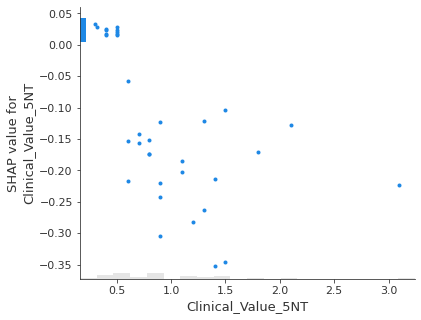

In [688]:
shap.plots.scatter(shap_values[:, 0, 1])

In [455]:
roc_auc_score(y[(df.Meta.hospital == 'Liyuan')], 
             (LGBMClassifier(n_jobs=-1, n_estimators=100)).fit(X_vis_simple[ (df.Meta.hospital == 'Union')], 
                                           y[ (df.Meta.hospital == 'Union')]).predict_proba(X_vis_simple[(df.Meta.hospital == 'Liyuan')])[:, 1])

0.8377064361784227

In [440]:
from sklearn.model_selection import RepeatedStratifiedKFold
cross_val_score((LGBMClassifier(n_jobs=-1)), X_vis_simple, y[cohort1_not_suspected], cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=10), scoring='roc_auc').mean()

0.9607107308452418

In [733]:
from sklearn.model_selection import RepeatedStratifiedKFold
cross_val_score(TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), ColumnImputer(), 120, 120, ensemble=True, impute_in_predict=False), X.loc[cohort1_not_suspected, ~X.columns.str.startswith('Visual')], y[cohort1_not_suspected], cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=10), scoring='roc_auc').mean()

0.8612560713742777

In [429]:
from sklearn.model_selection import RepeatedStratifiedKFold
cross_val_score(ShapZeroingClassifier(LGBMClassifier(n_jobs=-1)), X.loc[cohort1_not_suspected, ~X.columns.str.startswith('Visual')], y[cohort1_not_suspected], cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=10), scoring='roc_auc').mean()

0.9054163071982364

In [ ]:
X.loc[cohort1_not_suspected, ~X.columns.str.startswith('Visual')].sum()

In [503]:
roc_auc_score(y[cohort1_not_suspected], X.loc[cohort1_not_suspected, X.columns.str.startswith('Visual')].mean(axis=1).fillna(2.5))

0.8881161593026

In [497]:
dist = {
    'n_estimators': IntUniformDistribution(1, 780), 
    'learning_rate': LogUniformDistribution(1e-12, 0.5), 
    'boosting_type': CategoricalDistribution(['gbdt', 'dart']), 
#     'boosting_type': CategoricalDistribution(['goss']), 
    'max_depth': IntUniformDistribution(0, 40), 
    'num_leaves': IntUniformDistribution(2, 300), 
    'min_child_samples': IntUniformDistribution(1, 160), 
    'linear_tree': CategoricalDistribution([False, True]), 
    'extra_trees': CategoricalDistribution([False, True]), 
    'max_bin': IntUniformDistribution(3, 700), 
    'colsample_bytree': UniformDistribution(0.01, 1.0), 
    'path_smooth': LogUniformDistribution(1e-40, 1), 
    'reg_alpha': LogUniformDistribution(1e-40, 10), 
    'reg_lambda': LogUniformDistribution(1e-40, 100), 
    'min_split_gain': LogUniformDistribution(1e-40, 50), 
    'subsample_freq': IntUniformDistribution(1, 60), 
    'subsample': UniformDistribution(0.01, 1.0)
}
opt = OptunaSearchCV(clf, dist, n_trials=40, study=create_study(sampler=TPESampler(multivariate=True), direction='maximize'), cv=StratifiedKFold(n_splits=5, shuffle=True))
cross_val_score(opt, X[cohort1_not_suspected], y[cohort1_not_suspected], cv=StratifiedKFold(n_splits=10, shuffle=True), scoring='roc_auc').mean()

``multivariate`` option is an experimental feature. The interface can change in the future.
[I 2021-08-30 22:02:02,171] A new study created in memory with name: no-name-be42faec-d982-4b3e-8292-b0cb466946d3
OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-30 22:02:04,071] Trial 0 finished with value: 0.9118977625347053 and parameters: {'n_estimators': 420, 'learning_rate': 0.023639766206181228, 'boosting_type': 'gbdt', 'max_depth': 27, 'num_leaves': 244, 'min_child_samples': 24, 'linear_tree': False, 'extra_trees': False, 'max_bin': 667, 'colsample_bytree': 0.3336416192011366, 'path_smooth': 5.013283377984178e-37, 'reg_alpha': 2.868989171879514e-17, 'reg_lambda': 2.3409007958963875e-15, 'min_split_ga

0.9611790247795684

In [40]:
OptunaSearchCV(clf, dist, n_trials=30, study=create_study(sampler=TPESampler(multivariate=True), direction='maximize'), cv=StratifiedKFold(n_splits=8, shuffle=True)).fit(X[cohort1_not_suspected], y[cohort1_not_suspected]).best_params_

``multivariate`` option is an experimental feature. The interface can change in the future.
[I 2021-08-19 12:36:23,782] A new study created in memory with name: no-name-e593588d-cd75-4be3-83f9-cb2f177e4511
OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-19 12:36:27,070] Trial 0 finished with value: 0.8932318212708121 and parameters: {'n_estimators': 651, 'learning_rate': 0.03310774190898953, 'boosting_type': 'dart', 'max_depth': 34, 'num_leaves': 209, 'min_child_samples': 89, 'linear_tree': False, 'extra_trees': False, 'max_bin': 350, 'colsample_bytree': 0.8724955556667957, 'path_smooth': 1.0046930191598966e-27, 'reg_alpha': 1.7308286304791641e-35, 'reg_lambda': 1.5719224671623065e-18, 'min_split_gain': 7.96524576969573e-15, 'subsample_freq': 48, 'subsample': 0.36618020626934333}. Best is tria

{'n_estimators': 650,
 'learning_rate': 0.21354852331118065,
 'boosting_type': 'dart',
 'max_depth': 21,
 'num_leaves': 223,
 'min_child_samples': 25,
 'linear_tree': False,
 'extra_trees': True,
 'max_bin': 678,
 'colsample_bytree': 0.9996061347806797,
 'path_smooth': 0.6975392284613767,
 'reg_alpha': 4.942195861929093e-35,
 'reg_lambda': 1.2527657466464293e-26,
 'min_split_gain': 0.5069570975962894,
 'subsample_freq': 8,
 'subsample': 0.868765099332739}

In [56]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
cross_val_score(LGBMClassifier(n_jobs=-1, **{'n_estimators': 186, 'learning_rate': 0.022557923561015235, 'boosting_type': 'gbdt', 'max_depth': 13, 'num_leaves': 138, 'min_child_samples': 26, 'linear_tree': True, 'extra_trees': True, 'max_bin': 542, 'colsample_bytree': 0.10222857568816252, 'path_smooth': 5.975961059413038e-10, 'reg_alpha': 1.325352722121037e-22, 'reg_lambda': 2.767161743570488e-34, 'min_split_gain': 1.3554223746105415e-24, 'subsample_freq': 27, 'subsample': 0.07263315699402972}),
                X[cohort1_not_suspected], y[cohort1_not_suspected], cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=10), scoring='roc_auc').mean()

0.9136459030100335

In [26]:
import flaml
from sklearn.model_selection import cross_val_score
X, y = preprocess(df.Input.Clinical, df.Target.pcr)
automl = flaml.AutoML()
automl.fit(X[(df.Meta.cohort == 'c1')], y[(df.Meta.cohort == 'c1')], metric='roc_auc', time_budget=700)

[flaml.automl: 08-19 09:58:01] {1121} INFO - Evaluation method: cv
[flaml.automl: 08-19 09:58:01] {618} INFO - Using StratifiedKFold
[flaml.automl: 08-19 09:58:01] {1142} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 08-19 09:58:01] {1163} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'lrl1']
[flaml.automl: 08-19 09:58:01] {1253} INFO - iteration 0, current learner lgbm
[flaml.automl: 08-19 09:58:01] {1411} INFO -  at 0.3s,	best lgbm's error=0.2767,	best lgbm's error=0.2767
[flaml.automl: 08-19 09:58:01] {1253} INFO - iteration 1, current learner lgbm
[flaml.automl: 08-19 09:58:01] {1411} INFO -  at 0.5s,	best lgbm's error=0.2767,	best lgbm's error=0.2767
[flaml.automl: 08-19 09:58:01] {1253} INFO - iteration 2, current learner lgbm
[flaml.automl: 08-19 09:58:01] {1411} INFO -  at 0.7s,	best lgbm's error=0.2464,	best lgbm's error=0.2464
[flaml.automl: 08-19 09:58:01] {1253} INFO - iteration 3, current learner xgboost
[flaml.aut

In [27]:
roc_auc_score(y[df.Meta.cohort == 'c2'], automl.predict_proba(X[df.Meta.cohort == 'c2'])[:, 1])

0.9288794763188294

In [429]:
roc_auc_score(y[cohort1_not_suspected], X.loc[cohort1_not_suspected, X.columns.str.startswith('Visual')].mean(axis=1).fillna(0.5))

0.9061480586904316

In [296]:
from optuna.distributions import LogUniformDistribution, DiscreteUniformDistribution
from optuna import create_trial

In [307]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from optuna.samplers import CmaEsSampler
from typing import Optional, Union, Callable, Dict
clf = LGBMClassifier(boosting_type='dart', n_jobs=-1)
dist = {
    'n_estimators': IntUniformDistribution(1, 780), 
    'learning_rate': LogUniformDistribution(1e-12, 0.5), 
#     'boosting_type': CategoricalDistribution(['gbdt', 'dart', 'goss']), 
#     'boosting_type': CategoricalDistribution(['gbdt', 'dart']), 
#     'boosting_type': 'dart', 
    'max_depth': IntUniformDistribution(0, 40), 
    'num_leaves': IntUniformDistribution(2, 300), 
    'min_child_samples': IntUniformDistribution(1, 160), 
#     'linear_tree': IntUniformDistribution(0, 1), 
#     'extra_trees': IntUniformDistribution(0, 1), 
    'max_bin': IntUniformDistribution(3, 700), 
    'colsample_bytree': UniformDistribution(0.01, 1.0), 
    'path_smooth': LogUniformDistribution(1e-40, 1), 
    'reg_alpha': LogUniformDistribution(1e-40, 10), 
    'reg_lambda': LogUniformDistribution(1e-40, 100), 
    'min_split_gain': LogUniformDistribution(1e-40, 50), 
    'subsample_freq': IntUniformDistribution(1, 60), 
    'subsample': UniformDistribution(0.01, 1.0)
}

class LGBMWrapper(LGBMClassifier):
    def __init__(
        self,
        boosting_type: str = 'gbdt',
        num_leaves: int = 31,
        max_depth: int = -1,
        learning_rate: float = 0.1,
        n_estimators: int = 100,
        subsample_for_bin: int = 200000,
        objective: Optional[Union[str, Callable]] = None,
        class_weight: Optional[Union[Dict, str]] = None,
        min_split_gain: float = 0.,
        min_child_weight: float = 1e-3,
        min_child_samples: int = 20,
        subsample: float = 1.,
        subsample_freq: int = 0,
        colsample_bytree: float = 1.,
        reg_alpha: float = 0.,
        reg_lambda: float = 0.,
        random_state: Optional[Union[int, np.random.RandomState]] = None,
        n_jobs: int = -1,
        silent: bool = True,
        importance_type: str = 'split',
        **kwargs
    ):
        if 'extra_trees' in kwargs:
            kwargs['extra_trees'] = bool(kwargs['extra_trees'])
        if 'linear_tree' in kwargs:
            kwargs['linear_tree'] = bool(kwargs['linear_tree'])
        super().__init__(boosting_type=boosting_type,
        num_leaves=num_leaves,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample_for_bin=subsample_for_bin,
        objective=objective,
        class_weight=class_weight,
        min_split_gain=min_split_gain,
        min_child_weight=min_child_weight,
        min_child_samples=min_child_samples,
        subsample=subsample,
        subsample_freq=subsample_freq,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=random_state,
        n_jobs=n_jobs,
        silent=silent,
        importance_type=importance_type,
        **kwargs)

# clf = LGBMWrapper(boosting_type='dart', n_jobs=-1)
        
opt = OptunaSearchCV(clf, dist, n_trials=100, study=create_study(sampler=CmaEsSampler(), direction='maximize'), cv=StratifiedKFold(n_splits=6, shuffle=True))
cross_val_score(opt, X[cohort1_not_suspected], y[cohort1_not_suspected], cv=StratifiedKFold(n_splits=10, shuffle=True), scoring='roc_auc').mean()

[I 2021-08-16 15:07:15,646] A new study created in memory with name: no-name-f0b069c4-e208-49b5-9223-f2338d6d1f59
OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-16 15:07:16,832] Trial 0 finished with value: 0.7458504599725974 and parameters: {'n_estimators': 352, 'learning_rate': 2.4688937611932493e-09, 'max_depth': 35, 'num_leaves': 83, 'min_child_samples': 137, 'max_bin': 433, 'colsample_bytree': 0.6118227832097867, 'path_smooth': 1.2453181487171099e-31, 'reg_alpha': 2.6970494040243083e-19, 'reg_lambda': 2.9464319661857214e-21, 'min_split_gain': 0.28117153642555776, 'subsample_freq': 12, 'subsample': 0.8306809724869837}. Best is trial 0 with value: 0.7458504599725974.
[I 2021-08-16 15:07:17,713]

KeyboardInterrupt: 

In [275]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score
X, y = preprocess(df.Input.Clinical, df.Target.pcr)
np.mean([roc_auc_score(y[cohort1_suspected], BaggingClassifier(RandomLGBM(LGBMClassifier(n_jobs=-1)), 10, max_samples=1.0, bootstrap_features=True)
              .fit(X[cohort1_not_suspected], y[cohort1_not_suspected])
              .predict_proba(X[cohort1_suspected])[:, 1]) for i in range(1)])

[LightGBM] [Warning] feature_fraction is set=0.28204173753776285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28204173753776285
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_gain_to_split is set=4.810204875213749, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.810204875213749
[LightGBM] [Warning] lambda_l1 is set=8.230166985200299e-16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.230166985200299e-16
[LightGBM] [Warning] lambda_l2 is set=3.66434889574981e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.66434889574981e-08


0.6949715370018976

In [152]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score
X, y = preprocess(df.Input.Clinical, df.Target.pcr)
np.mean([roc_auc_score(y[df.Meta.cohort == 'c2'], BaggingClassifier(RandomLGBM(LGBMClassifier(n_jobs=-1)), 1800, max_samples=1.0, bootstrap_features=True)
              .fit(X[df.Meta.cohort == 'c1'], y[df.Meta.cohort == 'c1'])
              .predict_proba(X[df.Meta.cohort == 'c2'])[:, 1]) for i in range(1)])

[LightGBM] [Warning] feature_fraction is set=0.434484587857332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.434484587857332
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] min_gain_to_split is set=7.13050859831047e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.13050859831047e-10
[LightGBM] [Warning] lambda_l1 is set=0.0005946624359097987, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005946624359097987
[LightGBM] [Warning] lambda_l2 is set=0.015707268673719008, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015707268673719008


0.9606083943011167

In [124]:
from optuna.integration.sklearn import OptunaSearchCV
from optuna.distributions import UniformDistribution, IntUniformDistribution, CategoricalDistribution
dist = {
    'max_samples': UniformDistribution(0.01, 1.0), 
    'max_features': UniformDistribution(0.01, 1.0), 
    'bootstrap': CategoricalDistribution([False, True]), 
    'bootstrap_features': CategoricalDistribution([False, True])
}
roc_auc_score(y[df.Meta.cohort == 'c2'], OptunaSearchCV(BaggingClassifier(RandomLGBM(LGBMClassifier(n_jobs=-1)), 50, max_samples=1.0, bootstrap_features=True), dist, scoring='roc_auc')
              .fit(X[df.Meta.cohort == 'c1'], y[df.Meta.cohort == 'c1'])
              .predict_proba(X[df.Meta.cohort == 'c2'])[:, 1])

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-14 12:17:51,020] A new study created in memory with name: no-name-b57f3238-1840-4a8b-8b8b-8093e8e1024c


[LightGBM] [Warning] feature_fraction is set=0.38267919766551883, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38267919766551883
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_gain_to_split is set=2.0472557340554382e-11, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0472557340554382e-11
[LightGBM] [Warning] lambda_l1 is set=0.08642269927566007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08642269927566007
[LightGBM] [Warning] bagging_fraction is set=0.6116703002859838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6116703002859838
[LightGBM] [Warning] lambda_l2 is set=6.762384505836937e-16, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.762384505836937e-16
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] feature_f

[I 2021-08-14 12:18:07,077] Trial 0 finished with value: 0.7571808510638298 and parameters: {'max_samples': 0.5862739792825249, 'max_features': 0.8730480503067123, 'bootstrap': False, 'bootstrap_features': False}. Best is trial 0 with value: 0.7571808510638298.


[LightGBM] [Warning] feature_fraction is set=0.5339347172208525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5339347172208525
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_gain_to_split is set=7.376271866173054e-12, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.376271866173054e-12
[LightGBM] [Warning] lambda_l1 is set=1.6749568376923922e-14, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6749568376923922e-14
[LightGBM] [Warning] lambda_l2 is set=2.3075898771662554e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3075898771662554e-07
[LightGBM] [Warning] feature_fraction is set=0.8691027908643146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8691027908643146
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[Ligh

[I 2021-08-14 12:18:11,667] Trial 1 finished with value: 0.6939057750759877 and parameters: {'max_samples': 0.11901277398449976, 'max_features': 0.7461524750038181, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 0 with value: 0.7571808510638298.


[LightGBM] [Warning] feature_fraction is set=0.6759390117655462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6759390117655462
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_gain_to_split is set=2.2253264512432697e-15, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2253264512432697e-15
[LightGBM] [Warning] lambda_l1 is set=0.010754117640904082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010754117640904082
[LightGBM] [Warning] bagging_fraction is set=0.4572748778017647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4572748778017647
[LightGBM] [Warning] lambda_l2 is set=7.856559109188769e-19, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.856559109188769e-19
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_f

[I 2021-08-14 12:18:22,692] Trial 2 finished with value: 0.7212841945288754 and parameters: {'max_samples': 0.5041405872986897, 'max_features': 0.3131345529742143, 'bootstrap': True, 'bootstrap_features': True}. Best is trial 0 with value: 0.7571808510638298.


[LightGBM] [Warning] feature_fraction is set=0.9012622561330087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9012622561330087
[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
[LightGBM] [Warning] min_gain_to_split is set=2.966635304515219e-11, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.966635304515219e-11
[LightGBM] [Warning] lambda_l1 is set=4.5121363580552224e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5121363580552224e-08
[LightGBM] [Warning] bagging_fraction is set=0.8869993563534254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8869993563534254
[LightGBM] [Warning] lambda_l2 is set=2.364087381920285e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.364087381920285e-09
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] featu

[I 2021-08-14 12:18:38,367] Trial 3 finished with value: 0.7482142857142857 and parameters: {'max_samples': 0.7832551738490209, 'max_features': 0.5397557238035896, 'bootstrap': False, 'bootstrap_features': False}. Best is trial 0 with value: 0.7571808510638298.


[LightGBM] [Warning] feature_fraction is set=0.4660945734153936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4660945734153936
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_gain_to_split is set=2.406380288141353e-13, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.406380288141353e-13
[LightGBM] [Warning] lambda_l1 is set=5.836203065366148e-15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.836203065366148e-15
[LightGBM] [Warning] bagging_fraction is set=0.5194595347567462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5194595347567462
[LightGBM] [Warning] lambda_l2 is set=1.3746611994420309e-14, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3746611994420309e-14
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] featu

[I 2021-08-14 12:18:52,780] Trial 4 finished with value: 0.750144376899696 and parameters: {'max_samples': 0.7266107911398125, 'max_features': 0.5538092195180561, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 0 with value: 0.7571808510638298.


[LightGBM] [Warning] feature_fraction is set=0.5508869844058496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5508869844058496
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_gain_to_split is set=7.366517308492808e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.366517308492808e-05
[LightGBM] [Warning] lambda_l1 is set=4.878897813963621e-13, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.878897813963621e-13
[LightGBM] [Warning] lambda_l2 is set=6.56229689165236e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.56229689165236e-05
[LightGBM] [Warning] feature_fraction is set=0.13881073637268787, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13881073637268787
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM

[I 2021-08-14 12:19:08,348] Trial 5 finished with value: 0.7539589665653496 and parameters: {'max_samples': 0.8256029169911591, 'max_features': 0.3300186180013993, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 0 with value: 0.7571808510638298.


[LightGBM] [Warning] feature_fraction is set=0.35594394901984605, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35594394901984605
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_gain_to_split is set=6.169750279393971e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.169750279393971e-10
[LightGBM] [Warning] lambda_l1 is set=2.002826318503166e-12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.002826318503166e-12
[LightGBM] [Warning] lambda_l2 is set=5.255133180269394e-19, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.255133180269394e-19
[LightGBM] [Warning] feature_fraction is set=0.11604229090943918, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11604229090943918
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[Li

[I 2021-08-14 12:19:20,358] Trial 6 finished with value: 0.7665729483282674 and parameters: {'max_samples': 0.5907464953253341, 'max_features': 0.5240963527109793, 'bootstrap': True, 'bootstrap_features': True}. Best is trial 6 with value: 0.7665729483282674.


[LightGBM] [Warning] feature_fraction is set=0.5113976631771582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5113976631771582
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_gain_to_split is set=2.3371309917662146e-13, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3371309917662146e-13
[LightGBM] [Warning] lambda_l1 is set=13.287745626908478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=13.287745626908478
[LightGBM] [Warning] lambda_l2 is set=0.00034216430672135654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00034216430672135654
[LightGBM] [Warning] feature_fraction is set=0.22225450495173707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22225450495173707
[LightGBM] [Warning] min_data_in_leaf is set=102, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=102
[LightG

[I 2021-08-14 12:19:30,278] Trial 7 finished with value: 0.7523024316109422 and parameters: {'max_samples': 0.35597100183692626, 'max_features': 0.6079211703922058, 'bootstrap': False, 'bootstrap_features': False}. Best is trial 6 with value: 0.7665729483282674.


[LightGBM] [Warning] feature_fraction is set=0.5061289045729954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5061289045729954
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] min_gain_to_split is set=9.450816696222772e-19, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.450816696222772e-19
[LightGBM] [Warning] lambda_l1 is set=0.00044362330481617147, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00044362330481617147
[LightGBM] [Warning] lambda_l2 is set=0.0003150684734787523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003150684734787523
[LightGBM] [Warning] feature_fraction is set=0.659635522537656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.659635522537656
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightG

[I 2021-08-14 12:19:38,334] Trial 8 finished with value: 0.7233434650455928 and parameters: {'max_samples': 0.5176971905786858, 'max_features': 0.06042984132619932, 'bootstrap': False, 'bootstrap_features': True}. Best is trial 6 with value: 0.7665729483282674.


[LightGBM] [Warning] feature_fraction is set=0.9522115381101197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9522115381101197
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] min_gain_to_split is set=6.462454121276332e-17, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.462454121276332e-17
[LightGBM] [Warning] lambda_l1 is set=3.3393235973797443e-16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3393235973797443e-16
[LightGBM] [Warning] lambda_l2 is set=8.778200534612306e-14, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.778200534612306e-14
[LightGBM] [Warning] feature_fraction is set=0.5273989114421148, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5273989114421148
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[Ligh

[I 2021-08-14 12:19:49,630] Trial 9 finished with value: 0.7326519756838906 and parameters: {'max_samples': 0.7312488641406449, 'max_features': 0.30869806579428144, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 6 with value: 0.7665729483282674.


[LightGBM] [Warning] feature_fraction is set=0.7518061119431505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7518061119431505
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_gain_to_split is set=8.158507646374809e-06, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.158507646374809e-06
[LightGBM] [Warning] lambda_l1 is set=6.456511098419083e-12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.456511098419083e-12
[LightGBM] [Warning] lambda_l2 is set=0.004162935631151175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004162935631151175


0.9384674624566808

[LightGBM] [Warning] feature_fraction is set=0.3774318735000779, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3774318735000779
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_gain_to_split is set=7.3915653957668e-19, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.3915653957668e-19
[LightGBM] [Warning] lambda_l1 is set=1.5410734283745784e-12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5410734283745784e-12
[LightGBM] [Warning] lambda_l2 is set=4.252039390156846e-16, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.252039390156846e-16


<AxesSubplot:ylabel='Count'>

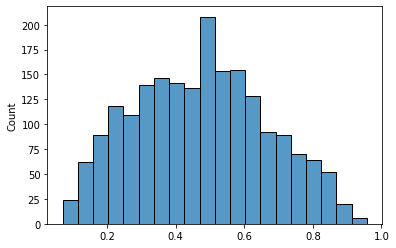

In [72]:
import seaborn as sns
clf = BaggingClassifier(RandomLGBM(LGBMClassifier(n_jobs=-1)), 2000, bootstrap_features=True).fit(X[df.Meta.cohort == 'c1'], y[df.Meta.cohort == 'c1'])
aucs = []
param_dists = []
for estimator in clf.estimators_:
    aucs.append(roc_auc_score(y[df.Meta.cohort == 'c2'], estimator.predict_proba(X[df.Meta.cohort == 'c2'])[:, 1]))
    for k, v in estimator.base_estimator.get_params().items():
        param_dists.append({'param': k, 'value': v, 'auc': aucs[-1]})
param_dists = pd.DataFrame(param_dists)
sns.histplot(aucs)
# for
# roc_auc_score(y[df.Meta.cohort == 'c2'], 
#                       .predict_proba(X[df.Meta.cohort == 'c2'])[:, 1])

In [17]:
param_dists[param_dists.value.apply(lambda x: isinstance(x, float) or isinstance(x, int))]

param      value       auc
2     colsample_bytree        1.0  0.588390
4        learning_rate   0.046988  0.588390
5            max_depth          3  0.588390
6    min_child_samples         20  0.588390
7     min_child_weight      0.001  0.588390
..                 ...        ...       ...
226   min_data_in_leaf         80  0.321255
230          lambda_l1  23.644294  0.321255
231          lambda_l2        0.0  0.321255
232  min_gain_to_split   0.010906  0.321255
233        path_smooth   0.034704  0.321255

[178 rows x 3 columns]

In [266]:
param_dists[param_dists.value.apply(lambda x: isinstance(x, float) or isinstance(x, int))].sample(frac=0.1)

param    value       auc
188              n_jobs       -1  0.540585
1137   min_data_in_leaf       47  0.711937
969    colsample_bytree      1.0  0.596997
690          reg_lambda      0.0  0.396688
128              n_jobs       -1  0.322430
...                 ...      ...       ...
335              n_jobs       -1  0.453677
360   min_child_samples       20  0.630420
1329   min_child_weight    0.001  0.484251
1430     subsample_freq        0  0.725838
403    feature_fraction  0.07949  0.687794

[112 rows x 3 columns]

In [73]:
param_dists_smol = param_dists[param_dists.value.apply(lambda x: isinstance(x, float) or isinstance(x, int))]
param_dists_smol = param_dists_smol[~param_dists_smol.param.isin(['random_state', 'subsample_for_bin'])]
param_dists_smol['value'] = pd.to_numeric(param_dists_smol['value'])
param_dists_smol

param         value       auc
2       colsample_bytree  1.000000e+00  0.597382
4          learning_rate  3.010154e-01  0.597382
5              max_depth  1.400000e+01  0.597382
6      min_child_samples  2.000000e+01  0.597382
7       min_child_weight  1.000000e-03  0.597382
...                  ...           ...       ...
58961          lambda_l2  1.001734e-04  0.344051
58962  min_gain_to_split  2.874799e-05  0.344051
58963       bagging_freq  1.300000e+01  0.344051
58964   bagging_fraction  7.644618e-01  0.344051
58965        path_smooth  6.499574e-11  0.344051

[40966 rows x 3 columns]

In [48]:
param_dists_smol.set_index('param').value.max(), param_dists_smol[param_dists_smol.param == 'colsample_bytree'].value.max()

(277.0, 1.0)

In [77]:
param_dists_smol['is_shit'] = param_dists_smol.auc < 0.9

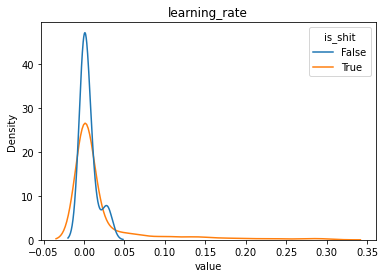

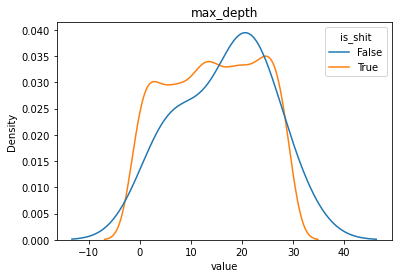

Dataset has 0 variance; skipping density estimate.


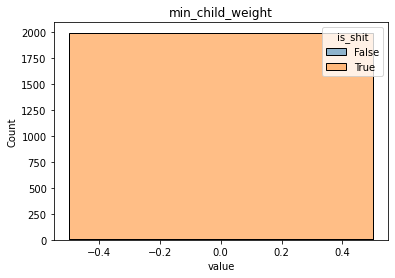

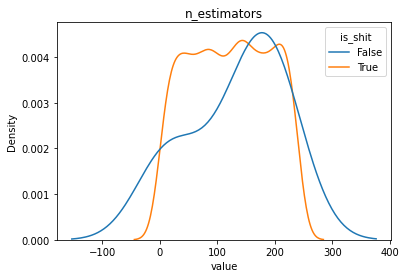

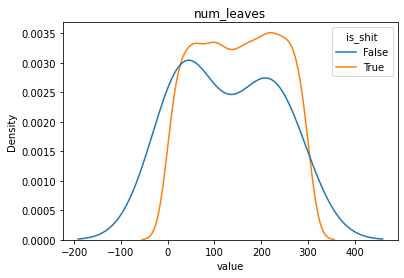

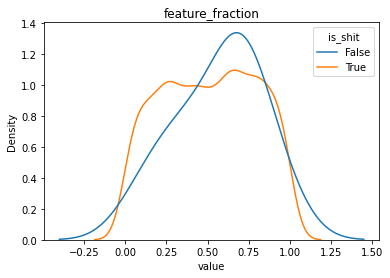

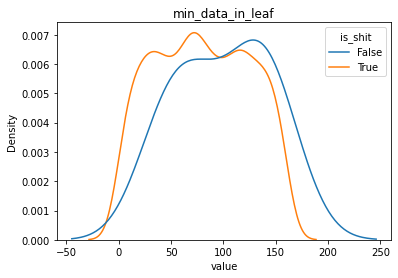

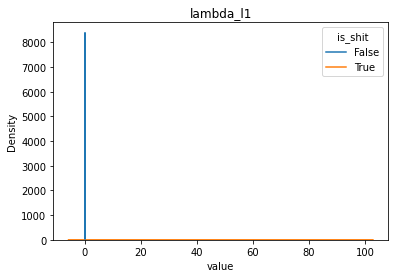

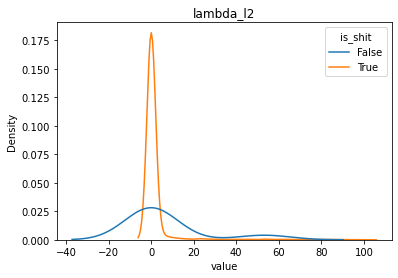

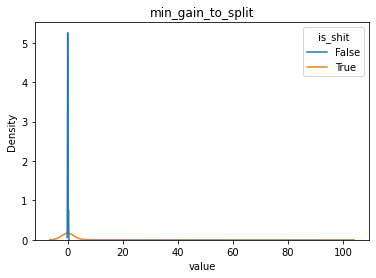

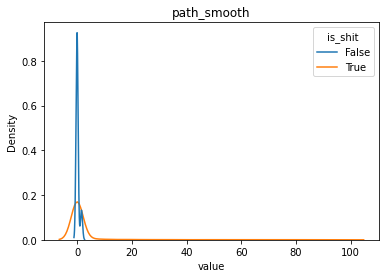

Dataset has 0 variance; skipping density estimate.


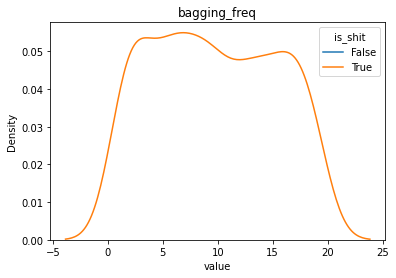

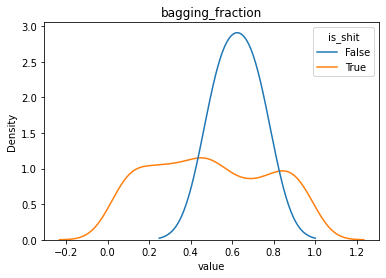

In [78]:
import matplotlib.pyplot as plt
for param in param_dists_smol.param.unique():
    if np.var(param_dists_smol[param_dists_smol.param == param].value) > 0:
        try:
            sns.kdeplot(data=param_dists_smol[param_dists_smol.param == param], x='value', hue='is_shit', common_norm=False)
        except:
            sns.histplot(data=param_dists_smol[param_dists_smol.param == param], x='value', hue='is_shit')
        plt.title(param)
        plt.show()
            

In [79]:
param_dists_smol[(param_dists_smol.param == 'bagging_freq') & ~param_dists_smol.is_shit]

param  value       auc  is_shit
2419   bagging_freq   10.0  0.957836    False
42543  bagging_freq   10.0  0.902830    False

In [227]:
from sklearn.ensemble import BaggingClassifier
X, y = preprocess(df.Input.Clinical, df.Target.pcr)
ns = list(reversed([5, 10, 100, 200]))
result = []
for n in tqdm(ns):
    for i in range(4):
        result.append({'n': n, 'bootstrap_features': False, 'auc': roc_auc_score(y[df.Meta.cohort == 'c2'], BaggingClassifier(RandomLGBM(LGBMClassifier(n_jobs=-1)), n, bootstrap_features=False)
                      .fit(X[df.Meta.cohort == 'c1'], y[df.Meta.cohort == 'c1'])
                      .predict_proba(X[df.Meta.cohort == 'c2'])[:, 1])})
        result.append({'n': n, 'bootstrap_features': True, 'auc': roc_auc_score(y[df.Meta.cohort == 'c2'], BaggingClassifier(RandomLGBM(LGBMClassifier(n_jobs=-1)), n, bootstrap_features=True)
                  .fit(X[df.Meta.cohort == 'c1'], y[df.Meta.cohort == 'c1'])
                  .predict_proba(X[df.Meta.cohort == 'c2'])[:, 1])})
result = pd.DataFrame(result)
result

  0%|                                                                     | 0/4 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.09925443556197777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09925443556197777
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] bagging_fraction is set=0.2137995950857623, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2137995950857623
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6817986980394258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6817986980394258
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] feature_fraction is set=0.8873221531267711, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8873221531267711
[LightGBM] [Warning] min_data_in_leaf

 25%|███████████████                                             | 1/4 [02:19<06:57, 139.05s/it]

[LightGBM] [Warning] feature_fraction is set=0.6651653697627339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6651653697627339
[LightGBM] [Warning] min_data_in_leaf is set=135, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=135
[LightGBM] [Warning] bagging_fraction is set=0.9204964393546684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9204964393546684
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.3273530788224508, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3273530788224508
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] bagging_fraction is set=0.5860268306253542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5860268306253542
[LightGBM] [Warning] bagging_freq is set=4, 

 50%|██████████████████████████████▌                              | 2/4 [03:22<03:08, 94.31s/it]

[LightGBM] [Warning] feature_fraction is set=0.14350132128172166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14350132128172166
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] bagging_fraction is set=0.7985035237940354, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7985035237940354
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.7247693675220033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7247693675220033
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] bagging_fraction is set=0.9337731268657924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9337731268657924
[LightGBM] [Warning] bagging_freq is set=1

 75%|█████████████████████████████████████████████▊               | 3/4 [03:29<00:54, 54.43s/it]

[LightGBM] [Warning] feature_fraction is set=0.8737409700498012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8737409700498012
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] bagging_fraction is set=0.09493086743553214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.09493086743553214
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] feature_fraction is set=0.47945035241990575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47945035241990575
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.3976416531385479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3976416531385479
[LightGBM] [Warning] bagging_freq is set

100%|█████████████████████████████████████████████████████████████| 4/4 [03:32<00:00, 53.11s/it]


n  bootstrap_features       auc
0   200               False  0.957643
1   200                True  0.961186
2   200               False  0.957605
3   200                True  0.955718
4   200               False  0.956835
5   200                True  0.961224
6   200               False  0.958067
7   200                True  0.957335
8   100               False  0.954293
9   100                True  0.956257
10  100               False  0.951714
11  100                True  0.956604
12  100               False  0.951983
13  100                True  0.955795
14  100               False  0.956026
15  100                True  0.959376
16   10               False  0.956219
17   10                True  0.960647
18   10               False  0.949442
19   10                True  0.940893
20   10               False  0.895418
21   10                True  0.952561
22   10               False  0.956912
23   10                True  0.961879
24    5               False  0.944243
25    5                True  0.960570
26    5               False  0.924721
27    5                True  0.898383
28    5               False  0.935618
29    5                True  0.948209
30    5               False  0.959184
31    5                True  0.867732

<AxesSubplot:xlabel='n', ylabel='auc'>

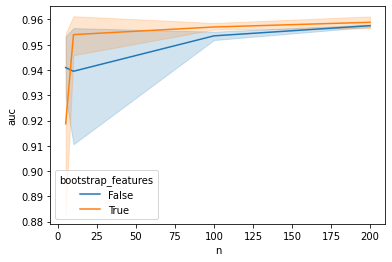

In [228]:
sns.lineplot(data=result, x='n', y='auc', hue='bootstrap_features')

In [195]:
from optuna.integration.sklearn import OptunaSearchCV
from optuna.distributions import UniformDistribution, IntUniformDistribution, CategoricalDistribution
dist = {
    'n_estimators': IntUniformDistribution(50, 150), 
    'boosting_type': CategoricalDistribution(['gbdt', 'dart', 'goss']), 
    'num_leaves': IntUniformDistribution(2, 100), 
    'min_data_in_leaf': IntUniformDistribution(1, 60), 
    'max_depth': IntUniformDistribution(-1, 30)
}
X, y = preprocess(df.Input.Clinical, df.Target.pcr)
roc_auc_score(y[df.Meta.cohort == 'c2'], BaggingClassifier(OptunaSearchCV(LGBMClassifier(n_jobs=-1), dist, n_trials=18, scoring='roc_auc'), 50)
              .fit(X[df.Meta.cohort == 'c1'], y[df.Meta.cohort == 'c1'])
              .predict_proba(X[df.Meta.cohort == 'c2'])[:, 1])

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:17:35,919] A new study created in memory with name: no-name-31c7ab3b-b138-4e75-871e-3abcac47f737


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


[I 2021-08-13 20:17:37,163] Trial 0 finished with value: 0.9456171881048302 and parameters: {'n_estimators': 127, 'boosting_type': 'gbdt', 'num_leaves': 24, 'min_data_in_leaf': 12, 'max_depth': 30}. Best is trial 0 with value: 0.9456171881048302.


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54


[I 2021-08-13 20:17:37,530] Trial 1 finished with value: 0.8846329733262859 and parameters: {'n_estimators': 130, 'boosting_type': 'goss', 'num_leaves': 52, 'min_data_in_leaf': 54, 'max_depth': 21}. Best is trial 0 with value: 0.9456171881048302.


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2021-08-13 20:17:38,085] Trial 2 finished with value: 0.8840611157925432 and parameters: {'n_estimators': 121, 'boosting_type': 'dart', 'num_leaves': 6, 'min_data_in_leaf': 23, 'max_depth': 8}. Best is trial 0 with value: 0.9456171881048302.


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51


[I 2021-08-13 20:17:38,466] Trial 3 finished with value: 0.8898497503825069 and parameters: {'n_estimators': 133, 'boosting_type': 'goss', 'num_leaves': 38, 'min_data_in_leaf': 51, 'max_depth': 5}. Best is trial 0 with value: 0.9456171881048302.


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:17:43,511] Trial 4 finished with value: 0.9410795125484913 and parameters: {'n_estimators': 145, 'boosting_type': 'dart', 'num_leaves': 97, 'min_data_in_leaf': 2, 'max_depth': 10}. Best is trial 0 with value: 0.9456171881048302.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2021-08-13 20:17:44,219] Trial 5 finished with value: 0.9395290996976712 and parameters: {'n_estimators': 114, 'boosting_type': 'gbdt', 'num_leaves': 19, 'min_data_in_leaf': 20, 'max_depth': 7}. Best is trial 0 with value: 0.9456171881048302.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2021-08-13 20:17:44,463] Trial 6 finished with value: 0.8821881343025584 and parameters: {'n_estimators': 57, 'boosting_type': 'goss', 'num_leaves': 37, 'min_data_in_leaf': 33, 'max_depth': 4}. Best is trial 0 with value: 0.9456171881048302.


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


[I 2021-08-13 20:17:45,063] Trial 7 finished with value: 0.9286593202259457 and parameters: {'n_estimators': 108, 'boosting_type': 'gbdt', 'num_leaves': 42, 'min_data_in_leaf': 50, 'max_depth': 17}. Best is trial 0 with value: 0.9456171881048302.


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60

[I 2021-08-13 20:17:45,555] Trial 8 finished with value: 0.9062199840429812 and parameters: {'n_estimators': 91, 'boosting_type': 'dart', 'num_leaves': 19, 'min_data_in_leaf': 60, 'max_depth': 19}. Best is trial 0 with value: 0.9456171881048302.



[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


[I 2021-08-13 20:17:47,913] Trial 9 finished with value: 0.9428993401107905 and parameters: {'n_estimators': 117, 'boosting_type': 'dart', 'num_leaves': 70, 'min_data_in_leaf': 12, 'max_depth': 16}. Best is trial 0 with value: 0.9456171881048302.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


[I 2021-08-13 20:17:49,949] Trial 10 finished with value: 0.95257232737327 and parameters: {'n_estimators': 85, 'boosting_type': 'gbdt', 'num_leaves': 68, 'min_data_in_leaf': 4, 'max_depth': 30}. Best is trial 10 with value: 0.95257232737327.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:17:52,226] Trial 11 finished with value: 0.9513495803920182 and parameters: {'n_estimators': 83, 'boosting_type': 'gbdt', 'num_leaves': 72, 'min_data_in_leaf': 2, 'max_depth': 30}. Best is trial 10 with value: 0.95257232737327.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:17:54,673] Trial 12 finished with value: 0.9476957232588271 and parameters: {'n_estimators': 83, 'boosting_type': 'gbdt', 'num_leaves': 77, 'min_data_in_leaf': 1, 'max_depth': 30}. Best is trial 10 with value: 0.95257232737327.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:17:56,923] Trial 13 finished with value: 0.944210185391035 and parameters: {'n_estimators': 72, 'boosting_type': 'gbdt', 'num_leaves': 76, 'min_data_in_leaf': 1, 'max_depth': 25}. Best is trial 10 with value: 0.95257232737327.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2021-08-13 20:17:58,643] Trial 14 finished with value: 0.9493128980842093 and parameters: {'n_estimators': 66, 'boosting_type': 'gbdt', 'num_leaves': 97, 'min_data_in_leaf': 9, 'max_depth': 25}. Best is trial 10 with value: 0.95257232737327.


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


[I 2021-08-13 20:17:59,271] Trial 15 finished with value: 0.9304444676508575 and parameters: {'n_estimators': 97, 'boosting_type': 'gbdt', 'num_leaves': 62, 'min_data_in_leaf': 38, 'max_depth': -1}. Best is trial 10 with value: 0.95257232737327.


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2021-08-13 20:18:00,248] Trial 16 finished with value: 0.9420787605432721 and parameters: {'n_estimators': 81, 'boosting_type': 'gbdt', 'num_leaves': 82, 'min_data_in_leaf': 21, 'max_depth': 26}. Best is trial 10 with value: 0.95257232737327.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


[I 2021-08-13 20:18:01,791] Trial 17 finished with value: 0.9434036486142354 and parameters: {'n_estimators': 53, 'boosting_type': 'gbdt', 'num_leaves': 89, 'min_data_in_leaf': 7, 'max_depth': 30}. Best is trial 10 with value: 0.95257232737327.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:18:02,206] A new study created in memory with name: no-name-a7cb6409-b03c-4b81-a135-46e3c4605de0


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2021-08-13 20:18:04,399] Trial 0 finished with value: 0.9489291730231375 and parameters: {'n_estimators': 138, 'boosting_type': 'dart', 'num_leaves': 39, 'min_data_in_leaf': 9, 'max_depth': 15}. Best is trial 0 with value: 0.9489291730231375.


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38

[I 2021-08-13 20:18:04,736] Trial 1 finished with value: 0.9109148224898342 and parameters: {'n_estimators': 90, 'boosting_type': 'goss', 'num_leaves': 68, 'min_data_in_leaf': 38, 'max_depth': 17}. Best is trial 0 with value: 0.9489291730231375.



[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


[I 2021-08-13 20:18:05,444] Trial 2 finished with value: 0.9337762307316618 and parameters: {'n_estimators': 133, 'boosting_type': 'gbdt', 'num_leaves': 26, 'min_data_in_leaf': 47, 'max_depth': 29}. Best is trial 0 with value: 0.9489291730231375.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2021-08-13 20:18:07,064] Trial 3 finished with value: 0.9426914944017326 and parameters: {'n_estimators': 79, 'boosting_type': 'dart', 'num_leaves': 61, 'min_data_in_leaf': 10, 'max_depth': 29}. Best is trial 0 with value: 0.9489291730231375.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2021-08-13 20:18:07,564] Trial 4 finished with value: 0.935006283302877 and parameters: {'n_estimators': 68, 'boosting_type': 'gbdt', 'num_leaves': 17, 'min_data_in_leaf': 22, 'max_depth': 17}. Best is trial 0 with value: 0.9489291730231375.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


[I 2021-08-13 20:18:07,906] Trial 5 finished with value: 0.8932474106527135 and parameters: {'n_estimators': 144, 'boosting_type': 'goss', 'num_leaves': 45, 'min_data_in_leaf': 60, 'max_depth': 10}. Best is trial 0 with value: 0.9489291730231375.
[I 2021-08-13 20:18:08,071] Trial 6 finished with value: 0.8571681241962953 and parameters: {'n_estimators': 59, 'boosting_type': 'gbdt', 'num_leaves': 91, 'min_data_in_leaf': 40, 'max_depth': 2}. Best is trial 0 with value: 0.9489291730231375.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min

[I 2021-08-13 20:18:09,162] Trial 7 finished with value: 0.9486188789243204 and parameters: {'n_estimators': 137, 'boosting_type': 'gbdt', 'num_leaves': 97, 'min_data_in_leaf': 26, 'max_depth': 10}. Best is trial 0 with value: 0.9489291730231375.


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34

[I 2021-08-13 20:18:09,647] Trial 8 finished with value: 0.927728732345931 and parameters: {'n_estimators': 90, 'boosting_type': 'gbdt', 'num_leaves': 12, 'min_data_in_leaf': 34, 'max_depth': 16}. Best is trial 0 with value: 0.9489291730231375.



[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


[I 2021-08-13 20:18:11,019] Trial 9 finished with value: 0.9392247043326438 and parameters: {'n_estimators': 148, 'boosting_type': 'dart', 'num_leaves': 54, 'min_data_in_leaf': 15, 'max_depth': 6}. Best is trial 0 with value: 0.9489291730231375.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:18:12,974] Trial 10 finished with value: 0.9441478241891614 and parameters: {'n_estimators': 116, 'boosting_type': 'dart', 'num_leaves': 33, 'min_data_in_leaf': 2, 'max_depth': 23}. Best is trial 0 with value: 0.9489291730231375.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2021-08-13 20:18:14,321] Trial 11 finished with value: 0.9377574833725697 and parameters: {'n_estimators': 120, 'boosting_type': 'dart', 'num_leaves': 99, 'min_data_in_leaf': 24, 'max_depth': 10}. Best is trial 0 with value: 0.9489291730231375.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:18:18,690] Trial 12 finished with value: 0.9268164930298324 and parameters: {'n_estimators': 129, 'boosting_type': 'dart', 'num_leaves': 83, 'min_data_in_leaf': 1, 'max_depth': 11}. Best is trial 0 with value: 0.9489291730231375.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2021-08-13 20:18:20,192] Trial 13 finished with value: 0.9547709206776457 and parameters: {'n_estimators': 109, 'boosting_type': 'gbdt', 'num_leaves': 39, 'min_data_in_leaf': 10, 'max_depth': 0}. Best is trial 13 with value: 0.9547709206776457.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2021-08-13 20:18:21,837] Trial 14 finished with value: 0.9407107403322195 and parameters: {'n_estimators': 99, 'boosting_type': 'dart', 'num_leaves': 40, 'min_data_in_leaf': 10, 'max_depth': -1}. Best is trial 13 with value: 0.9547709206776457.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


[I 2021-08-13 20:18:22,112] Trial 15 finished with value: 0.8641507257580662 and parameters: {'n_estimators': 111, 'boosting_type': 'goss', 'num_leaves': 3, 'min_data_in_leaf': 14, 'max_depth': 22}. Best is trial 13 with value: 0.9547709206776457.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


[I 2021-08-13 20:18:22,843] Trial 16 finished with value: 0.9420986437394706 and parameters: {'n_estimators': 106, 'boosting_type': 'gbdt', 'num_leaves': 31, 'min_data_in_leaf': 4, 'max_depth': 5}. Best is trial 13 with value: 0.9547709206776457.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2021-08-13 20:18:24,662] Trial 17 finished with value: 0.9414192981998839 and parameters: {'n_estimators': 125, 'boosting_type': 'dart', 'num_leaves': 72, 'min_data_in_leaf': 20, 'max_depth': 22}. Best is trial 13 with value: 0.9547709206776457.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:18:24,989] A new study created in memory with name: no-name-a9354b68-dae5-4a04-8233-bb7f7014674f


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


[I 2021-08-13 20:18:25,401] Trial 0 finished with value: 0.8889740176681498 and parameters: {'n_estimators': 72, 'boosting_type': 'dart', 'num_leaves': 85, 'min_data_in_leaf': 60, 'max_depth': 9}. Best is trial 0 with value: 0.8889740176681498.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43


[I 2021-08-13 20:18:25,810] Trial 1 finished with value: 0.8879980988331726 and parameters: {'n_estimators': 124, 'boosting_type': 'goss', 'num_leaves': 18, 'min_data_in_leaf': 43, 'max_depth': 5}. Best is trial 0 with value: 0.8889740176681498.


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


[I 2021-08-13 20:18:26,276] Trial 2 finished with value: 0.8926474939241308 and parameters: {'n_estimators': 110, 'boosting_type': 'goss', 'num_leaves': 18, 'min_data_in_leaf': 35, 'max_depth': 14}. Best is trial 2 with value: 0.8926474939241308.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2021-08-13 20:18:26,835] Trial 3 finished with value: 0.9049854405915824 and parameters: {'n_estimators': 134, 'boosting_type': 'goss', 'num_leaves': 20, 'min_data_in_leaf': 23, 'max_depth': 9}. Best is trial 3 with value: 0.9049854405915824.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53


[I 2021-08-13 20:18:27,276] Trial 4 finished with value: 0.883373738204708 and parameters: {'n_estimators': 150, 'boosting_type': 'goss', 'num_leaves': 19, 'min_data_in_leaf': 53, 'max_depth': 12}. Best is trial 3 with value: 0.9049854405915824.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2021-08-13 20:18:29,120] Trial 5 finished with value: 0.9277132645740039 and parameters: {'n_estimators': 139, 'boosting_type': 'goss', 'num_leaves': 92, 'min_data_in_leaf': 5, 'max_depth': 11}. Best is trial 5 with value: 0.9277132645740039.


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57


[I 2021-08-13 20:18:29,385] Trial 6 finished with value: 0.8602192692745098 and parameters: {'n_estimators': 75, 'boosting_type': 'goss', 'num_leaves': 93, 'min_data_in_leaf': 57, 'max_depth': 19}. Best is trial 5 with value: 0.9277132645740039.


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2021-08-13 20:18:30,060] Trial 7 finished with value: 0.9127361832782238 and parameters: {'n_estimators': 79, 'boosting_type': 'dart', 'num_leaves': 68, 'min_data_in_leaf': 32, 'max_depth': 9}. Best is trial 5 with value: 0.9277132645740039.


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49

[I 2021-08-13 20:18:30,303] Trial 8 finished with value: 0.8638704130625999 and parameters: {'n_estimators': 53, 'boosting_type': 'goss', 'num_leaves': 40, 'min_data_in_leaf': 49, 'max_depth': 16}. Best is trial 5 with value: 0.9277132645740039.



[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2021-08-13 20:18:30,881] Trial 9 finished with value: 0.8963422574344658 and parameters: {'n_estimators': 112, 'boosting_type': 'dart', 'num_leaves': 27, 'min_data_in_leaf': 31, 'max_depth': 4}. Best is trial 5 with value: 0.9277132645740039.


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:18:33,734] Trial 10 finished with value: 0.9370539139598069 and parameters: {'n_estimators': 150, 'boosting_type': 'gbdt', 'num_leaves': 66, 'min_data_in_leaf': 1, 'max_depth': 27}. Best is trial 10 with value: 0.9370539139598069.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:18:36,585] Trial 11 finished with value: 0.938674905659376 and parameters: {'n_estimators': 150, 'boosting_type': 'gbdt', 'num_leaves': 67, 'min_data_in_leaf': 1, 'max_depth': 30}. Best is trial 11 with value: 0.938674905659376.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:18:39,342] Trial 12 finished with value: 0.9387322217198871 and parameters: {'n_estimators': 149, 'boosting_type': 'gbdt', 'num_leaves': 63, 'min_data_in_leaf': 1, 'max_depth': 28}. Best is trial 12 with value: 0.9387322217198871.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2021-08-13 20:18:41,733] Trial 13 finished with value: 0.9400000904685694 and parameters: {'n_estimators': 150, 'boosting_type': 'gbdt', 'num_leaves': 59, 'min_data_in_leaf': 13, 'max_depth': 28}. Best is trial 13 with value: 0.9400000904685694.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2021-08-13 20:18:43,650] Trial 14 finished with value: 0.9373408790553441 and parameters: {'n_estimators': 128, 'boosting_type': 'gbdt', 'num_leaves': 50, 'min_data_in_leaf': 13, 'max_depth': 24}. Best is trial 13 with value: 0.9400000904685694.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


[I 2021-08-13 20:18:45,468] Trial 15 finished with value: 0.9365380151340646 and parameters: {'n_estimators': 97, 'boosting_type': 'gbdt', 'num_leaves': 78, 'min_data_in_leaf': 12, 'max_depth': 22}. Best is trial 13 with value: 0.9400000904685694.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2021-08-13 20:18:47,228] Trial 16 finished with value: 0.9302242631395343 and parameters: {'n_estimators': 141, 'boosting_type': 'gbdt', 'num_leaves': 50, 'min_data_in_leaf': 18, 'max_depth': 30}. Best is trial 13 with value: 0.9400000904685694.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


[I 2021-08-13 20:18:48,834] Trial 17 finished with value: 0.9340060182104786 and parameters: {'n_estimators': 118, 'boosting_type': 'gbdt', 'num_leaves': 37, 'min_data_in_leaf': 8, 'max_depth': 26}. Best is trial 13 with value: 0.9400000904685694.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:18:49,379] A new study created in memory with name: no-name-84f7eb37-fe61-43af-9623-bd675a3cf933


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2021-08-13 20:18:50,017] Trial 0 finished with value: 0.9176747375096242 and parameters: {'n_estimators': 78, 'boosting_type': 'dart', 'num_leaves': 19, 'min_data_in_leaf': 24, 'max_depth': 15}. Best is trial 0 with value: 0.9176747375096242.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2021-08-13 20:18:50,792] Trial 1 finished with value: 0.9333207319922338 and parameters: {'n_estimators': 89, 'boosting_type': 'goss', 'num_leaves': 79, 'min_data_in_leaf': 11, 'max_depth': 19}. Best is trial 1 with value: 0.9333207319922338.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


[I 2021-08-13 20:18:51,519] Trial 2 finished with value: 0.9074548561438803 and parameters: {'n_estimators': 134, 'boosting_type': 'dart', 'num_leaves': 38, 'min_data_in_leaf': 60, 'max_depth': 30}. Best is trial 1 with value: 0.9333207319922338.


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39


[I 2021-08-13 20:18:51,785] Trial 3 finished with value: 0.8796721963334788 and parameters: {'n_estimators': 55, 'boosting_type': 'goss', 'num_leaves': 95, 'min_data_in_leaf': 39, 'max_depth': 11}. Best is trial 1 with value: 0.9333207319922338.


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2021-08-13 20:18:52,087] Trial 4 finished with value: 0.8675375421946876 and parameters: {'n_estimators': 140, 'boosting_type': 'gbdt', 'num_leaves': 57, 'min_data_in_leaf': 32, 'max_depth': 2}. Best is trial 1 with value: 0.9333207319922338.


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37


[I 2021-08-13 20:18:52,441] Trial 5 finished with value: 0.9094886746178166 and parameters: {'n_estimators': 50, 'boosting_type': 'gbdt', 'num_leaves': 89, 'min_data_in_leaf': 37, 'max_depth': 7}. Best is trial 1 with value: 0.9333207319922338.


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2021-08-13 20:18:53,453] Trial 6 finished with value: 0.9349602308234999 and parameters: {'n_estimators': 91, 'boosting_type': 'dart', 'num_leaves': 26, 'min_data_in_leaf': 11, 'max_depth': 28}. Best is trial 6 with value: 0.9349602308234999.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53


[I 2021-08-13 20:18:53,798] Trial 7 finished with value: 0.8772067864825083 and parameters: {'n_estimators': 123, 'boosting_type': 'goss', 'num_leaves': 12, 'min_data_in_leaf': 53, 'max_depth': 23}. Best is trial 6 with value: 0.9349602308234999.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54


[I 2021-08-13 20:18:54,153] Trial 8 finished with value: 0.8759158736041084 and parameters: {'n_estimators': 119, 'boosting_type': 'goss', 'num_leaves': 79, 'min_data_in_leaf': 54, 'max_depth': 24}. Best is trial 6 with value: 0.9349602308234999.


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28

[I 2021-08-13 20:18:54,375] Trial 9 finished with value: 0.8170558753764865 and parameters: {'n_estimators': 149, 'boosting_type': 'gbdt', 'num_leaves': 66, 'min_data_in_leaf': 28, 'max_depth': 1}. Best is trial 6 with value: 0.9349602308234999.



[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:18:55,715] Trial 10 finished with value: 0.9388306130012005 and parameters: {'n_estimators': 75, 'boosting_type': 'dart', 'num_leaves': 33, 'min_data_in_leaf': 1, 'max_depth': 28}. Best is trial 10 with value: 0.9388306130012005.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:18:56,940] Trial 11 finished with value: 0.9395243552398524 and parameters: {'n_estimators': 77, 'boosting_type': 'dart', 'num_leaves': 30, 'min_data_in_leaf': 1, 'max_depth': 30}. Best is trial 11 with value: 0.9395243552398524.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:18:58,306] Trial 12 finished with value: 0.9427589110922108 and parameters: {'n_estimators': 69, 'boosting_type': 'dart', 'num_leaves': 39, 'min_data_in_leaf': 1, 'max_depth': 29}. Best is trial 12 with value: 0.9427589110922108.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:18:59,682] Trial 13 finished with value: 0.9395942059342447 and parameters: {'n_estimators': 64, 'boosting_type': 'dart', 'num_leaves': 48, 'min_data_in_leaf': 2, 'max_depth': 30}. Best is trial 12 with value: 0.9427589110922108.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2021-08-13 20:19:00,768] Trial 14 finished with value: 0.936928923026992 and parameters: {'n_estimators': 61, 'boosting_type': 'dart', 'num_leaves': 47, 'min_data_in_leaf': 10, 'max_depth': 24}. Best is trial 12 with value: 0.9427589110922108.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2021-08-13 20:19:01,723] Trial 15 finished with value: 0.9320505064513419 and parameters: {'n_estimators': 66, 'boosting_type': 'dart', 'num_leaves': 51, 'min_data_in_leaf': 18, 'max_depth': 18}. Best is trial 12 with value: 0.9427589110922108.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:19:01,950] Trial 16 finished with value: 0.7994758795427265 and parameters: {'n_estimators': 105, 'boosting_type': 'dart', 'num_leaves': 2, 'min_data_in_leaf': 1, 'max_depth': 26}. Best is trial 12 with value: 0.9427589110922108.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


[I 2021-08-13 20:19:03,396] Trial 17 finished with value: 0.9374511560164762 and parameters: {'n_estimators': 64, 'boosting_type': 'dart', 'num_leaves': 61, 'min_data_in_leaf': 6, 'max_depth': 20}. Best is trial 12 with value: 0.9427589110922108.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:19:03,720] A new study created in memory with name: no-name-2a92caa3-6232-44c1-b79e-ca8c8250ff62
[I 2021-08-13 20:19:03,880] Trial 0 finished with value: 0.8137115294527785 and parameters: {'n_estimators': 86, 'boosting_type': 'gbdt', 'num_leaves': 25, 'min_data_in_leaf': 33, 'max_depth': 1}. Best is trial 0 with value: 0.8137115294527785.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


[I 2021-08-13 20:19:04,321] Trial 1 finished with value: 0.922074032312536 and parameters: {'n_estimators': 91, 'boosting_type': 'gbdt', 'num_leaves': 10, 'min_data_in_leaf': 40, 'max_depth': 24}. Best is trial 1 with value: 0.922074032312536.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2021-08-13 20:19:05,398] Trial 2 finished with value: 0.947295350306675 and parameters: {'n_estimators': 86, 'boosting_type': 'gbdt', 'num_leaves': 42, 'min_data_in_leaf': 18, 'max_depth': 16}. Best is trial 2 with value: 0.947295350306675.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2021-08-13 20:19:06,800] Trial 3 finished with value: 0.9488254022725539 and parameters: {'n_estimators': 116, 'boosting_type': 'gbdt', 'num_leaves': 31, 'min_data_in_leaf': 13, 'max_depth': 30}. Best is trial 3 with value: 0.9488254022725539.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2021-08-13 20:19:07,505] Trial 4 finished with value: 0.9377194114891438 and parameters: {'n_estimators': 78, 'boosting_type': 'gbdt', 'num_leaves': 52, 'min_data_in_leaf': 24, 'max_depth': 11}. Best is trial 3 with value: 0.9488254022725539.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51

[I 2021-08-13 20:19:07,830] Trial 5 finished with value: 0.8762146070965564 and parameters: {'n_estimators': 79, 'boosting_type': 'dart', 'num_leaves': 6, 'min_data_in_leaf': 51, 'max_depth': 19}. Best is trial 3 with value: 0.9488254022725539.



[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2021-08-13 20:19:09,387] Trial 6 finished with value: 0.9470752851586758 and parameters: {'n_estimators': 128, 'boosting_type': 'gbdt', 'num_leaves': 93, 'min_data_in_leaf': 19, 'max_depth': 15}. Best is trial 3 with value: 0.9488254022725539.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


[I 2021-08-13 20:19:09,691] Trial 7 finished with value: 0.8553521859441557 and parameters: {'n_estimators': 93, 'boosting_type': 'dart', 'num_leaves': 4, 'min_data_in_leaf': 47, 'max_depth': 24}. Best is trial 3 with value: 0.9488254022725539.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49


[I 2021-08-13 20:19:10,031] Trial 8 finished with value: 0.8900452386399538 and parameters: {'n_estimators': 97, 'boosting_type': 'goss', 'num_leaves': 98, 'min_data_in_leaf': 49, 'max_depth': 8}. Best is trial 3 with value: 0.9488254022725539.


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37


[I 2021-08-13 20:19:10,501] Trial 9 finished with value: 0.933933038097417 and parameters: {'n_estimators': 72, 'boosting_type': 'gbdt', 'num_leaves': 18, 'min_data_in_leaf': 37, 'max_depth': 11}. Best is trial 3 with value: 0.9488254022725539.


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


[I 2021-08-13 20:19:12,142] Trial 10 finished with value: 0.9506944308265517 and parameters: {'n_estimators': 130, 'boosting_type': 'goss', 'num_leaves': 67, 'min_data_in_leaf': 6, 'max_depth': 29}. Best is trial 10 with value: 0.9506944308265517.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:19:15,527] Trial 11 finished with value: 0.9456568726781492 and parameters: {'n_estimators': 128, 'boosting_type': 'goss', 'num_leaves': 72, 'min_data_in_leaf': 1, 'max_depth': 29}. Best is trial 10 with value: 0.9506944308265517.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


[I 2021-08-13 20:19:18,151] Trial 12 finished with value: 0.9493158915362073 and parameters: {'n_estimators': 149, 'boosting_type': 'goss', 'num_leaves': 66, 'min_data_in_leaf': 3, 'max_depth': 29}. Best is trial 10 with value: 0.9506944308265517.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


[I 2021-08-13 20:19:21,076] Trial 13 finished with value: 0.9481395507184802 and parameters: {'n_estimators': 149, 'boosting_type': 'goss', 'num_leaves': 71, 'min_data_in_leaf': 3, 'max_depth': 25}. Best is trial 10 with value: 0.9506944308265517.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


[I 2021-08-13 20:19:22,985] Trial 14 finished with value: 0.9466868483838283 and parameters: {'n_estimators': 148, 'boosting_type': 'goss', 'num_leaves': 70, 'min_data_in_leaf': 7, 'max_depth': 30}. Best is trial 10 with value: 0.9506944308265517.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


[I 2021-08-13 20:19:23,366] Trial 15 finished with value: 0.8929024087328823 and parameters: {'n_estimators': 134, 'boosting_type': 'goss', 'num_leaves': 56, 'min_data_in_leaf': 60, 'max_depth': 21}. Best is trial 10 with value: 0.9506944308265517.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2021-08-13 20:19:24,535] Trial 16 finished with value: 0.9403500615528755 and parameters: {'n_estimators': 112, 'boosting_type': 'goss', 'num_leaves': 84, 'min_data_in_leaf': 9, 'max_depth': 27}. Best is trial 10 with value: 0.9506944308265517.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:19:25,776] Trial 17 finished with value: 0.9393748025405542 and parameters: {'n_estimators': 51, 'boosting_type': 'goss', 'num_leaves': 61, 'min_data_in_leaf': 1, 'max_depth': 20}. Best is trial 10 with value: 0.9506944308265517.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:19:26,198] A new study created in memory with name: no-name-4a13b9ee-a1e0-46a8-b4d6-19db35f1d803


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2021-08-13 20:19:26,677] Trial 0 finished with value: 0.9247311827956988 and parameters: {'n_estimators': 52, 'boosting_type': 'dart', 'num_leaves': 42, 'min_data_in_leaf': 32, 'max_depth': 14}. Best is trial 0 with value: 0.9247311827956988.


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2021-08-13 20:19:27,279] Trial 1 finished with value: 0.9277587127278274 and parameters: {'n_estimators': 147, 'boosting_type': 'goss', 'num_leaves': 44, 'min_data_in_leaf': 31, 'max_depth': 18}. Best is trial 1 with value: 0.9277587127278274.


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2021-08-13 20:19:27,728] Trial 2 finished with value: 0.9219858156028369 and parameters: {'n_estimators': 127, 'boosting_type': 'goss', 'num_leaves': 55, 'min_data_in_leaf': 33, 'max_depth': 5}. Best is trial 1 with value: 0.9277587127278274.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


[I 2021-08-13 20:19:28,437] Trial 3 finished with value: 0.926241134751773 and parameters: {'n_estimators': 119, 'boosting_type': 'dart', 'num_leaves': 95, 'min_data_in_leaf': 60, 'max_depth': 0}. Best is trial 1 with value: 0.9277587127278274.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


[I 2021-08-13 20:19:29,554] Trial 4 finished with value: 0.9517196675055288 and parameters: {'n_estimators': 61, 'boosting_type': 'gbdt', 'num_leaves': 56, 'min_data_in_leaf': 12, 'max_depth': 13}. Best is trial 4 with value: 0.9517196675055288.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2021-08-13 20:19:30,697] Trial 5 finished with value: 0.9434606878670022 and parameters: {'n_estimators': 131, 'boosting_type': 'dart', 'num_leaves': 38, 'min_data_in_leaf': 33, 'max_depth': 16}. Best is trial 4 with value: 0.9517196675055288.


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51


[I 2021-08-13 20:19:31,298] Trial 6 finished with value: 0.9207046442461679 and parameters: {'n_estimators': 122, 'boosting_type': 'dart', 'num_leaves': 9, 'min_data_in_leaf': 51, 'max_depth': 16}. Best is trial 4 with value: 0.9517196675055288.


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2021-08-13 20:19:31,592] Trial 7 finished with value: 0.916190040417906 and parameters: {'n_estimators': 85, 'boosting_type': 'gbdt', 'num_leaves': 40, 'min_data_in_leaf': 22, 'max_depth': 3}. Best is trial 4 with value: 0.9517196675055288.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2021-08-13 20:19:32,373] Trial 8 finished with value: 0.9352779684282775 and parameters: {'n_estimators': 53, 'boosting_type': 'dart', 'num_leaves': 60, 'min_data_in_leaf': 19, 'max_depth': 24}. Best is trial 4 with value: 0.9517196675055288.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18

[I 2021-08-13 20:19:33,239] Trial 9 finished with value: 0.9465110958590712 and parameters: {'n_estimators': 139, 'boosting_type': 'gbdt', 'num_leaves': 48, 'min_data_in_leaf': 18, 'max_depth': 6}. Best is trial 4 with value: 0.9517196675055288.



[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


[I 2021-08-13 20:19:35,311] Trial 10 finished with value: 0.9570655075116296 and parameters: {'n_estimators': 76, 'boosting_type': 'gbdt', 'num_leaves': 83, 'min_data_in_leaf': 3, 'max_depth': 29}. Best is trial 10 with value: 0.9570655075116296.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:19:37,835] Trial 11 finished with value: 0.9483108365743919 and parameters: {'n_estimators': 79, 'boosting_type': 'gbdt', 'num_leaves': 86, 'min_data_in_leaf': 1, 'max_depth': 29}. Best is trial 10 with value: 0.9570655075116296.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:19:39,669] Trial 12 finished with value: 0.948448104934035 and parameters: {'n_estimators': 70, 'boosting_type': 'gbdt', 'num_leaves': 74, 'min_data_in_leaf': 1, 'max_depth': 10}. Best is trial 10 with value: 0.9570655075116296.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2021-08-13 20:19:41,494] Trial 13 finished with value: 0.9626401281171356 and parameters: {'n_estimators': 96, 'boosting_type': 'gbdt', 'num_leaves': 75, 'min_data_in_leaf': 9, 'max_depth': 23}. Best is trial 13 with value: 0.9626401281171356.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


[I 2021-08-13 20:19:43,747] Trial 14 finished with value: 0.959604972165027 and parameters: {'n_estimators': 102, 'boosting_type': 'gbdt', 'num_leaves': 81, 'min_data_in_leaf': 7, 'max_depth': 30}. Best is trial 13 with value: 0.9626401281171356.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2021-08-13 20:19:45,580] Trial 15 finished with value: 0.9595897201250667 and parameters: {'n_estimators': 99, 'boosting_type': 'gbdt', 'num_leaves': 71, 'min_data_in_leaf': 10, 'max_depth': 23}. Best is trial 13 with value: 0.9626401281171356.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


[I 2021-08-13 20:19:46,173] Trial 16 finished with value: 0.9455197132616486 and parameters: {'n_estimators': 107, 'boosting_type': 'gbdt', 'num_leaves': 95, 'min_data_in_leaf': 44, 'max_depth': 25}. Best is trial 13 with value: 0.9626401281171356.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2021-08-13 20:19:46,984] Trial 17 finished with value: 0.9450392740028979 and parameters: {'n_estimators': 95, 'boosting_type': 'goss', 'num_leaves': 70, 'min_data_in_leaf': 9, 'max_depth': 21}. Best is trial 13 with value: 0.9626401281171356.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:19:47,371] A new study created in memory with name: no-name-8e47442a-85d6-406c-86fb-aadae2bf8df6


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


[I 2021-08-13 20:19:47,986] Trial 0 finished with value: 0.9167483941908259 and parameters: {'n_estimators': 111, 'boosting_type': 'dart', 'num_leaves': 70, 'min_data_in_leaf': 59, 'max_depth': 10}. Best is trial 0 with value: 0.9167483941908259.


[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41

[I 2021-08-13 20:19:48,480] Trial 1 finished with value: 0.9139225513182131 and parameters: {'n_estimators': 144, 'boosting_type': 'goss', 'num_leaves': 71, 'min_data_in_leaf': 41, 'max_depth': 30}. Best is trial 0 with value: 0.9167483941908259.



[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


[I 2021-08-13 20:19:48,985] Trial 2 finished with value: 0.9357787271327103 and parameters: {'n_estimators': 98, 'boosting_type': 'gbdt', 'num_leaves': 69, 'min_data_in_leaf': 47, 'max_depth': 15}. Best is trial 2 with value: 0.9357787271327103.


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46


[I 2021-08-13 20:19:49,520] Trial 3 finished with value: 0.9387454338588626 and parameters: {'n_estimators': 96, 'boosting_type': 'gbdt', 'num_leaves': 95, 'min_data_in_leaf': 46, 'max_depth': 24}. Best is trial 3 with value: 0.9387454338588626.


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:19:49,880] Trial 4 finished with value: 0.9121390633488634 and parameters: {'n_estimators': 57, 'boosting_type': 'dart', 'num_leaves': 41, 'min_data_in_leaf': 2, 'max_depth': 4}. Best is trial 3 with value: 0.9387454338588626.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:19:50,799] Trial 5 finished with value: 0.9305165501466105 and parameters: {'n_estimators': 148, 'boosting_type': 'dart', 'num_leaves': 60, 'min_data_in_leaf': 2, 'max_depth': 4}. Best is trial 3 with value: 0.9387454338588626.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:19:54,500] Trial 6 finished with value: 0.9434510046425102 and parameters: {'n_estimators': 117, 'boosting_type': 'goss', 'num_leaves': 94, 'min_data_in_leaf': 1, 'max_depth': 20}. Best is trial 6 with value: 0.9434510046425102.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2021-08-13 20:19:55,101] Trial 7 finished with value: 0.9294994233446197 and parameters: {'n_estimators': 102, 'boosting_type': 'goss', 'num_leaves': 88, 'min_data_in_leaf': 18, 'max_depth': 14}. Best is trial 6 with value: 0.9434510046425102.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2021-08-13 20:19:55,844] Trial 8 finished with value: 0.9379837674482839 and parameters: {'n_estimators': 91, 'boosting_type': 'dart', 'num_leaves': 72, 'min_data_in_leaf': 31, 'max_depth': 28}. Best is trial 6 with value: 0.9434510046425102.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2021-08-13 20:19:56,616] Trial 9 finished with value: 0.9360644076272162 and parameters: {'n_estimators': 98, 'boosting_type': 'dart', 'num_leaves': 17, 'min_data_in_leaf': 30, 'max_depth': 20}. Best is trial 6 with value: 0.9434510046425102.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


[I 2021-08-13 20:19:57,301] Trial 10 finished with value: 0.9386483627743114 and parameters: {'n_estimators': 126, 'boosting_type': 'goss', 'num_leaves': 35, 'min_data_in_leaf': 14, 'max_depth': 20}. Best is trial 6 with value: 0.9434510046425102.


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


[I 2021-08-13 20:19:57,687] Trial 11 finished with value: 0.9294787202274793 and parameters: {'n_estimators': 74, 'boosting_type': 'gbdt', 'num_leaves': 99, 'min_data_in_leaf': 59, 'max_depth': 25}. Best is trial 6 with value: 0.9434510046425102.


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48


[I 2021-08-13 20:19:58,316] Trial 12 finished with value: 0.9379313963017231 and parameters: {'n_estimators': 124, 'boosting_type': 'gbdt', 'num_leaves': 100, 'min_data_in_leaf': 48, 'max_depth': 22}. Best is trial 6 with value: 0.9434510046425102.


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35

[I 2021-08-13 20:19:58,828] Trial 13 finished with value: 0.9409646590507915 and parameters: {'n_estimators': 75, 'boosting_type': 'gbdt', 'num_leaves': 88, 'min_data_in_leaf': 35, 'max_depth': 16}. Best is trial 6 with value: 0.9434510046425102.



[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2021-08-13 20:19:59,189] Trial 14 finished with value: 0.9177395823615708 and parameters: {'n_estimators': 70, 'boosting_type': 'goss', 'num_leaves': 85, 'min_data_in_leaf': 29, 'max_depth': 15}. Best is trial 6 with value: 0.9434510046425102.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


[I 2021-08-13 20:20:00,101] Trial 15 finished with value: 0.9527081990014397 and parameters: {'n_estimators': 77, 'boosting_type': 'gbdt', 'num_leaves': 83, 'min_data_in_leaf': 17, 'max_depth': 11}. Best is trial 15 with value: 0.9527081990014397.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2021-08-13 20:20:00,936] Trial 16 finished with value: 0.9437460500706987 and parameters: {'n_estimators': 130, 'boosting_type': 'goss', 'num_leaves': 53, 'min_data_in_leaf': 13, 'max_depth': 10}. Best is trial 15 with value: 0.9527081990014397.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2021-08-13 20:20:01,184] Trial 17 finished with value: 0.8341409109554462 and parameters: {'n_estimators': 136, 'boosting_type': 'goss', 'num_leaves': 2, 'min_data_in_leaf': 13, 'max_depth': 9}. Best is trial 15 with value: 0.9527081990014397.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:20:01,399] A new study created in memory with name: no-name-36bb3f11-d95f-44e4-99ad-93962a0b02f0


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2021-08-13 20:20:02,792] Trial 0 finished with value: 0.9563924567768083 and parameters: {'n_estimators': 147, 'boosting_type': 'gbdt', 'num_leaves': 71, 'min_data_in_leaf': 21, 'max_depth': 15}. Best is trial 0 with value: 0.9563924567768083.


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42


[I 2021-08-13 20:20:03,172] Trial 1 finished with value: 0.9006383523439118 and parameters: {'n_estimators': 103, 'boosting_type': 'dart', 'num_leaves': 7, 'min_data_in_leaf': 42, 'max_depth': 15}. Best is trial 0 with value: 0.9563924567768083.


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2021-08-13 20:20:04,535] Trial 2 finished with value: 0.9490636881611486 and parameters: {'n_estimators': 131, 'boosting_type': 'dart', 'num_leaves': 51, 'min_data_in_leaf': 22, 'max_depth': 9}. Best is trial 0 with value: 0.9563924567768083.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2021-08-13 20:20:05,447] Trial 3 finished with value: 0.9447875608719809 and parameters: {'n_estimators': 94, 'boosting_type': 'dart', 'num_leaves': 44, 'min_data_in_leaf': 24, 'max_depth': 9}. Best is trial 0 with value: 0.9563924567768083.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


[I 2021-08-13 20:20:06,313] Trial 4 finished with value: 0.9540006645531698 and parameters: {'n_estimators': 77, 'boosting_type': 'gbdt', 'num_leaves': 75, 'min_data_in_leaf': 16, 'max_depth': 11}. Best is trial 0 with value: 0.9563924567768083.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2021-08-13 20:20:06,638] Trial 5 finished with value: 0.9045017485374384 and parameters: {'n_estimators': 102, 'boosting_type': 'goss', 'num_leaves': 54, 'min_data_in_leaf': 24, 'max_depth': 3}. Best is trial 0 with value: 0.9563924567768083.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:20:07,255] Trial 6 finished with value: 0.9485910928086632 and parameters: {'n_estimators': 88, 'boosting_type': 'goss', 'num_leaves': 83, 'min_data_in_leaf': 1, 'max_depth': 5}. Best is trial 0 with value: 0.9563924567768083.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30

[I 2021-08-13 20:20:08,255] Trial 7 finished with value: 0.9453902343366997 and parameters: {'n_estimators': 114, 'boosting_type': 'dart', 'num_leaves': 69, 'min_data_in_leaf': 30, 'max_depth': 21}. Best is trial 0 with value: 0.9563924567768083.



[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55


[I 2021-08-13 20:20:08,921] Trial 8 finished with value: 0.9506198320096741 and parameters: {'n_estimators': 147, 'boosting_type': 'gbdt', 'num_leaves': 84, 'min_data_in_leaf': 55, 'max_depth': 18}. Best is trial 0 with value: 0.9563924567768083.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16

[I 2021-08-13 20:20:09,225] Trial 9 finished with value: 0.8945348672527806 and parameters: {'n_estimators': 92, 'boosting_type': 'gbdt', 'num_leaves': 4, 'min_data_in_leaf': 16, 'max_depth': 8}. Best is trial 0 with value: 0.9563924567768083.



[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:20:10,891] Trial 10 finished with value: 0.9354321774465907 and parameters: {'n_estimators': 50, 'boosting_type': 'gbdt', 'num_leaves': 97, 'min_data_in_leaf': 1, 'max_depth': 28}. Best is trial 0 with value: 0.9563924567768083.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2021-08-13 20:20:11,874] Trial 11 finished with value: 0.9542606573629222 and parameters: {'n_estimators': 64, 'boosting_type': 'gbdt', 'num_leaves': 69, 'min_data_in_leaf': 13, 'max_depth': 24}. Best is trial 0 with value: 0.9563924567768083.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


[I 2021-08-13 20:20:12,512] Trial 12 finished with value: 0.9544978265843056 and parameters: {'n_estimators': 50, 'boosting_type': 'gbdt', 'num_leaves': 28, 'min_data_in_leaf': 6, 'max_depth': 27}. Best is trial 0 with value: 0.9563924567768083.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


[I 2021-08-13 20:20:13,947] Trial 13 finished with value: 0.9576131646893487 and parameters: {'n_estimators': 143, 'boosting_type': 'gbdt', 'num_leaves': 28, 'min_data_in_leaf': 7, 'max_depth': 30}. Best is trial 13 with value: 0.9576131646893487.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


[I 2021-08-13 20:20:14,722] Trial 14 finished with value: 0.9534671699839853 and parameters: {'n_estimators': 148, 'boosting_type': 'gbdt', 'num_leaves': 24, 'min_data_in_leaf': 40, 'max_depth': 0}. Best is trial 13 with value: 0.9576131646893487.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2021-08-13 20:20:15,975] Trial 15 finished with value: 0.9557391247507926 and parameters: {'n_estimators': 136, 'boosting_type': 'gbdt', 'num_leaves': 26, 'min_data_in_leaf': 9, 'max_depth': 30}. Best is trial 13 with value: 0.9576131646893487.


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34

[I 2021-08-13 20:20:16,458] Trial 16 finished with value: 0.9319207765467203 and parameters: {'n_estimators': 132, 'boosting_type': 'goss', 'num_leaves': 40, 'min_data_in_leaf': 34, 'max_depth': 21}. Best is trial 13 with value: 0.9576131646893487.



[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


[I 2021-08-13 20:20:17,184] Trial 17 finished with value: 0.9539429246876056 and parameters: {'n_estimators': 120, 'boosting_type': 'gbdt', 'num_leaves': 14, 'min_data_in_leaf': 7, 'max_depth': 14}. Best is trial 13 with value: 0.9576131646893487.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:20:17,478] A new study created in memory with name: no-name-f1261980-d9e0-4299-aaac-be2c68cb83a7


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57

[I 2021-08-13 20:20:17,784] Trial 0 finished with value: 0.897863696357569 and parameters: {'n_estimators': 133, 'boosting_type': 'goss', 'num_leaves': 15, 'min_data_in_leaf': 57, 'max_depth': 16}. Best is trial 0 with value: 0.897863696357569.



[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2021-08-13 20:20:19,889] Trial 1 finished with value: 0.9539762735978734 and parameters: {'n_estimators': 125, 'boosting_type': 'gbdt', 'num_leaves': 93, 'min_data_in_leaf': 9, 'max_depth': 12}. Best is trial 1 with value: 0.9539762735978734.


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2021-08-13 20:20:20,359] Trial 2 finished with value: 0.9257271582839055 and parameters: {'n_estimators': 57, 'boosting_type': 'dart', 'num_leaves': 33, 'min_data_in_leaf': 28, 'max_depth': 10}. Best is trial 1 with value: 0.9539762735978734.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


[I 2021-08-13 20:20:21,154] Trial 3 finished with value: 0.9391979925401367 and parameters: {'n_estimators': 141, 'boosting_type': 'goss', 'num_leaves': 52, 'min_data_in_leaf': 15, 'max_depth': 21}. Best is trial 1 with value: 0.9539762735978734.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


[I 2021-08-13 20:20:22,512] Trial 4 finished with value: 0.9402616705541623 and parameters: {'n_estimators': 85, 'boosting_type': 'dart', 'num_leaves': 44, 'min_data_in_leaf': 6, 'max_depth': 18}. Best is trial 1 with value: 0.9539762735978734.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2021-08-13 20:20:23,097] Trial 5 finished with value: 0.9378593026399338 and parameters: {'n_estimators': 122, 'boosting_type': 'goss', 'num_leaves': 81, 'min_data_in_leaf': 19, 'max_depth': 11}. Best is trial 1 with value: 0.9539762735978734.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59

[I 2021-08-13 20:20:23,244] Trial 6 finished with value: 0.8563287273900533 and parameters: {'n_estimators': 50, 'boosting_type': 'goss', 'num_leaves': 4, 'min_data_in_leaf': 59, 'max_depth': 2}. Best is trial 1 with value: 0.9539762735978734.



[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


[I 2021-08-13 20:20:25,831] Trial 7 finished with value: 0.9493849869397988 and parameters: {'n_estimators': 104, 'boosting_type': 'dart', 'num_leaves': 78, 'min_data_in_leaf': 4, 'max_depth': 15}. Best is trial 1 with value: 0.9539762735978734.
[I 2021-08-13 20:20:26,022] Trial 8 finished with value: 0.878737611395114 and parameters: {'n_estimators': 62, 'boosting_type': 'goss', 'num_leaves': 30, 'min_data_in_leaf': 60, 'max_depth': 20}. Best is trial 1 with value: 0.9539762735978734.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min

[I 2021-08-13 20:20:26,636] Trial 9 finished with value: 0.9444992427450888 and parameters: {'n_estimators': 88, 'boosting_type': 'gbdt', 'num_leaves': 21, 'min_data_in_leaf': 23, 'max_depth': 29}. Best is trial 1 with value: 0.9539762735978734.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41


[I 2021-08-13 20:20:26,901] Trial 10 finished with value: 0.8839970813545026 and parameters: {'n_estimators': 115, 'boosting_type': 'gbdt', 'num_leaves': 100, 'min_data_in_leaf': 41, 'max_depth': 2}. Best is trial 1 with value: 0.9539762735978734.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


[I 2021-08-13 20:20:29,482] Trial 11 finished with value: 0.9394533124362641 and parameters: {'n_estimators': 105, 'boosting_type': 'dart', 'num_leaves': 80, 'min_data_in_leaf': 3, 'max_depth': 9}. Best is trial 1 with value: 0.9539762735978734.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2021-08-13 20:20:31,669] Trial 12 finished with value: 0.9529602570412378 and parameters: {'n_estimators': 95, 'boosting_type': 'gbdt', 'num_leaves': 100, 'min_data_in_leaf': 9, 'max_depth': 26}. Best is trial 1 with value: 0.9539762735978734.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2021-08-13 20:20:34,252] Trial 13 finished with value: 0.9552391037460476 and parameters: {'n_estimators': 150, 'boosting_type': 'gbdt', 'num_leaves': 100, 'min_data_in_leaf': 11, 'max_depth': 29}. Best is trial 13 with value: 0.9552391037460476.


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


[I 2021-08-13 20:20:34,867] Trial 14 finished with value: 0.9426731915603448 and parameters: {'n_estimators': 147, 'boosting_type': 'gbdt', 'num_leaves': 65, 'min_data_in_leaf': 38, 'max_depth': 6}. Best is trial 13 with value: 0.9552391037460476.


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


[I 2021-08-13 20:20:37,197] Trial 15 finished with value: 0.954870366066238 and parameters: {'n_estimators': 150, 'boosting_type': 'gbdt', 'num_leaves': 93, 'min_data_in_leaf': 12, 'max_depth': 24}. Best is trial 13 with value: 0.9552391037460476.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


[I 2021-08-13 20:20:39,077] Trial 16 finished with value: 0.954398010482065 and parameters: {'n_estimators': 147, 'boosting_type': 'gbdt', 'num_leaves': 89, 'min_data_in_leaf': 15, 'max_depth': 25}. Best is trial 13 with value: 0.9552391037460476.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2021-08-13 20:20:40,068] Trial 17 finished with value: 0.9469764231762079 and parameters: {'n_estimators': 150, 'boosting_type': 'gbdt', 'num_leaves': 63, 'min_data_in_leaf': 33, 'max_depth': 30}. Best is trial 13 with value: 0.9552391037460476.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:20:40,681] A new study created in memory with name: no-name-b460d9df-8a59-4860-85b3-9fd87418cda9


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53

[I 2021-08-13 20:20:41,123] Trial 0 finished with value: 0.9028831876108455 and parameters: {'n_estimators': 72, 'boosting_type': 'dart', 'num_leaves': 34, 'min_data_in_leaf': 53, 'max_depth': 19}. Best is trial 0 with value: 0.9028831876108455.



[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39


[I 2021-08-13 20:20:41,506] Trial 1 finished with value: 0.900082381063634 and parameters: {'n_estimators': 104, 'boosting_type': 'goss', 'num_leaves': 87, 'min_data_in_leaf': 39, 'max_depth': 25}. Best is trial 0 with value: 0.9028831876108455.


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29

[I 2021-08-13 20:20:42,437] Trial 2 finished with value: 0.9341208082965717 and parameters: {'n_estimators': 117, 'boosting_type': 'dart', 'num_leaves': 20, 'min_data_in_leaf': 29, 'max_depth': 27}. Best is trial 2 with value: 0.9341208082965717.



[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49


[I 2021-08-13 20:20:43,092] Trial 3 finished with value: 0.9324821007056137 and parameters: {'n_estimators': 111, 'boosting_type': 'gbdt', 'num_leaves': 35, 'min_data_in_leaf': 49, 'max_depth': 29}. Best is trial 2 with value: 0.9341208082965717.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2021-08-13 20:20:46,825] Trial 4 finished with value: 0.9472303539347374 and parameters: {'n_estimators': 128, 'boosting_type': 'dart', 'num_leaves': 91, 'min_data_in_leaf': 10, 'max_depth': 29}. Best is trial 4 with value: 0.9472303539347374.


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49


[I 2021-08-13 20:20:47,793] Trial 5 finished with value: 0.9104346412487672 and parameters: {'n_estimators': 145, 'boosting_type': 'dart', 'num_leaves': 48, 'min_data_in_leaf': 49, 'max_depth': 5}. Best is trial 4 with value: 0.9472303539347374.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


[I 2021-08-13 20:20:48,247] Trial 6 finished with value: 0.8777958145401771 and parameters: {'n_estimators': 87, 'boosting_type': 'dart', 'num_leaves': 6, 'min_data_in_leaf': 14, 'max_depth': 27}. Best is trial 4 with value: 0.9472303539347374.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2021-08-13 20:20:49,431] Trial 7 finished with value: 0.9424718577401716 and parameters: {'n_estimators': 77, 'boosting_type': 'dart', 'num_leaves': 44, 'min_data_in_leaf': 13, 'max_depth': 20}. Best is trial 4 with value: 0.9472303539347374.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


[I 2021-08-13 20:20:50,167] Trial 8 finished with value: 0.9252077739504125 and parameters: {'n_estimators': 92, 'boosting_type': 'dart', 'num_leaves': 65, 'min_data_in_leaf': 40, 'max_depth': 29}. Best is trial 4 with value: 0.9472303539347374.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56


[I 2021-08-13 20:20:50,999] Trial 9 finished with value: 0.9114147290390372 and parameters: {'n_estimators': 143, 'boosting_type': 'dart', 'num_leaves': 72, 'min_data_in_leaf': 56, 'max_depth': 21}. Best is trial 4 with value: 0.9472303539347374.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:20:52,692] Trial 10 finished with value: 0.9390719700675231 and parameters: {'n_estimators': 54, 'boosting_type': 'gbdt', 'num_leaves': 99, 'min_data_in_leaf': 2, 'max_depth': 9}. Best is trial 4 with value: 0.9472303539347374.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2021-08-13 20:20:53,636] Trial 11 finished with value: 0.9401680651958996 and parameters: {'n_estimators': 129, 'boosting_type': 'goss', 'num_leaves': 56, 'min_data_in_leaf': 11, 'max_depth': 14}. Best is trial 4 with value: 0.9472303539347374.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2021-08-13 20:20:54,624] Trial 12 finished with value: 0.9365535845200019 and parameters: {'n_estimators': 68, 'boosting_type': 'dart', 'num_leaves': 81, 'min_data_in_leaf': 19, 'max_depth': 18}. Best is trial 4 with value: 0.9472303539347374.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:20:57,332] Trial 13 finished with value: 0.9461881955002307 and parameters: {'n_estimators': 128, 'boosting_type': 'dart', 'num_leaves': 42, 'min_data_in_leaf': 1, 'max_depth': -1}. Best is trial 4 with value: 0.9472303539347374.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:20:57,641] Trial 14 finished with value: 0.8903389184349209 and parameters: {'n_estimators': 129, 'boosting_type': 'goss', 'num_leaves': 100, 'min_data_in_leaf': 1, 'max_depth': 2}. Best is trial 4 with value: 0.9472303539347374.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


[I 2021-08-13 20:20:58,749] Trial 15 finished with value: 0.9479119657401579 and parameters: {'n_estimators': 129, 'boosting_type': 'gbdt', 'num_leaves': 18, 'min_data_in_leaf': 4, 'max_depth': 0}. Best is trial 15 with value: 0.9479119657401579.


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2021-08-13 20:20:59,407] Trial 16 finished with value: 0.9288440324368246 and parameters: {'n_estimators': 147, 'boosting_type': 'gbdt', 'num_leaves': 9, 'min_data_in_leaf': 26, 'max_depth': 11}. Best is trial 15 with value: 0.9479119657401579.


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8

[I 2021-08-13 20:21:00,261] Trial 17 finished with value: 0.9472617071915975 and parameters: {'n_estimators': 120, 'boosting_type': 'gbdt', 'num_leaves': 20, 'min_data_in_leaf': 8, 'max_depth': 6}. Best is trial 15 with value: 0.9479119657401579.



[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:21:00,487] A new study created in memory with name: no-name-58abda86-e0c3-4379-be7b-39e4cb7f83e5


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2021-08-13 20:21:01,309] Trial 0 finished with value: 0.9094882246376811 and parameters: {'n_estimators': 138, 'boosting_type': 'dart', 'num_leaves': 10, 'min_data_in_leaf': 22, 'max_depth': 24}. Best is trial 0 with value: 0.9094882246376811.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


[I 2021-08-13 20:21:03,992] Trial 1 finished with value: 0.9336503623188406 and parameters: {'n_estimators': 70, 'boosting_type': 'dart', 'num_leaves': 94, 'min_data_in_leaf': 4, 'max_depth': 27}. Best is trial 1 with value: 0.9336503623188406.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2021-08-13 20:21:04,259] Trial 2 finished with value: 0.8189990942028986 and parameters: {'n_estimators': 122, 'boosting_type': 'dart', 'num_leaves': 89, 'min_data_in_leaf': 33, 'max_depth': 1}. Best is trial 1 with value: 0.9336503623188406.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


[I 2021-08-13 20:21:04,691] Trial 3 finished with value: 0.9136020531400966 and parameters: {'n_estimators': 78, 'boosting_type': 'gbdt', 'num_leaves': 88, 'min_data_in_leaf': 59, 'max_depth': 18}. Best is trial 1 with value: 0.9336503623188406.


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2021-08-13 20:21:05,733] Trial 4 finished with value: 0.9188556763285025 and parameters: {'n_estimators': 116, 'boosting_type': 'dart', 'num_leaves': 32, 'min_data_in_leaf': 31, 'max_depth': 8}. Best is trial 1 with value: 0.9336503623188406.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2021-08-13 20:21:06,066] Trial 5 finished with value: 0.8942934782608697 and parameters: {'n_estimators': 87, 'boosting_type': 'gbdt', 'num_leaves': 5, 'min_data_in_leaf': 33, 'max_depth': 10}. Best is trial 1 with value: 0.9336503623188406.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


[I 2021-08-13 20:21:06,921] Trial 6 finished with value: 0.9268417874396133 and parameters: {'n_estimators': 141, 'boosting_type': 'goss', 'num_leaves': 60, 'min_data_in_leaf': 14, 'max_depth': 16}. Best is trial 1 with value: 0.9336503623188406.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:21:07,949] Trial 7 finished with value: 0.9297403381642513 and parameters: {'n_estimators': 120, 'boosting_type': 'goss', 'num_leaves': 18, 'min_data_in_leaf': 2, 'max_depth': 22}. Best is trial 1 with value: 0.9336503623188406.


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51


[I 2021-08-13 20:21:08,482] Trial 8 finished with value: 0.9009812801932368 and parameters: {'n_estimators': 83, 'boosting_type': 'dart', 'num_leaves': 74, 'min_data_in_leaf': 51, 'max_depth': 14}. Best is trial 1 with value: 0.9336503623188406.


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2021-08-13 20:21:09,064] Trial 9 finished with value: 0.9189613526570047 and parameters: {'n_estimators': 97, 'boosting_type': 'goss', 'num_leaves': 95, 'min_data_in_leaf': 22, 'max_depth': 21}. Best is trial 1 with value: 0.9336503623188406.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:21:10,154] Trial 10 finished with value: 0.9306763285024156 and parameters: {'n_estimators': 54, 'boosting_type': 'dart', 'num_leaves': 45, 'min_data_in_leaf': 2, 'max_depth': 29}. Best is trial 1 with value: 0.9336503623188406.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:21:11,106] Trial 11 finished with value: 0.929483695652174 and parameters: {'n_estimators': 51, 'boosting_type': 'dart', 'num_leaves': 39, 'min_data_in_leaf': 2, 'max_depth': 30}. Best is trial 1 with value: 0.9336503623188406.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2021-08-13 20:21:12,145] Trial 12 finished with value: 0.9262077294685991 and parameters: {'n_estimators': 50, 'boosting_type': 'dart', 'num_leaves': 57, 'min_data_in_leaf': 9, 'max_depth': 29}. Best is trial 1 with value: 0.9336503623188406.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:21:13,435] Trial 13 finished with value: 0.925883152173913 and parameters: {'n_estimators': 65, 'boosting_type': 'dart', 'num_leaves': 40, 'min_data_in_leaf': 1, 'max_depth': 27}. Best is trial 1 with value: 0.9336503623188406.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2021-08-13 20:21:14,992] Trial 14 finished with value: 0.9274607487922705 and parameters: {'n_estimators': 67, 'boosting_type': 'dart', 'num_leaves': 74, 'min_data_in_leaf': 10, 'max_depth': 26}. Best is trial 1 with value: 0.9336503623188406.


[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41


[I 2021-08-13 20:21:15,420] Trial 15 finished with value: 0.9164855072463768 and parameters: {'n_estimators': 62, 'boosting_type': 'gbdt', 'num_leaves': 71, 'min_data_in_leaf': 41, 'max_depth': 30}. Best is trial 1 with value: 0.9336503623188406.


[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2021-08-13 20:21:15,950] Trial 16 finished with value: 0.9143719806763286 and parameters: {'n_estimators': 51, 'boosting_type': 'dart', 'num_leaves': 25, 'min_data_in_leaf': 18, 'max_depth': 0}. Best is trial 1 with value: 0.9336503623188406.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2021-08-13 20:21:17,134] Trial 17 finished with value: 0.9239130434782608 and parameters: {'n_estimators': 69, 'boosting_type': 'dart', 'num_leaves': 47, 'min_data_in_leaf': 9, 'max_depth': 20}. Best is trial 1 with value: 0.9336503623188406.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:21:17,691] A new study created in memory with name: no-name-abccedca-1fc3-4c52-9e62-04a97b294fb8


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


[I 2021-08-13 20:21:18,078] Trial 0 finished with value: 0.9265915659971837 and parameters: {'n_estimators': 53, 'boosting_type': 'goss', 'num_leaves': 84, 'min_data_in_leaf': 17, 'max_depth': 7}. Best is trial 0 with value: 0.9265915659971837.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32

[I 2021-08-13 20:21:18,538] Trial 1 finished with value: 0.918416956940636 and parameters: {'n_estimators': 115, 'boosting_type': 'goss', 'num_leaves': 76, 'min_data_in_leaf': 32, 'max_depth': 10}. Best is trial 0 with value: 0.9265915659971837.



[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


[I 2021-08-13 20:21:19,766] Trial 2 finished with value: 0.9438375453939079 and parameters: {'n_estimators': 83, 'boosting_type': 'dart', 'num_leaves': 86, 'min_data_in_leaf': 14, 'max_depth': 10}. Best is trial 2 with value: 0.9438375453939079.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


[I 2021-08-13 20:21:22,382] Trial 3 finished with value: 0.9506929519009857 and parameters: {'n_estimators': 139, 'boosting_type': 'dart', 'num_leaves': 100, 'min_data_in_leaf': 14, 'max_depth': 16}. Best is trial 3 with value: 0.9506929519009857.


[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


[I 2021-08-13 20:21:22,606] Trial 4 finished with value: 0.87856666419625 and parameters: {'n_estimators': 58, 'boosting_type': 'goss', 'num_leaves': 52, 'min_data_in_leaf': 52, 'max_depth': 20}. Best is trial 3 with value: 0.9506929519009857.


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


[I 2021-08-13 20:21:23,005] Trial 5 finished with value: 0.9299859186244721 and parameters: {'n_estimators': 88, 'boosting_type': 'gbdt', 'num_leaves': 42, 'min_data_in_leaf': 59, 'max_depth': 17}. Best is trial 3 with value: 0.9506929519009857.


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


[I 2021-08-13 20:21:23,256] Trial 6 finished with value: 0.8608537760320166 and parameters: {'n_estimators': 94, 'boosting_type': 'goss', 'num_leaves': 95, 'min_data_in_leaf': 60, 'max_depth': 3}. Best is trial 3 with value: 0.9506929519009857.


[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41


[I 2021-08-13 20:21:24,130] Trial 7 finished with value: 0.9259245534721707 and parameters: {'n_estimators': 136, 'boosting_type': 'dart', 'num_leaves': 12, 'min_data_in_leaf': 41, 'max_depth': 26}. Best is trial 3 with value: 0.9506929519009857.


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37


[I 2021-08-13 20:21:25,106] Trial 8 finished with value: 0.9378789001704586 and parameters: {'n_estimators': 122, 'boosting_type': 'dart', 'num_leaves': 29, 'min_data_in_leaf': 37, 'max_depth': 29}. Best is trial 3 with value: 0.9506929519009857.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2021-08-13 20:21:27,029] Trial 9 finished with value: 0.9522641369599052 and parameters: {'n_estimators': 117, 'boosting_type': 'gbdt', 'num_leaves': 80, 'min_data_in_leaf': 13, 'max_depth': 18}. Best is trial 9 with value: 0.9522641369599052.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:21:30,271] Trial 10 finished with value: 0.952071444452679 and parameters: {'n_estimators': 150, 'boosting_type': 'gbdt', 'num_leaves': 63, 'min_data_in_leaf': 1, 'max_depth': 23}. Best is trial 9 with value: 0.9522641369599052.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


[I 2021-08-13 20:21:33,014] Trial 11 finished with value: 0.9543985770399466 and parameters: {'n_estimators': 147, 'boosting_type': 'gbdt', 'num_leaves': 62, 'min_data_in_leaf': 3, 'max_depth': 23}. Best is trial 11 with value: 0.9543985770399466.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:21:35,820] Trial 12 finished with value: 0.9508559994071 and parameters: {'n_estimators': 115, 'boosting_type': 'gbdt', 'num_leaves': 66, 'min_data_in_leaf': 1, 'max_depth': 30}. Best is trial 11 with value: 0.9543985770399466.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


[I 2021-08-13 20:21:38,520] Trial 13 finished with value: 0.9518787519454532 and parameters: {'n_estimators': 134, 'boosting_type': 'gbdt', 'num_leaves': 66, 'min_data_in_leaf': 8, 'max_depth': 22}. Best is trial 11 with value: 0.9543985770399466.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2021-08-13 20:21:39,855] Trial 14 finished with value: 0.947728451789817 and parameters: {'n_estimators': 148, 'boosting_type': 'gbdt', 'num_leaves': 45, 'min_data_in_leaf': 23, 'max_depth': 13}. Best is trial 11 with value: 0.9543985770399466.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


[I 2021-08-13 20:21:41,644] Trial 15 finished with value: 0.9470762617653599 and parameters: {'n_estimators': 72, 'boosting_type': 'gbdt', 'num_leaves': 77, 'min_data_in_leaf': 6, 'max_depth': 19}. Best is trial 11 with value: 0.9543985770399466.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2021-08-13 20:21:42,676] Trial 16 finished with value: 0.9433558141258429 and parameters: {'n_estimators': 109, 'boosting_type': 'gbdt', 'num_leaves': 30, 'min_data_in_leaf': 24, 'max_depth': 25}. Best is trial 11 with value: 0.9543985770399466.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


[I 2021-08-13 20:21:44,839] Trial 17 finished with value: 0.9510857481657154 and parameters: {'n_estimators': 126, 'boosting_type': 'gbdt', 'num_leaves': 55, 'min_data_in_leaf': 8, 'max_depth': 27}. Best is trial 11 with value: 0.9543985770399466.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:21:45,452] A new study created in memory with name: no-name-209c28a9-22f0-42d8-83b2-46604fe4aa84


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2021-08-13 20:21:46,077] Trial 0 finished with value: 0.9285858248697341 and parameters: {'n_estimators': 60, 'boosting_type': 'goss', 'num_leaves': 81, 'min_data_in_leaf': 10, 'max_depth': 15}. Best is trial 0 with value: 0.9285858248697341.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2021-08-13 20:21:47,091] Trial 1 finished with value: 0.9295100812186142 and parameters: {'n_estimators': 110, 'boosting_type': 'dart', 'num_leaves': 78, 'min_data_in_leaf': 33, 'max_depth': 23}. Best is trial 1 with value: 0.9295100812186142.


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57


[I 2021-08-13 20:21:47,356] Trial 2 finished with value: 0.9110280824157435 and parameters: {'n_estimators': 51, 'boosting_type': 'gbdt', 'num_leaves': 66, 'min_data_in_leaf': 57, 'max_depth': 6}. Best is trial 1 with value: 0.9295100812186142.


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2021-08-13 20:21:47,983] Trial 3 finished with value: 0.9302661671373291 and parameters: {'n_estimators': 52, 'boosting_type': 'dart', 'num_leaves': 45, 'min_data_in_leaf': 20, 'max_depth': 9}. Best is trial 3 with value: 0.9302661671373291.


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54


[I 2021-08-13 20:21:48,493] Trial 4 finished with value: 0.9114121936689248 and parameters: {'n_estimators': 74, 'boosting_type': 'dart', 'num_leaves': 96, 'min_data_in_leaf': 54, 'max_depth': 12}. Best is trial 3 with value: 0.9302661671373291.


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


[I 2021-08-13 20:21:48,820] Trial 5 finished with value: 0.9169724232287495 and parameters: {'n_estimators': 56, 'boosting_type': 'gbdt', 'num_leaves': 93, 'min_data_in_leaf': 59, 'max_depth': 11}. Best is trial 3 with value: 0.9302661671373291.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45


[I 2021-08-13 20:21:49,623] Trial 6 finished with value: 0.9182200512933019 and parameters: {'n_estimators': 123, 'boosting_type': 'dart', 'num_leaves': 40, 'min_data_in_leaf': 45, 'max_depth': 7}. Best is trial 3 with value: 0.9302661671373291.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:21:51,530] Trial 7 finished with value: 0.9221638756775237 and parameters: {'n_estimators': 58, 'boosting_type': 'gbdt', 'num_leaves': 90, 'min_data_in_leaf': 2, 'max_depth': -1}. Best is trial 3 with value: 0.9302661671373291.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2

[I 2021-08-13 20:21:51,867] Trial 8 finished with value: 0.9166829051799359 and parameters: {'n_estimators': 89, 'boosting_type': 'goss', 'num_leaves': 70, 'min_data_in_leaf': 2, 'max_depth': 3}. Best is trial 3 with value: 0.9302661671373291.



[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56


[I 2021-08-13 20:21:52,090] Trial 9 finished with value: 0.8820588206153189 and parameters: {'n_estimators': 61, 'boosting_type': 'goss', 'num_leaves': 89, 'min_data_in_leaf': 56, 'max_depth': 6}. Best is trial 3 with value: 0.9302661671373291.


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2021-08-13 20:21:52,364] Trial 10 finished with value: 0.8228398858004432 and parameters: {'n_estimators': 146, 'boosting_type': 'dart', 'num_leaves': 2, 'min_data_in_leaf': 19, 'max_depth': 22}. Best is trial 3 with value: 0.9302661671373291.


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2021-08-13 20:21:53,373] Trial 11 finished with value: 0.9277068217676557 and parameters: {'n_estimators': 109, 'boosting_type': 'dart', 'num_leaves': 37, 'min_data_in_leaf': 32, 'max_depth': 29}. Best is trial 3 with value: 0.9302661671373291.


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2021-08-13 20:21:54,478] Trial 12 finished with value: 0.928241285026915 and parameters: {'n_estimators': 128, 'boosting_type': 'dart', 'num_leaves': 18, 'min_data_in_leaf': 29, 'max_depth': 21}. Best is trial 3 with value: 0.9302661671373291.


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2021-08-13 20:21:55,350] Trial 13 finished with value: 0.9279173302778977 and parameters: {'n_estimators': 96, 'boosting_type': 'dart', 'num_leaves': 53, 'min_data_in_leaf': 31, 'max_depth': 29}. Best is trial 3 with value: 0.9302661671373291.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2021-08-13 20:21:56,894] Trial 14 finished with value: 0.9343412561844137 and parameters: {'n_estimators': 112, 'boosting_type': 'dart', 'num_leaves': 53, 'min_data_in_leaf': 20, 'max_depth': 20}. Best is trial 14 with value: 0.9343412561844137.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2021-08-13 20:21:58,088] Trial 15 finished with value: 0.9326391883172873 and parameters: {'n_estimators': 81, 'boosting_type': 'dart', 'num_leaves': 52, 'min_data_in_leaf': 19, 'max_depth': 15}. Best is trial 14 with value: 0.9343412561844137.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


[I 2021-08-13 20:21:59,073] Trial 16 finished with value: 0.9291747250638709 and parameters: {'n_estimators': 82, 'boosting_type': 'dart', 'num_leaves': 26, 'min_data_in_leaf': 14, 'max_depth': 17}. Best is trial 14 with value: 0.9343412561844137.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2021-08-13 20:22:00,788] Trial 17 finished with value: 0.9313727705121355 and parameters: {'n_estimators': 131, 'boosting_type': 'dart', 'num_leaves': 58, 'min_data_in_leaf': 23, 'max_depth': 18}. Best is trial 14 with value: 0.9343412561844137.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:22:01,172] A new study created in memory with name: no-name-e731a738-c6af-49b8-bf30-05593d1b8196


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24

[I 2021-08-13 20:22:01,943] Trial 0 finished with value: 0.9408532699284244 and parameters: {'n_estimators': 118, 'boosting_type': 'gbdt', 'num_leaves': 84, 'min_data_in_leaf': 24, 'max_depth': 6}. Best is trial 0 with value: 0.9408532699284244.



[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


[I 2021-08-13 20:22:02,194] Trial 1 finished with value: 0.8485359131069495 and parameters: {'n_estimators': 137, 'boosting_type': 'goss', 'num_leaves': 73, 'min_data_in_leaf': 7, 'max_depth': 1}. Best is trial 0 with value: 0.9408532699284244.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2021-08-13 20:22:03,079] Trial 2 finished with value: 0.9435191358629931 and parameters: {'n_estimators': 114, 'boosting_type': 'gbdt', 'num_leaves': 82, 'min_data_in_leaf': 31, 'max_depth': 26}. Best is trial 2 with value: 0.9435191358629931.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


[I 2021-08-13 20:22:03,911] Trial 3 finished with value: 0.9400796374372214 and parameters: {'n_estimators': 137, 'boosting_type': 'gbdt', 'num_leaves': 96, 'min_data_in_leaf': 40, 'max_depth': 25}. Best is trial 2 with value: 0.9435191358629931.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


[I 2021-08-13 20:22:05,170] Trial 4 finished with value: 0.9299781024283427 and parameters: {'n_estimators': 58, 'boosting_type': 'dart', 'num_leaves': 62, 'min_data_in_leaf': 7, 'max_depth': 18}. Best is trial 2 with value: 0.9435191358629931.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2021-08-13 20:22:05,748] Trial 5 finished with value: 0.9352322395441819 and parameters: {'n_estimators': 106, 'boosting_type': 'goss', 'num_leaves': 38, 'min_data_in_leaf': 19, 'max_depth': 19}. Best is trial 2 with value: 0.9435191358629931.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


[I 2021-08-13 20:22:06,609] Trial 6 finished with value: 0.9423012604721597 and parameters: {'n_estimators': 91, 'boosting_type': 'gbdt', 'num_leaves': 24, 'min_data_in_leaf': 17, 'max_depth': 29}. Best is trial 2 with value: 0.9435191358629931.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2021-08-13 20:22:07,384] Trial 7 finished with value: 0.9420616127942827 and parameters: {'n_estimators': 118, 'boosting_type': 'gbdt', 'num_leaves': 15, 'min_data_in_leaf': 19, 'max_depth': 29}. Best is trial 2 with value: 0.9435191358629931.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24

[I 2021-08-13 20:22:07,862] Trial 8 finished with value: 0.907510158948045 and parameters: {'n_estimators': 87, 'boosting_type': 'dart', 'num_leaves': 13, 'min_data_in_leaf': 24, 'max_depth': 4}. Best is trial 2 with value: 0.9435191358629931.



[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2021-08-13 20:22:09,207] Trial 9 finished with value: 0.9524137987384383 and parameters: {'n_estimators': 135, 'boosting_type': 'gbdt', 'num_leaves': 85, 'min_data_in_leaf': 22, 'max_depth': 25}. Best is trial 9 with value: 0.9524137987384383.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


[I 2021-08-13 20:22:09,833] Trial 10 finished with value: 0.9357874137987384 and parameters: {'n_estimators': 146, 'boosting_type': 'gbdt', 'num_leaves': 49, 'min_data_in_leaf': 60, 'max_depth': 11}. Best is trial 9 with value: 0.9524137987384383.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41


[I 2021-08-13 20:22:10,595] Trial 11 finished with value: 0.9391625540630344 and parameters: {'n_estimators': 123, 'boosting_type': 'gbdt', 'num_leaves': 96, 'min_data_in_leaf': 41, 'max_depth': 23}. Best is trial 9 with value: 0.9524137987384383.


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


[I 2021-08-13 20:22:11,553] Trial 12 finished with value: 0.9436387554335391 and parameters: {'n_estimators': 149, 'boosting_type': 'gbdt', 'num_leaves': 79, 'min_data_in_leaf': 35, 'max_depth': 30}. Best is trial 9 with value: 0.9524137987384383.


[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41


[I 2021-08-13 20:22:12,425] Trial 13 finished with value: 0.9406259872972296 and parameters: {'n_estimators': 148, 'boosting_type': 'gbdt', 'num_leaves': 65, 'min_data_in_leaf': 41, 'max_depth': 29}. Best is trial 9 with value: 0.9524137987384383.


[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55


[I 2021-08-13 20:22:13,048] Trial 14 finished with value: 0.9322440380865228 and parameters: {'n_estimators': 131, 'boosting_type': 'gbdt', 'num_leaves': 98, 'min_data_in_leaf': 55, 'max_depth': 20}. Best is trial 9 with value: 0.9524137987384383.


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2021-08-13 20:22:14,355] Trial 15 finished with value: 0.9320533875870183 and parameters: {'n_estimators': 148, 'boosting_type': 'dart', 'num_leaves': 81, 'min_data_in_leaf': 34, 'max_depth': 14}. Best is trial 9 with value: 0.9524137987384383.


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


[I 2021-08-13 20:22:14,785] Trial 16 finished with value: 0.9282120796156486 and parameters: {'n_estimators': 66, 'boosting_type': 'gbdt', 'num_leaves': 54, 'min_data_in_leaf': 50, 'max_depth': 30}. Best is trial 9 with value: 0.9524137987384383.


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


[I 2021-08-13 20:22:15,699] Trial 17 finished with value: 0.9350122561035394 and parameters: {'n_estimators': 131, 'boosting_type': 'goss', 'num_leaves': 90, 'min_data_in_leaf': 12, 'max_depth': 23}. Best is trial 9 with value: 0.9524137987384383.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:22:16,074] A new study created in memory with name: no-name-c8fb6406-85aa-4534-b7d2-afe39844ed3c


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59

[I 2021-08-13 20:22:16,572] Trial 0 finished with value: 0.9227959243403919 and parameters: {'n_estimators': 112, 'boosting_type': 'gbdt', 'num_leaves': 17, 'min_data_in_leaf': 59, 'max_depth': 0}. Best is trial 0 with value: 0.9227959243403919.



[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


[I 2021-08-13 20:22:16,906] Trial 1 finished with value: 0.8703593411863938 and parameters: {'n_estimators': 142, 'boosting_type': 'goss', 'num_leaves': 6, 'min_data_in_leaf': 59, 'max_depth': 8}. Best is trial 0 with value: 0.9227959243403919.


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39


[I 2021-08-13 20:22:17,291] Trial 2 finished with value: 0.9200636437847327 and parameters: {'n_estimators': 75, 'boosting_type': 'gbdt', 'num_leaves': 11, 'min_data_in_leaf': 39, 'max_depth': 18}. Best is trial 0 with value: 0.9227959243403919.


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


[I 2021-08-13 20:22:18,459] Trial 3 finished with value: 0.9340237127562249 and parameters: {'n_estimators': 82, 'boosting_type': 'dart', 'num_leaves': 38, 'min_data_in_leaf': 14, 'max_depth': 28}. Best is trial 3 with value: 0.9340237127562249.


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


[I 2021-08-13 20:22:19,025] Trial 4 finished with value: 0.9129499833860615 and parameters: {'n_estimators': 71, 'boosting_type': 'dart', 'num_leaves': 18, 'min_data_in_leaf': 38, 'max_depth': 12}. Best is trial 3 with value: 0.9340237127562249.


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


[I 2021-08-13 20:22:19,655] Trial 5 finished with value: 0.9183803766302943 and parameters: {'n_estimators': 83, 'boosting_type': 'dart', 'num_leaves': 82, 'min_data_in_leaf': 38, 'max_depth': 26}. Best is trial 3 with value: 0.9340237127562249.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


[I 2021-08-13 20:22:21,466] Trial 6 finished with value: 0.9460015689713274 and parameters: {'n_estimators': 100, 'boosting_type': 'gbdt', 'num_leaves': 96, 'min_data_in_leaf': 12, 'max_depth': 19}. Best is trial 6 with value: 0.9460015689713274.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2021-08-13 20:22:22,064] Trial 7 finished with value: 0.921631341596366 and parameters: {'n_estimators': 55, 'boosting_type': 'dart', 'num_leaves': 39, 'min_data_in_leaf': 24, 'max_depth': 9}. Best is trial 6 with value: 0.9460015689713274.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2021-08-13 20:22:22,738] Trial 8 finished with value: 0.9194030061981919 and parameters: {'n_estimators': 80, 'boosting_type': 'dart', 'num_leaves': 65, 'min_data_in_leaf': 32, 'max_depth': 18}. Best is trial 6 with value: 0.9460015689713274.


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39

[I 2021-08-13 20:22:23,229] Trial 9 finished with value: 0.9095942630782943 and parameters: {'n_estimators': 148, 'boosting_type': 'goss', 'num_leaves': 86, 'min_data_in_leaf': 39, 'max_depth': 18}. Best is trial 6 with value: 0.9460015689713274.



[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


[I 2021-08-13 20:22:26,385] Trial 10 finished with value: 0.951157785170221 and parameters: {'n_estimators': 120, 'boosting_type': 'gbdt', 'num_leaves': 100, 'min_data_in_leaf': 3, 'max_depth': 24}. Best is trial 10 with value: 0.951157785170221.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:22:29,707] Trial 11 finished with value: 0.9442122470774315 and parameters: {'n_estimators': 113, 'boosting_type': 'gbdt', 'num_leaves': 100, 'min_data_in_leaf': 1, 'max_depth': 24}. Best is trial 10 with value: 0.951157785170221.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


[I 2021-08-13 20:22:32,915] Trial 12 finished with value: 0.9513932438092784 and parameters: {'n_estimators': 130, 'boosting_type': 'gbdt', 'num_leaves': 99, 'min_data_in_leaf': 4, 'max_depth': 22}. Best is trial 12 with value: 0.9513932438092784.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:22:35,597] Trial 13 finished with value: 0.9499797531593659 and parameters: {'n_estimators': 133, 'boosting_type': 'gbdt', 'num_leaves': 70, 'min_data_in_leaf': 2, 'max_depth': 30}. Best is trial 12 with value: 0.9513932438092784.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2021-08-13 20:22:38,613] Trial 14 finished with value: 0.9473766412117254 and parameters: {'n_estimators': 126, 'boosting_type': 'gbdt', 'num_leaves': 94, 'min_data_in_leaf': 9, 'max_depth': 22}. Best is trial 12 with value: 0.9513932438092784.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2021-08-13 20:22:39,945] Trial 15 finished with value: 0.9442160364483602 and parameters: {'n_estimators': 122, 'boosting_type': 'gbdt', 'num_leaves': 73, 'min_data_in_leaf': 20, 'max_depth': 30}. Best is trial 12 with value: 0.9513932438092784.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2021-08-13 20:22:42,103] Trial 16 finished with value: 0.9490300398645116 and parameters: {'n_estimators': 137, 'boosting_type': 'gbdt', 'num_leaves': 53, 'min_data_in_leaf': 5, 'max_depth': 23}. Best is trial 12 with value: 0.9513932438092784.


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51


[I 2021-08-13 20:22:42,445] Trial 17 finished with value: 0.8877256781562213 and parameters: {'n_estimators': 101, 'boosting_type': 'goss', 'num_leaves': 85, 'min_data_in_leaf': 51, 'max_depth': 14}. Best is trial 12 with value: 0.9513932438092784.


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:22:43,225] A new study created in memory with name: no-name-56ea1d49-74c7-4684-9716-2c438d21d99a
[I 2021-08-13 20:22:43,404] Trial 0 finished with value: 0.863962452745912 and parameters: {'n_estimators': 65, 'boosting_type': 'goss', 'num_leaves': 98, 'min_data_in_leaf': 45, 'max_depth': 2}. Best is trial 0 with value: 0.863962452745912.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min

[I 2021-08-13 20:22:44,764] Trial 1 finished with value: 0.9411061269623383 and parameters: {'n_estimators': 127, 'boosting_type': 'dart', 'num_leaves': 55, 'min_data_in_leaf': 27, 'max_depth': 19}. Best is trial 1 with value: 0.9411061269623383.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2021-08-13 20:22:45,511] Trial 2 finished with value: 0.9239545543680754 and parameters: {'n_estimators': 87, 'boosting_type': 'dart', 'num_leaves': 78, 'min_data_in_leaf': 33, 'max_depth': 7}. Best is trial 1 with value: 0.9411061269623383.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2021-08-13 20:22:45,954] Trial 3 finished with value: 0.9346444640542101 and parameters: {'n_estimators': 53, 'boosting_type': 'gbdt', 'num_leaves': 55, 'min_data_in_leaf': 25, 'max_depth': 7}. Best is trial 1 with value: 0.9411061269623383.


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2021-08-13 20:22:47,355] Trial 4 finished with value: 0.9419687115294527 and parameters: {'n_estimators': 141, 'boosting_type': 'dart', 'num_leaves': 100, 'min_data_in_leaf': 30, 'max_depth': 13}. Best is trial 4 with value: 0.9419687115294527.
[I 2021-08-13 20:22:47,502] Trial 5 finished with value: 0.8423601714765063 and parameters: {'n_estimators': 76, 'boosting_type': 'gbdt', 'num_leaves': 100, 'min_data_in_leaf': 29, 'max_depth': 1}. Best is trial 4 with value: 0.9419687115294527.


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min

[I 2021-08-13 20:22:47,879] Trial 6 finished with value: 0.905187627327298 and parameters: {'n_estimators': 136, 'boosting_type': 'goss', 'num_leaves': 15, 'min_data_in_leaf': 47, 'max_depth': 25}. Best is trial 4 with value: 0.9419687115294527.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51

[I 2021-08-13 20:22:48,343] Trial 7 finished with value: 0.9109424671264067 and parameters: {'n_estimators': 68, 'boosting_type': 'dart', 'num_leaves': 77, 'min_data_in_leaf': 51, 'max_depth': 22}. Best is trial 4 with value: 0.9419687115294527.



[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


[I 2021-08-13 20:22:49,964] Trial 8 finished with value: 0.9538988027148632 and parameters: {'n_estimators': 91, 'boosting_type': 'goss', 'num_leaves': 53, 'min_data_in_leaf': 3, 'max_depth': 17}. Best is trial 8 with value: 0.9538988027148632.


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2021-08-13 20:22:50,339] Trial 9 finished with value: 0.913380887015067 and parameters: {'n_estimators': 101, 'boosting_type': 'goss', 'num_leaves': 7, 'min_data_in_leaf': 34, 'max_depth': 11}. Best is trial 8 with value: 0.9538988027148632.


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:22:51,607] Trial 10 finished with value: 0.9471685677245046 and parameters: {'n_estimators': 111, 'boosting_type': 'goss', 'num_leaves': 26, 'min_data_in_leaf': 2, 'max_depth': 30}. Best is trial 8 with value: 0.9538988027148632.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:22:53,098] Trial 11 finished with value: 0.9512083973374296 and parameters: {'n_estimators': 107, 'boosting_type': 'goss', 'num_leaves': 31, 'min_data_in_leaf': 1, 'max_depth': 29}. Best is trial 8 with value: 0.9538988027148632.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


[I 2021-08-13 20:22:54,579] Trial 12 finished with value: 0.9482570731335315 and parameters: {'n_estimators': 113, 'boosting_type': 'goss', 'num_leaves': 35, 'min_data_in_leaf': 3, 'max_depth': 30}. Best is trial 8 with value: 0.9538988027148632.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


[I 2021-08-13 20:22:55,211] Trial 13 finished with value: 0.9412596006144394 and parameters: {'n_estimators': 93, 'boosting_type': 'goss', 'num_leaves': 41, 'min_data_in_leaf': 14, 'max_depth': 18}. Best is trial 8 with value: 0.9538988027148632.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2021-08-13 20:22:56,270] Trial 14 finished with value: 0.9505586604351188 and parameters: {'n_estimators': 112, 'boosting_type': 'goss', 'num_leaves': 69, 'min_data_in_leaf': 9, 'max_depth': 26}. Best is trial 8 with value: 0.9538988027148632.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13

[I 2021-08-13 20:22:56,809] Trial 15 finished with value: 0.9406464141364623 and parameters: {'n_estimators': 84, 'boosting_type': 'goss', 'num_leaves': 24, 'min_data_in_leaf': 13, 'max_depth': 16}. Best is trial 8 with value: 0.9538988027148632.



[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2021-08-13 20:22:58,062] Trial 16 finished with value: 0.9522439563791657 and parameters: {'n_estimators': 99, 'boosting_type': 'gbdt', 'num_leaves': 43, 'min_data_in_leaf': 19, 'max_depth': 26}. Best is trial 8 with value: 0.9538988027148632.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2021-08-13 20:22:59,582] Trial 17 finished with value: 0.9525919207765468 and parameters: {'n_estimators': 126, 'boosting_type': 'gbdt', 'num_leaves': 46, 'min_data_in_leaf': 19, 'max_depth': 22}. Best is trial 8 with value: 0.9538988027148632.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:22:59,995] A new study created in memory with name: no-name-e88b9140-3376-4d28-9328-bfbbac0933dc


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36

[I 2021-08-13 20:23:00,309] Trial 0 finished with value: 0.8640171501242941 and parameters: {'n_estimators': 103, 'boosting_type': 'goss', 'num_leaves': 49, 'min_data_in_leaf': 36, 'max_depth': 2}. Best is trial 0 with value: 0.8640171501242941.



[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2021-08-13 20:23:00,656] Trial 1 finished with value: 0.9027867602942818 and parameters: {'n_estimators': 81, 'boosting_type': 'goss', 'num_leaves': 78, 'min_data_in_leaf': 33, 'max_depth': 15}. Best is trial 1 with value: 0.9027867602942818.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


[I 2021-08-13 20:23:01,372] Trial 2 finished with value: 0.9239800836676195 and parameters: {'n_estimators': 130, 'boosting_type': 'goss', 'num_leaves': 36, 'min_data_in_leaf': 17, 'max_depth': 14}. Best is trial 2 with value: 0.9239800836676195.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55


[I 2021-08-13 20:23:01,639] Trial 3 finished with value: 0.8705482519019109 and parameters: {'n_estimators': 94, 'boosting_type': 'goss', 'num_leaves': 42, 'min_data_in_leaf': 55, 'max_depth': 3}. Best is trial 2 with value: 0.9239800836676195.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45

[I 2021-08-13 20:23:01,963] Trial 4 finished with value: 0.902681575563348 and parameters: {'n_estimators': 115, 'boosting_type': 'gbdt', 'num_leaves': 5, 'min_data_in_leaf': 45, 'max_depth': -1}. Best is trial 2 with value: 0.9239800836676195.



[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


[I 2021-08-13 20:23:02,638] Trial 5 finished with value: 0.905191003947414 and parameters: {'n_estimators': 98, 'boosting_type': 'dart', 'num_leaves': 85, 'min_data_in_leaf': 44, 'max_depth': 7}. Best is trial 2 with value: 0.9239800836676195.


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2021-08-13 20:23:03,997] Trial 6 finished with value: 0.9248787480313233 and parameters: {'n_estimators': 148, 'boosting_type': 'dart', 'num_leaves': 48, 'min_data_in_leaf': 32, 'max_depth': 26}. Best is trial 6 with value: 0.9248787480313233.


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


[I 2021-08-13 20:23:04,432] Trial 7 finished with value: 0.919638997040354 and parameters: {'n_estimators': 116, 'boosting_type': 'gbdt', 'num_leaves': 54, 'min_data_in_leaf': 36, 'max_depth': 4}. Best is trial 6 with value: 0.9248787480313233.


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42


[I 2021-08-13 20:23:04,793] Trial 8 finished with value: 0.9189534036386451 and parameters: {'n_estimators': 58, 'boosting_type': 'gbdt', 'num_leaves': 52, 'min_data_in_leaf': 42, 'max_depth': 7}. Best is trial 6 with value: 0.9248787480313233.


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2021-08-13 20:23:06,398] Trial 9 finished with value: 0.9305708568156916 and parameters: {'n_estimators': 112, 'boosting_type': 'dart', 'num_leaves': 76, 'min_data_in_leaf': 19, 'max_depth': 25}. Best is trial 9 with value: 0.9305708568156916.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:23:12,281] Trial 10 finished with value: 0.9184053689542646 and parameters: {'n_estimators': 148, 'boosting_type': 'dart', 'num_leaves': 100, 'min_data_in_leaf': 2, 'max_depth': 30}. Best is trial 9 with value: 0.9305708568156916.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2021-08-13 20:23:14,263] Trial 11 finished with value: 0.9345019750789756 and parameters: {'n_estimators': 147, 'boosting_type': 'dart', 'num_leaves': 73, 'min_data_in_leaf': 20, 'max_depth': 30}. Best is trial 11 with value: 0.9345019750789756.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2021-08-13 20:23:16,201] Trial 12 finished with value: 0.9342638212084795 and parameters: {'n_estimators': 133, 'boosting_type': 'dart', 'num_leaves': 72, 'min_data_in_leaf': 19, 'max_depth': 25}. Best is trial 11 with value: 0.9345019750789756.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


[I 2021-08-13 20:23:18,333] Trial 13 finished with value: 0.9342790653061075 and parameters: {'n_estimators': 135, 'boosting_type': 'dart', 'num_leaves': 65, 'min_data_in_leaf': 17, 'max_depth': 30}. Best is trial 11 with value: 0.9345019750789756.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


[I 2021-08-13 20:23:22,812] Trial 14 finished with value: 0.9375212918909723 and parameters: {'n_estimators': 134, 'boosting_type': 'dart', 'num_leaves': 99, 'min_data_in_leaf': 7, 'max_depth': 30}. Best is trial 14 with value: 0.9375212918909723.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:23:29,235] Trial 15 finished with value: 0.9132861919846273 and parameters: {'n_estimators': 149, 'boosting_type': 'dart', 'num_leaves': 100, 'min_data_in_leaf': 2, 'max_depth': 18}. Best is trial 14 with value: 0.9375212918909723.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


[I 2021-08-13 20:23:33,530] Trial 16 finished with value: 0.9407090871924886 and parameters: {'n_estimators': 140, 'boosting_type': 'dart', 'num_leaves': 93, 'min_data_in_leaf': 8, 'max_depth': 21}. Best is trial 16 with value: 0.9407090871924886.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


[I 2021-08-13 20:23:37,227] Trial 17 finished with value: 0.9406355704909757 and parameters: {'n_estimators': 126, 'boosting_type': 'dart', 'num_leaves': 94, 'min_data_in_leaf': 8, 'max_depth': 20}. Best is trial 16 with value: 0.9407090871924886.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:23:38,060] A new study created in memory with name: no-name-c2f8fe75-0836-4d57-a9ae-397b77fd02bd


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


[I 2021-08-13 20:23:39,760] Trial 0 finished with value: 0.9431940298507462 and parameters: {'n_estimators': 113, 'boosting_type': 'dart', 'num_leaves': 79, 'min_data_in_leaf': 16, 'max_depth': 11}. Best is trial 0 with value: 0.9431940298507462.


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51


[I 2021-08-13 20:23:40,575] Trial 1 finished with value: 0.9201716417910447 and parameters: {'n_estimators': 142, 'boosting_type': 'dart', 'num_leaves': 55, 'min_data_in_leaf': 51, 'max_depth': 13}. Best is trial 0 with value: 0.9431940298507462.


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42


[I 2021-08-13 20:23:40,811] Trial 2 finished with value: 0.8848805970149254 and parameters: {'n_estimators': 87, 'boosting_type': 'goss', 'num_leaves': 5, 'min_data_in_leaf': 42, 'max_depth': 14}. Best is trial 0 with value: 0.9431940298507462.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


[I 2021-08-13 20:23:41,492] Trial 3 finished with value: 0.9452611940298509 and parameters: {'n_estimators': 118, 'boosting_type': 'gbdt', 'num_leaves': 63, 'min_data_in_leaf': 40, 'max_depth': 25}. Best is trial 3 with value: 0.9452611940298509.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5

[I 2021-08-13 20:23:41,844] Trial 4 finished with value: 0.9349701492537312 and parameters: {'n_estimators': 82, 'boosting_type': 'gbdt', 'num_leaves': 88, 'min_data_in_leaf': 5, 'max_depth': 4}. Best is trial 3 with value: 0.9452611940298509.



[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1

[I 2021-08-13 20:23:42,738] Trial 5 finished with value: 0.9372761194029853 and parameters: {'n_estimators': 83, 'boosting_type': 'dart', 'num_leaves': 20, 'min_data_in_leaf': 1, 'max_depth': 25}. Best is trial 3 with value: 0.9452611940298509.



[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


[I 2021-08-13 20:23:43,939] Trial 6 finished with value: 0.9425373134328356 and parameters: {'n_estimators': 79, 'boosting_type': 'dart', 'num_leaves': 75, 'min_data_in_leaf': 15, 'max_depth': 12}. Best is trial 3 with value: 0.9452611940298509.


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37


[I 2021-08-13 20:23:44,492] Trial 7 finished with value: 0.9169253731343284 and parameters: {'n_estimators': 139, 'boosting_type': 'goss', 'num_leaves': 32, 'min_data_in_leaf': 37, 'max_depth': 22}. Best is trial 3 with value: 0.9452611940298509.


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


[I 2021-08-13 20:23:45,065] Trial 8 finished with value: 0.9013731343283581 and parameters: {'n_estimators': 117, 'boosting_type': 'dart', 'num_leaves': 10, 'min_data_in_leaf': 59, 'max_depth': 24}. Best is trial 3 with value: 0.9452611940298509.


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29

[I 2021-08-13 20:23:45,415] Trial 9 finished with value: 0.9225895522388059 and parameters: {'n_estimators': 80, 'boosting_type': 'goss', 'num_leaves': 20, 'min_data_in_leaf': 29, 'max_depth': 25}. Best is trial 3 with value: 0.9452611940298509.



[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2021-08-13 20:23:45,954] Trial 10 finished with value: 0.9411044776119404 and parameters: {'n_estimators': 54, 'boosting_type': 'gbdt', 'num_leaves': 55, 'min_data_in_leaf': 26, 'max_depth': 30}. Best is trial 3 with value: 0.9452611940298509.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2021-08-13 20:23:46,596] Trial 11 finished with value: 0.9484179104477611 and parameters: {'n_estimators': 117, 'boosting_type': 'gbdt', 'num_leaves': 75, 'min_data_in_leaf': 10, 'max_depth': 5}. Best is trial 11 with value: 0.9484179104477611.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46


[I 2021-08-13 20:23:46,902] Trial 12 finished with value: 0.9182686567164179 and parameters: {'n_estimators': 124, 'boosting_type': 'gbdt', 'num_leaves': 67, 'min_data_in_leaf': 46, 'max_depth': 3}. Best is trial 11 with value: 0.9484179104477611.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


[I 2021-08-13 20:23:47,813] Trial 13 finished with value: 0.9455522388059702 and parameters: {'n_estimators': 108, 'boosting_type': 'gbdt', 'num_leaves': 94, 'min_data_in_leaf': 17, 'max_depth': 7}. Best is trial 11 with value: 0.9484179104477611.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


[I 2021-08-13 20:23:48,528] Trial 14 finished with value: 0.9459328358208955 and parameters: {'n_estimators': 100, 'boosting_type': 'gbdt', 'num_leaves': 99, 'min_data_in_leaf': 12, 'max_depth': 6}. Best is trial 11 with value: 0.9484179104477611.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


[I 2021-08-13 20:23:50,946] Trial 15 finished with value: 0.9594477611940299 and parameters: {'n_estimators': 98, 'boosting_type': 'gbdt', 'num_leaves': 100, 'min_data_in_leaf': 8, 'max_depth': 0}. Best is trial 15 with value: 0.9594477611940299.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


[I 2021-08-13 20:23:53,833] Trial 16 finished with value: 0.9621343283582091 and parameters: {'n_estimators': 131, 'boosting_type': 'gbdt', 'num_leaves': 85, 'min_data_in_leaf': 7, 'max_depth': -1}. Best is trial 16 with value: 0.9621343283582091.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2021-08-13 20:23:55,068] Trial 17 finished with value: 0.9526567164179104 and parameters: {'n_estimators': 132, 'boosting_type': 'gbdt', 'num_leaves': 99, 'min_data_in_leaf': 23, 'max_depth': -1}. Best is trial 16 with value: 0.9621343283582091.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:23:55,672] A new study created in memory with name: no-name-47b8e384-1549-4cca-b3b3-e408751de642


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2021-08-13 20:23:57,218] Trial 0 finished with value: 0.9489469157559224 and parameters: {'n_estimators': 104, 'boosting_type': 'dart', 'num_leaves': 38, 'min_data_in_leaf': 5, 'max_depth': 10}. Best is trial 0 with value: 0.9489469157559224.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2021-08-13 20:23:58,649] Trial 1 finished with value: 0.9575843185399286 and parameters: {'n_estimators': 100, 'boosting_type': 'gbdt', 'num_leaves': 48, 'min_data_in_leaf': 10, 'max_depth': 19}. Best is trial 1 with value: 0.9575843185399286.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2021-08-13 20:23:59,040] Trial 2 finished with value: 0.9265153936093391 and parameters: {'n_estimators': 70, 'boosting_type': 'goss', 'num_leaves': 79, 'min_data_in_leaf': 23, 'max_depth': 25}. Best is trial 1 with value: 0.9575843185399286.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


[I 2021-08-13 20:23:59,295] Trial 3 finished with value: 0.9259483222032202 and parameters: {'n_estimators': 52, 'boosting_type': 'gbdt', 'num_leaves': 81, 'min_data_in_leaf': 59, 'max_depth': 15}. Best is trial 1 with value: 0.9575843185399286.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2021-08-13 20:23:59,981] Trial 4 finished with value: 0.944948553318792 and parameters: {'n_estimators': 133, 'boosting_type': 'gbdt', 'num_leaves': 15, 'min_data_in_leaf': 30, 'max_depth': 7}. Best is trial 1 with value: 0.9575843185399286.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


[I 2021-08-13 20:24:00,567] Trial 5 finished with value: 0.932621186587227 and parameters: {'n_estimators': 81, 'boosting_type': 'dart', 'num_leaves': 30, 'min_data_in_leaf': 36, 'max_depth': 30}. Best is trial 1 with value: 0.9575843185399286.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


[I 2021-08-13 20:24:01,194] Trial 6 finished with value: 0.9504725377120231 and parameters: {'n_estimators': 127, 'boosting_type': 'gbdt', 'num_leaves': 16, 'min_data_in_leaf': 40, 'max_depth': 10}. Best is trial 1 with value: 0.9575843185399286.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2021-08-13 20:24:01,603] Trial 7 finished with value: 0.9165758753496446 and parameters: {'n_estimators': 147, 'boosting_type': 'goss', 'num_leaves': 65, 'min_data_in_leaf': 23, 'max_depth': 3}. Best is trial 1 with value: 0.9575843185399286.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


[I 2021-08-13 20:24:02,290] Trial 8 finished with value: 0.9272893575832363 and parameters: {'n_estimators': 135, 'boosting_type': 'dart', 'num_leaves': 11, 'min_data_in_leaf': 44, 'max_depth': 15}. Best is trial 1 with value: 0.9575843185399286.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


[I 2021-08-13 20:24:02,702] Trial 9 finished with value: 0.9205810915146213 and parameters: {'n_estimators': 56, 'boosting_type': 'dart', 'num_leaves': 97, 'min_data_in_leaf': 44, 'max_depth': 29}. Best is trial 1 with value: 0.9575843185399286.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:24:04,667] Trial 10 finished with value: 0.9622090046437464 and parameters: {'n_estimators': 103, 'boosting_type': 'gbdt', 'num_leaves': 53, 'min_data_in_leaf': 2, 'max_depth': 22}. Best is trial 10 with value: 0.9622090046437464.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:24:06,664] Trial 11 finished with value: 0.9617231132243547 and parameters: {'n_estimators': 103, 'boosting_type': 'gbdt', 'num_leaves': 52, 'min_data_in_leaf': 1, 'max_depth': 22}. Best is trial 10 with value: 0.9622090046437464.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:24:09,001] Trial 12 finished with value: 0.9615553407847907 and parameters: {'n_estimators': 112, 'boosting_type': 'gbdt', 'num_leaves': 59, 'min_data_in_leaf': 1, 'max_depth': 22}. Best is trial 10 with value: 0.9622090046437464.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


[I 2021-08-13 20:24:10,069] Trial 13 finished with value: 0.9547602312538022 and parameters: {'n_estimators': 85, 'boosting_type': 'gbdt', 'num_leaves': 46, 'min_data_in_leaf': 15, 'max_depth': 25}. Best is trial 10 with value: 0.9622090046437464.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:24:12,534] Trial 14 finished with value: 0.9613459311167253 and parameters: {'n_estimators': 114, 'boosting_type': 'gbdt', 'num_leaves': 64, 'min_data_in_leaf': 1, 'max_depth': 21}. Best is trial 10 with value: 0.9622090046437464.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


[I 2021-08-13 20:24:13,509] Trial 15 finished with value: 0.9538575577617309 and parameters: {'n_estimators': 87, 'boosting_type': 'gbdt', 'num_leaves': 30, 'min_data_in_leaf': 12, 'max_depth': 26}. Best is trial 10 with value: 0.9622090046437464.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2021-08-13 20:24:14,088] Trial 16 finished with value: 0.9346435692594154 and parameters: {'n_estimators': 118, 'boosting_type': 'goss', 'num_leaves': 77, 'min_data_in_leaf': 19, 'max_depth': 19}. Best is trial 10 with value: 0.9622090046437464.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


[I 2021-08-13 20:24:15,681] Trial 17 finished with value: 0.9600837652682097 and parameters: {'n_estimators': 94, 'boosting_type': 'gbdt', 'num_leaves': 57, 'min_data_in_leaf': 6, 'max_depth': 17}. Best is trial 10 with value: 0.9622090046437464.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:24:16,101] A new study created in memory with name: no-name-5826dc50-b6c2-43ed-b183-761bb9614318


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58


[I 2021-08-13 20:24:16,526] Trial 0 finished with value: 0.9116186319512378 and parameters: {'n_estimators': 78, 'boosting_type': 'dart', 'num_leaves': 16, 'min_data_in_leaf': 58, 'max_depth': 7}. Best is trial 0 with value: 0.9116186319512378.


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57


[I 2021-08-13 20:24:16,904] Trial 1 finished with value: 0.9341786439912709 and parameters: {'n_estimators': 69, 'boosting_type': 'gbdt', 'num_leaves': 59, 'min_data_in_leaf': 57, 'max_depth': 24}. Best is trial 1 with value: 0.9341786439912709.


[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41

[I 2021-08-13 20:24:17,390] Trial 2 finished with value: 0.9422605162164196 and parameters: {'n_estimators': 123, 'boosting_type': 'gbdt', 'num_leaves': 10, 'min_data_in_leaf': 41, 'max_depth': 27}. Best is trial 2 with value: 0.9422605162164196.



[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56

[I 2021-08-13 20:24:17,651] Trial 3 finished with value: 0.8677628113477311 and parameters: {'n_estimators': 116, 'boosting_type': 'goss', 'num_leaves': 65, 'min_data_in_leaf': 56, 'max_depth': 2}. Best is trial 2 with value: 0.9422605162164196.



[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2021-08-13 20:24:18,123] Trial 4 finished with value: 0.9409963127398602 and parameters: {'n_estimators': 81, 'boosting_type': 'goss', 'num_leaves': 46, 'min_data_in_leaf': 19, 'max_depth': 15}. Best is trial 2 with value: 0.9422605162164196.


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


[I 2021-08-13 20:24:18,631] Trial 5 finished with value: 0.9408157122432087 and parameters: {'n_estimators': 139, 'boosting_type': 'gbdt', 'num_leaves': 9, 'min_data_in_leaf': 50, 'max_depth': 27}. Best is trial 2 with value: 0.9422605162164196.


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2021-08-13 20:24:19,157] Trial 6 finished with value: 0.9124689592896381 and parameters: {'n_estimators': 108, 'boosting_type': 'dart', 'num_leaves': 79, 'min_data_in_leaf': 34, 'max_depth': 4}. Best is trial 2 with value: 0.9422605162164196.


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43


[I 2021-08-13 20:24:20,123] Trial 7 finished with value: 0.9307547595755888 and parameters: {'n_estimators': 147, 'boosting_type': 'dart', 'num_leaves': 57, 'min_data_in_leaf': 43, 'max_depth': 8}. Best is trial 2 with value: 0.9422605162164196.


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2021-08-13 20:24:20,565] Trial 8 finished with value: 0.9270599744149297 and parameters: {'n_estimators': 99, 'boosting_type': 'goss', 'num_leaves': 57, 'min_data_in_leaf': 25, 'max_depth': 20}. Best is trial 2 with value: 0.9422605162164196.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2021-08-13 20:24:20,796] Trial 9 finished with value: 0.8810820979757693 and parameters: {'n_estimators': 86, 'boosting_type': 'goss', 'num_leaves': 21, 'min_data_in_leaf': 20, 'max_depth': 2}. Best is trial 2 with value: 0.9422605162164196.


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


[I 2021-08-13 20:24:21,491] Trial 10 finished with value: 0.94777635638498 and parameters: {'n_estimators': 124, 'boosting_type': 'gbdt', 'num_leaves': 36, 'min_data_in_leaf': 38, 'max_depth': 29}. Best is trial 10 with value: 0.94777635638498.


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


[I 2021-08-13 20:24:23,097] Trial 11 finished with value: 0.9545488750094064 and parameters: {'n_estimators': 131, 'boosting_type': 'gbdt', 'num_leaves': 32, 'min_data_in_leaf': 4, 'max_depth': 30}. Best is trial 11 with value: 0.9545488750094064.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:24:25,011] Trial 12 finished with value: 0.9545940251335692 and parameters: {'n_estimators': 131, 'boosting_type': 'gbdt', 'num_leaves': 36, 'min_data_in_leaf': 2, 'max_depth': 30}. Best is trial 12 with value: 0.9545940251335692.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


[I 2021-08-13 20:24:25,663] Trial 13 finished with value: 0.9470238543155993 and parameters: {'n_estimators': 50, 'boosting_type': 'gbdt', 'num_leaves': 32, 'min_data_in_leaf': 4, 'max_depth': 21}. Best is trial 12 with value: 0.9545940251335692.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:24:27,511] Trial 14 finished with value: 0.954052223643615 and parameters: {'n_estimators': 136, 'boosting_type': 'gbdt', 'num_leaves': 33, 'min_data_in_leaf': 1, 'max_depth': 16}. Best is trial 12 with value: 0.9545940251335692.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2021-08-13 20:24:29,673] Trial 15 finished with value: 0.9550605764165851 and parameters: {'n_estimators': 148, 'boosting_type': 'gbdt', 'num_leaves': 42, 'min_data_in_leaf': 9, 'max_depth': 30}. Best is trial 15 with value: 0.9550605764165851.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2021-08-13 20:24:32,495] Trial 16 finished with value: 0.9563699300173075 and parameters: {'n_estimators': 150, 'boosting_type': 'gbdt', 'num_leaves': 97, 'min_data_in_leaf': 11, 'max_depth': 23}. Best is trial 16 with value: 0.9563699300173075.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


[I 2021-08-13 20:24:34,943] Trial 17 finished with value: 0.9567913311761608 and parameters: {'n_estimators': 150, 'boosting_type': 'gbdt', 'num_leaves': 88, 'min_data_in_leaf': 12, 'max_depth': 22}. Best is trial 17 with value: 0.9567913311761608.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:24:35,609] A new study created in memory with name: no-name-86a9b1e1-f674-4b66-b4bc-ef5ff150c22e


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49


[I 2021-08-13 20:24:35,891] Trial 0 finished with value: 0.9049916411209944 and parameters: {'n_estimators': 99, 'boosting_type': 'goss', 'num_leaves': 70, 'min_data_in_leaf': 49, 'max_depth': 10}. Best is trial 0 with value: 0.9049916411209944.


[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55

[I 2021-08-13 20:24:36,146] Trial 1 finished with value: 0.8960292784115337 and parameters: {'n_estimators': 94, 'boosting_type': 'goss', 'num_leaves': 9, 'min_data_in_leaf': 55, 'max_depth': 12}. Best is trial 0 with value: 0.9049916411209944.



[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


[I 2021-08-13 20:24:36,566] Trial 2 finished with value: 0.8798301198831879 and parameters: {'n_estimators': 124, 'boosting_type': 'dart', 'num_leaves': 5, 'min_data_in_leaf': 44, 'max_depth': 8}. Best is trial 0 with value: 0.9049916411209944.


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37


[I 2021-08-13 20:24:36,937] Trial 3 finished with value: 0.9068225818159483 and parameters: {'n_estimators': 104, 'boosting_type': 'goss', 'num_leaves': 89, 'min_data_in_leaf': 37, 'max_depth': 30}. Best is trial 3 with value: 0.9068225818159483.


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41

[I 2021-08-13 20:24:37,393] Trial 4 finished with value: 0.9187696087463915 and parameters: {'n_estimators': 68, 'boosting_type': 'dart', 'num_leaves': 91, 'min_data_in_leaf': 41, 'max_depth': 14}. Best is trial 4 with value: 0.9187696087463915.



[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:24:39,193] Trial 5 finished with value: 0.9420571385496759 and parameters: {'n_estimators': 127, 'boosting_type': 'gbdt', 'num_leaves': 40, 'min_data_in_leaf': 1, 'max_depth': 24}. Best is trial 5 with value: 0.9420571385496759.


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43

[I 2021-08-13 20:24:39,693] Trial 6 finished with value: 0.9327521148466422 and parameters: {'n_estimators': 90, 'boosting_type': 'gbdt', 'num_leaves': 54, 'min_data_in_leaf': 43, 'max_depth': 20}. Best is trial 5 with value: 0.9420571385496759.



[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2021-08-13 20:24:40,240] Trial 7 finished with value: 0.9320900268578545 and parameters: {'n_estimators': 70, 'boosting_type': 'goss', 'num_leaves': 65, 'min_data_in_leaf': 11, 'max_depth': 27}. Best is trial 5 with value: 0.9420571385496759.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


[I 2021-08-13 20:24:41,488] Trial 8 finished with value: 0.9395716702681878 and parameters: {'n_estimators': 139, 'boosting_type': 'goss', 'num_leaves': 87, 'min_data_in_leaf': 7, 'max_depth': 23}. Best is trial 5 with value: 0.9420571385496759.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2

[I 2021-08-13 20:24:41,781] Trial 9 finished with value: 0.912786700615888 and parameters: {'n_estimators': 87, 'boosting_type': 'gbdt', 'num_leaves': 6, 'min_data_in_leaf': 2, 'max_depth': 15}. Best is trial 5 with value: 0.9420571385496759.



[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2021-08-13 20:24:42,966] Trial 10 finished with value: 0.9405745235662317 and parameters: {'n_estimators': 149, 'boosting_type': 'gbdt', 'num_leaves': 31, 'min_data_in_leaf': 22, 'max_depth': 0}. Best is trial 5 with value: 0.9420571385496759.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2021-08-13 20:24:44,169] Trial 11 finished with value: 0.9408759624995113 and parameters: {'n_estimators': 148, 'boosting_type': 'gbdt', 'num_leaves': 29, 'min_data_in_leaf': 21, 'max_depth': -1}. Best is trial 5 with value: 0.9420571385496759.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2021-08-13 20:24:45,214] Trial 12 finished with value: 0.9414252307486137 and parameters: {'n_estimators': 126, 'boosting_type': 'gbdt', 'num_leaves': 31, 'min_data_in_leaf': 21, 'max_depth': -1}. Best is trial 5 with value: 0.9420571385496759.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2021-08-13 20:24:45,628] Trial 13 finished with value: 0.9279940840131552 and parameters: {'n_estimators': 122, 'boosting_type': 'gbdt', 'num_leaves': 30, 'min_data_in_leaf': 18, 'max_depth': 4}. Best is trial 5 with value: 0.9420571385496759.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2021-08-13 20:24:46,536] Trial 14 finished with value: 0.9378073102500963 and parameters: {'n_estimators': 126, 'boosting_type': 'gbdt', 'num_leaves': 44, 'min_data_in_leaf': 27, 'max_depth': 19}. Best is trial 5 with value: 0.9420571385496759.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1

[I 2021-08-13 20:24:47,492] Trial 15 finished with value: 0.9382976196458783 and parameters: {'n_estimators': 113, 'boosting_type': 'gbdt', 'num_leaves': 19, 'min_data_in_leaf': 1, 'max_depth': 25}. Best is trial 5 with value: 0.9420571385496759.



[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2021-08-13 20:24:49,141] Trial 16 finished with value: 0.9429522700749897 and parameters: {'n_estimators': 136, 'boosting_type': 'gbdt', 'num_leaves': 45, 'min_data_in_leaf': 11, 'max_depth': 30}. Best is trial 16 with value: 0.9429522700749897.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


[I 2021-08-13 20:24:51,305] Trial 17 finished with value: 0.9334534342875969 and parameters: {'n_estimators': 138, 'boosting_type': 'dart', 'num_leaves': 47, 'min_data_in_leaf': 12, 'max_depth': 30}. Best is trial 16 with value: 0.9429522700749897.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:24:51,649] A new study created in memory with name: no-name-93cb3926-38da-48de-b790-e281c7592ab0
[I 2021-08-13 20:24:51,847] Trial 0 finished with value: 0.8465051117001137 and parameters: {'n_estimators': 76, 'boosting_type': 'dart', 'num_leaves': 54, 'min_data_in_leaf': 30, 'max_depth': 2}. Best is trial 0 with value: 0.8465051117001137.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min

[I 2021-08-13 20:24:52,733] Trial 1 finished with value: 0.9352745172283227 and parameters: {'n_estimators': 126, 'boosting_type': 'dart', 'num_leaves': 70, 'min_data_in_leaf': 19, 'max_depth': 5}. Best is trial 1 with value: 0.9352745172283227.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2021-08-13 20:24:54,080] Trial 2 finished with value: 0.9483907610753504 and parameters: {'n_estimators': 142, 'boosting_type': 'dart', 'num_leaves': 23, 'min_data_in_leaf': 23, 'max_depth': 29}. Best is trial 2 with value: 0.9483907610753504.


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2021-08-13 20:24:54,360] Trial 3 finished with value: 0.911351760696706 and parameters: {'n_estimators': 53, 'boosting_type': 'goss', 'num_leaves': 46, 'min_data_in_leaf': 28, 'max_depth': 18}. Best is trial 2 with value: 0.9483907610753504.


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2021-08-13 20:24:55,572] Trial 4 finished with value: 0.9453994698977659 and parameters: {'n_estimators': 143, 'boosting_type': 'dart', 'num_leaves': 38, 'min_data_in_leaf': 31, 'max_depth': 28}. Best is trial 2 with value: 0.9483907610753504.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:24:56,741] Trial 5 finished with value: 0.9572131768269594 and parameters: {'n_estimators': 70, 'boosting_type': 'gbdt', 'num_leaves': 43, 'min_data_in_leaf': 1, 'max_depth': 17}. Best is trial 5 with value: 0.9572131768269594.


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


[I 2021-08-13 20:24:57,370] Trial 6 finished with value: 0.9230973116243847 and parameters: {'n_estimators': 119, 'boosting_type': 'dart', 'num_leaves': 70, 'min_data_in_leaf': 59, 'max_depth': 19}. Best is trial 5 with value: 0.9572131768269594.


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2021-08-13 20:24:58,223] Trial 7 finished with value: 0.9484816357440364 and parameters: {'n_estimators': 131, 'boosting_type': 'goss', 'num_leaves': 79, 'min_data_in_leaf': 11, 'max_depth': 16}. Best is trial 5 with value: 0.9572131768269594.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


[I 2021-08-13 20:24:59,051] Trial 8 finished with value: 0.9505566073457024 and parameters: {'n_estimators': 145, 'boosting_type': 'goss', 'num_leaves': 47, 'min_data_in_leaf': 12, 'max_depth': 22}. Best is trial 5 with value: 0.9572131768269594.


[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2021-08-13 20:24:59,303] Trial 9 finished with value: 0.8974327906096174 and parameters: {'n_estimators': 105, 'boosting_type': 'gbdt', 'num_leaves': 4, 'min_data_in_leaf': 27, 'max_depth': 28}. Best is trial 5 with value: 0.9572131768269594.
[I 2021-08-13 20:24:59,433] Trial 10 finished with value: 0.811616811813707 and parameters: {'n_estimators': 50, 'boosting_type': 'gbdt', 'num_leaves': 2, 'min_data_in_leaf': 2, 'max_depth': 7}. Best is trial 5 with value: 0.9572131768269594.


[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf 

[I 2021-08-13 20:25:01,926] Trial 11 finished with value: 0.9400757288905718 and parameters: {'n_estimators': 77, 'boosting_type': 'gbdt', 'num_leaves': 100, 'min_data_in_leaf': 1, 'max_depth': 23}. Best is trial 5 with value: 0.9572131768269594.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2021-08-13 20:25:02,451] Trial 12 finished with value: 0.9442105263157895 and parameters: {'n_estimators': 74, 'boosting_type': 'goss', 'num_leaves': 23, 'min_data_in_leaf': 10, 'max_depth': 11}. Best is trial 5 with value: 0.9572131768269594.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


[I 2021-08-13 20:25:02,772] Trial 13 finished with value: 0.9059901552442258 and parameters: {'n_estimators': 94, 'boosting_type': 'goss', 'num_leaves': 31, 'min_data_in_leaf': 44, 'max_depth': 23}. Best is trial 5 with value: 0.9572131768269594.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2021-08-13 20:25:04,008] Trial 14 finished with value: 0.9552669443392654 and parameters: {'n_estimators': 94, 'boosting_type': 'gbdt', 'num_leaves': 49, 'min_data_in_leaf': 10, 'max_depth': 11}. Best is trial 5 with value: 0.9572131768269594.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:25:06,099] Trial 15 finished with value: 0.9577659977281332 and parameters: {'n_estimators': 94, 'boosting_type': 'gbdt', 'num_leaves': 60, 'min_data_in_leaf': 1, 'max_depth': 12}. Best is trial 15 with value: 0.9577659977281332.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:25:07,605] Trial 16 finished with value: 0.9509731162438471 and parameters: {'n_estimators': 62, 'boosting_type': 'gbdt', 'num_leaves': 65, 'min_data_in_leaf': 1, 'max_depth': 12}. Best is trial 15 with value: 0.9577659977281332.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45


[I 2021-08-13 20:25:08,063] Trial 17 finished with value: 0.9446648996592201 and parameters: {'n_estimators': 106, 'boosting_type': 'gbdt', 'num_leaves': 91, 'min_data_in_leaf': 45, 'max_depth': 7}. Best is trial 15 with value: 0.9577659977281332.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:25:08,573] A new study created in memory with name: no-name-72c685ee-3064-4932-a4e1-c577f1862a15


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2021-08-13 20:25:09,382] Trial 0 finished with value: 0.9409277598021593 and parameters: {'n_estimators': 148, 'boosting_type': 'gbdt', 'num_leaves': 38, 'min_data_in_leaf': 34, 'max_depth': 13}. Best is trial 0 with value: 0.9409277598021593.


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


[I 2021-08-13 20:25:09,663] Trial 1 finished with value: 0.9176029785055182 and parameters: {'n_estimators': 68, 'boosting_type': 'goss', 'num_leaves': 59, 'min_data_in_leaf': 35, 'max_depth': 26}. Best is trial 0 with value: 0.9409277598021593.


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51


[I 2021-08-13 20:25:09,966] Trial 2 finished with value: 0.9193066313690885 and parameters: {'n_estimators': 81, 'boosting_type': 'gbdt', 'num_leaves': 87, 'min_data_in_leaf': 51, 'max_depth': 4}. Best is trial 0 with value: 0.9409277598021593.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:25:13,995] Trial 3 finished with value: 0.9397291401117757 and parameters: {'n_estimators': 141, 'boosting_type': 'dart', 'num_leaves': 75, 'min_data_in_leaf': 1, 'max_depth': 15}. Best is trial 0 with value: 0.9409277598021593.
[I 2021-08-13 20:25:14,160] Trial 4 finished with value: 0.8220765652406008 and parameters: {'n_estimators': 50, 'boosting_type': 'dart', 'num_leaves': 3, 'min_data_in_leaf': 28, 'max_depth': 17}. Best is trial 0 with value: 0.9409277598021593.


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min

[I 2021-08-13 20:25:14,411] Trial 5 finished with value: 0.8917627272826312 and parameters: {'n_estimators': 57, 'boosting_type': 'goss', 'num_leaves': 25, 'min_data_in_leaf': 43, 'max_depth': 7}. Best is trial 0 with value: 0.9409277598021593.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:25:14,702] Trial 6 finished with value: 0.8714953535749691 and parameters: {'n_estimators': 137, 'boosting_type': 'goss', 'num_leaves': 3, 'min_data_in_leaf': 2, 'max_depth': 28}. Best is trial 0 with value: 0.9409277598021593.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56


[I 2021-08-13 20:25:15,273] Trial 7 finished with value: 0.9365803564619626 and parameters: {'n_estimators': 129, 'boosting_type': 'gbdt', 'num_leaves': 29, 'min_data_in_leaf': 56, 'max_depth': 22}. Best is trial 0 with value: 0.9409277598021593.


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2021-08-13 20:25:15,677] Trial 8 finished with value: 0.9254267847610332 and parameters: {'n_estimators': 91, 'boosting_type': 'gbdt', 'num_leaves': 8, 'min_data_in_leaf': 20, 'max_depth': 18}. Best is trial 0 with value: 0.9409277598021593.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


[I 2021-08-13 20:25:16,003] Trial 9 finished with value: 0.9040164340730572 and parameters: {'n_estimators': 91, 'boosting_type': 'goss', 'num_leaves': 67, 'min_data_in_leaf': 44, 'max_depth': 28}. Best is trial 0 with value: 0.9409277598021593.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


[I 2021-08-13 20:25:17,479] Trial 10 finished with value: 0.9469979082916625 and parameters: {'n_estimators': 116, 'boosting_type': 'gbdt', 'num_leaves': 39, 'min_data_in_leaf': 15, 'max_depth': -1}. Best is trial 10 with value: 0.9469979082916625.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


[I 2021-08-13 20:25:18,817] Trial 11 finished with value: 0.9455637262912486 and parameters: {'n_estimators': 118, 'boosting_type': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 15, 'max_depth': -1}. Best is trial 10 with value: 0.9469979082916625.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2021-08-13 20:25:20,289] Trial 12 finished with value: 0.9512463095510453 and parameters: {'n_estimators': 118, 'boosting_type': 'gbdt', 'num_leaves': 44, 'min_data_in_leaf': 13, 'max_depth': -1}. Best is trial 12 with value: 0.9512463095510453.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2021-08-13 20:25:21,850] Trial 13 finished with value: 0.9492525955703718 and parameters: {'n_estimators': 113, 'boosting_type': 'gbdt', 'num_leaves': 51, 'min_data_in_leaf': 11, 'max_depth': -1}. Best is trial 12 with value: 0.9512463095510453.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


[I 2021-08-13 20:25:22,263] Trial 14 finished with value: 0.9337723469621206 and parameters: {'n_estimators': 107, 'boosting_type': 'gbdt', 'num_leaves': 56, 'min_data_in_leaf': 8, 'max_depth': 4}. Best is trial 12 with value: 0.9512463095510453.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2021-08-13 20:25:23,083] Trial 15 finished with value: 0.9419886208887581 and parameters: {'n_estimators': 123, 'boosting_type': 'gbdt', 'num_leaves': 20, 'min_data_in_leaf': 23, 'max_depth': 8}. Best is trial 12 with value: 0.9512463095510453.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2021-08-13 20:25:24,832] Trial 16 finished with value: 0.9402221078319226 and parameters: {'n_estimators': 111, 'boosting_type': 'dart', 'num_leaves': 48, 'min_data_in_leaf': 9, 'max_depth': 0}. Best is trial 12 with value: 0.9512463095510453.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


[I 2021-08-13 20:25:25,147] Trial 17 finished with value: 0.921108523711475 and parameters: {'n_estimators': 101, 'boosting_type': 'gbdt', 'num_leaves': 98, 'min_data_in_leaf': 7, 'max_depth': 3}. Best is trial 12 with value: 0.9512463095510453.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:25:25,463] A new study created in memory with name: no-name-58abe2b4-c9be-45c4-962d-af56a282394f


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2021-08-13 20:25:25,963] Trial 0 finished with value: 0.9215164984717031 and parameters: {'n_estimators': 111, 'boosting_type': 'goss', 'num_leaves': 87, 'min_data_in_leaf': 28, 'max_depth': 16}. Best is trial 0 with value: 0.9215164984717031.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2021-08-13 20:25:28,733] Trial 1 finished with value: 0.945877980110191 and parameters: {'n_estimators': 145, 'boosting_type': 'gbdt', 'num_leaves': 82, 'min_data_in_leaf': 10, 'max_depth': 17}. Best is trial 1 with value: 0.945877980110191.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


[I 2021-08-13 20:25:29,251] Trial 2 finished with value: 0.8848562940265635 and parameters: {'n_estimators': 143, 'boosting_type': 'dart', 'num_leaves': 71, 'min_data_in_leaf': 44, 'max_depth': 3}. Best is trial 1 with value: 0.945877980110191.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37


[I 2021-08-13 20:25:29,613] Trial 3 finished with value: 0.872193824459883 and parameters: {'n_estimators': 86, 'boosting_type': 'dart', 'num_leaves': 6, 'min_data_in_leaf': 37, 'max_depth': 27}. Best is trial 1 with value: 0.945877980110191.


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56


[I 2021-08-13 20:25:30,050] Trial 4 finished with value: 0.917299869486562 and parameters: {'n_estimators': 86, 'boosting_type': 'gbdt', 'num_leaves': 64, 'min_data_in_leaf': 56, 'max_depth': 28}. Best is trial 1 with value: 0.945877980110191.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


[I 2021-08-13 20:25:30,600] Trial 5 finished with value: 0.9146249950840243 and parameters: {'n_estimators': 66, 'boosting_type': 'dart', 'num_leaves': 95, 'min_data_in_leaf': 14, 'max_depth': 5}. Best is trial 1 with value: 0.945877980110191.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:25:30,992] Trial 6 finished with value: 0.8573035536102009 and parameters: {'n_estimators': 138, 'boosting_type': 'dart', 'num_leaves': 22, 'min_data_in_leaf': 2, 'max_depth': 2}. Best is trial 1 with value: 0.945877980110191.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2021-08-13 20:25:31,965] Trial 7 finished with value: 0.9382996789067601 and parameters: {'n_estimators': 138, 'boosting_type': 'gbdt', 'num_leaves': 80, 'min_data_in_leaf': 33, 'max_depth': 24}. Best is trial 1 with value: 0.945877980110191.


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57

[I 2021-08-13 20:25:32,504] Trial 8 finished with value: 0.9251425850166548 and parameters: {'n_estimators': 108, 'boosting_type': 'gbdt', 'num_leaves': 24, 'min_data_in_leaf': 57, 'max_depth': 14}. Best is trial 1 with value: 0.945877980110191.



[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


[I 2021-08-13 20:25:33,202] Trial 9 finished with value: 0.936105630369846 and parameters: {'n_estimators': 75, 'boosting_type': 'gbdt', 'num_leaves': 27, 'min_data_in_leaf': 17, 'max_depth': 19}. Best is trial 1 with value: 0.945877980110191.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


[I 2021-08-13 20:25:35,026] Trial 10 finished with value: 0.9370762874825997 and parameters: {'n_estimators': 123, 'boosting_type': 'goss', 'num_leaves': 48, 'min_data_in_leaf': 4, 'max_depth': 10}. Best is trial 1 with value: 0.945877980110191.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2021-08-13 20:25:36,585] Trial 11 finished with value: 0.9387430850514097 and parameters: {'n_estimators': 149, 'boosting_type': 'gbdt', 'num_leaves': 79, 'min_data_in_leaf': 23, 'max_depth': 23}. Best is trial 1 with value: 0.945877980110191.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2021-08-13 20:25:38,452] Trial 12 finished with value: 0.9388033732053259 and parameters: {'n_estimators': 150, 'boosting_type': 'gbdt', 'num_leaves': 100, 'min_data_in_leaf': 18, 'max_depth': 21}. Best is trial 1 with value: 0.945877980110191.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2021-08-13 20:25:40,888] Trial 13 finished with value: 0.9466485958830191 and parameters: {'n_estimators': 126, 'boosting_type': 'gbdt', 'num_leaves': 99, 'min_data_in_leaf': 11, 'max_depth': 20}. Best is trial 13 with value: 0.9466485958830191.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


[I 2021-08-13 20:25:43,022] Trial 14 finished with value: 0.9445280394677393 and parameters: {'n_estimators': 125, 'boosting_type': 'gbdt', 'num_leaves': 57, 'min_data_in_leaf': 8, 'max_depth': 12}. Best is trial 13 with value: 0.9466485958830191.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2021-08-13 20:25:47,312] Trial 15 finished with value: 0.9466036993060014 and parameters: {'n_estimators': 125, 'boosting_type': 'gbdt', 'num_leaves': 99, 'min_data_in_leaf': 10, 'max_depth': 17}. Best is trial 13 with value: 0.9466485958830191.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


[I 2021-08-13 20:25:48,967] Trial 16 finished with value: 0.9401378016579871 and parameters: {'n_estimators': 127, 'boosting_type': 'goss', 'num_leaves': 99, 'min_data_in_leaf': 3, 'max_depth': 8}. Best is trial 13 with value: 0.9466485958830191.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2021-08-13 20:25:49,898] Trial 17 finished with value: 0.9342360831014822 and parameters: {'n_estimators': 102, 'boosting_type': 'gbdt', 'num_leaves': 43, 'min_data_in_leaf': 22, 'max_depth': 19}. Best is trial 13 with value: 0.9466485958830191.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:25:50,442] A new study created in memory with name: no-name-da4e7769-a1a6-4e3b-ac20-a5898889fcb0


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53


[I 2021-08-13 20:25:50,832] Trial 0 finished with value: 0.9160537414917178 and parameters: {'n_estimators': 87, 'boosting_type': 'gbdt', 'num_leaves': 29, 'min_data_in_leaf': 53, 'max_depth': 29}. Best is trial 0 with value: 0.9160537414917178.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


[I 2021-08-13 20:25:51,820] Trial 1 finished with value: 0.9196638780068975 and parameters: {'n_estimators': 139, 'boosting_type': 'dart', 'num_leaves': 21, 'min_data_in_leaf': 40, 'max_depth': 15}. Best is trial 1 with value: 0.9196638780068975.


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54


[I 2021-08-13 20:25:52,096] Trial 2 finished with value: 0.899867161976648 and parameters: {'n_estimators': 119, 'boosting_type': 'gbdt', 'num_leaves': 5, 'min_data_in_leaf': 54, 'max_depth': 5}. Best is trial 1 with value: 0.9196638780068975.


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56


[I 2021-08-13 20:25:52,421] Trial 3 finished with value: 0.8870932048540856 and parameters: {'n_estimators': 56, 'boosting_type': 'dart', 'num_leaves': 89, 'min_data_in_leaf': 56, 'max_depth': 17}. Best is trial 1 with value: 0.9196638780068975.


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


[I 2021-08-13 20:25:52,649] Trial 4 finished with value: 0.8265095653900059 and parameters: {'n_estimators': 74, 'boosting_type': 'dart', 'num_leaves': 72, 'min_data_in_leaf': 59, 'max_depth': 2}. Best is trial 1 with value: 0.9196638780068975.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


[I 2021-08-13 20:25:54,256] Trial 5 finished with value: 0.9417890232994198 and parameters: {'n_estimators': 105, 'boosting_type': 'gbdt', 'num_leaves': 86, 'min_data_in_leaf': 14, 'max_depth': 12}. Best is trial 5 with value: 0.9417890232994198.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


[I 2021-08-13 20:25:54,828] Trial 6 finished with value: 0.9055619382620383 and parameters: {'n_estimators': 134, 'boosting_type': 'goss', 'num_leaves': 29, 'min_data_in_leaf': 44, 'max_depth': 4}. Best is trial 5 with value: 0.9417890232994198.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


[I 2021-08-13 20:25:55,946] Trial 7 finished with value: 0.939210206590421 and parameters: {'n_estimators': 90, 'boosting_type': 'gbdt', 'num_leaves': 28, 'min_data_in_leaf': 15, 'max_depth': 29}. Best is trial 5 with value: 0.9417890232994198.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:25:58,508] Trial 8 finished with value: 0.9403730609726347 and parameters: {'n_estimators': 88, 'boosting_type': 'gbdt', 'num_leaves': 72, 'min_data_in_leaf': 1, 'max_depth': 21}. Best is trial 5 with value: 0.9417890232994198.


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2021-08-13 20:25:58,968] Trial 9 finished with value: 0.9116448279449539 and parameters: {'n_estimators': 98, 'boosting_type': 'goss', 'num_leaves': 78, 'min_data_in_leaf': 26, 'max_depth': 7}. Best is trial 5 with value: 0.9417890232994198.


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


[I 2021-08-13 20:26:00,921] Trial 10 finished with value: 0.9412021431543904 and parameters: {'n_estimators': 116, 'boosting_type': 'gbdt', 'num_leaves': 53, 'min_data_in_leaf': 4, 'max_depth': 10}. Best is trial 5 with value: 0.9417890232994198.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


[I 2021-08-13 20:26:02,988] Trial 11 finished with value: 0.9447693256991979 and parameters: {'n_estimators': 117, 'boosting_type': 'gbdt', 'num_leaves': 56, 'min_data_in_leaf': 3, 'max_depth': 10}. Best is trial 11 with value: 0.9447693256991979.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2021-08-13 20:26:04,941] Trial 12 finished with value: 0.9395566066841734 and parameters: {'n_estimators': 115, 'boosting_type': 'gbdt', 'num_leaves': 49, 'min_data_in_leaf': 13, 'max_depth': 11}. Best is trial 11 with value: 0.9447693256991979.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


[I 2021-08-13 20:26:07,529] Trial 13 finished with value: 0.9384400366400237 and parameters: {'n_estimators': 125, 'boosting_type': 'gbdt', 'num_leaves': 94, 'min_data_in_leaf': 12, 'max_depth': 21}. Best is trial 11 with value: 0.9447693256991979.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2021-08-13 20:26:09,007] Trial 14 finished with value: 0.9420002056815955 and parameters: {'n_estimators': 150, 'boosting_type': 'gbdt', 'num_leaves': 55, 'min_data_in_leaf': 24, 'max_depth': -1}. Best is trial 11 with value: 0.9447693256991979.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2021-08-13 20:26:09,654] Trial 15 finished with value: 0.9208335067277014 and parameters: {'n_estimators': 149, 'boosting_type': 'goss', 'num_leaves': 55, 'min_data_in_leaf': 24, 'max_depth': -1}. Best is trial 11 with value: 0.9447693256991979.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


[I 2021-08-13 20:26:09,946] Trial 16 finished with value: 0.8895947504556088 and parameters: {'n_estimators': 150, 'boosting_type': 'gbdt', 'num_leaves': 44, 'min_data_in_leaf': 35, 'max_depth': 2}. Best is trial 11 with value: 0.9447693256991979.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2021-08-13 20:26:12,441] Trial 17 finished with value: 0.9401168319294367 and parameters: {'n_estimators': 136, 'boosting_type': 'gbdt', 'num_leaves': 65, 'min_data_in_leaf': 23, 'max_depth': -1}. Best is trial 11 with value: 0.9447693256991979.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:26:13,359] A new study created in memory with name: no-name-86a92c5a-be10-4bfb-ad4d-390b20894fe1


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


[I 2021-08-13 20:26:13,780] Trial 0 finished with value: 0.9377085504017509 and parameters: {'n_estimators': 58, 'boosting_type': 'goss', 'num_leaves': 21, 'min_data_in_leaf': 16, 'max_depth': 17}. Best is trial 0 with value: 0.9377085504017509.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53


[I 2021-08-13 20:26:14,693] Trial 1 finished with value: 0.9323268952655355 and parameters: {'n_estimators': 132, 'boosting_type': 'dart', 'num_leaves': 94, 'min_data_in_leaf': 53, 'max_depth': 29}. Best is trial 0 with value: 0.9377085504017509.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2021-08-13 20:26:15,450] Trial 2 finished with value: 0.9516079925847754 and parameters: {'n_estimators': 67, 'boosting_type': 'gbdt', 'num_leaves': 51, 'min_data_in_leaf': 23, 'max_depth': 21}. Best is trial 2 with value: 0.9516079925847754.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:26:17,393] Trial 3 finished with value: 0.951142921754862 and parameters: {'n_estimators': 108, 'boosting_type': 'dart', 'num_leaves': 36, 'min_data_in_leaf': 1, 'max_depth': 18}. Best is trial 2 with value: 0.9516079925847754.


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2021-08-13 20:26:17,795] Trial 4 finished with value: 0.895997922843694 and parameters: {'n_estimators': 121, 'boosting_type': 'dart', 'num_leaves': 56, 'min_data_in_leaf': 31, 'max_depth': 3}. Best is trial 2 with value: 0.9516079925847754.


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43

[I 2021-08-13 20:26:18,774] Trial 5 finished with value: 0.937640216426286 and parameters: {'n_estimators': 117, 'boosting_type': 'dart', 'num_leaves': 91, 'min_data_in_leaf': 43, 'max_depth': 18}. Best is trial 2 with value: 0.9516079925847754.



[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51

[I 2021-08-13 20:26:19,114] Trial 6 finished with value: 0.9139884807165073 and parameters: {'n_estimators': 51, 'boosting_type': 'dart', 'num_leaves': 38, 'min_data_in_leaf': 51, 'max_depth': 30}. Best is trial 2 with value: 0.9516079925847754.



[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


[I 2021-08-13 20:26:19,759] Trial 7 finished with value: 0.9280806238169422 and parameters: {'n_estimators': 109, 'boosting_type': 'dart', 'num_leaves': 16, 'min_data_in_leaf': 50, 'max_depth': 7}. Best is trial 2 with value: 0.9516079925847754.


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46


[I 2021-08-13 20:26:20,121] Trial 8 finished with value: 0.8112712419942933 and parameters: {'n_estimators': 107, 'boosting_type': 'dart', 'num_leaves': 11, 'min_data_in_leaf': 46, 'max_depth': 1}. Best is trial 2 with value: 0.9516079925847754.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


[I 2021-08-13 20:26:21,357] Trial 9 finished with value: 0.9415375367829762 and parameters: {'n_estimators': 93, 'boosting_type': 'goss', 'num_leaves': 61, 'min_data_in_leaf': 17, 'max_depth': 8}. Best is trial 2 with value: 0.9516079925847754.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2021-08-13 20:26:23,700] Trial 10 finished with value: 0.9492122328871915 and parameters: {'n_estimators': 77, 'boosting_type': 'gbdt', 'num_leaves': 74, 'min_data_in_leaf': 22, 'max_depth': 25}. Best is trial 2 with value: 0.9516079925847754.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:26:27,275] Trial 11 finished with value: 0.9572460369309457 and parameters: {'n_estimators': 148, 'boosting_type': 'gbdt', 'num_leaves': 37, 'min_data_in_leaf': 1, 'max_depth': 22}. Best is trial 11 with value: 0.9572460369309457.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:26:29,422] Trial 12 finished with value: 0.9607474468287072 and parameters: {'n_estimators': 147, 'boosting_type': 'gbdt', 'num_leaves': 40, 'min_data_in_leaf': 1, 'max_depth': 23}. Best is trial 12 with value: 0.9607474468287072.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:26:31,636] Trial 13 finished with value: 0.9580534923586332 and parameters: {'n_estimators': 149, 'boosting_type': 'gbdt', 'num_leaves': 33, 'min_data_in_leaf': 1, 'max_depth': 24}. Best is trial 12 with value: 0.9607474468287072.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


[I 2021-08-13 20:26:31,936] Trial 14 finished with value: 0.8939927243691754 and parameters: {'n_estimators': 149, 'boosting_type': 'gbdt', 'num_leaves': 3, 'min_data_in_leaf': 7, 'max_depth': 26}. Best is trial 12 with value: 0.9607474468287072.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


[I 2021-08-13 20:26:33,308] Trial 15 finished with value: 0.9577843275206458 and parameters: {'n_estimators': 140, 'boosting_type': 'gbdt', 'num_leaves': 29, 'min_data_in_leaf': 8, 'max_depth': 12}. Best is trial 12 with value: 0.9607474468287072.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


[I 2021-08-13 20:26:35,799] Trial 16 finished with value: 0.958648787487925 and parameters: {'n_estimators': 132, 'boosting_type': 'gbdt', 'num_leaves': 68, 'min_data_in_leaf': 8, 'max_depth': 25}. Best is trial 12 with value: 0.9607474468287072.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2021-08-13 20:26:38,121] Trial 17 finished with value: 0.9596831331557698 and parameters: {'n_estimators': 132, 'boosting_type': 'gbdt', 'num_leaves': 72, 'min_data_in_leaf': 10, 'max_depth': 28}. Best is trial 12 with value: 0.9607474468287072.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:26:38,597] A new study created in memory with name: no-name-1dbe240c-53f6-443b-a3b2-0346675bea22


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2021-08-13 20:26:39,300] Trial 0 finished with value: 0.9589841467120189 and parameters: {'n_estimators': 109, 'boosting_type': 'gbdt', 'num_leaves': 85, 'min_data_in_leaf': 33, 'max_depth': 21}. Best is trial 0 with value: 0.9589841467120189.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12

[I 2021-08-13 20:26:39,547] Trial 1 finished with value: 0.936518261167915 and parameters: {'n_estimators': 52, 'boosting_type': 'gbdt', 'num_leaves': 10, 'min_data_in_leaf': 12, 'max_depth': 6}. Best is trial 0 with value: 0.9589841467120189.



[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


[I 2021-08-13 20:26:41,010] Trial 2 finished with value: 0.961387698457273 and parameters: {'n_estimators': 107, 'boosting_type': 'dart', 'num_leaves': 54, 'min_data_in_leaf': 16, 'max_depth': 20}. Best is trial 2 with value: 0.961387698457273.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47

[I 2021-08-13 20:26:41,960] Trial 3 finished with value: 0.9435076476117035 and parameters: {'n_estimators': 148, 'boosting_type': 'dart', 'num_leaves': 23, 'min_data_in_leaf': 47, 'max_depth': 18}. Best is trial 2 with value: 0.961387698457273.



[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2021-08-13 20:26:42,429] Trial 4 finished with value: 0.9489295762412725 and parameters: {'n_estimators': 135, 'boosting_type': 'gbdt', 'num_leaves': 22, 'min_data_in_leaf': 9, 'max_depth': 4}. Best is trial 2 with value: 0.961387698457273.


[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2021-08-13 20:26:43,122] Trial 5 finished with value: 0.9443595654898591 and parameters: {'n_estimators': 74, 'boosting_type': 'dart', 'num_leaves': 30, 'min_data_in_leaf': 27, 'max_depth': -1}. Best is trial 2 with value: 0.961387698457273.


[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


[I 2021-08-13 20:26:44,038] Trial 6 finished with value: 0.9446748103279263 and parameters: {'n_estimators': 143, 'boosting_type': 'dart', 'num_leaves': 64, 'min_data_in_leaf': 40, 'max_depth': 16}. Best is trial 2 with value: 0.961387698457273.


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2021-08-13 20:26:45,411] Trial 7 finished with value: 0.9514062589631387 and parameters: {'n_estimators': 148, 'boosting_type': 'dart', 'num_leaves': 78, 'min_data_in_leaf': 28, 'max_depth': 11}. Best is trial 2 with value: 0.961387698457273.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2021-08-13 20:26:46,097] Trial 8 finished with value: 0.9509751906673569 and parameters: {'n_estimators': 136, 'boosting_type': 'goss', 'num_leaves': 94, 'min_data_in_leaf': 18, 'max_depth': 21}. Best is trial 2 with value: 0.961387698457273.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45


[I 2021-08-13 20:26:46,322] Trial 9 finished with value: 0.8869526735453063 and parameters: {'n_estimators': 52, 'boosting_type': 'goss', 'num_leaves': 51, 'min_data_in_leaf': 45, 'max_depth': 8}. Best is trial 2 with value: 0.961387698457273.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:26:48,211] Trial 10 finished with value: 0.9613906384255907 and parameters: {'n_estimators': 103, 'boosting_type': 'dart', 'num_leaves': 45, 'min_data_in_leaf': 2, 'max_depth': 28}. Best is trial 10 with value: 0.9613906384255907.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:26:50,131] Trial 11 finished with value: 0.9634743159709009 and parameters: {'n_estimators': 103, 'boosting_type': 'dart', 'num_leaves': 45, 'min_data_in_leaf': 1, 'max_depth': 30}. Best is trial 11 with value: 0.9634743159709009.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:26:51,581] Trial 12 finished with value: 0.9591374791772832 and parameters: {'n_estimators': 88, 'boosting_type': 'dart', 'num_leaves': 38, 'min_data_in_leaf': 1, 'max_depth': 30}. Best is trial 11 with value: 0.9634743159709009.


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


[I 2021-08-13 20:26:52,362] Trial 13 finished with value: 0.9309776385233308 and parameters: {'n_estimators': 120, 'boosting_type': 'dart', 'num_leaves': 43, 'min_data_in_leaf': 59, 'max_depth': 29}. Best is trial 11 with value: 0.9634743159709009.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:26:55,460] Trial 14 finished with value: 0.9503882099341141 and parameters: {'n_estimators': 91, 'boosting_type': 'dart', 'num_leaves': 71, 'min_data_in_leaf': 1, 'max_depth': 27}. Best is trial 11 with value: 0.9634743159709009.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:26:57,370] Trial 15 finished with value: 0.9552016827677481 and parameters: {'n_estimators': 74, 'boosting_type': 'goss', 'num_leaves': 60, 'min_data_in_leaf': 1, 'max_depth': 25}. Best is trial 11 with value: 0.9634743159709009.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


[I 2021-08-13 20:26:58,063] Trial 16 finished with value: 0.9147697802456622 and parameters: {'n_estimators': 121, 'boosting_type': 'dart', 'num_leaves': 7, 'min_data_in_leaf': 7, 'max_depth': 25}. Best is trial 11 with value: 0.9634743159709009.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2021-08-13 20:26:59,301] Trial 17 finished with value: 0.9553445106403323 and parameters: {'n_estimators': 98, 'boosting_type': 'dart', 'num_leaves': 43, 'min_data_in_leaf': 21, 'max_depth': 30}. Best is trial 11 with value: 0.9634743159709009.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:26:59,734] A new study created in memory with name: no-name-fab58777-f7c0-4838-8ef8-6e8bafae4aae


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:27:00,023] Trial 0 finished with value: 0.88483509988348 and parameters: {'n_estimators': 72, 'boosting_type': 'gbdt', 'num_leaves': 6, 'min_data_in_leaf': 2, 'max_depth': 8}. Best is trial 0 with value: 0.88483509988348.


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2021-08-13 20:27:00,642] Trial 1 finished with value: 0.8930635074320407 and parameters: {'n_estimators': 149, 'boosting_type': 'goss', 'num_leaves': 59, 'min_data_in_leaf': 32, 'max_depth': 19}. Best is trial 1 with value: 0.8930635074320407.


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2021-08-13 20:27:01,694] Trial 2 finished with value: 0.9212833503220306 and parameters: {'n_estimators': 124, 'boosting_type': 'gbdt', 'num_leaves': 37, 'min_data_in_leaf': 32, 'max_depth': 16}. Best is trial 2 with value: 0.9212833503220306.
[I 2021-08-13 20:27:01,889] Trial 3 finished with value: 0.8325230096243372 and parameters: {'n_estimators': 58, 'boosting_type': 'goss', 'num_leaves': 4, 'min_data_in_leaf': 57, 'max_depth': 16}. Best is trial 2 with value: 0.9212833503220306.


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min

[I 2021-08-13 20:27:02,180] Trial 4 finished with value: 0.8687969652881813 and parameters: {'n_estimators': 62, 'boosting_type': 'goss', 'num_leaves': 35, 'min_data_in_leaf': 40, 'max_depth': -1}. Best is trial 2 with value: 0.9212833503220306.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


[I 2021-08-13 20:27:02,343] Trial 5 finished with value: 0.7860343750171488 and parameters: {'n_estimators': 67, 'boosting_type': 'dart', 'num_leaves': 2, 'min_data_in_leaf': 52, 'max_depth': 25}. Best is trial 2 with value: 0.9212833503220306.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2021-08-13 20:27:03,358] Trial 6 finished with value: 0.9287653201237637 and parameters: {'n_estimators': 144, 'boosting_type': 'goss', 'num_leaves': 56, 'min_data_in_leaf': 11, 'max_depth': 16}. Best is trial 6 with value: 0.9287653201237637.
[I 2021-08-13 20:27:03,529] Trial 7 finished with value: 0.8288662896913589 and parameters: {'n_estimators': 53, 'boosting_type': 'goss', 'num_leaves': 12, 'min_data_in_leaf': 17, 'max_depth': 2}. Best is trial 6 with value: 0.9287653201237637.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min

[I 2021-08-13 20:27:03,895] Trial 8 finished with value: 0.9050084943486858 and parameters: {'n_estimators': 62, 'boosting_type': 'gbdt', 'num_leaves': 50, 'min_data_in_leaf': 19, 'max_depth': 5}. Best is trial 6 with value: 0.9287653201237637.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39


[I 2021-08-13 20:27:04,254] Trial 9 finished with value: 0.8762454235696111 and parameters: {'n_estimators': 82, 'boosting_type': 'goss', 'num_leaves': 65, 'min_data_in_leaf': 39, 'max_depth': 26}. Best is trial 6 with value: 0.9287653201237637.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


[I 2021-08-13 20:27:07,962] Trial 10 finished with value: 0.9332214280063363 and parameters: {'n_estimators': 148, 'boosting_type': 'dart', 'num_leaves': 95, 'min_data_in_leaf': 7, 'max_depth': 10}. Best is trial 10 with value: 0.9332214280063363.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


[I 2021-08-13 20:27:13,469] Trial 11 finished with value: 0.9300380079231809 and parameters: {'n_estimators': 148, 'boosting_type': 'dart', 'num_leaves': 98, 'min_data_in_leaf': 3, 'max_depth': 11}. Best is trial 10 with value: 0.9332214280063363.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


[I 2021-08-13 20:27:17,322] Trial 12 finished with value: 0.9304719753945128 and parameters: {'n_estimators': 124, 'boosting_type': 'dart', 'num_leaves': 95, 'min_data_in_leaf': 4, 'max_depth': 10}. Best is trial 10 with value: 0.9332214280063363.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2021-08-13 20:27:19,834] Trial 13 finished with value: 0.928788237716463 and parameters: {'n_estimators': 122, 'boosting_type': 'dart', 'num_leaves': 100, 'min_data_in_leaf': 9, 'max_depth': 10}. Best is trial 10 with value: 0.9332214280063363.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2021-08-13 20:27:20,883] Trial 14 finished with value: 0.910504398540664 and parameters: {'n_estimators': 128, 'boosting_type': 'dart', 'num_leaves': 77, 'min_data_in_leaf': 22, 'max_depth': 6}. Best is trial 10 with value: 0.9332214280063363.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:27:24,643] Trial 15 finished with value: 0.9229600827347275 and parameters: {'n_estimators': 105, 'boosting_type': 'dart', 'num_leaves': 88, 'min_data_in_leaf': 1, 'max_depth': 21}. Best is trial 10 with value: 0.9332214280063363.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2021-08-13 20:27:25,021] Trial 16 finished with value: 0.8409287512781537 and parameters: {'n_estimators': 135, 'boosting_type': 'dart', 'num_leaves': 84, 'min_data_in_leaf': 9, 'max_depth': 2}. Best is trial 10 with value: 0.9332214280063363.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2021-08-13 20:27:26,923] Trial 17 finished with value: 0.9230426739843823 and parameters: {'n_estimators': 107, 'boosting_type': 'dart', 'num_leaves': 72, 'min_data_in_leaf': 13, 'max_depth': 12}. Best is trial 10 with value: 0.9332214280063363.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:27:27,758] A new study created in memory with name: no-name-d233bdd5-c001-4f41-92a2-abdc5d1bc07e


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2021-08-13 20:27:28,635] Trial 0 finished with value: 0.9411268261594274 and parameters: {'n_estimators': 108, 'boosting_type': 'gbdt', 'num_leaves': 31, 'min_data_in_leaf': 28, 'max_depth': 20}. Best is trial 0 with value: 0.9411268261594274.


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2021-08-13 20:27:30,148] Trial 1 finished with value: 0.9407300552341733 and parameters: {'n_estimators': 140, 'boosting_type': 'dart', 'num_leaves': 27, 'min_data_in_leaf': 20, 'max_depth': 21}. Best is trial 0 with value: 0.9411268261594274.


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43

[I 2021-08-13 20:27:30,389] Trial 2 finished with value: 0.8764146811778932 and parameters: {'n_estimators': 69, 'boosting_type': 'goss', 'num_leaves': 35, 'min_data_in_leaf': 43, 'max_depth': 5}. Best is trial 0 with value: 0.9411268261594274.



[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2021-08-13 20:27:30,976] Trial 3 finished with value: 0.9186279972982101 and parameters: {'n_estimators': 109, 'boosting_type': 'dart', 'num_leaves': 63, 'min_data_in_leaf': 10, 'max_depth': 4}. Best is trial 0 with value: 0.9411268261594274.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2021-08-13 20:27:34,407] Trial 4 finished with value: 0.9458007048621324 and parameters: {'n_estimators': 149, 'boosting_type': 'dart', 'num_leaves': 88, 'min_data_in_leaf': 11, 'max_depth': 25}. Best is trial 4 with value: 0.9458007048621324.


[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41


[I 2021-08-13 20:27:34,900] Trial 5 finished with value: 0.9264890076369143 and parameters: {'n_estimators': 96, 'boosting_type': 'gbdt', 'num_leaves': 61, 'min_data_in_leaf': 41, 'max_depth': 7}. Best is trial 4 with value: 0.9458007048621324.


[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43


[I 2021-08-13 20:27:35,225] Trial 6 finished with value: 0.8898168393415476 and parameters: {'n_estimators': 85, 'boosting_type': 'goss', 'num_leaves': 93, 'min_data_in_leaf': 43, 'max_depth': 0}. Best is trial 4 with value: 0.9458007048621324.


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37


[I 2021-08-13 20:27:36,094] Trial 7 finished with value: 0.9221235742066215 and parameters: {'n_estimators': 133, 'boosting_type': 'dart', 'num_leaves': 95, 'min_data_in_leaf': 37, 'max_depth': 6}. Best is trial 4 with value: 0.9458007048621324.


[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55

[I 2021-08-13 20:27:36,401] Trial 8 finished with value: 0.8968037171400246 and parameters: {'n_estimators': 54, 'boosting_type': 'dart', 'num_leaves': 72, 'min_data_in_leaf': 55, 'max_depth': 20}. Best is trial 4 with value: 0.9458007048621324.



[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:27:37,349] Trial 9 finished with value: 0.9379409473695677 and parameters: {'n_estimators': 67, 'boosting_type': 'dart', 'num_leaves': 27, 'min_data_in_leaf': 1, 'max_depth': 15}. Best is trial 4 with value: 0.9458007048621324.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3

[I 2021-08-13 20:27:37,696] Trial 10 finished with value: 0.8679006928783867 and parameters: {'n_estimators': 150, 'boosting_type': 'goss', 'num_leaves': 3, 'min_data_in_leaf': 3, 'max_depth': 29}. Best is trial 4 with value: 0.9458007048621324.



[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2021-08-13 20:27:37,938] Trial 11 finished with value: 0.8708255711344248 and parameters: {'n_estimators': 122, 'boosting_type': 'gbdt', 'num_leaves': 3, 'min_data_in_leaf': 21, 'max_depth': 30}. Best is trial 4 with value: 0.9458007048621324.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2021-08-13 20:27:39,001] Trial 12 finished with value: 0.9443233541414735 and parameters: {'n_estimators': 113, 'boosting_type': 'gbdt', 'num_leaves': 39, 'min_data_in_leaf': 24, 'max_depth': 24}. Best is trial 4 with value: 0.9458007048621324.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2021-08-13 20:27:40,687] Trial 13 finished with value: 0.9488301685350417 and parameters: {'n_estimators': 124, 'boosting_type': 'gbdt', 'num_leaves': 47, 'min_data_in_leaf': 13, 'max_depth': 26}. Best is trial 13 with value: 0.9488301685350417.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2021-08-13 20:27:43,112] Trial 14 finished with value: 0.9477045135143969 and parameters: {'n_estimators': 149, 'boosting_type': 'gbdt', 'num_leaves': 83, 'min_data_in_leaf': 13, 'max_depth': 27}. Best is trial 13 with value: 0.9488301685350417.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


[I 2021-08-13 20:27:44,927] Trial 15 finished with value: 0.9448451373228313 and parameters: {'n_estimators': 129, 'boosting_type': 'gbdt', 'num_leaves': 50, 'min_data_in_leaf': 14, 'max_depth': 14}. Best is trial 13 with value: 0.9488301685350417.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


[I 2021-08-13 20:27:48,048] Trial 16 finished with value: 0.9544149753243782 and parameters: {'n_estimators': 139, 'boosting_type': 'gbdt', 'num_leaves': 82, 'min_data_in_leaf': 6, 'max_depth': 27}. Best is trial 16 with value: 0.9544149753243782.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


[I 2021-08-13 20:27:50,223] Trial 17 finished with value: 0.9529347103746556 and parameters: {'n_estimators': 122, 'boosting_type': 'gbdt', 'num_leaves': 49, 'min_data_in_leaf': 4, 'max_depth': 17}. Best is trial 16 with value: 0.9544149753243782.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:27:50,875] A new study created in memory with name: no-name-57e38db6-a9b1-4d90-a499-8ca79271de84


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58


[I 2021-08-13 20:27:51,134] Trial 0 finished with value: 0.8912566817255577 and parameters: {'n_estimators': 93, 'boosting_type': 'goss', 'num_leaves': 42, 'min_data_in_leaf': 58, 'max_depth': 18}. Best is trial 0 with value: 0.8912566817255577.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


[I 2021-08-13 20:27:52,146] Trial 1 finished with value: 0.9301904443264611 and parameters: {'n_estimators': 139, 'boosting_type': 'dart', 'num_leaves': 48, 'min_data_in_leaf': 40, 'max_depth': 9}. Best is trial 1 with value: 0.9301904443264611.
[I 2021-08-13 20:27:52,316] Trial 2 finished with value: 0.8237039590295726 and parameters: {'n_estimators': 80, 'boosting_type': 'goss', 'num_leaves': 63, 'min_data_in_leaf': 22, 'max_depth': 1}. Best is trial 1 with value: 0.9301904443264611.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min

[I 2021-08-13 20:27:53,637] Trial 3 finished with value: 0.9414285916804314 and parameters: {'n_estimators': 138, 'boosting_type': 'gbdt', 'num_leaves': 89, 'min_data_in_leaf': 19, 'max_depth': 10}. Best is trial 3 with value: 0.9414285916804314.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


[I 2021-08-13 20:27:55,953] Trial 4 finished with value: 0.9491210761368023 and parameters: {'n_estimators': 99, 'boosting_type': 'gbdt', 'num_leaves': 71, 'min_data_in_leaf': 3, 'max_depth': 29}. Best is trial 4 with value: 0.9491210761368023.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53


[I 2021-08-13 20:27:56,306] Trial 5 finished with value: 0.897312879101753 and parameters: {'n_estimators': 53, 'boosting_type': 'dart', 'num_leaves': 80, 'min_data_in_leaf': 53, 'max_depth': 30}. Best is trial 4 with value: 0.9491210761368023.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


[I 2021-08-13 20:27:56,909] Trial 6 finished with value: 0.9382342066849951 and parameters: {'n_estimators': 121, 'boosting_type': 'gbdt', 'num_leaves': 45, 'min_data_in_leaf': 47, 'max_depth': 11}. Best is trial 4 with value: 0.9491210761368023.


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49

[I 2021-08-13 20:27:57,144] Trial 7 finished with value: 0.8651146394097537 and parameters: {'n_estimators': 107, 'boosting_type': 'goss', 'num_leaves': 33, 'min_data_in_leaf': 49, 'max_depth': 2}. Best is trial 4 with value: 0.9491210761368023.



[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


[I 2021-08-13 20:27:57,748] Trial 8 finished with value: 0.9376378679664963 and parameters: {'n_estimators': 83, 'boosting_type': 'gbdt', 'num_leaves': 14, 'min_data_in_leaf': 6, 'max_depth': 24}. Best is trial 4 with value: 0.9491210761368023.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53

[I 2021-08-13 20:27:58,077] Trial 9 finished with value: 0.8974596889993727 and parameters: {'n_estimators': 117, 'boosting_type': 'goss', 'num_leaves': 41, 'min_data_in_leaf': 53, 'max_depth': 9}. Best is trial 4 with value: 0.9491210761368023.



[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


[I 2021-08-13 20:27:59,901] Trial 10 finished with value: 0.9475762559288953 and parameters: {'n_estimators': 56, 'boosting_type': 'gbdt', 'num_leaves': 99, 'min_data_in_leaf': 3, 'max_depth': 29}. Best is trial 4 with value: 0.9491210761368023.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:28:01,661] Trial 11 finished with value: 0.9290576326124456 and parameters: {'n_estimators': 50, 'boosting_type': 'gbdt', 'num_leaves': 98, 'min_data_in_leaf': 2, 'max_depth': 30}. Best is trial 4 with value: 0.9491210761368023.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2021-08-13 20:28:03,109] Trial 12 finished with value: 0.94636611763221 and parameters: {'n_estimators': 66, 'boosting_type': 'gbdt', 'num_leaves': 72, 'min_data_in_leaf': 11, 'max_depth': 24}. Best is trial 4 with value: 0.9491210761368023.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


[I 2021-08-13 20:28:04,100] Trial 13 finished with value: 0.9444559752655544 and parameters: {'n_estimators': 60, 'boosting_type': 'gbdt', 'num_leaves': 99, 'min_data_in_leaf': 15, 'max_depth': 25}. Best is trial 4 with value: 0.9491210761368023.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2021-08-13 20:28:04,753] Trial 14 finished with value: 0.9374812952841388 and parameters: {'n_estimators': 75, 'boosting_type': 'gbdt', 'num_leaves': 64, 'min_data_in_leaf': 27, 'max_depth': 18}. Best is trial 4 with value: 0.9491210761368023.


[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2021-08-13 20:28:07,413] Trial 15 finished with value: 0.9535572651718442 and parameters: {'n_estimators': 99, 'boosting_type': 'gbdt', 'num_leaves': 85, 'min_data_in_leaf': 5, 'max_depth': 28}. Best is trial 15 with value: 0.9535572651718442.


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


[I 2021-08-13 20:28:08,278] Trial 16 finished with value: 0.927052635923298 and parameters: {'n_estimators': 99, 'boosting_type': 'dart', 'num_leaves': 81, 'min_data_in_leaf': 36, 'max_depth': 20}. Best is trial 15 with value: 0.9535572651718442.


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2021-08-13 20:28:10,188] Trial 17 finished with value: 0.948941096550677 and parameters: {'n_estimators': 113, 'boosting_type': 'gbdt', 'num_leaves': 61, 'min_data_in_leaf': 11, 'max_depth': 27}. Best is trial 15 with value: 0.9535572651718442.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:28:10,689] A new study created in memory with name: no-name-ffb75d21-17cc-4430-b12b-4c747ad676b3


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37

[I 2021-08-13 20:28:10,994] Trial 0 finished with value: 0.9018755430438258 and parameters: {'n_estimators': 58, 'boosting_type': 'goss', 'num_leaves': 22, 'min_data_in_leaf': 37, 'max_depth': 0}. Best is trial 0 with value: 0.9018755430438258.



[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51


[I 2021-08-13 20:28:11,341] Trial 1 finished with value: 0.8894935430374236 and parameters: {'n_estimators': 141, 'boosting_type': 'goss', 'num_leaves': 4, 'min_data_in_leaf': 51, 'max_depth': 5}. Best is trial 0 with value: 0.9018755430438258.
[I 2021-08-13 20:28:11,531] Trial 2 finished with value: 0.8474464713126524 and parameters: {'n_estimators': 73, 'boosting_type': 'goss', 'num_leaves': 3, 'min_data_in_leaf': 39, 'max_depth': 5}. Best is trial 0 with value: 0.9018755430438258.


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min

[I 2021-08-13 20:28:12,088] Trial 3 finished with value: 0.924131274499851 and parameters: {'n_estimators': 76, 'boosting_type': 'dart', 'num_leaves': 83, 'min_data_in_leaf': 42, 'max_depth': 14}. Best is trial 3 with value: 0.924131274499851.


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


[I 2021-08-13 20:28:12,975] Trial 4 finished with value: 0.9377057890301032 and parameters: {'n_estimators': 117, 'boosting_type': 'goss', 'num_leaves': 83, 'min_data_in_leaf': 12, 'max_depth': 29}. Best is trial 4 with value: 0.9377057890301032.


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2021-08-13 20:28:14,241] Trial 5 finished with value: 0.9378424451514302 and parameters: {'n_estimators': 142, 'boosting_type': 'dart', 'num_leaves': 46, 'min_data_in_leaf': 31, 'max_depth': 11}. Best is trial 5 with value: 0.9378424451514302.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:28:17,158] Trial 6 finished with value: 0.945331002360583 and parameters: {'n_estimators': 99, 'boosting_type': 'gbdt', 'num_leaves': 84, 'min_data_in_leaf': 1, 'max_depth': 23}. Best is trial 6 with value: 0.945331002360583.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12

[I 2021-08-13 20:28:17,387] Trial 7 finished with value: 0.8372529110578814 and parameters: {'n_estimators': 126, 'boosting_type': 'goss', 'num_leaves': 57, 'min_data_in_leaf': 12, 'max_depth': 1}. Best is trial 6 with value: 0.945331002360583.



[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


[I 2021-08-13 20:28:19,814] Trial 8 finished with value: 0.9419815732082526 and parameters: {'n_estimators': 122, 'boosting_type': 'goss', 'num_leaves': 69, 'min_data_in_leaf': 3, 'max_depth': 13}. Best is trial 6 with value: 0.945331002360583.
[I 2021-08-13 20:28:20,006] Trial 9 finished with value: 0.8260448048883549 and parameters: {'n_estimators': 77, 'boosting_type': 'goss', 'num_leaves': 53, 'min_data_in_leaf': 18, 'max_depth': 1}. Best is trial 6 with value: 0.945331002360583.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_

[I 2021-08-13 20:28:23,005] Trial 10 finished with value: 0.9474934611807122 and parameters: {'n_estimators': 99, 'boosting_type': 'gbdt', 'num_leaves': 96, 'min_data_in_leaf': 3, 'max_depth': 25}. Best is trial 10 with value: 0.9474934611807122.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


[I 2021-08-13 20:28:26,132] Trial 11 finished with value: 0.9494878370758769 and parameters: {'n_estimators': 100, 'boosting_type': 'gbdt', 'num_leaves': 99, 'min_data_in_leaf': 4, 'max_depth': 26}. Best is trial 11 with value: 0.9494878370758769.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2021-08-13 20:28:27,209] Trial 12 finished with value: 0.9446542645746103 and parameters: {'n_estimators': 98, 'boosting_type': 'gbdt', 'num_leaves': 97, 'min_data_in_leaf': 21, 'max_depth': 23}. Best is trial 11 with value: 0.9494878370758769.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


[I 2021-08-13 20:28:30,077] Trial 13 finished with value: 0.9458843663055825 and parameters: {'n_estimators': 90, 'boosting_type': 'gbdt', 'num_leaves': 99, 'min_data_in_leaf': 3, 'max_depth': 30}. Best is trial 11 with value: 0.9494878370758769.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2021-08-13 20:28:32,602] Trial 14 finished with value: 0.9514568865502564 and parameters: {'n_estimators': 111, 'boosting_type': 'gbdt', 'num_leaves': 100, 'min_data_in_leaf': 10, 'max_depth': 23}. Best is trial 14 with value: 0.9514568865502564.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


[I 2021-08-13 20:28:33,908] Trial 15 finished with value: 0.950973352325005 and parameters: {'n_estimators': 113, 'boosting_type': 'gbdt', 'num_leaves': 33, 'min_data_in_leaf': 14, 'max_depth': 19}. Best is trial 14 with value: 0.9514568865502564.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2021-08-13 20:28:35,056] Trial 16 finished with value: 0.944622055787864 and parameters: {'n_estimators': 115, 'boosting_type': 'gbdt', 'num_leaves': 30, 'min_data_in_leaf': 22, 'max_depth': 18}. Best is trial 14 with value: 0.9514568865502564.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2021-08-13 20:28:36,537] Trial 17 finished with value: 0.9452751923175418 and parameters: {'n_estimators': 134, 'boosting_type': 'gbdt', 'num_leaves': 31, 'min_data_in_leaf': 13, 'max_depth': 19}. Best is trial 14 with value: 0.9514568865502564.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:28:37,153] A new study created in memory with name: no-name-7d42094f-3aa8-4b9c-b64a-ede936b874b1


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2021-08-13 20:28:38,224] Trial 0 finished with value: 0.9452127902940806 and parameters: {'n_estimators': 87, 'boosting_type': 'gbdt', 'num_leaves': 69, 'min_data_in_leaf': 19, 'max_depth': 25}. Best is trial 0 with value: 0.9452127902940806.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2021-08-13 20:28:39,017] Trial 1 finished with value: 0.9361096077371514 and parameters: {'n_estimators': 102, 'boosting_type': 'dart', 'num_leaves': 19, 'min_data_in_leaf': 24, 'max_depth': 14}. Best is trial 0 with value: 0.9452127902940806.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46


[I 2021-08-13 20:28:39,695] Trial 2 finished with value: 0.9423478762756385 and parameters: {'n_estimators': 114, 'boosting_type': 'gbdt', 'num_leaves': 93, 'min_data_in_leaf': 46, 'max_depth': 30}. Best is trial 0 with value: 0.9452127902940806.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2

[I 2021-08-13 20:28:40,186] Trial 3 finished with value: 0.9344036921492554 and parameters: {'n_estimators': 102, 'boosting_type': 'gbdt', 'num_leaves': 59, 'min_data_in_leaf': 2, 'max_depth': 4}. Best is trial 0 with value: 0.9452127902940806.



[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2021-08-13 20:28:40,481] Trial 4 finished with value: 0.8918283954072441 and parameters: {'n_estimators': 74, 'boosting_type': 'dart', 'num_leaves': 6, 'min_data_in_leaf': 32, 'max_depth': 25}. Best is trial 0 with value: 0.9452127902940806.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


[I 2021-08-13 20:28:41,098] Trial 5 finished with value: 0.9377114446886428 and parameters: {'n_estimators': 142, 'boosting_type': 'gbdt', 'num_leaves': 23, 'min_data_in_leaf': 60, 'max_depth': 22}. Best is trial 0 with value: 0.9452127902940806.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


[I 2021-08-13 20:28:41,409] Trial 6 finished with value: 0.9238171550859999 and parameters: {'n_estimators': 51, 'boosting_type': 'gbdt', 'num_leaves': 86, 'min_data_in_leaf': 59, 'max_depth': 20}. Best is trial 0 with value: 0.9452127902940806.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


[I 2021-08-13 20:28:42,574] Trial 7 finished with value: 0.9418229381026071 and parameters: {'n_estimators': 149, 'boosting_type': 'goss', 'num_leaves': 60, 'min_data_in_leaf': 8, 'max_depth': 8}. Best is trial 0 with value: 0.9452127902940806.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:28:45,501] Trial 8 finished with value: 0.9469404413540108 and parameters: {'n_estimators': 143, 'boosting_type': 'gbdt', 'num_leaves': 81, 'min_data_in_leaf': 1, 'max_depth': 19}. Best is trial 8 with value: 0.9469404413540108.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2021-08-13 20:28:46,096] Trial 9 finished with value: 0.9331368789407832 and parameters: {'n_estimators': 71, 'boosting_type': 'dart', 'num_leaves': 53, 'min_data_in_leaf': 30, 'max_depth': 29}. Best is trial 8 with value: 0.9469404413540108.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11

[I 2021-08-13 20:28:47,074] Trial 10 finished with value: 0.9387289670551887 and parameters: {'n_estimators': 128, 'boosting_type': 'goss', 'num_leaves': 80, 'min_data_in_leaf': 11, 'max_depth': 14}. Best is trial 8 with value: 0.9469404413540108.



[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


[I 2021-08-13 20:28:48,153] Trial 11 finished with value: 0.9430657276238505 and parameters: {'n_estimators': 79, 'boosting_type': 'gbdt', 'num_leaves': 73, 'min_data_in_leaf': 17, 'max_depth': 19}. Best is trial 8 with value: 0.9469404413540108.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


[I 2021-08-13 20:28:50,723] Trial 12 finished with value: 0.9506716165968829 and parameters: {'n_estimators': 85, 'boosting_type': 'gbdt', 'num_leaves': 99, 'min_data_in_leaf': 4, 'max_depth': 25}. Best is trial 12 with value: 0.9506716165968829.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2021-08-13 20:28:52,612] Trial 13 finished with value: 0.9440728212624409 and parameters: {'n_estimators': 55, 'boosting_type': 'gbdt', 'num_leaves': 100, 'min_data_in_leaf': 5, 'max_depth': 16}. Best is trial 12 with value: 0.9506716165968829.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:28:55,714] Trial 14 finished with value: 0.9454839395074328 and parameters: {'n_estimators': 123, 'boosting_type': 'gbdt', 'num_leaves': 91, 'min_data_in_leaf': 1, 'max_depth': 26}. Best is trial 12 with value: 0.9506716165968829.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


[I 2021-08-13 20:28:56,028] Trial 15 finished with value: 0.9062062415285161 and parameters: {'n_estimators': 92, 'boosting_type': 'goss', 'num_leaves': 40, 'min_data_in_leaf': 44, 'max_depth': 11}. Best is trial 12 with value: 0.9506716165968829.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2021-08-13 20:28:57,251] Trial 16 finished with value: 0.9404696500236881 and parameters: {'n_estimators': 65, 'boosting_type': 'gbdt', 'num_leaves': 97, 'min_data_in_leaf': 13, 'max_depth': 18}. Best is trial 12 with value: 0.9506716165968829.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


[I 2021-08-13 20:29:00,059] Trial 17 finished with value: 0.9469723060224589 and parameters: {'n_estimators': 136, 'boosting_type': 'gbdt', 'num_leaves': 77, 'min_data_in_leaf': 3, 'max_depth': 22}. Best is trial 12 with value: 0.9506716165968829.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:29:00,734] A new study created in memory with name: no-name-c604c303-438f-41f3-b62f-3b152773b77d


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2021-08-13 20:29:04,328] Trial 0 finished with value: 0.9516593901463061 and parameters: {'n_estimators': 127, 'boosting_type': 'gbdt', 'num_leaves': 81, 'min_data_in_leaf': 9, 'max_depth': 0}. Best is trial 0 with value: 0.9516593901463061.


[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41


[I 2021-08-13 20:29:04,623] Trial 1 finished with value: 0.9111832856778802 and parameters: {'n_estimators': 87, 'boosting_type': 'goss', 'num_leaves': 38, 'min_data_in_leaf': 41, 'max_depth': 10}. Best is trial 0 with value: 0.9516593901463061.


[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:29:05,910] Trial 2 finished with value: 0.944758764932717 and parameters: {'n_estimators': 77, 'boosting_type': 'gbdt', 'num_leaves': 42, 'min_data_in_leaf': 2, 'max_depth': 25}. Best is trial 0 with value: 0.9516593901463061.


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32

[I 2021-08-13 20:29:06,141] Trial 3 finished with value: 0.898025828775336 and parameters: {'n_estimators': 71, 'boosting_type': 'gbdt', 'num_leaves': 27, 'min_data_in_leaf': 32, 'max_depth': 3}. Best is trial 0 with value: 0.9516593901463061.



[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2021-08-13 20:29:06,990] Trial 4 finished with value: 0.9234992998252805 and parameters: {'n_estimators': 95, 'boosting_type': 'dart', 'num_leaves': 76, 'min_data_in_leaf': 34, 'max_depth': 28}. Best is trial 0 with value: 0.9516593901463061.


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43

[I 2021-08-13 20:29:07,137] Trial 5 finished with value: 0.8238297553952727 and parameters: {'n_estimators': 68, 'boosting_type': 'gbdt', 'num_leaves': 83, 'min_data_in_leaf': 43, 'max_depth': 1}. Best is trial 0 with value: 0.9516593901463061.



[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


[I 2021-08-13 20:29:07,824] Trial 6 finished with value: 0.9331973994729956 and parameters: {'n_estimators': 109, 'boosting_type': 'goss', 'num_leaves': 89, 'min_data_in_leaf': 16, 'max_depth': 8}. Best is trial 0 with value: 0.9516593901463061.


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49

[I 2021-08-13 20:29:08,064] Trial 7 finished with value: 0.8941397806018336 and parameters: {'n_estimators': 53, 'boosting_type': 'goss', 'num_leaves': 62, 'min_data_in_leaf': 49, 'max_depth': 9}. Best is trial 0 with value: 0.9516593901463061.



[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42


[I 2021-08-13 20:29:08,344] Trial 8 finished with value: 0.9061991569899085 and parameters: {'n_estimators': 67, 'boosting_type': 'goss', 'num_leaves': 65, 'min_data_in_leaf': 42, 'max_depth': 18}. Best is trial 0 with value: 0.9516593901463061.


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2021-08-13 20:29:09,540] Trial 9 finished with value: 0.940835438321615 and parameters: {'n_estimators': 117, 'boosting_type': 'gbdt', 'num_leaves': 71, 'min_data_in_leaf': 21, 'max_depth': 26}. Best is trial 0 with value: 0.9516593901463061.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1

[I 2021-08-13 20:29:10,028] Trial 10 finished with value: 0.889233098424109 and parameters: {'n_estimators': 149, 'boosting_type': 'dart', 'num_leaves': 5, 'min_data_in_leaf': 1, 'max_depth': -1}. Best is trial 0 with value: 0.9516593901463061.



[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


[I 2021-08-13 20:29:12,087] Trial 11 finished with value: 0.9492766285910857 and parameters: {'n_estimators': 134, 'boosting_type': 'gbdt', 'num_leaves': 44, 'min_data_in_leaf': 4, 'max_depth': 20}. Best is trial 0 with value: 0.9516593901463061.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2021-08-13 20:29:14,611] Trial 12 finished with value: 0.9468785691340272 and parameters: {'n_estimators': 136, 'boosting_type': 'gbdt', 'num_leaves': 98, 'min_data_in_leaf': 11, 'max_depth': 19}. Best is trial 0 with value: 0.9516593901463061.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


[I 2021-08-13 20:29:15,592] Trial 13 finished with value: 0.9384584622471157 and parameters: {'n_estimators': 125, 'boosting_type': 'gbdt', 'num_leaves': 20, 'min_data_in_leaf': 7, 'max_depth': 20}. Best is trial 0 with value: 0.9516593901463061.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2021-08-13 20:29:16,892] Trial 14 finished with value: 0.9403551581668111 and parameters: {'n_estimators': 150, 'boosting_type': 'gbdt', 'num_leaves': 53, 'min_data_in_leaf': 22, 'max_depth': 14}. Best is trial 0 with value: 0.9516593901463061.


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58


[I 2021-08-13 20:29:17,456] Trial 15 finished with value: 0.9278939666768957 and parameters: {'n_estimators': 135, 'boosting_type': 'gbdt', 'num_leaves': 51, 'min_data_in_leaf': 58, 'max_depth': 14}. Best is trial 0 with value: 0.9516593901463061.


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2021-08-13 20:29:19,303] Trial 16 finished with value: 0.9403362163211286 and parameters: {'n_estimators': 136, 'boosting_type': 'dart', 'num_leaves': 32, 'min_data_in_leaf': 10, 'max_depth': 24}. Best is trial 0 with value: 0.9516593901463061.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2021-08-13 20:29:19,933] Trial 17 finished with value: 0.9287055899566539 and parameters: {'n_estimators': 108, 'boosting_type': 'gbdt', 'num_leaves': 15, 'min_data_in_leaf': 24, 'max_depth': 22}. Best is trial 0 with value: 0.9516593901463061.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:29:20,795] A new study created in memory with name: no-name-8cb0d9df-5c47-4fe6-acfc-cf60e9cb8064


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2021-08-13 20:29:21,928] Trial 0 finished with value: 0.9322823387764316 and parameters: {'n_estimators': 123, 'boosting_type': 'dart', 'num_leaves': 81, 'min_data_in_leaf': 34, 'max_depth': -1}. Best is trial 0 with value: 0.9322823387764316.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2021-08-13 20:29:22,942] Trial 1 finished with value: 0.947896756716081 and parameters: {'n_estimators': 150, 'boosting_type': 'gbdt', 'num_leaves': 27, 'min_data_in_leaf': 33, 'max_depth': 22}. Best is trial 1 with value: 0.947896756716081.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45


[I 2021-08-13 20:29:23,209] Trial 2 finished with value: 0.884528557453533 and parameters: {'n_estimators': 139, 'boosting_type': 'gbdt', 'num_leaves': 31, 'min_data_in_leaf': 45, 'max_depth': 2}. Best is trial 1 with value: 0.947896756716081.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


[I 2021-08-13 20:29:23,774] Trial 3 finished with value: 0.9296410565129053 and parameters: {'n_estimators': 98, 'boosting_type': 'gbdt', 'num_leaves': 11, 'min_data_in_leaf': 6, 'max_depth': 0}. Best is trial 1 with value: 0.947896756716081.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2021-08-13 20:29:25,373] Trial 4 finished with value: 0.9494017608548424 and parameters: {'n_estimators': 90, 'boosting_type': 'gbdt', 'num_leaves': 99, 'min_data_in_leaf': 9, 'max_depth': 11}. Best is trial 4 with value: 0.9494017608548424.


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37


[I 2021-08-13 20:29:25,792] Trial 5 finished with value: 0.9239220407856121 and parameters: {'n_estimators': 120, 'boosting_type': 'goss', 'num_leaves': 74, 'min_data_in_leaf': 37, 'max_depth': 30}. Best is trial 4 with value: 0.9494017608548424.


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59

[I 2021-08-13 20:29:25,962] Trial 6 finished with value: 0.8553465272029499 and parameters: {'n_estimators': 51, 'boosting_type': 'goss', 'num_leaves': 38, 'min_data_in_leaf': 59, 'max_depth': 3}. Best is trial 4 with value: 0.9494017608548424.



[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39

[I 2021-08-13 20:29:26,271] Trial 7 finished with value: 0.9318609376175784 and parameters: {'n_estimators': 52, 'boosting_type': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 39, 'max_depth': 11}. Best is trial 4 with value: 0.9494017608548424.



[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


[I 2021-08-13 20:29:27,081] Trial 8 finished with value: 0.9420272405749117 and parameters: {'n_estimators': 128, 'boosting_type': 'goss', 'num_leaves': 73, 'min_data_in_leaf': 6, 'max_depth': 6}. Best is trial 4 with value: 0.9494017608548424.


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2021-08-13 20:29:27,747] Trial 9 finished with value: 0.9389720821732259 and parameters: {'n_estimators': 144, 'boosting_type': 'gbdt', 'num_leaves': 71, 'min_data_in_leaf': 32, 'max_depth': 6}. Best is trial 4 with value: 0.9494017608548424.


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2021-08-13 20:29:28,777] Trial 10 finished with value: 0.938851681842125 and parameters: {'n_estimators': 84, 'boosting_type': 'dart', 'num_leaves': 93, 'min_data_in_leaf': 19, 'max_depth': 18}. Best is trial 4 with value: 0.9494017608548424.
[I 2021-08-13 20:29:28,956] Trial 11 finished with value: 0.851478666566333 and parameters: {'n_estimators': 75, 'boosting_type': 'gbdt', 'num_leaves': 3, 'min_data_in_leaf': 17, 'max_depth': 22}. Best is trial 4 with value: 0.9494017608548424.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min

[I 2021-08-13 20:29:29,597] Trial 12 finished with value: 0.9391000075250208 and parameters: {'n_estimators': 100, 'boosting_type': 'gbdt', 'num_leaves': 18, 'min_data_in_leaf': 22, 'max_depth': 24}. Best is trial 4 with value: 0.9494017608548424.


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


[I 2021-08-13 20:29:29,994] Trial 13 finished with value: 0.9318458875761909 and parameters: {'n_estimators': 74, 'boosting_type': 'gbdt', 'num_leaves': 53, 'min_data_in_leaf': 50, 'max_depth': 15}. Best is trial 4 with value: 0.9494017608548424.


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2021-08-13 20:29:30,866] Trial 14 finished with value: 0.9463616524945444 and parameters: {'n_estimators': 105, 'boosting_type': 'gbdt', 'num_leaves': 100, 'min_data_in_leaf': 25, 'max_depth': 30}. Best is trial 4 with value: 0.9494017608548424.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2021-08-13 20:29:31,795] Trial 15 finished with value: 0.9396568590563625 and parameters: {'n_estimators': 88, 'boosting_type': 'dart', 'num_leaves': 27, 'min_data_in_leaf': 13, 'max_depth': 12}. Best is trial 4 with value: 0.9494017608548424.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:29:33,158] Trial 16 finished with value: 0.9506358642486268 and parameters: {'n_estimators': 68, 'boosting_type': 'gbdt', 'num_leaves': 54, 'min_data_in_leaf': 2, 'max_depth': 24}. Best is trial 16 with value: 0.9506358642486268.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:29:34,509] Trial 17 finished with value: 0.9490857099857024 and parameters: {'n_estimators': 64, 'boosting_type': 'gbdt', 'num_leaves': 53, 'min_data_in_leaf': 1, 'max_depth': 26}. Best is trial 16 with value: 0.9506358642486268.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:29:34,823] A new study created in memory with name: no-name-e26365da-e189-4d10-8a39-0861f5756410


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46


[I 2021-08-13 20:29:35,304] Trial 0 finished with value: 0.9321999242711094 and parameters: {'n_estimators': 141, 'boosting_type': 'gbdt', 'num_leaves': 9, 'min_data_in_leaf': 46, 'max_depth': 13}. Best is trial 0 with value: 0.9321999242711094.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


[I 2021-08-13 20:29:37,338] Trial 1 finished with value: 0.956190836804241 and parameters: {'n_estimators': 105, 'boosting_type': 'gbdt', 'num_leaves': 73, 'min_data_in_leaf': 8, 'max_depth': -1}. Best is trial 1 with value: 0.956190836804241.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2021-08-13 20:29:37,913] Trial 2 finished with value: 0.9372586141613025 and parameters: {'n_estimators': 99, 'boosting_type': 'goss', 'num_leaves': 17, 'min_data_in_leaf': 11, 'max_depth': 17}. Best is trial 1 with value: 0.956190836804241.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11

[I 2021-08-13 20:29:38,085] Trial 3 finished with value: 0.8198788337750852 and parameters: {'n_estimators': 98, 'boosting_type': 'dart', 'num_leaves': 90, 'min_data_in_leaf': 11, 'max_depth': 1}. Best is trial 1 with value: 0.956190836804241.



[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48


[I 2021-08-13 20:29:38,752] Trial 4 finished with value: 0.9182127981825066 and parameters: {'n_estimators': 108, 'boosting_type': 'dart', 'num_leaves': 81, 'min_data_in_leaf': 48, 'max_depth': -1}. Best is trial 1 with value: 0.956190836804241.


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


[I 2021-08-13 20:29:39,177] Trial 5 finished with value: 0.9124422567209389 and parameters: {'n_estimators': 76, 'boosting_type': 'dart', 'num_leaves': 44, 'min_data_in_leaf': 50, 'max_depth': 21}. Best is trial 1 with value: 0.956190836804241.


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2021-08-13 20:29:39,616] Trial 6 finished with value: 0.8965543354789851 and parameters: {'n_estimators': 122, 'boosting_type': 'dart', 'num_leaves': 6, 'min_data_in_leaf': 22, 'max_depth': 15}. Best is trial 1 with value: 0.956190836804241.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31

[I 2021-08-13 20:29:39,856] Trial 7 finished with value: 0.8927678909503977 and parameters: {'n_estimators': 118, 'boosting_type': 'gbdt', 'num_leaves': 42, 'min_data_in_leaf': 31, 'max_depth': 2}. Best is trial 1 with value: 0.956190836804241.



[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2021-08-13 20:29:40,393] Trial 8 finished with value: 0.934600530102234 and parameters: {'n_estimators': 83, 'boosting_type': 'goss', 'num_leaves': 23, 'min_data_in_leaf': 13, 'max_depth': 12}. Best is trial 1 with value: 0.956190836804241.


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49

[I 2021-08-13 20:29:40,703] Trial 9 finished with value: 0.9198939795531995 and parameters: {'n_estimators': 75, 'boosting_type': 'gbdt', 'num_leaves': 20, 'min_data_in_leaf': 49, 'max_depth': 6}. Best is trial 1 with value: 0.956190836804241.



[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32

[I 2021-08-13 20:29:41,047] Trial 10 finished with value: 0.9225672093903825 and parameters: {'n_estimators': 54, 'boosting_type': 'gbdt', 'num_leaves': 70, 'min_data_in_leaf': 32, 'max_depth': 7}. Best is trial 1 with value: 0.956190836804241.



[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:29:43,182] Trial 11 finished with value: 0.9381370692919349 and parameters: {'n_estimators': 95, 'boosting_type': 'goss', 'num_leaves': 65, 'min_data_in_leaf': 1, 'max_depth': 29}. Best is trial 1 with value: 0.956190836804241.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:29:46,318] Trial 12 finished with value: 0.9384324119651646 and parameters: {'n_estimators': 136, 'boosting_type': 'goss', 'num_leaves': 64, 'min_data_in_leaf': 1, 'max_depth': 30}. Best is trial 1 with value: 0.956190836804241.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


[I 2021-08-13 20:29:48,032] Trial 13 finished with value: 0.9464672472548277 and parameters: {'n_estimators': 150, 'boosting_type': 'goss', 'num_leaves': 60, 'min_data_in_leaf': 6, 'max_depth': 29}. Best is trial 1 with value: 0.956190836804241.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2021-08-13 20:29:48,731] Trial 14 finished with value: 0.934865581219235 and parameters: {'n_estimators': 148, 'boosting_type': 'goss', 'num_leaves': 100, 'min_data_in_leaf': 19, 'max_depth': 24}. Best is trial 1 with value: 0.956190836804241.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:29:49,880] Trial 15 finished with value: 0.9450586898901931 and parameters: {'n_estimators': 53, 'boosting_type': 'gbdt', 'num_leaves': 53, 'min_data_in_leaf': 2, 'max_depth': 22}. Best is trial 1 with value: 0.956190836804241.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


[I 2021-08-13 20:29:51,740] Trial 16 finished with value: 0.9513744793638775 and parameters: {'n_estimators': 128, 'boosting_type': 'gbdt', 'num_leaves': 80, 'min_data_in_leaf': 6, 'max_depth': 8}. Best is trial 1 with value: 0.956190836804241.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23

[I 2021-08-13 20:29:52,614] Trial 17 finished with value: 0.9399394168875425 and parameters: {'n_estimators': 126, 'boosting_type': 'gbdt', 'num_leaves': 81, 'min_data_in_leaf': 23, 'max_depth': 7}. Best is trial 1 with value: 0.956190836804241.



[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:29:53,114] A new study created in memory with name: no-name-f5cfb29c-23e8-417a-bd07-350c56f94ac6


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4

[I 2021-08-13 20:29:53,570] Trial 0 finished with value: 0.9375075030012006 and parameters: {'n_estimators': 148, 'boosting_type': 'goss', 'num_leaves': 31, 'min_data_in_leaf': 4, 'max_depth': 3}. Best is trial 0 with value: 0.9375075030012006.



[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57


[I 2021-08-13 20:29:53,781] Trial 1 finished with value: 0.8837409963985594 and parameters: {'n_estimators': 100, 'boosting_type': 'goss', 'num_leaves': 26, 'min_data_in_leaf': 57, 'max_depth': 2}. Best is trial 0 with value: 0.9375075030012006.


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min

[I 2021-08-13 20:29:54,053] Trial 2 finished with value: 0.8865321128451381 and parameters: {'n_estimators': 64, 'boosting_type': 'dart', 'num_leaves': 5, 'min_data_in_leaf': 32, 'max_depth': 22}. Best is trial 0 with value: 0.9375075030012006.


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


[I 2021-08-13 20:29:54,880] Trial 3 finished with value: 0.9407788115246098 and parameters: {'n_estimators': 109, 'boosting_type': 'dart', 'num_leaves': 36, 'min_data_in_leaf': 36, 'max_depth': 12}. Best is trial 3 with value: 0.9407788115246098.
[I 2021-08-13 20:29:55,043] Trial 4 finished with value: 0.8689375750300121 and parameters: {'n_estimators': 51, 'boosting_type': 'dart', 'num_leaves': 98, 'min_data_in_leaf': 10, 'max_depth': 2}. Best is trial 3 with value: 0.9407788115246098.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min

[I 2021-08-13 20:29:55,881] Trial 5 finished with value: 0.9561974789915967 and parameters: {'n_estimators': 135, 'boosting_type': 'gbdt', 'num_leaves': 38, 'min_data_in_leaf': 19, 'max_depth': 7}. Best is trial 5 with value: 0.9561974789915967.


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32

[I 2021-08-13 20:29:56,124] Trial 6 finished with value: 0.9082758103241296 and parameters: {'n_estimators': 113, 'boosting_type': 'gbdt', 'num_leaves': 90, 'min_data_in_leaf': 32, 'max_depth': 2}. Best is trial 5 with value: 0.9561974789915967.



[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2021-08-13 20:29:56,823] Trial 7 finished with value: 0.9413565426170468 and parameters: {'n_estimators': 95, 'boosting_type': 'dart', 'num_leaves': 21, 'min_data_in_leaf': 34, 'max_depth': 30}. Best is trial 5 with value: 0.9561974789915967.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17

[I 2021-08-13 20:29:57,293] Trial 8 finished with value: 0.9458658463385354 and parameters: {'n_estimators': 93, 'boosting_type': 'goss', 'num_leaves': 87, 'min_data_in_leaf': 17, 'max_depth': 7}. Best is trial 5 with value: 0.9561974789915967.



[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2021-08-13 20:29:57,629] Trial 9 finished with value: 0.9297944177671068 and parameters: {'n_estimators': 96, 'boosting_type': 'goss', 'num_leaves': 53, 'min_data_in_leaf': 31, 'max_depth': 4}. Best is trial 5 with value: 0.9561974789915967.


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53


[I 2021-08-13 20:29:58,285] Trial 10 finished with value: 0.9448829531812726 and parameters: {'n_estimators': 149, 'boosting_type': 'gbdt', 'num_leaves': 64, 'min_data_in_leaf': 53, 'max_depth': 16}. Best is trial 5 with value: 0.9561974789915967.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


[I 2021-08-13 20:29:59,759] Trial 11 finished with value: 0.9619747899159664 and parameters: {'n_estimators': 129, 'boosting_type': 'gbdt', 'num_leaves': 75, 'min_data_in_leaf': 16, 'max_depth': 12}. Best is trial 11 with value: 0.9619747899159664.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2021-08-13 20:30:00,990] Trial 12 finished with value: 0.9610744297719087 and parameters: {'n_estimators': 130, 'boosting_type': 'gbdt', 'num_leaves': 71, 'min_data_in_leaf': 20, 'max_depth': 11}. Best is trial 11 with value: 0.9619747899159664.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2021-08-13 20:30:02,341] Trial 13 finished with value: 0.9580432172869149 and parameters: {'n_estimators': 129, 'boosting_type': 'gbdt', 'num_leaves': 74, 'min_data_in_leaf': 19, 'max_depth': 15}. Best is trial 11 with value: 0.9619747899159664.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:30:05,027] Trial 14 finished with value: 0.9549219687875151 and parameters: {'n_estimators': 129, 'boosting_type': 'gbdt', 'num_leaves': 74, 'min_data_in_leaf': 2, 'max_depth': 21}. Best is trial 11 with value: 0.9619747899159664.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


[I 2021-08-13 20:30:06,594] Trial 15 finished with value: 0.9637154861944779 and parameters: {'n_estimators': 120, 'boosting_type': 'gbdt', 'num_leaves': 59, 'min_data_in_leaf': 12, 'max_depth': 11}. Best is trial 15 with value: 0.9637154861944779.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2021-08-13 20:30:08,313] Trial 16 finished with value: 0.9619597839135654 and parameters: {'n_estimators': 117, 'boosting_type': 'gbdt', 'num_leaves': 53, 'min_data_in_leaf': 10, 'max_depth': 20}. Best is trial 15 with value: 0.9637154861944779.


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43


[I 2021-08-13 20:30:08,736] Trial 17 finished with value: 0.9464735894357744 and parameters: {'n_estimators': 78, 'boosting_type': 'gbdt', 'num_leaves': 64, 'min_data_in_leaf': 43, 'max_depth': 10}. Best is trial 15 with value: 0.9637154861944779.


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:30:09,158] A new study created in memory with name: no-name-7a68b644-9d33-428d-9f72-a44777a7fd36


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46

[I 2021-08-13 20:30:09,476] Trial 0 finished with value: 0.9251199323567825 and parameters: {'n_estimators': 53, 'boosting_type': 'gbdt', 'num_leaves': 24, 'min_data_in_leaf': 46, 'max_depth': 22}. Best is trial 0 with value: 0.9251199323567825.



[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


[I 2021-08-13 20:30:12,659] Trial 1 finished with value: 0.9446698247402378 and parameters: {'n_estimators': 123, 'boosting_type': 'dart', 'num_leaves': 81, 'min_data_in_leaf': 7, 'max_depth': -1}. Best is trial 1 with value: 0.9446698247402378.
[I 2021-08-13 20:30:12,854] Trial 2 finished with value: 0.811211154756416 and parameters: {'n_estimators': 112, 'boosting_type': 'dart', 'num_leaves': 26, 'min_data_in_leaf': 18, 'max_depth': 1}. Best is trial 1 with value: 0.9446698247402378.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min

[I 2021-08-13 20:30:13,311] Trial 3 finished with value: 0.9050888220012684 and parameters: {'n_estimators': 92, 'boosting_type': 'dart', 'num_leaves': 25, 'min_data_in_leaf': 58, 'max_depth': 23}. Best is trial 1 with value: 0.9446698247402378.


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2021-08-13 20:30:14,090] Trial 4 finished with value: 0.9422766846370816 and parameters: {'n_estimators': 93, 'boosting_type': 'gbdt', 'num_leaves': 79, 'min_data_in_leaf': 26, 'max_depth': 18}. Best is trial 1 with value: 0.9446698247402378.


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48


[I 2021-08-13 20:30:14,341] Trial 5 finished with value: 0.8535172337777673 and parameters: {'n_estimators': 142, 'boosting_type': 'goss', 'num_leaves': 3, 'min_data_in_leaf': 48, 'max_depth': 9}. Best is trial 1 with value: 0.9446698247402378.


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35

[I 2021-08-13 20:30:14,711] Trial 6 finished with value: 0.9333620231396702 and parameters: {'n_estimators': 58, 'boosting_type': 'gbdt', 'num_leaves': 27, 'min_data_in_leaf': 35, 'max_depth': 27}. Best is trial 1 with value: 0.9446698247402378.



[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22

[I 2021-08-13 20:30:14,921] Trial 7 finished with value: 0.8115319624570055 and parameters: {'n_estimators': 113, 'boosting_type': 'dart', 'num_leaves': 41, 'min_data_in_leaf': 22, 'max_depth': 1}. Best is trial 1 with value: 0.9446698247402378.



[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


[I 2021-08-13 20:30:15,732] Trial 8 finished with value: 0.9243679311336305 and parameters: {'n_estimators': 130, 'boosting_type': 'dart', 'num_leaves': 12, 'min_data_in_leaf': 4, 'max_depth': 30}. Best is trial 1 with value: 0.9446698247402378.


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49


[I 2021-08-13 20:30:16,366] Trial 9 finished with value: 0.9373371642759117 and parameters: {'n_estimators': 141, 'boosting_type': 'gbdt', 'num_leaves': 18, 'min_data_in_leaf': 49, 'max_depth': 20}. Best is trial 1 with value: 0.9446698247402378.


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:30:18,359] Trial 10 finished with value: 0.9377146896244893 and parameters: {'n_estimators': 74, 'boosting_type': 'goss', 'num_leaves': 100, 'min_data_in_leaf': 1, 'max_depth': 9}. Best is trial 1 with value: 0.9446698247402378.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2021-08-13 20:30:19,687] Trial 11 finished with value: 0.9497790975975982 and parameters: {'n_estimators': 91, 'boosting_type': 'gbdt', 'num_leaves': 84, 'min_data_in_leaf': 13, 'max_depth': 14}. Best is trial 11 with value: 0.9497790975975982.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2021-08-13 20:30:21,386] Trial 12 finished with value: 0.9483341360968571 and parameters: {'n_estimators': 118, 'boosting_type': 'gbdt', 'num_leaves': 74, 'min_data_in_leaf': 10, 'max_depth': 10}. Best is trial 11 with value: 0.9497790975975982.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2021-08-13 20:30:22,353] Trial 13 finished with value: 0.9499525224216896 and parameters: {'n_estimators': 78, 'boosting_type': 'gbdt', 'num_leaves': 71, 'min_data_in_leaf': 13, 'max_depth': 10}. Best is trial 13 with value: 0.9499525224216896.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


[I 2021-08-13 20:30:23,361] Trial 14 finished with value: 0.9491856410029378 and parameters: {'n_estimators': 76, 'boosting_type': 'gbdt', 'num_leaves': 62, 'min_data_in_leaf': 14, 'max_depth': 14}. Best is trial 13 with value: 0.9499525224216896.


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2021-08-13 20:30:23,766] Trial 15 finished with value: 0.9266499353049186 and parameters: {'n_estimators': 78, 'boosting_type': 'gbdt', 'num_leaves': 94, 'min_data_in_leaf': 29, 'max_depth': 5}. Best is trial 13 with value: 0.9499525224216896.


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


[I 2021-08-13 20:30:24,570] Trial 16 finished with value: 0.9453425338018782 and parameters: {'n_estimators': 67, 'boosting_type': 'gbdt', 'num_leaves': 55, 'min_data_in_leaf': 16, 'max_depth': 13}. Best is trial 13 with value: 0.9499525224216896.


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36

[I 2021-08-13 20:30:24,905] Trial 17 finished with value: 0.8966660300364315 and parameters: {'n_estimators': 97, 'boosting_type': 'goss', 'num_leaves': 69, 'min_data_in_leaf': 36, 'max_depth': 16}. Best is trial 13 with value: 0.9499525224216896.



[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:30:25,190] A new study created in memory with name: no-name-a2b9734b-27f0-4df2-9470-d137ccf8c8d3


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33

[I 2021-08-13 20:30:25,647] Trial 0 finished with value: 0.9179899208380295 and parameters: {'n_estimators': 150, 'boosting_type': 'goss', 'num_leaves': 12, 'min_data_in_leaf': 33, 'max_depth': 24}. Best is trial 0 with value: 0.9179899208380295.



[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39


[I 2021-08-13 20:30:26,032] Trial 1 finished with value: 0.9324974786154069 and parameters: {'n_estimators': 90, 'boosting_type': 'gbdt', 'num_leaves': 28, 'min_data_in_leaf': 39, 'max_depth': 6}. Best is trial 1 with value: 0.9324974786154069.


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37

[I 2021-08-13 20:30:26,956] Trial 2 finished with value: 0.9282679912531766 and parameters: {'n_estimators': 138, 'boosting_type': 'dart', 'num_leaves': 26, 'min_data_in_leaf': 37, 'max_depth': 7}. Best is trial 1 with value: 0.9324974786154069.



[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51


[I 2021-08-13 20:30:27,359] Trial 3 finished with value: 0.9320866489250539 and parameters: {'n_estimators': 90, 'boosting_type': 'gbdt', 'num_leaves': 47, 'min_data_in_leaf': 51, 'max_depth': 22}. Best is trial 1 with value: 0.9324974786154069.


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


[I 2021-08-13 20:30:27,803] Trial 4 finished with value: 0.9324465962225629 and parameters: {'n_estimators': 127, 'boosting_type': 'gbdt', 'num_leaves': 29, 'min_data_in_leaf': 14, 'max_depth': 4}. Best is trial 1 with value: 0.9324974786154069.


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37


[I 2021-08-13 20:30:28,411] Trial 5 finished with value: 0.938150421226049 and parameters: {'n_estimators': 95, 'boosting_type': 'gbdt', 'num_leaves': 97, 'min_data_in_leaf': 37, 'max_depth': 19}. Best is trial 5 with value: 0.938150421226049.


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


[I 2021-08-13 20:30:28,909] Trial 6 finished with value: 0.9292209192192706 and parameters: {'n_estimators': 72, 'boosting_type': 'dart', 'num_leaves': 16, 'min_data_in_leaf': 16, 'max_depth': 10}. Best is trial 5 with value: 0.938150421226049.


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


[I 2021-08-13 20:30:29,378] Trial 7 finished with value: 0.9305020565896018 and parameters: {'n_estimators': 112, 'boosting_type': 'gbdt', 'num_leaves': 52, 'min_data_in_leaf': 59, 'max_depth': 14}. Best is trial 5 with value: 0.938150421226049.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21

[I 2021-08-13 20:30:29,884] Trial 8 finished with value: 0.9342797758791213 and parameters: {'n_estimators': 59, 'boosting_type': 'dart', 'num_leaves': 23, 'min_data_in_leaf': 21, 'max_depth': 13}. Best is trial 5 with value: 0.938150421226049.



[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49

[I 2021-08-13 20:30:30,106] Trial 9 finished with value: 0.883722367768366 and parameters: {'n_estimators': 76, 'boosting_type': 'goss', 'num_leaves': 12, 'min_data_in_leaf': 49, 'max_depth': 13}. Best is trial 5 with value: 0.938150421226049.



[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2021-08-13 20:30:31,046] Trial 10 finished with value: 0.9467476591664024 and parameters: {'n_estimators': 110, 'boosting_type': 'gbdt', 'num_leaves': 99, 'min_data_in_leaf': 25, 'max_depth': 29}. Best is trial 10 with value: 0.9467476591664024.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2021-08-13 20:30:31,959] Trial 11 finished with value: 0.947729010943835 and parameters: {'n_estimators': 110, 'boosting_type': 'gbdt', 'num_leaves': 100, 'min_data_in_leaf': 24, 'max_depth': 30}. Best is trial 11 with value: 0.947729010943835.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


[I 2021-08-13 20:30:34,890] Trial 12 finished with value: 0.9558229037202375 and parameters: {'n_estimators': 116, 'boosting_type': 'gbdt', 'num_leaves': 100, 'min_data_in_leaf': 3, 'max_depth': 30}. Best is trial 12 with value: 0.9558229037202375.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:30:37,486] Trial 13 finished with value: 0.9487741796806048 and parameters: {'n_estimators': 122, 'boosting_type': 'gbdt', 'num_leaves': 81, 'min_data_in_leaf': 2, 'max_depth': 30}. Best is trial 12 with value: 0.9558229037202375.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:30:40,067] Trial 14 finished with value: 0.9441353073183352 and parameters: {'n_estimators': 128, 'boosting_type': 'gbdt', 'num_leaves': 79, 'min_data_in_leaf': 2, 'max_depth': -1}. Best is trial 12 with value: 0.9558229037202375.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:30:43,251] Trial 15 finished with value: 0.9477685093417112 and parameters: {'n_estimators': 125, 'boosting_type': 'goss', 'num_leaves': 78, 'min_data_in_leaf': 1, 'max_depth': 26}. Best is trial 12 with value: 0.9558229037202375.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


[I 2021-08-13 20:30:46,079] Trial 16 finished with value: 0.9586808635097531 and parameters: {'n_estimators': 150, 'boosting_type': 'gbdt', 'num_leaves': 85, 'min_data_in_leaf': 8, 'max_depth': 20}. Best is trial 16 with value: 0.9586808635097531.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2021-08-13 20:30:48,443] Trial 17 finished with value: 0.9552288430632911 and parameters: {'n_estimators': 149, 'boosting_type': 'gbdt', 'num_leaves': 66, 'min_data_in_leaf': 9, 'max_depth': 18}. Best is trial 16 with value: 0.9586808635097531.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:30:49,086] A new study created in memory with name: no-name-d76a329e-85d8-4e09-a461-2338025fd57d


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2021-08-13 20:30:49,793] Trial 0 finished with value: 0.9184326434629128 and parameters: {'n_estimators': 80, 'boosting_type': 'dart', 'num_leaves': 21, 'min_data_in_leaf': 18, 'max_depth': 10}. Best is trial 0 with value: 0.9184326434629128.


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


[I 2021-08-13 20:30:50,448] Trial 1 finished with value: 0.9302227160972156 and parameters: {'n_estimators': 113, 'boosting_type': 'gbdt', 'num_leaves': 36, 'min_data_in_leaf': 35, 'max_depth': 12}. Best is trial 1 with value: 0.9302227160972156.


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2021-08-13 20:30:50,879] Trial 2 finished with value: 0.9166814619895629 and parameters: {'n_estimators': 95, 'boosting_type': 'goss', 'num_leaves': 39, 'min_data_in_leaf': 20, 'max_depth': 12}. Best is trial 1 with value: 0.9302227160972156.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2021-08-13 20:30:51,875] Trial 3 finished with value: 0.9215764746892056 and parameters: {'n_estimators': 94, 'boosting_type': 'dart', 'num_leaves': 76, 'min_data_in_leaf': 22, 'max_depth': 15}. Best is trial 1 with value: 0.9302227160972156.
[I 2021-08-13 20:30:52,020] Trial 4 finished with value: 0.8252158520718833 and parameters: {'n_estimators': 101, 'boosting_type': 'gbdt', 'num_leaves': 2, 'min_data_in_leaf': 60, 'max_depth': 19}. Best is trial 1 with value: 0.9302227160972156.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_

[I 2021-08-13 20:30:52,755] Trial 5 finished with value: 0.9226018004314531 and parameters: {'n_estimators': 129, 'boosting_type': 'goss', 'num_leaves': 28, 'min_data_in_leaf': 9, 'max_depth': 6}. Best is trial 1 with value: 0.9302227160972156.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45


[I 2021-08-13 20:30:53,416] Trial 6 finished with value: 0.9137446815761905 and parameters: {'n_estimators': 111, 'boosting_type': 'dart', 'num_leaves': 79, 'min_data_in_leaf': 45, 'max_depth': 9}. Best is trial 1 with value: 0.9302227160972156.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2021-08-13 20:30:53,989] Trial 7 finished with value: 0.9154179910408924 and parameters: {'n_estimators': 76, 'boosting_type': 'dart', 'num_leaves': 64, 'min_data_in_leaf': 34, 'max_depth': 13}. Best is trial 1 with value: 0.9302227160972156.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45


[I 2021-08-13 20:30:54,879] Trial 8 finished with value: 0.9212825413396091 and parameters: {'n_estimators': 148, 'boosting_type': 'dart', 'num_leaves': 25, 'min_data_in_leaf': 45, 'max_depth': 20}. Best is trial 1 with value: 0.9302227160972156.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


[I 2021-08-13 20:30:55,151] Trial 9 finished with value: 0.9107663702220883 and parameters: {'n_estimators': 56, 'boosting_type': 'gbdt', 'num_leaves': 9, 'min_data_in_leaf': 6, 'max_depth': 25}. Best is trial 1 with value: 0.9302227160972156.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60

[I 2021-08-13 20:30:55,343] Trial 10 finished with value: 0.8324058647954425 and parameters: {'n_estimators': 130, 'boosting_type': 'gbdt', 'num_leaves': 100, 'min_data_in_leaf': 60, 'max_depth': 1}. Best is trial 1 with value: 0.9302227160972156.



[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


[I 2021-08-13 20:30:55,746] Trial 11 finished with value: 0.9037991154495577 and parameters: {'n_estimators': 127, 'boosting_type': 'goss', 'num_leaves': 40, 'min_data_in_leaf': 7, 'max_depth': 3}. Best is trial 1 with value: 0.9302227160972156.


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2021-08-13 20:30:56,170] Trial 12 finished with value: 0.9040094009643118 and parameters: {'n_estimators': 146, 'boosting_type': 'goss', 'num_leaves': 46, 'min_data_in_leaf': 34, 'max_depth': 5}. Best is trial 1 with value: 0.9302227160972156.


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43

[I 2021-08-13 20:30:56,518] Trial 13 finished with value: 0.8926339890032097 and parameters: {'n_estimators': 124, 'boosting_type': 'goss', 'num_leaves': 25, 'min_data_in_leaf': 43, 'max_depth': 6}. Best is trial 1 with value: 0.9302227160972156.



[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:30:57,275] Trial 14 finished with value: 0.9311758888554058 and parameters: {'n_estimators': 115, 'boosting_type': 'gbdt', 'num_leaves': 14, 'min_data_in_leaf': 1, 'max_depth': 0}. Best is trial 14 with value: 0.9311758888554058.


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2021-08-13 20:30:57,757] Trial 15 finished with value: 0.9201463837109742 and parameters: {'n_estimators': 112, 'boosting_type': 'gbdt', 'num_leaves': 11, 'min_data_in_leaf': 29, 'max_depth': -1}. Best is trial 14 with value: 0.9311758888554058.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53

[I 2021-08-13 20:30:58,260] Trial 16 finished with value: 0.9236854225560961 and parameters: {'n_estimators': 112, 'boosting_type': 'gbdt', 'num_leaves': 59, 'min_data_in_leaf': 53, 'max_depth': 27}. Best is trial 14 with value: 0.9311758888554058.



[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38

[I 2021-08-13 20:30:58,475] Trial 17 finished with value: 0.8357385314573257 and parameters: {'n_estimators': 139, 'boosting_type': 'gbdt', 'num_leaves': 2, 'min_data_in_leaf': 38, 'max_depth': 17}. Best is trial 14 with value: 0.9311758888554058.



[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:30:58,627] A new study created in memory with name: no-name-f60ee0af-cbf6-419b-aecc-d4918d704f48


[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55


[I 2021-08-13 20:30:59,028] Trial 0 finished with value: 0.9280011937434907 and parameters: {'n_estimators': 106, 'boosting_type': 'gbdt', 'num_leaves': 51, 'min_data_in_leaf': 55, 'max_depth': 7}. Best is trial 0 with value: 0.9280011937434907.


[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39


[I 2021-08-13 20:30:59,703] Trial 1 finished with value: 0.9207207142116106 and parameters: {'n_estimators': 133, 'boosting_type': 'dart', 'num_leaves': 11, 'min_data_in_leaf': 39, 'max_depth': 7}. Best is trial 0 with value: 0.9280011937434907.


[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55

[I 2021-08-13 20:31:00,037] Trial 2 finished with value: 0.9243893792084734 and parameters: {'n_estimators': 89, 'boosting_type': 'gbdt', 'num_leaves': 9, 'min_data_in_leaf': 55, 'max_depth': 10}. Best is trial 0 with value: 0.9280011937434907.



[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25

[I 2021-08-13 20:31:00,368] Trial 3 finished with value: 0.9112206133856461 and parameters: {'n_estimators': 118, 'boosting_type': 'gbdt', 'num_leaves': 6, 'min_data_in_leaf': 25, 'max_depth': 4}. Best is trial 0 with value: 0.9280011937434907.



[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49


[I 2021-08-13 20:31:00,738] Trial 4 finished with value: 0.9148815676663482 and parameters: {'n_estimators': 69, 'boosting_type': 'dart', 'num_leaves': 35, 'min_data_in_leaf': 49, 'max_depth': 13}. Best is trial 0 with value: 0.9280011937434907.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2021-08-13 20:31:01,524] Trial 5 finished with value: 0.943909942203593 and parameters: {'n_estimators': 89, 'boosting_type': 'gbdt', 'num_leaves': 64, 'min_data_in_leaf': 24, 'max_depth': 18}. Best is trial 5 with value: 0.943909942203593.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2021-08-13 20:31:02,496] Trial 6 finished with value: 0.9422560415861069 and parameters: {'n_estimators': 131, 'boosting_type': 'gbdt', 'num_leaves': 92, 'min_data_in_leaf': 22, 'max_depth': 10}. Best is trial 5 with value: 0.943909942203593.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


[I 2021-08-13 20:31:03,078] Trial 7 finished with value: 0.9198245336293889 and parameters: {'n_estimators': 118, 'boosting_type': 'dart', 'num_leaves': 49, 'min_data_in_leaf': 60, 'max_depth': 22}. Best is trial 5 with value: 0.943909942203593.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57


[I 2021-08-13 20:31:03,379] Trial 8 finished with value: 0.8922978349588995 and parameters: {'n_estimators': 130, 'boosting_type': 'goss', 'num_leaves': 77, 'min_data_in_leaf': 57, 'max_depth': 25}. Best is trial 5 with value: 0.943909942203593.


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54


[I 2021-08-13 20:31:04,111] Trial 9 finished with value: 0.9215260739537117 and parameters: {'n_estimators': 143, 'boosting_type': 'dart', 'num_leaves': 53, 'min_data_in_leaf': 54, 'max_depth': 5}. Best is trial 5 with value: 0.943909942203593.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


[I 2021-08-13 20:31:05,176] Trial 10 finished with value: 0.9416017967231785 and parameters: {'n_estimators': 51, 'boosting_type': 'goss', 'num_leaves': 78, 'min_data_in_leaf': 3, 'max_depth': 20}. Best is trial 5 with value: 0.943909942203593.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2021-08-13 20:31:06,107] Trial 11 finished with value: 0.9439043338996653 and parameters: {'n_estimators': 88, 'boosting_type': 'gbdt', 'num_leaves': 100, 'min_data_in_leaf': 19, 'max_depth': 17}. Best is trial 5 with value: 0.943909942203593.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


[I 2021-08-13 20:31:07,457] Trial 12 finished with value: 0.9487876912830228 and parameters: {'n_estimators': 82, 'boosting_type': 'gbdt', 'num_leaves': 99, 'min_data_in_leaf': 12, 'max_depth': 18}. Best is trial 12 with value: 0.9487876912830228.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2021-08-13 20:31:08,830] Trial 13 finished with value: 0.9474262162777569 and parameters: {'n_estimators': 71, 'boosting_type': 'gbdt', 'num_leaves': 76, 'min_data_in_leaf': 10, 'max_depth': 29}. Best is trial 12 with value: 0.9487876912830228.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2021-08-13 20:31:10,346] Trial 14 finished with value: 0.9496848110737 and parameters: {'n_estimators': 64, 'boosting_type': 'gbdt', 'num_leaves': 88, 'min_data_in_leaf': 5, 'max_depth': 27}. Best is trial 14 with value: 0.9496848110737.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:31:11,937] Trial 15 finished with value: 0.9386135206046504 and parameters: {'n_estimators': 51, 'boosting_type': 'gbdt', 'num_leaves': 100, 'min_data_in_leaf': 2, 'max_depth': 30}. Best is trial 14 with value: 0.9496848110737.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2021-08-13 20:31:12,472] Trial 16 finished with value: 0.931328247348322 and parameters: {'n_estimators': 68, 'boosting_type': 'goss', 'num_leaves': 89, 'min_data_in_leaf': 11, 'max_depth': -1}. Best is trial 14 with value: 0.9496848110737.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2021-08-13 20:31:13,917] Trial 17 finished with value: 0.9469465642598228 and parameters: {'n_estimators': 78, 'boosting_type': 'gbdt', 'num_leaves': 89, 'min_data_in_leaf': 11, 'max_depth': 24}. Best is trial 14 with value: 0.9496848110737.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:31:14,294] A new study created in memory with name: no-name-c08c755c-51c0-4272-a70d-8b1b7f682463


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2021-08-13 20:31:14,766] Trial 0 finished with value: 0.9246376811594204 and parameters: {'n_estimators': 133, 'boosting_type': 'goss', 'num_leaves': 63, 'min_data_in_leaf': 30, 'max_depth': 27}. Best is trial 0 with value: 0.9246376811594204.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2021-08-13 20:31:15,459] Trial 1 finished with value: 0.9482487922705314 and parameters: {'n_estimators': 113, 'boosting_type': 'gbdt', 'num_leaves': 86, 'min_data_in_leaf': 33, 'max_depth': 15}. Best is trial 1 with value: 0.9482487922705314.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2021-08-13 20:31:17,170] Trial 2 finished with value: 0.9484601449275362 and parameters: {'n_estimators': 130, 'boosting_type': 'goss', 'num_leaves': 88, 'min_data_in_leaf': 5, 'max_depth': 23}. Best is trial 2 with value: 0.9484601449275362.


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39

[I 2021-08-13 20:31:17,694] Trial 3 finished with value: 0.9274079106280194 and parameters: {'n_estimators': 69, 'boosting_type': 'dart', 'num_leaves': 32, 'min_data_in_leaf': 39, 'max_depth': 21}. Best is trial 2 with value: 0.9484601449275362.



[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47

[I 2021-08-13 20:31:17,912] Trial 4 finished with value: 0.8921497584541063 and parameters: {'n_estimators': 54, 'boosting_type': 'goss', 'num_leaves': 61, 'min_data_in_leaf': 47, 'max_depth': 0}. Best is trial 2 with value: 0.9484601449275362.



[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2021-08-13 20:31:20,891] Trial 5 finished with value: 0.947697765700483 and parameters: {'n_estimators': 147, 'boosting_type': 'dart', 'num_leaves': 69, 'min_data_in_leaf': 11, 'max_depth': 20}. Best is trial 2 with value: 0.9484601449275362.


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2021-08-13 20:31:21,669] Trial 6 finished with value: 0.9477279589371982 and parameters: {'n_estimators': 96, 'boosting_type': 'gbdt', 'num_leaves': 32, 'min_data_in_leaf': 28, 'max_depth': 23}. Best is trial 2 with value: 0.9484601449275362.


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:31:23,822] Trial 7 finished with value: 0.9581068840579711 and parameters: {'n_estimators': 149, 'boosting_type': 'gbdt', 'num_leaves': 40, 'min_data_in_leaf': 2, 'max_depth': 30}. Best is trial 7 with value: 0.9581068840579711.


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


[I 2021-08-13 20:31:24,233] Trial 8 finished with value: 0.933635265700483 and parameters: {'n_estimators': 99, 'boosting_type': 'gbdt', 'num_leaves': 64, 'min_data_in_leaf': 59, 'max_depth': 25}. Best is trial 7 with value: 0.9581068840579711.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


[I 2021-08-13 20:31:24,493] Trial 9 finished with value: 0.8974033816425122 and parameters: {'n_estimators': 113, 'boosting_type': 'goss', 'num_leaves': 60, 'min_data_in_leaf': 60, 'max_depth': 3}. Best is trial 7 with value: 0.9581068840579711.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16

[I 2021-08-13 20:31:24,755] Trial 10 finished with value: 0.9077143719806763 and parameters: {'n_estimators': 146, 'boosting_type': 'gbdt', 'num_leaves': 3, 'min_data_in_leaf': 16, 'max_depth': 8}. Best is trial 7 with value: 0.9581068840579711.



[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:31:26,337] Trial 11 finished with value: 0.947403381642512 and parameters: {'n_estimators': 131, 'boosting_type': 'goss', 'num_leaves': 36, 'min_data_in_leaf': 2, 'max_depth': 30}. Best is trial 7 with value: 0.9581068840579711.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:31:29,442] Trial 12 finished with value: 0.9494565217391304 and parameters: {'n_estimators': 149, 'boosting_type': 'gbdt', 'num_leaves': 97, 'min_data_in_leaf': 2, 'max_depth': 16}. Best is trial 7 with value: 0.9581068840579711.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


[I 2021-08-13 20:31:30,145] Trial 13 finished with value: 0.9416213768115942 and parameters: {'n_estimators': 142, 'boosting_type': 'gbdt', 'num_leaves': 12, 'min_data_in_leaf': 17, 'max_depth': 13}. Best is trial 7 with value: 0.9581068840579711.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:31:31,665] Trial 14 finished with value: 0.9535929951690821 and parameters: {'n_estimators': 82, 'boosting_type': 'gbdt', 'num_leaves': 47, 'min_data_in_leaf': 1, 'max_depth': 16}. Best is trial 7 with value: 0.9581068840579711.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2021-08-13 20:31:32,884] Trial 15 finished with value: 0.9529438405797102 and parameters: {'n_estimators': 77, 'boosting_type': 'gbdt', 'num_leaves': 44, 'min_data_in_leaf': 11, 'max_depth': 30}. Best is trial 7 with value: 0.9581068840579711.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21

[I 2021-08-13 20:31:33,365] Trial 16 finished with value: 0.9374169685990339 and parameters: {'n_estimators': 78, 'boosting_type': 'gbdt', 'num_leaves': 14, 'min_data_in_leaf': 21, 'max_depth': 8}. Best is trial 7 with value: 0.9581068840579711.



[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:31:35,041] Trial 17 finished with value: 0.9473052536231883 and parameters: {'n_estimators': 88, 'boosting_type': 'dart', 'num_leaves': 47, 'min_data_in_leaf': 1, 'max_depth': 10}. Best is trial 7 with value: 0.9581068840579711.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:31:35,495] A new study created in memory with name: no-name-9fea40d3-76bb-4ea4-819d-94e55d6b3877


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


[I 2021-08-13 20:31:36,179] Trial 0 finished with value: 0.9345458705101807 and parameters: {'n_estimators': 91, 'boosting_type': 'goss', 'num_leaves': 77, 'min_data_in_leaf': 12, 'max_depth': 25}. Best is trial 0 with value: 0.9345458705101807.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


[I 2021-08-13 20:31:37,886] Trial 1 finished with value: 0.9497063982307633 and parameters: {'n_estimators': 127, 'boosting_type': 'gbdt', 'num_leaves': 36, 'min_data_in_leaf': 4, 'max_depth': 0}. Best is trial 1 with value: 0.9497063982307633.


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58

[I 2021-08-13 20:31:38,260] Trial 2 finished with value: 0.9260733623122093 and parameters: {'n_estimators': 79, 'boosting_type': 'gbdt', 'num_leaves': 93, 'min_data_in_leaf': 58, 'max_depth': 8}. Best is trial 1 with value: 0.9497063982307633.



[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9

[I 2021-08-13 20:31:39,194] Trial 3 finished with value: 0.9318310073972393 and parameters: {'n_estimators': 95, 'boosting_type': 'dart', 'num_leaves': 71, 'min_data_in_leaf': 9, 'max_depth': 6}. Best is trial 1 with value: 0.9497063982307633.



[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


[I 2021-08-13 20:31:39,587] Trial 4 finished with value: 0.8998856097002974 and parameters: {'n_estimators': 134, 'boosting_type': 'goss', 'num_leaves': 58, 'min_data_in_leaf': 40, 'max_depth': 0}. Best is trial 1 with value: 0.9497063982307633.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2021-08-13 20:31:39,822] Trial 5 finished with value: 0.9011667810569663 and parameters: {'n_estimators': 77, 'boosting_type': 'gbdt', 'num_leaves': 24, 'min_data_in_leaf': 5, 'max_depth': 3}. Best is trial 1 with value: 0.9497063982307633.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:31:40,402] Trial 6 finished with value: 0.9234881415389309 and parameters: {'n_estimators': 59, 'boosting_type': 'dart', 'num_leaves': 80, 'min_data_in_leaf': 1, 'max_depth': 5}. Best is trial 1 with value: 0.9497063982307633.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32

[I 2021-08-13 20:31:40,718] Trial 7 finished with value: 0.8981621291847783 and parameters: {'n_estimators': 70, 'boosting_type': 'goss', 'num_leaves': 100, 'min_data_in_leaf': 32, 'max_depth': 7}. Best is trial 1 with value: 0.9497063982307633.



[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51


[I 2021-08-13 20:31:41,047] Trial 8 finished with value: 0.8863494242354916 and parameters: {'n_estimators': 126, 'boosting_type': 'goss', 'num_leaves': 90, 'min_data_in_leaf': 51, 'max_depth': 11}. Best is trial 1 with value: 0.9497063982307633.


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2021-08-13 20:31:41,450] Trial 9 finished with value: 0.9077785403797758 and parameters: {'n_estimators': 143, 'boosting_type': 'goss', 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 4}. Best is trial 1 with value: 0.9497063982307633.


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2021-08-13 20:31:42,336] Trial 10 finished with value: 0.9455044612216883 and parameters: {'n_estimators': 115, 'boosting_type': 'gbdt', 'num_leaves': 22, 'min_data_in_leaf': 19, 'max_depth': 18}. Best is trial 1 with value: 0.9497063982307633.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2021-08-13 20:31:43,319] Trial 11 finished with value: 0.9470677953176236 and parameters: {'n_estimators': 115, 'boosting_type': 'gbdt', 'num_leaves': 26, 'min_data_in_leaf': 20, 'max_depth': 21}. Best is trial 1 with value: 0.9497063982307633.
[I 2021-08-13 20:31:43,499] Trial 12 finished with value: 0.8357584076870281 and parameters: {'n_estimators': 116, 'boosting_type': 'gbdt', 'num_leaves': 2, 'min_data_in_leaf': 23, 'max_depth': 20}. Best is trial 1 with value: 0.9497063982307633.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min

[I 2021-08-13 20:31:44,656] Trial 13 finished with value: 0.9439029970258522 and parameters: {'n_estimators': 110, 'boosting_type': 'gbdt', 'num_leaves': 33, 'min_data_in_leaf': 14, 'max_depth': 30}. Best is trial 1 with value: 0.9497063982307633.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:31:46,744] Trial 14 finished with value: 0.950400366048959 and parameters: {'n_estimators': 147, 'boosting_type': 'gbdt', 'num_leaves': 42, 'min_data_in_leaf': 1, 'max_depth': 23}. Best is trial 14 with value: 0.950400366048959.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


[I 2021-08-13 20:31:48,871] Trial 15 finished with value: 0.9509418134675514 and parameters: {'n_estimators': 150, 'boosting_type': 'gbdt', 'num_leaves': 45, 'min_data_in_leaf': 4, 'max_depth': 30}. Best is trial 15 with value: 0.9509418134675514.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:31:51,178] Trial 16 finished with value: 0.9514070006863417 and parameters: {'n_estimators': 149, 'boosting_type': 'gbdt', 'num_leaves': 52, 'min_data_in_leaf': 2, 'max_depth': 30}. Best is trial 16 with value: 0.9514070006863417.


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42


[I 2021-08-13 20:31:52,246] Trial 17 finished with value: 0.9274002897887591 and parameters: {'n_estimators': 148, 'boosting_type': 'dart', 'num_leaves': 56, 'min_data_in_leaf': 42, 'max_depth': 30}. Best is trial 16 with value: 0.9514070006863417.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:31:52,730] A new study created in memory with name: no-name-f49170c7-1c6d-49a6-bc4a-495815f6652b


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


[I 2021-08-13 20:31:54,557] Trial 0 finished with value: 0.9647314719148957 and parameters: {'n_estimators': 142, 'boosting_type': 'gbdt', 'num_leaves': 38, 'min_data_in_leaf': 4, 'max_depth': 15}. Best is trial 0 with value: 0.9647314719148957.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2021-08-13 20:31:55,165] Trial 1 finished with value: 0.9546109269543338 and parameters: {'n_estimators': 149, 'boosting_type': 'gbdt', 'num_leaves': 16, 'min_data_in_leaf': 33, 'max_depth': 6}. Best is trial 0 with value: 0.9647314719148957.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54


[I 2021-08-13 20:31:55,583] Trial 2 finished with value: 0.9442040540799098 and parameters: {'n_estimators': 103, 'boosting_type': 'gbdt', 'num_leaves': 46, 'min_data_in_leaf': 54, 'max_depth': 29}. Best is trial 0 with value: 0.9647314719148957.


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


[I 2021-08-13 20:31:56,337] Trial 3 finished with value: 0.9495313748140495 and parameters: {'n_estimators': 147, 'boosting_type': 'goss', 'num_leaves': 98, 'min_data_in_leaf': 17, 'max_depth': 18}. Best is trial 0 with value: 0.9647314719148957.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


[I 2021-08-13 20:31:59,776] Trial 4 finished with value: 0.9592979142451246 and parameters: {'n_estimators': 127, 'boosting_type': 'dart', 'num_leaves': 88, 'min_data_in_leaf': 4, 'max_depth': 16}. Best is trial 0 with value: 0.9647314719148957.


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42


[I 2021-08-13 20:31:59,999] Trial 5 finished with value: 0.9030151755946829 and parameters: {'n_estimators': 72, 'boosting_type': 'goss', 'num_leaves': 9, 'min_data_in_leaf': 42, 'max_depth': 10}. Best is trial 0 with value: 0.9647314719148957.


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32

[I 2021-08-13 20:32:00,309] Trial 6 finished with value: 0.8866560507459547 and parameters: {'n_estimators': 75, 'boosting_type': 'dart', 'num_leaves': 21, 'min_data_in_leaf': 32, 'max_depth': 3}. Best is trial 0 with value: 0.9647314719148957.



[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2021-08-13 20:32:00,646] Trial 7 finished with value: 0.9335727162167979 and parameters: {'n_estimators': 56, 'boosting_type': 'goss', 'num_leaves': 95, 'min_data_in_leaf': 21, 'max_depth': 20}. Best is trial 0 with value: 0.9647314719148957.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46


[I 2021-08-13 20:32:00,925] Trial 8 finished with value: 0.9347138036266927 and parameters: {'n_estimators': 68, 'boosting_type': 'gbdt', 'num_leaves': 10, 'min_data_in_leaf': 46, 'max_depth': 7}. Best is trial 0 with value: 0.9647314719148957.


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2021-08-13 20:32:01,425] Trial 9 finished with value: 0.931394410602647 and parameters: {'n_estimators': 62, 'boosting_type': 'dart', 'num_leaves': 96, 'min_data_in_leaf': 32, 'max_depth': 13}. Best is trial 0 with value: 0.9647314719148957.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:32:03,686] Trial 10 finished with value: 0.9664179772889252 and parameters: {'n_estimators': 121, 'boosting_type': 'gbdt', 'num_leaves': 60, 'min_data_in_leaf': 1, 'max_depth': 27}. Best is trial 10 with value: 0.9664179772889252.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:32:05,918] Trial 11 finished with value: 0.965088975227326 and parameters: {'n_estimators': 125, 'boosting_type': 'gbdt', 'num_leaves': 59, 'min_data_in_leaf': 1, 'max_depth': 30}. Best is trial 10 with value: 0.9664179772889252.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:32:08,287] Trial 12 finished with value: 0.9638389094570485 and parameters: {'n_estimators': 116, 'boosting_type': 'gbdt', 'num_leaves': 67, 'min_data_in_leaf': 1, 'max_depth': 30}. Best is trial 10 with value: 0.9664179772889252.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2021-08-13 20:32:10,181] Trial 13 finished with value: 0.9664784560487132 and parameters: {'n_estimators': 127, 'boosting_type': 'gbdt', 'num_leaves': 67, 'min_data_in_leaf': 13, 'max_depth': 25}. Best is trial 13 with value: 0.9664784560487132.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


[I 2021-08-13 20:32:11,508] Trial 14 finished with value: 0.9659081918674453 and parameters: {'n_estimators': 92, 'boosting_type': 'gbdt', 'num_leaves': 77, 'min_data_in_leaf': 14, 'max_depth': 23}. Best is trial 13 with value: 0.9664784560487132.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2021-08-13 20:32:13,556] Trial 15 finished with value: 0.9653344418614663 and parameters: {'n_estimators': 109, 'boosting_type': 'gbdt', 'num_leaves': 75, 'min_data_in_leaf': 11, 'max_depth': 25}. Best is trial 13 with value: 0.9664784560487132.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2021-08-13 20:32:14,643] Trial 16 finished with value: 0.9645684273967884 and parameters: {'n_estimators': 135, 'boosting_type': 'gbdt', 'num_leaves': 36, 'min_data_in_leaf': 24, 'max_depth': 25}. Best is trial 13 with value: 0.9664784560487132.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2021-08-13 20:32:15,982] Trial 17 finished with value: 0.9656570689894337 and parameters: {'n_estimators': 91, 'boosting_type': 'gbdt', 'num_leaves': 54, 'min_data_in_leaf': 9, 'max_depth': 21}. Best is trial 13 with value: 0.9664784560487132.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:32:16,480] A new study created in memory with name: no-name-a35f5e0c-5317-440c-80ba-8d8d939cfa2f


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


[I 2021-08-13 20:32:16,945] Trial 0 finished with value: 0.918161231884058 and parameters: {'n_estimators': 108, 'boosting_type': 'gbdt', 'num_leaves': 31, 'min_data_in_leaf': 47, 'max_depth': 22}. Best is trial 0 with value: 0.918161231884058.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2021-08-13 20:32:19,295] Trial 1 finished with value: 0.9394323671497584 and parameters: {'n_estimators': 129, 'boosting_type': 'gbdt', 'num_leaves': 76, 'min_data_in_leaf': 10, 'max_depth': 26}. Best is trial 1 with value: 0.9394323671497584.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


[I 2021-08-13 20:32:19,534] Trial 2 finished with value: 0.8709314613526569 and parameters: {'n_estimators': 113, 'boosting_type': 'goss', 'num_leaves': 44, 'min_data_in_leaf': 12, 'max_depth': 2}. Best is trial 1 with value: 0.9394323671497584.
[I 2021-08-13 20:32:19,704] Trial 3 finished with value: 0.8535703502415458 and parameters: {'n_estimators': 63, 'boosting_type': 'goss', 'num_leaves': 61, 'min_data_in_leaf': 60, 'max_depth': 3}. Best is trial 1 with value: 0.9394323671497584.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min

[I 2021-08-13 20:32:20,406] Trial 4 finished with value: 0.9033740942028985 and parameters: {'n_estimators': 129, 'boosting_type': 'dart', 'num_leaves': 40, 'min_data_in_leaf': 52, 'max_depth': 9}. Best is trial 1 with value: 0.9394323671497584.


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2021-08-13 20:32:21,151] Trial 5 finished with value: 0.9100392512077295 and parameters: {'n_estimators': 86, 'boosting_type': 'dart', 'num_leaves': 90, 'min_data_in_leaf': 29, 'max_depth': 16}. Best is trial 1 with value: 0.9394323671497584.


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58


[I 2021-08-13 20:32:21,947] Trial 6 finished with value: 0.902860809178744 and parameters: {'n_estimators': 146, 'boosting_type': 'dart', 'num_leaves': 43, 'min_data_in_leaf': 58, 'max_depth': 0}. Best is trial 1 with value: 0.9394323671497584.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2021-08-13 20:32:22,176] Trial 7 finished with value: 0.8702068236714975 and parameters: {'n_estimators': 105, 'boosting_type': 'gbdt', 'num_leaves': 30, 'min_data_in_leaf': 30, 'max_depth': 2}. Best is trial 1 with value: 0.9394323671497584.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


[I 2021-08-13 20:32:22,766] Trial 8 finished with value: 0.9126811594202898 and parameters: {'n_estimators': 101, 'boosting_type': 'goss', 'num_leaves': 82, 'min_data_in_leaf': 15, 'max_depth': 26}. Best is trial 1 with value: 0.9394323671497584.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46

[I 2021-08-13 20:32:22,960] Trial 9 finished with value: 0.8161005434782608 and parameters: {'n_estimators': 116, 'boosting_type': 'dart', 'num_leaves': 65, 'min_data_in_leaf': 46, 'max_depth': 1}. Best is trial 1 with value: 0.9394323671497584.



[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:32:23,886] Trial 10 finished with value: 0.9338919082125603 and parameters: {'n_estimators': 150, 'boosting_type': 'gbdt', 'num_leaves': 13, 'min_data_in_leaf': 1, 'max_depth': 30}. Best is trial 1 with value: 0.9394323671497584.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1

[I 2021-08-13 20:32:24,406] Trial 11 finished with value: 0.9111639492753623 and parameters: {'n_estimators': 150, 'boosting_type': 'gbdt', 'num_leaves': 7, 'min_data_in_leaf': 1, 'max_depth': 30}. Best is trial 1 with value: 0.9394323671497584.



[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1

[I 2021-08-13 20:32:24,758] Trial 12 finished with value: 0.8925498188405797 and parameters: {'n_estimators': 132, 'boosting_type': 'gbdt', 'num_leaves': 4, 'min_data_in_leaf': 1, 'max_depth': 30}. Best is trial 1 with value: 0.9394323671497584.



[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


[I 2021-08-13 20:32:26,934] Trial 13 finished with value: 0.9401419082125603 and parameters: {'n_estimators': 135, 'boosting_type': 'gbdt', 'num_leaves': 76, 'min_data_in_leaf': 12, 'max_depth': 21}. Best is trial 13 with value: 0.9401419082125603.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


[I 2021-08-13 20:32:28,782] Trial 14 finished with value: 0.9414402173913043 and parameters: {'n_estimators': 133, 'boosting_type': 'gbdt', 'num_leaves': 100, 'min_data_in_leaf': 14, 'max_depth': 20}. Best is trial 14 with value: 0.9414402173913043.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2021-08-13 20:32:29,616] Trial 15 finished with value: 0.931725543478261 and parameters: {'n_estimators': 84, 'boosting_type': 'gbdt', 'num_leaves': 97, 'min_data_in_leaf': 22, 'max_depth': 17}. Best is trial 14 with value: 0.9414402173913043.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2021-08-13 20:32:30,961] Trial 16 finished with value: 0.9364432367149756 and parameters: {'n_estimators': 137, 'boosting_type': 'gbdt', 'num_leaves': 99, 'min_data_in_leaf': 20, 'max_depth': 20}. Best is trial 14 with value: 0.9414402173913043.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


[I 2021-08-13 20:32:33,069] Trial 17 finished with value: 0.938360507246377 and parameters: {'n_estimators': 120, 'boosting_type': 'gbdt', 'num_leaves': 75, 'min_data_in_leaf': 6, 'max_depth': 11}. Best is trial 14 with value: 0.9414402173913043.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:32:33,554] A new study created in memory with name: no-name-debe6bfa-f8a7-4c11-a3d4-2b4259c76c13


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40

[I 2021-08-13 20:32:33,882] Trial 0 finished with value: 0.9342614192189028 and parameters: {'n_estimators': 59, 'boosting_type': 'gbdt', 'num_leaves': 15, 'min_data_in_leaf': 40, 'max_depth': 10}. Best is trial 0 with value: 0.9342614192189028.



[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


[I 2021-08-13 20:32:35,790] Trial 1 finished with value: 0.9592143878395666 and parameters: {'n_estimators': 121, 'boosting_type': 'goss', 'num_leaves': 98, 'min_data_in_leaf': 4, 'max_depth': 21}. Best is trial 1 with value: 0.9592143878395666.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


[I 2021-08-13 20:32:36,541] Trial 2 finished with value: 0.9523816690495899 and parameters: {'n_estimators': 59, 'boosting_type': 'goss', 'num_leaves': 63, 'min_data_in_leaf': 6, 'max_depth': 0}. Best is trial 1 with value: 0.9592143878395666.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58


[I 2021-08-13 20:32:36,931] Trial 3 finished with value: 0.9389871322146135 and parameters: {'n_estimators': 95, 'boosting_type': 'gbdt', 'num_leaves': 84, 'min_data_in_leaf': 58, 'max_depth': 17}. Best is trial 1 with value: 0.9592143878395666.


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52

[I 2021-08-13 20:32:37,200] Trial 4 finished with value: 0.932846715328467 and parameters: {'n_estimators': 56, 'boosting_type': 'gbdt', 'num_leaves': 31, 'min_data_in_leaf': 52, 'max_depth': 7}. Best is trial 1 with value: 0.9592143878395666.



[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:32:38,576] Trial 5 finished with value: 0.9588682368876513 and parameters: {'n_estimators': 64, 'boosting_type': 'goss', 'num_leaves': 95, 'min_data_in_leaf': 1, 'max_depth': 8}. Best is trial 1 with value: 0.9592143878395666.


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26

[I 2021-08-13 20:32:38,917] Trial 6 finished with value: 0.9313492362103994 and parameters: {'n_estimators': 93, 'boosting_type': 'gbdt', 'num_leaves': 8, 'min_data_in_leaf': 26, 'max_depth': 8}. Best is trial 1 with value: 0.9592143878395666.



[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


[I 2021-08-13 20:32:39,419] Trial 7 finished with value: 0.9017307547595756 and parameters: {'n_estimators': 102, 'boosting_type': 'dart', 'num_leaves': 8, 'min_data_in_leaf': 7, 'max_depth': 9}. Best is trial 1 with value: 0.9592143878395666.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45


[I 2021-08-13 20:32:39,756] Trial 8 finished with value: 0.9057566408307622 and parameters: {'n_estimators': 54, 'boosting_type': 'dart', 'num_leaves': 22, 'min_data_in_leaf': 45, 'max_depth': 9}. Best is trial 1 with value: 0.9592143878395666.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:32:41,097] Trial 9 finished with value: 0.9550605764165851 and parameters: {'n_estimators': 97, 'boosting_type': 'gbdt', 'num_leaves': 36, 'min_data_in_leaf': 2, 'max_depth': 19}. Best is trial 1 with value: 0.9592143878395666.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2021-08-13 20:32:41,720] Trial 10 finished with value: 0.9421626909474001 and parameters: {'n_estimators': 145, 'boosting_type': 'goss', 'num_leaves': 68, 'min_data_in_leaf': 21, 'max_depth': 30}. Best is trial 1 with value: 0.9592143878395666.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


[I 2021-08-13 20:32:42,404] Trial 11 finished with value: 0.9500489126345097 and parameters: {'n_estimators': 127, 'boosting_type': 'goss', 'num_leaves': 100, 'min_data_in_leaf': 17, 'max_depth': 26}. Best is trial 1 with value: 0.9592143878395666.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


[I 2021-08-13 20:32:43,170] Trial 12 finished with value: 0.9463616524945444 and parameters: {'n_estimators': 121, 'boosting_type': 'goss', 'num_leaves': 96, 'min_data_in_leaf': 12, 'max_depth': 22}. Best is trial 1 with value: 0.9592143878395666.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:32:46,673] Trial 13 finished with value: 0.9606742418541652 and parameters: {'n_estimators': 120, 'boosting_type': 'goss', 'num_leaves': 83, 'min_data_in_leaf': 1, 'max_depth': 0}. Best is trial 13 with value: 0.9606742418541652.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2021-08-13 20:32:47,083] Trial 14 finished with value: 0.9274287004289261 and parameters: {'n_estimators': 123, 'boosting_type': 'goss', 'num_leaves': 79, 'min_data_in_leaf': 33, 'max_depth': -1}. Best is trial 13 with value: 0.9606742418541652.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


[I 2021-08-13 20:32:48,023] Trial 15 finished with value: 0.9494318609376176 and parameters: {'n_estimators': 149, 'boosting_type': 'goss', 'num_leaves': 51, 'min_data_in_leaf': 12, 'max_depth': 24}. Best is trial 13 with value: 0.9606742418541652.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:32:51,349] Trial 16 finished with value: 0.9597712393709085 and parameters: {'n_estimators': 134, 'boosting_type': 'goss', 'num_leaves': 83, 'min_data_in_leaf': 2, 'max_depth': 16}. Best is trial 13 with value: 0.9606742418541652.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


[I 2021-08-13 20:32:53,449] Trial 17 finished with value: 0.9498532620964708 and parameters: {'n_estimators': 133, 'boosting_type': 'dart', 'num_leaves': 77, 'min_data_in_leaf': 14, 'max_depth': 14}. Best is trial 13 with value: 0.9606742418541652.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:32:54,269] A new study created in memory with name: no-name-04c237a0-e2a8-488a-8131-1522354800a2


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


[I 2021-08-13 20:32:56,519] Trial 0 finished with value: 0.9491376861716514 and parameters: {'n_estimators': 80, 'boosting_type': 'gbdt', 'num_leaves': 79, 'min_data_in_leaf': 3, 'max_depth': 14}. Best is trial 0 with value: 0.9491376861716514.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2021-08-13 20:32:56,970] Trial 1 finished with value: 0.9367117117376328 and parameters: {'n_estimators': 51, 'boosting_type': 'gbdt', 'num_leaves': 20, 'min_data_in_leaf': 24, 'max_depth': 11}. Best is trial 0 with value: 0.9491376861716514.


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43


[I 2021-08-13 20:32:57,336] Trial 2 finished with value: 0.9283047287973492 and parameters: {'n_estimators': 53, 'boosting_type': 'gbdt', 'num_leaves': 92, 'min_data_in_leaf': 43, 'max_depth': 15}. Best is trial 0 with value: 0.9491376861716514.


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51


[I 2021-08-13 20:32:57,845] Trial 3 finished with value: 0.930154559443151 and parameters: {'n_estimators': 89, 'boosting_type': 'gbdt', 'num_leaves': 97, 'min_data_in_leaf': 51, 'max_depth': 27}. Best is trial 0 with value: 0.9491376861716514.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


[I 2021-08-13 20:32:58,115] Trial 4 finished with value: 0.8818813363962485 and parameters: {'n_estimators': 68, 'boosting_type': 'goss', 'num_leaves': 17, 'min_data_in_leaf': 47, 'max_depth': 9}. Best is trial 0 with value: 0.9491376861716514.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42


[I 2021-08-13 20:32:58,524] Trial 5 finished with value: 0.9064393553146605 and parameters: {'n_estimators': 53, 'boosting_type': 'dart', 'num_leaves': 17, 'min_data_in_leaf': 42, 'max_depth': 27}. Best is trial 0 with value: 0.9491376861716514.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


[I 2021-08-13 20:33:00,629] Trial 6 finished with value: 0.9403559689442496 and parameters: {'n_estimators': 106, 'boosting_type': 'dart', 'num_leaves': 47, 'min_data_in_leaf': 8, 'max_depth': 27}. Best is trial 0 with value: 0.9491376861716514.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


[I 2021-08-13 20:33:01,479] Trial 7 finished with value: 0.9357706162697422 and parameters: {'n_estimators': 140, 'boosting_type': 'goss', 'num_leaves': 30, 'min_data_in_leaf': 15, 'max_depth': -1}. Best is trial 0 with value: 0.9491376861716514.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


[I 2021-08-13 20:33:02,055] Trial 8 finished with value: 0.9226154549085097 and parameters: {'n_estimators': 79, 'boosting_type': 'goss', 'num_leaves': 12, 'min_data_in_leaf': 3, 'max_depth': 6}. Best is trial 0 with value: 0.9491376861716514.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


[I 2021-08-13 20:33:02,870] Trial 9 finished with value: 0.9414337159291923 and parameters: {'n_estimators': 57, 'boosting_type': 'gbdt', 'num_leaves': 56, 'min_data_in_leaf': 16, 'max_depth': 13}. Best is trial 0 with value: 0.9491376861716514.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2021-08-13 20:33:04,041] Trial 10 finished with value: 0.9465862843240045 and parameters: {'n_estimators': 116, 'boosting_type': 'gbdt', 'num_leaves': 74, 'min_data_in_leaf': 32, 'max_depth': 18}. Best is trial 0 with value: 0.9491376861716514.


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31

[I 2021-08-13 20:33:04,929] Trial 11 finished with value: 0.9450533497374233 and parameters: {'n_estimators': 113, 'boosting_type': 'gbdt', 'num_leaves': 76, 'min_data_in_leaf': 31, 'max_depth': 18}. Best is trial 0 with value: 0.9491376861716514.



[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2021-08-13 20:33:05,898] Trial 12 finished with value: 0.9455541444304163 and parameters: {'n_estimators': 125, 'boosting_type': 'gbdt', 'num_leaves': 74, 'min_data_in_leaf': 31, 'max_depth': 20}. Best is trial 0 with value: 0.9491376861716514.


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


[I 2021-08-13 20:33:06,559] Trial 13 finished with value: 0.9411656091859835 and parameters: {'n_estimators': 93, 'boosting_type': 'gbdt', 'num_leaves': 77, 'min_data_in_leaf': 35, 'max_depth': 21}. Best is trial 0 with value: 0.9491376861716514.


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2021-08-13 20:33:07,153] Trial 14 finished with value: 0.9381856428151352 and parameters: {'n_estimators': 118, 'boosting_type': 'gbdt', 'num_leaves': 60, 'min_data_in_leaf': 21, 'max_depth': 5}. Best is trial 0 with value: 0.9491376861716514.


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


[I 2021-08-13 20:33:08,275] Trial 15 finished with value: 0.9307170507395075 and parameters: {'n_estimators': 138, 'boosting_type': 'dart', 'num_leaves': 87, 'min_data_in_leaf': 38, 'max_depth': 22}. Best is trial 0 with value: 0.9491376861716514.


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


[I 2021-08-13 20:33:08,649] Trial 16 finished with value: 0.9264728780085832 and parameters: {'n_estimators': 77, 'boosting_type': 'gbdt', 'num_leaves': 66, 'min_data_in_leaf': 59, 'max_depth': 16}. Best is trial 0 with value: 0.9491376861716514.


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:33:10,575] Trial 17 finished with value: 0.9512191603300307 and parameters: {'n_estimators': 101, 'boosting_type': 'gbdt', 'num_leaves': 48, 'min_data_in_leaf': 1, 'max_depth': 23}. Best is trial 17 with value: 0.9512191603300307.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:33:10,980] A new study created in memory with name: no-name-6a8e705d-db9e-4b8f-865a-566d9c917dff


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13

[I 2021-08-13 20:33:11,427] Trial 0 finished with value: 0.8994319105458983 and parameters: {'n_estimators': 107, 'boosting_type': 'dart', 'num_leaves': 8, 'min_data_in_leaf': 13, 'max_depth': 25}. Best is trial 0 with value: 0.8994319105458983.



[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36

[I 2021-08-13 20:33:11,745] Trial 1 finished with value: 0.8991323855353315 and parameters: {'n_estimators': 81, 'boosting_type': 'goss', 'num_leaves': 73, 'min_data_in_leaf': 36, 'max_depth': 6}. Best is trial 0 with value: 0.8994319105458983.



[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53


[I 2021-08-13 20:33:12,168] Trial 2 finished with value: 0.903672041282873 and parameters: {'n_estimators': 71, 'boosting_type': 'dart', 'num_leaves': 89, 'min_data_in_leaf': 53, 'max_depth': 11}. Best is trial 2 with value: 0.903672041282873.


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58

[I 2021-08-13 20:33:12,492] Trial 3 finished with value: 0.8798519892494132 and parameters: {'n_estimators': 143, 'boosting_type': 'goss', 'num_leaves': 76, 'min_data_in_leaf': 58, 'max_depth': 18}. Best is trial 2 with value: 0.903672041282873.



[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2021-08-13 20:33:13,259] Trial 4 finished with value: 0.9204552616012055 and parameters: {'n_estimators': 94, 'boosting_type': 'dart', 'num_leaves': 23, 'min_data_in_leaf': 27, 'max_depth': 10}. Best is trial 4 with value: 0.9204552616012055.


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54


[I 2021-08-13 20:33:13,927] Trial 5 finished with value: 0.9121041929847247 and parameters: {'n_estimators': 126, 'boosting_type': 'dart', 'num_leaves': 21, 'min_data_in_leaf': 54, 'max_depth': 23}. Best is trial 4 with value: 0.9204552616012055.


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54


[I 2021-08-13 20:33:14,154] Trial 6 finished with value: 0.8800083139028603 and parameters: {'n_estimators': 74, 'boosting_type': 'goss', 'num_leaves': 83, 'min_data_in_leaf': 54, 'max_depth': 12}. Best is trial 4 with value: 0.9204552616012055.


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2021-08-13 20:33:14,425] Trial 7 finished with value: 0.8957531433749196 and parameters: {'n_estimators': 60, 'boosting_type': 'goss', 'num_leaves': 84, 'min_data_in_leaf': 31, 'max_depth': 25}. Best is trial 4 with value: 0.9204552616012055.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


[I 2021-08-13 20:33:17,017] Trial 8 finished with value: 0.9322411412196467 and parameters: {'n_estimators': 121, 'boosting_type': 'dart', 'num_leaves': 69, 'min_data_in_leaf': 8, 'max_depth': 19}. Best is trial 8 with value: 0.9322411412196467.


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43


[I 2021-08-13 20:33:17,234] Trial 9 finished with value: 0.8902254866537879 and parameters: {'n_estimators': 78, 'boosting_type': 'gbdt', 'num_leaves': 72, 'min_data_in_leaf': 43, 'max_depth': 3}. Best is trial 8 with value: 0.9322411412196467.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:33:19,424] Trial 10 finished with value: 0.9423260226046815 and parameters: {'n_estimators': 145, 'boosting_type': 'gbdt', 'num_leaves': 49, 'min_data_in_leaf': 2, 'max_depth': 30}. Best is trial 10 with value: 0.9423260226046815.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:33:21,576] Trial 11 finished with value: 0.9440040330344429 and parameters: {'n_estimators': 148, 'boosting_type': 'gbdt', 'num_leaves': 49, 'min_data_in_leaf': 1, 'max_depth': 29}. Best is trial 11 with value: 0.9440040330344429.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


[I 2021-08-13 20:33:23,724] Trial 12 finished with value: 0.9423271095343508 and parameters: {'n_estimators': 149, 'boosting_type': 'gbdt', 'num_leaves': 48, 'min_data_in_leaf': 3, 'max_depth': 30}. Best is trial 11 with value: 0.9440040330344429.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2021-08-13 20:33:25,311] Trial 13 finished with value: 0.9422449570316036 and parameters: {'n_estimators': 147, 'boosting_type': 'gbdt', 'num_leaves': 46, 'min_data_in_leaf': 18, 'max_depth': 30}. Best is trial 11 with value: 0.9440040330344429.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2021-08-13 20:33:27,156] Trial 14 finished with value: 0.9410900925064711 and parameters: {'n_estimators': 130, 'boosting_type': 'gbdt', 'num_leaves': 35, 'min_data_in_leaf': 2, 'max_depth': 30}. Best is trial 11 with value: 0.9440040330344429.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2021-08-13 20:33:28,528] Trial 15 finished with value: 0.9400804259073784 and parameters: {'n_estimators': 137, 'boosting_type': 'gbdt', 'num_leaves': 57, 'min_data_in_leaf': 20, 'max_depth': 21}. Best is trial 11 with value: 0.9440040330344429.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:33:30,120] Trial 16 finished with value: 0.9395575088300484 and parameters: {'n_estimators': 115, 'boosting_type': 'gbdt', 'num_leaves': 37, 'min_data_in_leaf': 1, 'max_depth': 28}. Best is trial 11 with value: 0.9440040330344429.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2021-08-13 20:33:32,300] Trial 17 finished with value: 0.9445073503531342 and parameters: {'n_estimators': 149, 'boosting_type': 'gbdt', 'num_leaves': 59, 'min_data_in_leaf': 9, 'max_depth': 16}. Best is trial 17 with value: 0.9445073503531342.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:33:32,729] A new study created in memory with name: no-name-7e98fe4c-88da-4d9f-a53e-02dc0d71604e


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


[I 2021-08-13 20:33:33,510] Trial 0 finished with value: 0.9580279895077075 and parameters: {'n_estimators': 66, 'boosting_type': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 17, 'max_depth': 25}. Best is trial 0 with value: 0.9580279895077075.


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38

[I 2021-08-13 20:33:34,024] Trial 1 finished with value: 0.9447589091198438 and parameters: {'n_estimators': 88, 'boosting_type': 'gbdt', 'num_leaves': 21, 'min_data_in_leaf': 38, 'max_depth': 24}. Best is trial 0 with value: 0.9580279895077075.



[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48


[I 2021-08-13 20:33:34,536] Trial 2 finished with value: 0.9456759169323581 and parameters: {'n_estimators': 119, 'boosting_type': 'gbdt', 'num_leaves': 73, 'min_data_in_leaf': 48, 'max_depth': 28}. Best is trial 0 with value: 0.9580279895077075.


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57

[I 2021-08-13 20:33:34,846] Trial 3 finished with value: 0.89227277903078 and parameters: {'n_estimators': 129, 'boosting_type': 'goss', 'num_leaves': 29, 'min_data_in_leaf': 57, 'max_depth': 21}. Best is trial 0 with value: 0.9580279895077075.



[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2021-08-13 20:33:35,608] Trial 4 finished with value: 0.9375684498168055 and parameters: {'n_estimators': 98, 'boosting_type': 'dart', 'num_leaves': 79, 'min_data_in_leaf': 33, 'max_depth': 21}. Best is trial 0 with value: 0.9580279895077075.


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


[I 2021-08-13 20:33:36,526] Trial 5 finished with value: 0.9410726327404895 and parameters: {'n_estimators': 125, 'boosting_type': 'dart', 'num_leaves': 38, 'min_data_in_leaf': 35, 'max_depth': 8}. Best is trial 0 with value: 0.9580279895077075.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2021-08-13 20:33:37,314] Trial 6 finished with value: 0.9511485125400825 and parameters: {'n_estimators': 100, 'boosting_type': 'goss', 'num_leaves': 39, 'min_data_in_leaf': 9, 'max_depth': 23}. Best is trial 0 with value: 0.9580279895077075.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


[I 2021-08-13 20:33:37,915] Trial 7 finished with value: 0.9526378622502456 and parameters: {'n_estimators': 87, 'boosting_type': 'gbdt', 'num_leaves': 72, 'min_data_in_leaf': 35, 'max_depth': 0}. Best is trial 0 with value: 0.9580279895077075.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2021-08-13 20:33:38,666] Trial 8 finished with value: 0.9380685062933635 and parameters: {'n_estimators': 102, 'boosting_type': 'dart', 'num_leaves': 50, 'min_data_in_leaf': 33, 'max_depth': 8}. Best is trial 0 with value: 0.9580279895077075.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36

[I 2021-08-13 20:33:39,036] Trial 9 finished with value: 0.9203107182446264 and parameters: {'n_estimators': 118, 'boosting_type': 'goss', 'num_leaves': 13, 'min_data_in_leaf': 36, 'max_depth': 8}. Best is trial 0 with value: 0.9580279895077075.



[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2021-08-13 20:33:40,134] Trial 10 finished with value: 0.9544365497304673 and parameters: {'n_estimators': 53, 'boosting_type': 'gbdt', 'num_leaves': 100, 'min_data_in_leaf': 10, 'max_depth': 16}. Best is trial 0 with value: 0.9580279895077075.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11

[I 2021-08-13 20:33:41,069] Trial 11 finished with value: 0.953125085743762 and parameters: {'n_estimators': 50, 'boosting_type': 'gbdt', 'num_leaves': 94, 'min_data_in_leaf': 11, 'max_depth': 14}. Best is trial 0 with value: 0.9580279895077075.



[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2021-08-13 20:33:41,628] Trial 12 finished with value: 0.9488823237748474 and parameters: {'n_estimators': 52, 'boosting_type': 'gbdt', 'num_leaves': 58, 'min_data_in_leaf': 20, 'max_depth': 17}. Best is trial 0 with value: 0.9580279895077075.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:33:43,871] Trial 13 finished with value: 0.9134915071375393 and parameters: {'n_estimators': 65, 'boosting_type': 'gbdt', 'num_leaves': 100, 'min_data_in_leaf': 1, 'max_depth': 29}. Best is trial 0 with value: 0.9580279895077075.
[I 2021-08-13 20:33:44,013] Trial 14 finished with value: 0.8284744932886643 and parameters: {'n_estimators': 70, 'boosting_type': 'gbdt', 'num_leaves': 2, 'min_data_in_leaf': 21, 'max_depth': 15}. Best is trial 0 with value: 0.9580279895077075.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min

[I 2021-08-13 20:33:45,365] Trial 15 finished with value: 0.9605067845037472 and parameters: {'n_estimators': 146, 'boosting_type': 'gbdt', 'num_leaves': 56, 'min_data_in_leaf': 21, 'max_depth': 30}. Best is trial 15 with value: 0.9605067845037472.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2021-08-13 20:33:46,676] Trial 16 finished with value: 0.9604598232169413 and parameters: {'n_estimators': 149, 'boosting_type': 'gbdt', 'num_leaves': 56, 'min_data_in_leaf': 22, 'max_depth': 30}. Best is trial 15 with value: 0.9605067845037472.


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2021-08-13 20:33:47,948] Trial 17 finished with value: 0.9585069518755706 and parameters: {'n_estimators': 149, 'boosting_type': 'gbdt', 'num_leaves': 60, 'min_data_in_leaf': 26, 'max_depth': 30}. Best is trial 15 with value: 0.9605067845037472.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:33:48,601] A new study created in memory with name: no-name-74f32401-e071-4a22-a0f9-f6dbbbec11c9


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59

[I 2021-08-13 20:33:48,953] Trial 0 finished with value: 0.8985855653373896 and parameters: {'n_estimators': 128, 'boosting_type': 'goss', 'num_leaves': 73, 'min_data_in_leaf': 59, 'max_depth': 19}. Best is trial 0 with value: 0.8985855653373896.



[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


[I 2021-08-13 20:33:49,695] Trial 1 finished with value: 0.9464302942681802 and parameters: {'n_estimators': 52, 'boosting_type': 'gbdt', 'num_leaves': 45, 'min_data_in_leaf': 17, 'max_depth': 28}. Best is trial 1 with value: 0.9464302942681802.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2021-08-13 20:33:50,008] Trial 2 finished with value: 0.910539788626286 and parameters: {'n_estimators': 77, 'boosting_type': 'goss', 'num_leaves': 20, 'min_data_in_leaf': 33, 'max_depth': 25}. Best is trial 1 with value: 0.9464302942681802.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2021-08-13 20:33:50,657] Trial 3 finished with value: 0.9385617206222108 and parameters: {'n_estimators': 55, 'boosting_type': 'dart', 'num_leaves': 58, 'min_data_in_leaf': 22, 'max_depth': 22}. Best is trial 1 with value: 0.9464302942681802.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


[I 2021-08-13 20:33:51,502] Trial 4 finished with value: 0.9402588568647428 and parameters: {'n_estimators': 73, 'boosting_type': 'goss', 'num_leaves': 76, 'min_data_in_leaf': 7, 'max_depth': 7}. Best is trial 1 with value: 0.9464302942681802.


[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41


[I 2021-08-13 20:33:52,051] Trial 5 finished with value: 0.9346617285146441 and parameters: {'n_estimators': 63, 'boosting_type': 'gbdt', 'num_leaves': 44, 'min_data_in_leaf': 41, 'max_depth': 10}. Best is trial 1 with value: 0.9464302942681802.


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2021-08-13 20:33:52,571] Trial 6 finished with value: 0.9346298239509044 and parameters: {'n_estimators': 117, 'boosting_type': 'goss', 'num_leaves': 80, 'min_data_in_leaf': 26, 'max_depth': 7}. Best is trial 1 with value: 0.9464302942681802.


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2021-08-13 20:33:52,840] Trial 7 finished with value: 0.8761211171619767 and parameters: {'n_estimators': 63, 'boosting_type': 'dart', 'num_leaves': 6, 'min_data_in_leaf': 28, 'max_depth': 7}. Best is trial 1 with value: 0.9464302942681802.


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


[I 2021-08-13 20:33:54,236] Trial 8 finished with value: 0.9423521753220351 and parameters: {'n_estimators': 132, 'boosting_type': 'goss', 'num_leaves': 92, 'min_data_in_leaf': 7, 'max_depth': 7}. Best is trial 1 with value: 0.9464302942681802.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2021-08-13 20:33:55,889] Trial 9 finished with value: 0.9421382305882015 and parameters: {'n_estimators': 149, 'boosting_type': 'dart', 'num_leaves': 22, 'min_data_in_leaf': 18, 'max_depth': 10}. Best is trial 1 with value: 0.9464302942681802.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


[I 2021-08-13 20:33:56,571] Trial 10 finished with value: 0.9383830347362732 and parameters: {'n_estimators': 95, 'boosting_type': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 47, 'max_depth': 29}. Best is trial 1 with value: 0.9464302942681802.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:33:56,861] Trial 11 finished with value: 0.8914530418155466 and parameters: {'n_estimators': 145, 'boosting_type': 'gbdt', 'num_leaves': 92, 'min_data_in_leaf': 1, 'max_depth': 2}. Best is trial 1 with value: 0.9464302942681802.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2021-08-13 20:33:59,013] Trial 12 finished with value: 0.952564158905774 and parameters: {'n_estimators': 107, 'boosting_type': 'gbdt', 'num_leaves': 98, 'min_data_in_leaf': 11, 'max_depth': 17}. Best is trial 12 with value: 0.952564158905774.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


[I 2021-08-13 20:34:00,681] Trial 13 finished with value: 0.9524854856955626 and parameters: {'n_estimators': 93, 'boosting_type': 'gbdt', 'num_leaves': 55, 'min_data_in_leaf': 14, 'max_depth': 30}. Best is trial 12 with value: 0.952564158905774.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2021-08-13 20:34:02,468] Trial 14 finished with value: 0.9520533869301305 and parameters: {'n_estimators': 98, 'boosting_type': 'gbdt', 'num_leaves': 57, 'min_data_in_leaf': 11, 'max_depth': 16}. Best is trial 12 with value: 0.952564158905774.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2021-08-13 20:34:04,331] Trial 15 finished with value: 0.9507253056524172 and parameters: {'n_estimators': 108, 'boosting_type': 'gbdt', 'num_leaves': 96, 'min_data_in_leaf': 13, 'max_depth': -1}. Best is trial 12 with value: 0.952564158905774.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


[I 2021-08-13 20:34:05,422] Trial 16 finished with value: 0.9484818097349578 and parameters: {'n_estimators': 86, 'boosting_type': 'gbdt', 'num_leaves': 27, 'min_data_in_leaf': 3, 'max_depth': 23}. Best is trial 12 with value: 0.952564158905774.


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


[I 2021-08-13 20:34:05,715] Trial 17 finished with value: 0.9010381509463745 and parameters: {'n_estimators': 112, 'boosting_type': 'gbdt', 'num_leaves': 4, 'min_data_in_leaf': 35, 'max_depth': 17}. Best is trial 12 with value: 0.952564158905774.


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[I 2021-08-13 20:34:06,250] A new study created in memory with name: no-name-ba889774-6910-4af0-8a73-12a4d08a2b1b


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


[I 2021-08-13 20:34:07,190] Trial 0 finished with value: 0.9336772064903395 and parameters: {'n_estimators': 135, 'boosting_type': 'dart', 'num_leaves': 24, 'min_data_in_leaf': 44, 'max_depth': 11}. Best is trial 0 with value: 0.9336772064903395.


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2021-08-13 20:34:08,269] Trial 1 finished with value: 0.9366507956220144 and parameters: {'n_estimators': 131, 'boosting_type': 'dart', 'num_leaves': 23, 'min_data_in_leaf': 31, 'max_depth': 8}. Best is trial 1 with value: 0.9366507956220144.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3

[I 2021-08-13 20:34:08,791] Trial 2 finished with value: 0.9434593163678378 and parameters: {'n_estimators': 50, 'boosting_type': 'gbdt', 'num_leaves': 21, 'min_data_in_leaf': 3, 'max_depth': 21}. Best is trial 2 with value: 0.9434593163678378.



[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52

[I 2021-08-13 20:34:09,039] Trial 3 finished with value: 0.8965818985997751 and parameters: {'n_estimators': 83, 'boosting_type': 'goss', 'num_leaves': 42, 'min_data_in_leaf': 52, 'max_depth': 24}. Best is trial 2 with value: 0.9434593163678378.



[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


[I 2021-08-13 20:34:09,686] Trial 4 finished with value: 0.9355300959344957 and parameters: {'n_estimators': 59, 'boosting_type': 'dart', 'num_leaves': 49, 'min_data_in_leaf': 12, 'max_depth': 6}. Best is trial 2 with value: 0.9434593163678378.


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57

[I 2021-08-13 20:34:10,194] Trial 5 finished with value: 0.9374883595372078 and parameters: {'n_estimators': 114, 'boosting_type': 'gbdt', 'num_leaves': 77, 'min_data_in_leaf': 57, 'max_depth': -1}. Best is trial 2 with value: 0.9434593163678378.



[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42

[I 2021-08-13 20:34:10,435] Trial 6 finished with value: 0.8820733714210796 and parameters: {'n_estimators': 101, 'boosting_type': 'goss', 'num_leaves': 74, 'min_data_in_leaf': 42, 'max_depth': 2}. Best is trial 2 with value: 0.9434593163678378.



[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


[I 2021-08-13 20:34:10,636] Trial 7 finished with value: 0.8578736045620967 and parameters: {'n_estimators': 77, 'boosting_type': 'dart', 'num_leaves': 15, 'min_data_in_leaf': 47, 'max_depth': 2}. Best is trial 2 with value: 0.9434593163678378.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2021-08-13 20:34:12,577] Trial 8 finished with value: 0.9549693911533848 and parameters: {'n_estimators': 104, 'boosting_type': 'gbdt', 'num_leaves': 92, 'min_data_in_leaf': 10, 'max_depth': 12}. Best is trial 8 with value: 0.9549693911533848.


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57


[I 2021-08-13 20:34:12,981] Trial 9 finished with value: 0.931998469287084 and parameters: {'n_estimators': 83, 'boosting_type': 'gbdt', 'num_leaves': 67, 'min_data_in_leaf': 57, 'max_depth': 28}. Best is trial 8 with value: 0.9549693911533848.


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2021-08-13 20:34:14,403] Trial 10 finished with value: 0.9546511969353364 and parameters: {'n_estimators': 113, 'boosting_type': 'gbdt', 'num_leaves': 100, 'min_data_in_leaf': 18, 'max_depth': 18}. Best is trial 8 with value: 0.9549693911533848.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


[I 2021-08-13 20:34:15,943] Trial 11 finished with value: 0.9555304933419775 and parameters: {'n_estimators': 113, 'boosting_type': 'gbdt', 'num_leaves': 100, 'min_data_in_leaf': 16, 'max_depth': 17}. Best is trial 11 with value: 0.9555304933419775.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2021-08-13 20:34:19,452] Trial 12 finished with value: 0.9480633702817979 and parameters: {'n_estimators': 117, 'boosting_type': 'gbdt', 'num_leaves': 98, 'min_data_in_leaf': 1, 'max_depth': 15}. Best is trial 11 with value: 0.9555304933419775.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2021-08-13 20:34:20,585] Trial 13 finished with value: 0.9514356045292498 and parameters: {'n_estimators': 96, 'boosting_type': 'gbdt', 'num_leaves': 90, 'min_data_in_leaf': 19, 'max_depth': 13}. Best is trial 11 with value: 0.9555304933419775.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2021-08-13 20:34:23,727] Trial 14 finished with value: 0.9593422463823801 and parameters: {'n_estimators': 148, 'boosting_type': 'gbdt', 'num_leaves': 87, 'min_data_in_leaf': 10, 'max_depth': 17}. Best is trial 14 with value: 0.9593422463823801.


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2021-08-13 20:34:24,857] Trial 15 finished with value: 0.9453357537935239 and parameters: {'n_estimators': 150, 'boosting_type': 'gbdt', 'num_leaves': 85, 'min_data_in_leaf': 31, 'max_depth': 18}. Best is trial 14 with value: 0.9593422463823801.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2021-08-13 20:34:25,517] Trial 16 finished with value: 0.9356508899268803 and parameters: {'n_estimators': 150, 'boosting_type': 'goss', 'num_leaves': 63, 'min_data_in_leaf': 23, 'max_depth': 30}. Best is trial 14 with value: 0.9593422463823801.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


[I 2021-08-13 20:34:28,658] Trial 17 finished with value: 0.958055789657608 and parameters: {'n_estimators': 134, 'boosting_type': 'gbdt', 'num_leaves': 83, 'min_data_in_leaf': 8, 'max_depth': 24}. Best is trial 14 with value: 0.9593422463823801.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


0.9398536773199846

In [176]:
roc_auc_score(y[df.Meta.cohort == 'c2'], (LGBMClassifier(n_jobs=-1, n_estimators=100))
              .fit(X[df.Meta.cohort == 'c1'], y[df.Meta.cohort == 'c1'])
              .predict_proba(X[df.Meta.cohort == 'c2'])[:, 1])

0.927955333076627

In [130]:
X, y = preprocess(df.Input, df.Target.pcr)
evaluate_clf_with_k_features(X[df.Meta.hospital != 'Liyuan'], y[df.Meta.hospital != 'Liyuan'], 
                             X[df.Meta.hospital != 'Union'], y[df.Meta.hospital != 'Union'], 500)

(0.8456037454339662,
 Clinical_Value_5NT        True
 Clinical_Value_AFU       False
 Clinical_Value_ALB       False
 Clinical_Value_ALG        True
 Clinical_Value_ALP       False
                          ...  
 Visual_vis_feature_55    False
 Visual_vis_feature_56    False
 Visual_vis_feature_57    False
 Visual_vis_feature_58    False
 Visual_vis_feature_59    False
 Length: 187, dtype: bool)

In [65]:
for col in X.select_dtypes(include=['category']).columns:
    print(X.loc[df.Meta.cohort == 'c1', col].cat.categories, X.loc[df.Meta.cohort == 'c2', col].cat.categories)

Float64Index([0.0, 1.0], dtype='float64') Float64Index([0.0, 1.0], dtype='float64')
Float64Index([0.0, 1.0], dtype='float64') Float64Index([0.0, 1.0], dtype='float64')
Float64Index([0.0, 1.0], dtype='float64') Float64Index([0.0, 1.0], dtype='float64')
Float64Index([0.0, 1.0], dtype='float64') Float64Index([0.0, 1.0], dtype='float64')
Float64Index([0.0, 1.0], dtype='float64') Float64Index([0.0, 1.0], dtype='float64')


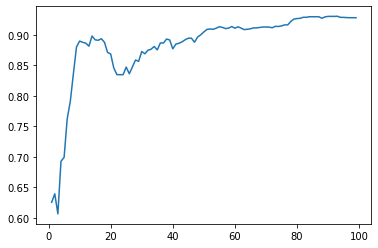

In [76]:
import matplotlib.pyplot as plt
ks = np.arange(1, 100)
plt.plot(ks, [evaluate_clf_with_k_features(clf, X[df.Meta.cohort == 'c2'], y[df.Meta.cohort == 'c2'], k, c1_importances) for k in ks])

In [95]:
union_importances = get_feature_importances(df_union.Input.Clinical, df_union.Target.pcr)
liyuan_importances = get_feature_importances(df_liyuan.Input.Clinical, df_liyuan.Target.pcr)

In [96]:
import pickle
with open('../data/processed/mapping.pkl', 'rb') as f:
    mapping = pickle.load(f)

In [97]:
feature_names = [mapping[col] if col in mapping else col for col in df.Input.Clinical.columns]

In [98]:
features = pd.DataFrame({'internal_name': df.Input.Clinical.columns.values, 'name': feature_names, 'union_importances': union_importances, 
                         'liyuan_importances': liyuan_importances, 'union_missingness': 1-df_union.Input.Clinical.isna().mean(axis=0).values, 
                         'liyuan_missingness': 1-df_liyuan.Input.Clinical.isna().mean(axis=0).values}).reset_index(drop=True)
features

internal_name  \
0                                         Value_5NT   
1                                         Value_AFU   
2                                         Value_ALB   
3                                         Value_ALG   
4                                         Value_ALP   
..                                              ...   
122                            Metadata_Temperature   
123                            Disease_hypertension   
124                                Disease_diabetes   
125  Disease_coronary atherosclerotic heart disease   
126                                         Disease   

                                               name  union_importances  \
0                              5'nucleotidase Value           0.015916   
1                              α-L-Fucosidase Value           0.000000   
2                                     Albumin Value           0.022211   
3                      Albumin/Globulin ratio Value           0.018104   
4                        Alkaline phosphatase Value           0.102417   
..                                              ...                ...   
122                            Metadata_Temperature           0.532346   
123                            Disease_hypertension           0.008108   
124                                Disease_diabetes           0.000000   
125  Disease_coronary atherosclerotic heart disease           0.000000   
126                                         Disease           0.021976   

     liyuan_importances  union_missingness  liyuan_missingness  
0              0.000000           0.189165            0.000000  
1              0.036621           0.000000            0.258228  
2              0.072817           0.610124            0.665823  
3              0.000000           0.609236            0.000000  
4              0.194386           0.610124            0.663291  
..                  ...                ...                 ...  
122            0.389302           0.984014            0.660759  
123            0.005044           1.000000            1.000000  
124            0.000000           1.000000            1.000000  
125            0.000000           1.000000            1.000000  
126            0.000000           1.000000            1.000000  

[127 rows x 6 columns]

In [99]:
from rbo import rbo

In [100]:
rbo(features.sort_values('union_importances', ascending=False)[:60]['name'].values, features.sort_values('liyuan_importances', ascending=False)[:60]['name'].values, p=.9)

RBO(min=0.24413106240745852, res=0.0004522380600098198, ext=0.24427097159042252)

In [101]:
features.sort_values('union_importances', ascending=False)[:20]

internal_name                                               name  \
97            Value_RDWCV  Coefficient variation of red cell volume distr...   
122  Metadata_Temperature                               Metadata_Temperature   
59            Value_IL-10                               Interleukin-10 Value   
26          Value_CD4/CD8                                CD4/CD8 ratio Value   
24             Value_CD3+                                  CD3+ T cell Value   
98            Value_RDWSD  Standard deviation of red cell volume distribu...   
27             Value_CD8+                                  CD8+ T cell Value   
46              Value_GLU                                      Glucose Value   
34              Value_CRP                           C-reactive protein Value   
89              Value_PDW                  Platelet distribution width Value   
55              Value_IFN                                        IFN-γ Value   
39              Value_EOP                           Eosinophil percent Value   
78              Value_MOP                             Monocyte percent Value   
120          Metadata_Age                                       Metadata_Age   
93             Value_PLCT                                 Plateletcrit Value   
79              Value_MPV                         Mean platelet volume Value   
43              Value_FIB                                   Fibrinogen Value   
8              Value_APTT        Activated partial thromboplastin time Value   
88              Value_PCT                                Procalcitonin Value   
74             Value_MCHC    Mean corpuscular hemoglobin concentration Value   

     union_importances  liyuan_importances  union_missingness  \
97            0.562532            0.016240           0.606572   
122           0.532346            0.389302           0.984014   
59            0.373016            0.000000           0.456483   
26            0.222592            0.000000           0.443162   
24            0.192746            0.000000           0.443162   
98            0.192445            0.092516           0.372114   
27            0.164530            0.000000           0.443162   
46            0.153385            0.118000           0.312611   
34            0.146337            0.000000           0.476909   
89            0.142137            0.083357           0.824156   
55            0.132731            0.000000           0.456483   
39            0.132593            0.139315           0.928064   
78            0.126847            0.032652           0.928064   
120           0.124838            0.388777           1.000000   
93            0.123455            0.064782           0.824156   
79            0.123314            0.252647           0.920959   
43            0.120702            0.020105           0.751332   
8             0.120478            0.209386           0.751332   
88            0.107456            0.097376           0.371226   
74            0.103326            0.072343           0.928952   

     liyuan_missingness  
97             0.584810  
122            0.660759  
59             0.000000  
26             0.000000  
24             0.000000  
98             0.584810  
27             0.000000  
46             0.658228  
34             0.000000  
89             0.584810  
55             0.000000  
39             0.556962  
78             0.572152  
120            1.000000  
93             0.584810  
79             0.584810  
43             0.559494  
8              0.559494  
88             0.179747  
74             0.584810

In [102]:
import pyperclip
table = pd.DataFrame({'Union': features.sort_values('union_importances', ascending=False)[:15]['name'].values, 'Liyuan': features.sort_values('liyuan_importances', ascending=False)[:15]['name'].values})
table.index = np.arange(1, len(table)+1)
pyperclip.copy(table.to_latex(caption='Top-15 features based on mean absolute Shapley values of the Union and Liyuan hospitals in the iCTCF dataset. '))

In [103]:
features_union = features.sort_values('union_importances', ascending=False)['name'].values
features_liyuan = features.sort_values('liyuan_importances', ascending=False)['name'].values

In [104]:
def get_features_importances2(X_train, y_train, X_test, y_test, n):
    train_importances = get_feature_importances(X_train, y_train)
    test_importances = get_feature_importances(X_test, y_test)
    
    features = pd.DataFrame({'name': feature_names, 'train_importances': train_importances, 'test_importances': test_importances})
    features_train = features.sort_values('train_importances', ascending=False)['name'].values
    features_test = features.sort_values('test_importances', ascending=False)['name'].values
    
    return [len(set(features_train[:k]) & set(features_test[:k])) for k in range(n)]

In [105]:
from sklearn.model_selection import train_test_split

In [106]:
overlaps = np.zeros((60, ))
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(df.Input, df.Target.pcr, test_size=0.5, shuffle=True)
    overlaps += get_features_importances2(X_train, y_train, X_test, y_test, 60)

overlaps /= 100

ValueError: array length 127 does not match index length 187

In [ ]:
overlap_cohort = get_features_importances2(df[df.Meta.cohort == 'c1'].Input, df[df.Meta.cohort == 'c1'].Target.pcr, 
                                           df[df.Meta.cohort == 'c2'].Input, df[df.Meta.cohort == 'c2'].Target.pcr, 25)

NameError: name 'overlap_cohort' is not defined

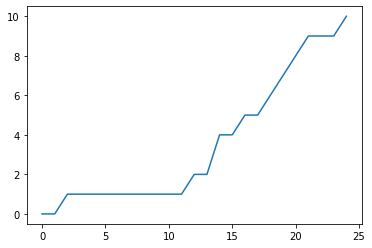

In [107]:
import matplotlib.pyplot as plt
plt.plot([len(set(features_union[:k]) & set(features_liyuan[:k])) for k in range(25)])
# plt.plot(overlaps)
plt.plot(overlap_cohort)
plt.plot(range(25), '--', color='black')

In [124]:
df.Meta.cohort

0       c1
1       c1
2       c1
3       c1
4       c1
        ..
1516    c2
1517    c2
1518    c2
1519    c2
1520    c2
Name: cohort, Length: 1521, dtype: object

In [108]:
features_sorted = features.rename(columns={'union_importances': 'importance_union', 'liyuan_importances': 'importance_liyuan', 
                                           'union_missingness': 'importance_missing_union', 'liyuan_missingness': 'importance_missing_liyuan'}).sort_values('importance_union', ascending=False)[:15]
features_sorted['index'] = features_sorted.index
features_sorted = pd.wide_to_long(features_sorted, stubnames=['importance'], sep='_', suffix='.+', j='imp', i='index')
features_sorted

name  \
index imp                                                                 
97    union           Coefficient variation of red cell volume distr...   
122   union                                        Metadata_Temperature   
59    union                                        Interleukin-10 Value   
26    union                                         CD4/CD8 ratio Value   
24    union                                           CD3+ T cell Value   
98    union           Standard deviation of red cell volume distribu...   
27    union                                           CD8+ T cell Value   
46    union                                               Glucose Value   
34    union                                    C-reactive protein Value   
89    union                           Platelet distribution width Value   
55    union                                                 IFN-γ Value   
39    union                                    Eosinophil percent Value   
78    union                                      Monocyte percent Value   
120   union                                                Metadata_Age   
93    union                                          Plateletcrit Value   
97    liyuan          Coefficient variation of red cell volume distr...   
122   liyuan                                       Metadata_Temperature   
59    liyuan                                       Interleukin-10 Value   
26    liyuan                                        CD4/CD8 ratio Value   
24    liyuan                                          CD3+ T cell Value   
98    liyuan          Standard deviation of red cell volume distribu...   
27    liyuan                                          CD8+ T cell Value   
46    liyuan                                              Glucose Value   
34    liyuan                                   C-reactive protein Value   
89    liyuan                          Platelet distribution width Value   
55    liyuan                                                IFN-γ Value   
39    liyuan                                   Eosinophil percent Value   
78    liyuan                                     Monocyte percent Value   
120   liyuan                                               Metadata_Age   
93    liyuan                                         Plateletcrit Value   
97    missing_union   Coefficient variation of red cell volume distr...   
122   missing_union                                Metadata_Temperature   
59    missing_union                                Interleukin-10 Value   
26    missing_union                                 CD4/CD8 ratio Value   
24    missing_union                                   CD3+ T cell Value   
98    missing_union   Standard deviation of red cell volume distribu...   
27    missing_union                                   CD8+ T cell Value   
46    missing_union                                       Glucose Value   
34    missing_union                            C-reactive protein Value   
89    missing_union                   Platelet distribution width Value   
55    missing_union                                         IFN-γ Value   
39    missing_union                            Eosinophil percent Value   
78    missing_union                              Monocyte percent Value   
120   missing_union                                        Metadata_Age   
93    missing_union                                  Plateletcrit Value   
97    missing_liyuan  Coefficient variation of red cell volume distr...   
122   missing_liyuan                               Metadata_Temperature   
59    missing_liyuan                               Interleukin-10 Value   
26    missing_liyuan                                CD4/CD8 ratio Value   
24    missing_liyuan                                  CD3+ T cell Value   
98    missing_liyuan  Standard deviation of red cell volume distribu...   
27    missing_liyuan                                  CD8+ T cell Value   
46    missing_liy

In [129]:
importances_df = features_sorted.reset_index(level=1).copy()
importances_df = importances_df[importances_df.imp.isin(['union', 'liyuan'])]
importances_df.rename(columns={'imp': 'Hospital'}, inplace=True)
importances_df.Hospital = importances_df.Hospital.str.replace('union', 'Union').str.replace('liyuan', 'Liyuan')
importances_df.name = missing_df.name.str.replace(' Value', '').str.replace('Metadata_', '')
importances_df

Hospital                                               name  \
index                                                               
97       Union  Coefficient variation of red cell volume distr...   
122      Union                                        Temperature   
59       Union                                     Interleukin-10   
26       Union                                      CD4/CD8 ratio   
24       Union                                        CD3+ T cell   
98       Union  Standard deviation of red cell volume distribu...   
27       Union                                        CD8+ T cell   
46       Union                                            Glucose   
34       Union                                 C-reactive protein   
89       Union                        Platelet distribution width   
55       Union                                              IFN-γ   
39       Union                                 Eosinophil percent   
78       Union                                   Monocyte percent   
120      Union                                                Age   
93       Union                                       Plateletcrit   
97      Liyuan  Coefficient variation of red cell volume distr...   
122     Liyuan                                        Temperature   
59      Liyuan                                     Interleukin-10   
26      Liyuan                                      CD4/CD8 ratio   
24      Liyuan                                        CD3+ T cell   
98      Liyuan  Standard deviation of red cell volume distribu...   
27      Liyuan                                        CD8+ T cell   
46      Liyuan                                            Glucose   
34      Liyuan                                 C-reactive protein   
89      Liyuan                        Platelet distribution width   
55      Liyuan                                              IFN-γ   
39      Liyuan                                 Eosinophil percent   
78      Liyuan                                   Monocyte percent   
120     Liyuan                                                Age   
93      Liyuan                                       Plateletcrit   

              internal_name  importance  
index                                    
97              Value_RDWCV    0.562532  
122    Metadata_Temperature    0.532346  
59              Value_IL-10    0.373016  
26            Value_CD4/CD8    0.222592  
24               Value_CD3+    0.192746  
98              Value_RDWSD    0.192445  
27               Value_CD8+    0.164530  
46                Value_GLU    0.153385  
34                Value_CRP    0.146337  
89                Value_PDW    0.142137  
55                Value_IFN    0.132731  
39                Value_EOP    0.132593  
78                Value_MOP    0.126847  
120            Metadata_Age    0.124838  
93               Value_PLCT    0.123455  
97              Value_RDWCV    0.016240  
122    Metadata_Temperature    0.389302  
59              Value_IL-10    0.000000  
26            Value_CD4/CD8    0.000000  
24               Value_CD3+    0.000000  
98              Value_RDWSD    0.092516  
27               Value_CD8+    0.000000  
46                Value_GLU    0.118000  
34                Value_CRP    0.000000  
89                Value_PDW    0.083357  
55                Value_IFN    0.000000  
39                Value_EOP    0.139315  
78                Value_MOP    0.032652  
120            Metadata_Age    0.388777  
93               Value_PLCT    0.064782

In [120]:
features_sorted.reset_index(level=1).imp.unique()

array(['union', 'liyuan', 'missing_union', 'missing_liyuan'], dtype=object)

In [127]:
missing_df = features_sorted.reset_index(level=1).copy()
missing_df = missing_df[missing_df.imp.isin(['missing_union', 'missing_liyuan'])]
missing_df.rename(columns={'imp': 'Hospital'}, inplace=True)
missing_df.Hospital = missing_df.Hospital.str.replace('missing_union', 'Union').str.replace('missing_liyuan', 'Liyuan')
missing_df.name = missing_df.name.str.replace(' Value', '').str.replace('Metadata_', '')
missing_df

Hospital                                               name  \
index                                                               
97       Union  Coefficient variation of red cell volume distr...   
122      Union                                        Temperature   
59       Union                                     Interleukin-10   
26       Union                                      CD4/CD8 ratio   
24       Union                                        CD3+ T cell   
98       Union  Standard deviation of red cell volume distribu...   
27       Union                                        CD8+ T cell   
46       Union                                            Glucose   
34       Union                                 C-reactive protein   
89       Union                        Platelet distribution width   
55       Union                                              IFN-γ   
39       Union                                 Eosinophil percent   
78       Union                                   Monocyte percent   
120      Union                                                Age   
93       Union                                       Plateletcrit   
97      Liyuan  Coefficient variation of red cell volume distr...   
122     Liyuan                                        Temperature   
59      Liyuan                                     Interleukin-10   
26      Liyuan                                      CD4/CD8 ratio   
24      Liyuan                                        CD3+ T cell   
98      Liyuan  Standard deviation of red cell volume distribu...   
27      Liyuan                                        CD8+ T cell   
46      Liyuan                                            Glucose   
34      Liyuan                                 C-reactive protein   
89      Liyuan                        Platelet distribution width   
55      Liyuan                                              IFN-γ   
39      Liyuan                                 Eosinophil percent   
78      Liyuan                                   Monocyte percent   
120     Liyuan                                                Age   
93      Liyuan                                       Plateletcrit   

              internal_name  importance  
index                                    
97              Value_RDWCV    0.606572  
122    Metadata_Temperature    0.984014  
59              Value_IL-10    0.456483  
26            Value_CD4/CD8    0.443162  
24               Value_CD3+    0.443162  
98              Value_RDWSD    0.372114  
27               Value_CD8+    0.443162  
46                Value_GLU    0.312611  
34                Value_CRP    0.476909  
89                Value_PDW    0.824156  
55                Value_IFN    0.456483  
39                Value_EOP    0.928064  
78                Value_MOP    0.928064  
120            Metadata_Age    1.000000  
93               Value_PLCT    0.824156  
97              Value_RDWCV    0.584810  
122    Metadata_Temperature    0.660759  
59              Value_IL-10    0.000000  
26            Value_CD4/CD8    0.000000  
24               Value_CD3+    0.000000  
98              Value_RDWSD    0.584810  
27               Value_CD8+    0.000000  
46                Value_GLU    0.658228  
34                Value_CRP    0.000000  
89                Value_PDW    0.584810  
55                Value_IFN    0.000000  
39                Value_EOP    0.556962  
78                Value_MOP    0.572152  
120            Metadata_Age    1.000000  
93               Value_PLCT    0.584810

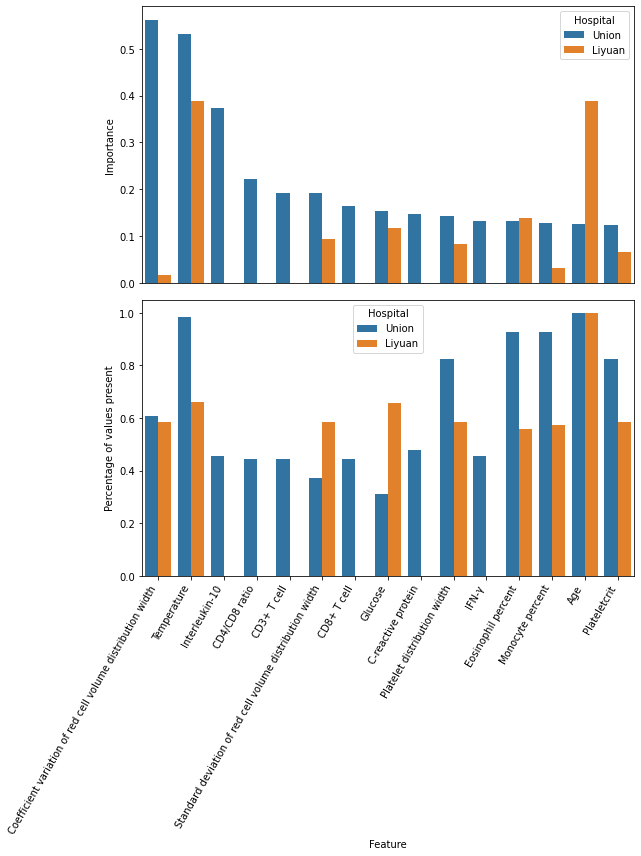

In [136]:
import seaborn as sns
plt.figure(figsize=(9, 12))
plt.subplot(2, 1, 1)
sns.barplot(data=importances_df, x='name', y='importance', hue='Hospital')
# plt.xticks(rotation=45, ha='right')
plt.xticks([])
plt.ylabel('Importance')
plt.xlabel('')
plt.subplot(2, 1, 2)
sns.barplot(data=missing_df, x='name', y='importance', hue='Hospital')
plt.xticks(rotation=60, ha='right')
plt.ylabel('Percentage of values present')
plt.xlabel('Feature')
# plt.savefig('')
plt.tight_layout()
plt.savefig('union_top_features.pdf')

In [140]:
features_sorted = features.rename(columns={'union_importances': 'importance_union', 'liyuan_importances': 'importance_liyuan', 
                                           'union_missingness': 'importance_missing_union', 'liyuan_missingness': 'importance_missing_liyuan'}).sort_values('importance_liyuan', ascending=False)[:15]
features_sorted['index'] = features_sorted.index
features_sorted = pd.wide_to_long(features_sorted, stubnames=['importance'], sep='_', suffix='.+', j='imp', i='index')
features_sorted

name  \
index imp                                                           
122   union                                  Metadata_Temperature   
120   union                                          Metadata_Age   
23    union                                         Calcium Value   
79    union                            Mean platelet volume Value   
8     union           Activated partial thromboplastin time Value   
4     union                            Alkaline phosphatase Value   
37    union                                         D-Dimer Value   
31    union                                        Chlorine Value   
52    union             High-sensitivity C-reactive protein Value   
116   union                                       Uric acid Value   
39    union                              Eosinophil percent Value   
11    union                                Antithrombin III Value   
32    union                            Total carbon dioxide Value   
46    union                                         Glucose Value   
81    union                                Neutrophil count Value   
122   liyuan                                 Metadata_Temperature   
120   liyuan                                         Metadata_Age   
23    liyuan                                        Calcium Value   
79    liyuan                           Mean platelet volume Value   
8     liyuan          Activated partial thromboplastin time Value   
4     liyuan                           Alkaline phosphatase Value   
37    liyuan                                        D-Dimer Value   
31    liyuan                                       Chlorine Value   
52    liyuan            High-sensitivity C-reactive protein Value   
116   liyuan                                      Uric acid Value   
39    liyuan                             Eosinophil percent Value   
11    liyuan                               Antithrombin III Value   
32    liyuan                           Total carbon dioxide Value   
46    liyuan                                        Glucose Value   
81    liyuan                               Neutrophil count Value   
122   missing_union                          Metadata_Temperature   
120   missing_union                                  Metadata_Age   
23    missing_union                                 Calcium Value   
79    missing_union                    Mean platelet volume Value   
8     missing_union   Activated partial thromboplastin time Value   
4     missing_union                    Alkaline phosphatase Value   
37    missing_union                                 D-Dimer Value   
31    missing_union                                Chlorine Value   
52    missing_union     High-sensitivity C-reactive protein Value   
116   missing_union                               Uric acid Value   
39    missing_union                      Eosinophil percent Value   
11    missing_union                        Antithrombin III Value   
32    missing_union                    Total carbon dioxide Value   
46    missing_union                                 Glucose Value   
81    missing_union                        Neutrophil count Value   
122   missing_liyuan                         Metadata_Temperature   
120   missing_liyuan                                 Metadata_Age   
23    missing_liyuan                                Calcium Value   
79    missing_liyuan                   Mean platelet volume Value   
8     missing_liyuan  Activated partial thromboplastin time Value   
4     missing_liyuan                   Alkaline phosphatase Value   
37    missing_liyuan                                D-Dimer Value   
31    missing_liyuan                               Chlorine Value   
52    missing_liyuan    High-sensitivity C-reactive protein Value   
116   missing_liyuan                              Uric acid Value   
39    missing_liyuan                     Eosinophil percent Value   
11    missing_liyuan                       Antithrombin III

In [141]:
importances_df = features_sorted.reset_index(level=1).copy()
importances_df = importances_df[importances_df.imp.isin(['union', 'liyuan'])]
importances_df.rename(columns={'imp': 'Hospital'}, inplace=True)
importances_df.Hospital = importances_df.Hospital.str.replace('union', 'Union').str.replace('liyuan', 'Liyuan')
importances_df.name = importances_df.name.str.replace(' Value', '').str.replace('Metadata_', '')
importances_df

Hospital                                   name         internal_name  \
index                                                                         
122      Union                            Temperature  Metadata_Temperature   
120      Union                                    Age          Metadata_Age   
23       Union                                Calcium              Value_CA   
79       Union                   Mean platelet volume             Value_MPV   
8        Union  Activated partial thromboplastin time            Value_APTT   
4        Union                   Alkaline phosphatase             Value_ALP   
37       Union                                D-Dimer              Value_DD   
31       Union                               Chlorine              Value_CL   
52       Union    High-sensitivity C-reactive protein           Value_HSCRP   
116      Union                              Uric acid            Value_URIC   
39       Union                     Eosinophil percent             Value_EOP   
11       Union                       Antithrombin III             Value_AT3   
32       Union                   Total carbon dioxide             Value_CO2   
46       Union                                Glucose             Value_GLU   
81       Union                       Neutrophil count              Value_NE   
122     Liyuan                            Temperature  Metadata_Temperature   
120     Liyuan                                    Age          Metadata_Age   
23      Liyuan                                Calcium              Value_CA   
79      Liyuan                   Mean platelet volume             Value_MPV   
8       Liyuan  Activated partial thromboplastin time            Value_APTT   
4       Liyuan                   Alkaline phosphatase             Value_ALP   
37      Liyuan                                D-Dimer              Value_DD   
31      Liyuan                               Chlorine              Value_CL   
52      Liyuan    High-sensitivity C-reactive protein           Value_HSCRP   
116     Liyuan                              Uric acid            Value_URIC   
39      Liyuan                     Eosinophil percent             Value_EOP   
11      Liyuan                       Antithrombin III             Value_AT3   
32      Liyuan                   Total carbon dioxide             Value_CO2   
46      Liyuan                                Glucose             Value_GLU   
81      Liyuan                       Neutrophil count              Value_NE   

       importance  
index              
122      0.532346  
120      0.124838  
23       0.024355  
79       0.123314  
8        0.120478  
4        0.102417  
37       0.056864  
31       0.036567  
52       0.000000  
116      0.062222  
39       0.132593  
11       0.000000  
32       0.057262  
46       0.153385  
81       0.085755  
122      0.389302  
120      0.388777  
23       0.275416  
79       0.252647  
8        0.209386  
4        0.194386  
37       0.193457  
31       0.185311  
52       0.178616  
116      0.152748  
39       0.139315  
11       0.123216  
32       0.122824  
46       0.118000  
81       0.097490

In [142]:
features_sorted.reset_index(level=1).imp.unique()

array(['union', 'liyuan', 'missing_union', 'missing_liyuan'], dtype=object)

In [143]:
missing_df = features_sorted.reset_index(level=1).copy()
missing_df = missing_df[missing_df.imp.isin(['missing_union', 'missing_liyuan'])]
missing_df.rename(columns={'imp': 'Hospital'}, inplace=True)
missing_df.Hospital = missing_df.Hospital.str.replace('missing_union', 'Union').str.replace('missing_liyuan', 'Liyuan')
missing_df.name = missing_df.name.str.replace(' Value', '').str.replace('Metadata_', '')
missing_df

Hospital                                   name         internal_name  \
index                                                                         
122      Union                            Temperature  Metadata_Temperature   
120      Union                                    Age          Metadata_Age   
23       Union                                Calcium              Value_CA   
79       Union                   Mean platelet volume             Value_MPV   
8        Union  Activated partial thromboplastin time            Value_APTT   
4        Union                   Alkaline phosphatase             Value_ALP   
37       Union                                D-Dimer              Value_DD   
31       Union                               Chlorine              Value_CL   
52       Union    High-sensitivity C-reactive protein           Value_HSCRP   
116      Union                              Uric acid            Value_URIC   
39       Union                     Eosinophil percent             Value_EOP   
11       Union                       Antithrombin III             Value_AT3   
32       Union                   Total carbon dioxide             Value_CO2   
46       Union                                Glucose             Value_GLU   
81       Union                       Neutrophil count              Value_NE   
122     Liyuan                            Temperature  Metadata_Temperature   
120     Liyuan                                    Age          Metadata_Age   
23      Liyuan                                Calcium              Value_CA   
79      Liyuan                   Mean platelet volume             Value_MPV   
8       Liyuan  Activated partial thromboplastin time            Value_APTT   
4       Liyuan                   Alkaline phosphatase             Value_ALP   
37      Liyuan                                D-Dimer              Value_DD   
31      Liyuan                               Chlorine              Value_CL   
52      Liyuan    High-sensitivity C-reactive protein           Value_HSCRP   
116     Liyuan                              Uric acid            Value_URIC   
39      Liyuan                     Eosinophil percent             Value_EOP   
11      Liyuan                       Antithrombin III             Value_AT3   
32      Liyuan                   Total carbon dioxide             Value_CO2   
46      Liyuan                                Glucose             Value_GLU   
81      Liyuan                       Neutrophil count              Value_NE   

       importance  
index              
122      0.984014  
120      1.000000  
23       0.621670  
79       0.920959  
8        0.751332  
4        0.610124  
37       0.652753  
31       0.622558  
52       0.000000  
116      0.614565  
39       0.928064  
11       0.000000  
32       0.618117  
46       0.312611  
81       0.928064  
122      0.660759  
120      1.000000  
23       0.635443  
79       0.584810  
8        0.559494  
4        0.663291  
37       0.602532  
31       0.635443  
52       0.663291  
116      0.658228  
39       0.556962  
11       0.534177  
32       0.650633  
46       0.658228  
81       0.572152

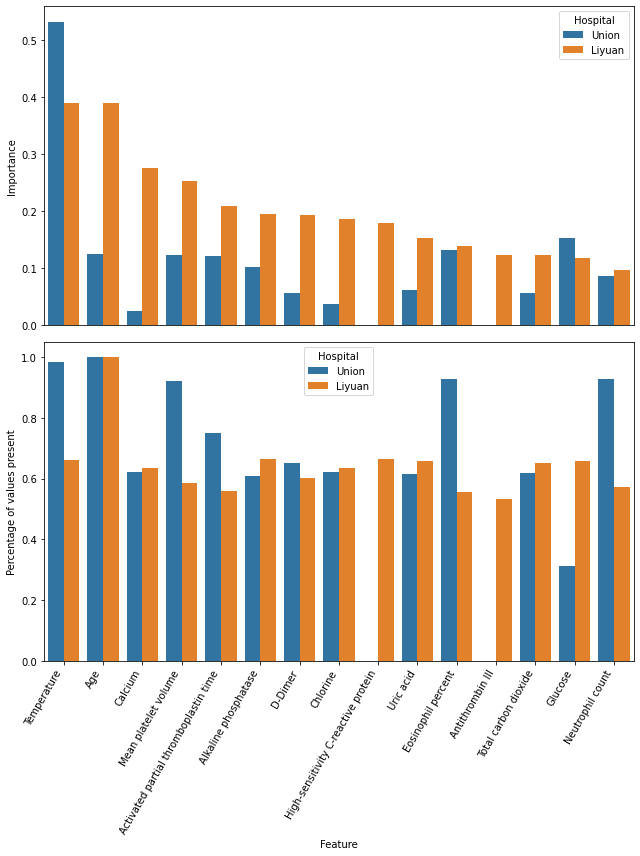

In [145]:
import seaborn as sns
plt.figure(figsize=(9, 12))
plt.subplot(2, 1, 1)
sns.barplot(data=importances_df, x='name', y='importance', hue='Hospital')
# plt.xticks(rotation=45, ha='right')
plt.xticks([])
plt.ylabel('Importance')
plt.xlabel('')
plt.subplot(2, 1, 2)
sns.barplot(data=missing_df, x='name', y='importance', hue='Hospital')
plt.xticks(rotation=60, ha='right')
plt.ylabel('Percentage of values present')
plt.xlabel('Feature')
# plt.savefig('')
plt.tight_layout()
plt.savefig('liyuan_top_features.pdf')

In [90]:
import seaborn as sns
plt.figure(figsize=(9, 7))
sns.barplot(data=features_sorted.reset_index(level=1), x='name', y='importance', hue='imp')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('liyuan_top_features.pdf')

NameError: name 'features_sorted' is not defined

<Figure size 648x504 with 0 Axes>

In [234]:
df.Input.Clinical.corr()['Value_RDWCV'].sort_values()[::-1][:10]

Value_RF            NaN
Value_LPS           NaN
Value_LAC           NaN
Value_RDWCV    1.000000
Value_RDWSD    0.800658
Value_FDG      0.440852
Value_UNCX     0.429144
Value_WBCC     0.373076
Value_IGM      0.365100
Value_INR      0.363375
Name: Value_RDWCV, dtype: float64

In [235]:
from scipy.stats import pearsonr

In [252]:
pcrs = df[df.Meta.hospital == 'Union'].Target.pcr
rwdcvs = df[df.Meta.hospital == 'Union'].Input.Clinical['Value_RDWCV']
not_na = ~pcrs.isna() & ~rwdcvs.isna()
rwdcvs = rwdcvs[not_na]
pcrs = pcrs[not_na]
pearsonr(rwdcvs.values.astype(float), pcrs.cat.codes.values.astype(float))

(-0.35410290207222755, 1.317522674014919e-21)

In [260]:
pcrs = df[df.Meta.hospital != 'Union'].Target.pcr
rwdcvs = df[df.Meta.hospital != 'Union'].Input.Clinical['Value_RDWCV']
not_na = ~pcrs.isna() & ~rwdcvs.isna()
rwdcvs = rwdcvs[not_na]
pcrs = pcrs[not_na]
pearsonr(rwdcvs.values.astype(float), pcrs.cat.codes.values.astype(float))

(-0.03031175695102304, 0.6467333558949127)

In [261]:
pcrs = df[df.Meta.hospital != 'Union'].Target.pcr
rwdcvs = df[df.Meta.hospital != 'Union'].Input.Clinical['Value_RDWCV']
(~rwdcvs.isna()).sum()

231

In [370]:
def exclude(df, exclude):
    X = df.Input.Clinical
    X = X.loc[:, set(X.columns) - exclude]
    y = df.Target.pcr
    return preprocess(X, y)
clf = LGBMClassifier(n_jobs=-1, boosting_type='dart', n_estimators=900, colsample_bytree=0.98, drop_rate=0.99, max_drop=1000, skip_drop=0.0)
clf.fit(*exclude(df_union, {''}))

LGBMClassifier(boosting_type='dart', colsample_bytree=0.98, drop_rate=0.99,
               max_drop=1000, n_estimators=900, skip_drop=0.0)

In [371]:
from sklearn.metrics import roc_auc_score
X, y = exclude(df_liyuan, {''})
roc_auc_score(y, clf.predict_proba(X)[:, 1])

0.688853732571899

In [592]:
!pip install bartpy

You should consider upgrading via the 'c:\users\roel\.virtualenvs\diagcovid-ckc2berq\scripts\python.exe -m pip install --upgrade pip' command.



  Created wheel for bartpy: filename=bartpy-0.0.2-py3-none-any.whl size=17543 sha256=527e637a08a7fefa7eaeacd7ca6979f38eba31c4897231cb428b400d5dba0914
  Stored in directory: c:\users\roel\appdata\local\pip\cache\wheels\ff\50\f1\1be984abb7fd74d9c73eb36708bae312863b03f08c916601d4
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=f6bf5902e3a7796ce2426b70f11ee74d8fd2095d5cf52ad4291c9dbdba299644
  Stored in directory: c:\users\roel\appdata\local\pip\cache\wheels\46\ef\c3\157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built bartpy sklearn


In [593]:
from bartpy.sklearnmodel import SklearnModel
clf = SklearnModel()

ModuleNotFoundError: No module named 'bartpy.samplers'

In [72]:
from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold()

In [73]:
from sklearn.model_selection import cross_val_score, cross_validate
from covidcf.evaluation.models import TestTimeImputingClassifier, ColumnImputer

def transform_results(df, model_name):
    df = pd.DataFrame(df)
    df.columns = 'Value_' + df.columns
    df['index'] = df.index
    df = pd.wide_to_long(df, stubnames=['Value'], sep='_', suffix='.+', j='Metric', i='index')
    df['Model'] = model_name
    return df
    
X, y = preprocess(df.Input.Clinical, df.Meta.hospital)
test_impute_scores = transform_results(cross_validate(TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), ColumnImputer(), 40), X, pd.Series(y).astype('category').cat.codes, scoring=['roc_auc', 'f1'], cv=cv), 'Test time impute LGBM')

In [74]:
missing_scores = transform_results(cross_validate(LGBMClassifier(n_jobs=-1), X.isna(), pd.Series(y).astype('category').cat.codes, scoring=['roc_auc', 'f1'], cv=cv), 'Missing LGBM')

In [75]:
normal_scores = transform_results(cross_validate(LGBMClassifier(n_jobs=-1), X, pd.Series(y).astype('category').cat.codes, scoring=['roc_auc', 'f1'], cv=cv), 'LGBM')

In [76]:
scores = pd.concat([test_impute_scores, missing_scores, normal_scores])

In [83]:
scores.index.get_level_values(1).unique()

Index(['fit_time', 'score_time', 'test_roc_auc', 'test_f1'], dtype='object', name='Metric')

In [86]:
exp_data = scores[~scores.index.get_level_values(1).isin(['fit_time', 'score_time'])].reset_index(level=1).copy()
exp_data.Metric = exp_data.Metric.str.replace('test_roc_auc', 'AUC').str.replace('test_f1', 'F!')

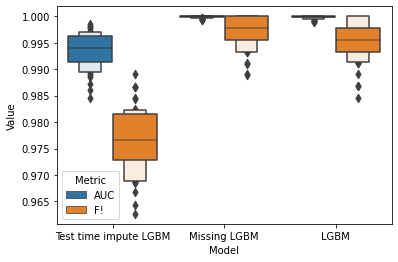

In [89]:
import tikzplotlib
import pyperclip
sns.boxenplot(data=exp_data, x='Model', y='Value', hue='Metric')
pyperclip.copy(tikzplotlib.get_tikz_code())
plt.savefig('hospital_predict.pdf')

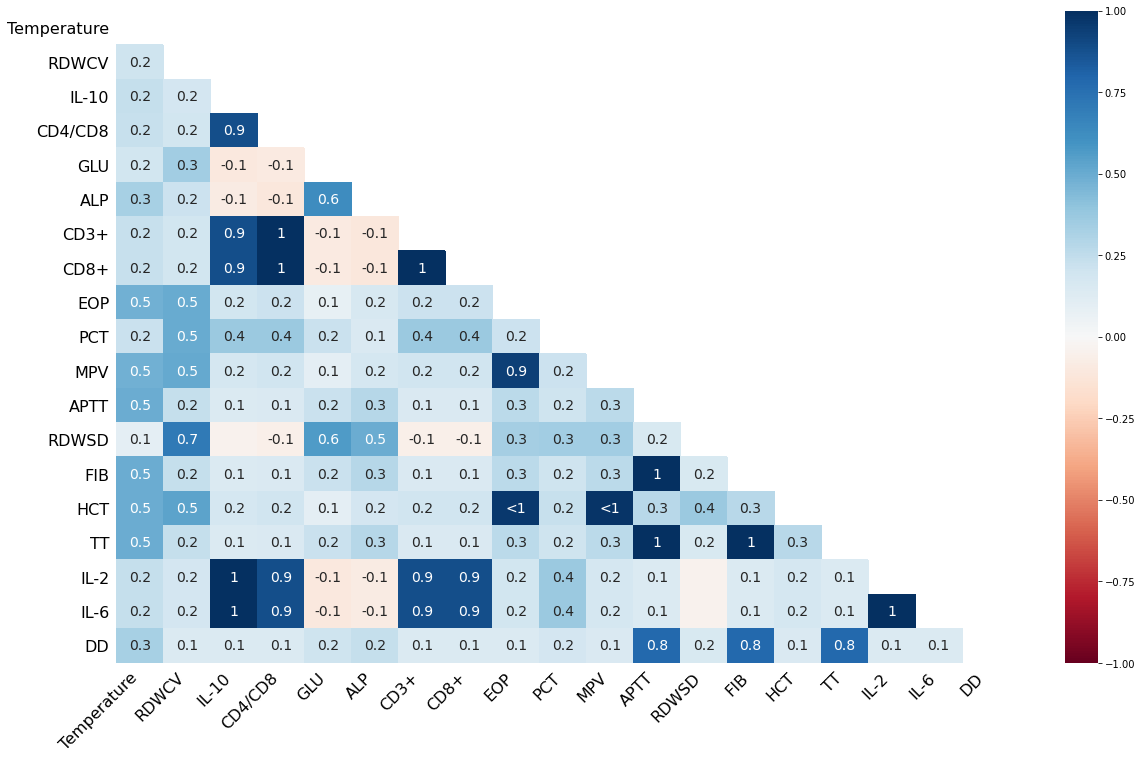

In [70]:
import missingno
import matplotlib.pyplot as plt
import tikzplotlib
import pyperclip
imps = get_feature_importances(df.Input.Clinical, df.Target.pcr)
miss_data = df.Input.Clinical[imps.sort_values(ascending=False)[:20].index].copy()
miss_data.columns = miss_data.columns.str.replace('Value_', '').str.replace('Metadata_', '')
missingno.heatmap(miss_data)
# plt.ylabel('Missingness correlation')
# tikzplotlib.save('missing_heatmap.tex', )
pyperclip.copy(tikzplotlib.get_tikz_code())#axis_width=r'1\textwidth', axis_height=r'0.55\textwidth'))
plt.savefig('missing_heatmap.pdf')

In [526]:
scores['index'] = scores.index
scores_long = pd.wide_to_long(scores, stubnames=['AUC'], sep='_', suffix='.+', j='Model', i='index')
scores_long

AUC
index Model                            
0     LGBM                     1.000000
1     LGBM                     0.990132
2     LGBM                     0.957237
3     LGBM                     0.973684
4     LGBM                     0.990132
0     Test time impute         0.980328
1     Test time impute         0.970395
2     Test time impute         0.970395
3     Test time impute         0.763158
4     Test time impute         0.924342
0     Missing indicators LGBM  1.000000
1     Missing indicators LGBM  1.000000
2     Missing indicators LGBM  0.960526
3     Missing indicators LGBM  0.967105
4     Missing indicators LGBM  0.996711

<AxesSubplot:xlabel='Model', ylabel='AUC'>

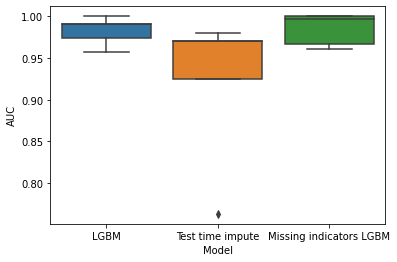

In [527]:
sns.boxplot(data=scores_long.reset_index(level=1), x='Model', y='AUC')

In [372]:
from sklearn.ensemble import BaggingClassifier

SyntaxError: invalid syntax (<ipython-input-372-5ab333685c43>, line 1)

In [7]:
severities = []
for a, b in df.groupby([('Meta', 'hospital')]):
    print(np.mean(b.Target.Metadata_Morbidity.isin(['Severe', 'Mild', 'Critically ill'])))
    for x in df.Target.Metadata_Morbidity.cat.categories:
        severities.append({'hospital': a, 'category': x, 'mortality': np.mean(b[b.Target.Metadata_Morbidity == x].Target.Metadata_Mortality == 'Deceased'), 'value': np.mean(b.Target.Metadata_Morbidity == x)})
#     for y in df.Target.Metadata_Mortality.cat.categories:
severities = pd.DataFrame(severities)

0.14177215189873418
0.21492007104795738


indexing past lexsort depth may impact performance.


In [408]:
!pip install --upgrade git+https://github.com/nschloe/tikzplotlib.git

  Running command git clone -q https://github.com/nschloe/tikzplotlib.git 'C:\Users\Roel\AppData\Local\Temp\pip-req-build-za9jsf6g'



  Cloning https://github.com/nschloe/tikzplotlib.git to c:\users\roel\appdata\local\temp\pip-req-build-za9jsf6g
  Resolved https://github.com/nschloe/tikzplotlib.git to commit 95459b91c78dbcfee36a8fbacca2d885b60f21f9
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for tikzplotlib: filename=tikzplotlib-0.9.12-py3-none-any.whl size=54265 sha256=7a0e6e1f7e7f5643679b925c2a6be87ccda63de78388f5648c8c7accc34a8ad1
  Stored in directory: C:\Users\Roel\AppData\Local\Temp\pip-ephem-wheel-cache-gt6g6pc7\wheels\f2\07\ff\a8138970c2b6dcc562ff00344162dca37ca7bf29f607916a7e
Successfully built tikzplotlib
  Attempting uninstall: tikzplotlib
    Found existing installation: tikzplotlib 0.9.9
    Uninstalling tikzplotlib-0.9.9:
 

You should consider upgrading via the 'c:\users\roel\.virtualenvs\diagcovid-ckc2berq\scripts\python.exe -m pip install --upgrade pip' command.


In [411]:
import importlib
importlib.reload(tikzplotlib)

<module 'tikzplotlib' from 'c:\\users\\roel\\.virtualenvs\\diagcovid-ckc2berq\\lib\\site-packages\\tikzplotlib\\__init__.py'>

In [154]:
severities = []
for a, b in df.groupby([('Meta', 'hospital')]):
    print(np.mean(b.Target.Metadata_Morbidity.isin(['Severe', 'Mild', 'Critically ill'])))
    for x in df.Target.Metadata_Morbidity.cat.categories:
        severities.append({'hospital': a, 'category': x, 'mortality': np.mean(b[b.Target.Metadata_Morbidity == x].Target.Metadata_Mortality == 'Deceased'), 'value': np.mean(b.Target.Metadata_Morbidity == x)})
#     for y in df.Target.Metadata_Mortality.cat.categories:
severities = pd.DataFrame(severities)

indexing past lexsort depth may impact performance.


0.14177215189873418
0.21492007104795738


In [155]:
severities['rank']  = 0
severities.loc[severities.category=='Mild', 'rank'] = 1
severities.loc[severities.category=='Regular', 'rank'] = 2
severities.loc[severities.category=='Severe', 'rank'] = 3
severities.loc[severities.category=='Critically ill', 'rank'] = 4
severities.loc[severities.category.str.startswith('Control'), 'category'] = 'Control'
severities.drop(severities[severities.category.str.startswith('Suspected')].index, inplace=True)
severities.rename(columns={'category': 'Category', 'hospital': 'Hospital'}, inplace=True)
severities

Hospital        Category  mortality     value  rank
0    Liyuan         Control   0.000000  0.197468     0
1    Liyuan         Control        NaN  0.000000     0
2    Liyuan  Critically ill   0.260870  0.058228     4
3    Liyuan            Mild   0.000000  0.022785     1
4    Liyuan         Regular   0.000000  0.318987     2
5    Liyuan          Severe   0.041667  0.060759     3
8     Union         Control   0.000000  0.122558     0
9     Union         Control   0.000000  0.099467     0
10    Union  Critically ill   0.734694  0.043517     4
11    Union            Mild   0.000000  0.013321     1
12    Union         Regular   0.000000  0.417407     2
13    Union          Severe   0.078652  0.158082     3

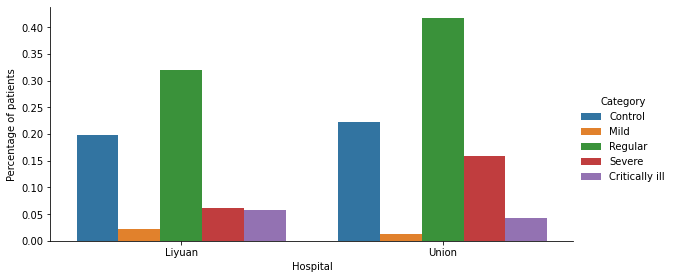

In [157]:
import tikzplotlib
import matplotlib
import pyperclip
import matplotlib.pyplot as plt
import seaborn as sns
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })
sns.catplot(data=severities.sort_values(by='rank'), x='Hospital', y='value', hue='Category', kind='bar', height=4, aspect=2, ci=None, estimator=sum)
plt.ylabel('Percentage of patients')
# pyperclip.copy(tikzplotlib.get_tikz_code(axis_width=r'1.2\textwidth'))
# plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('severity_dist_ictcf.pdf')

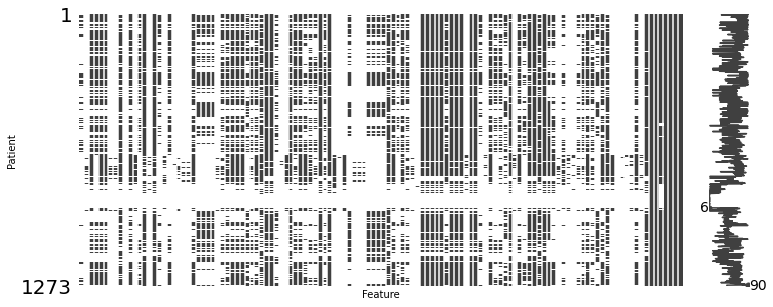

In [176]:
import missingno
import matplotlib.pyplot as plt
missingno.matrix(df.Input.Clinical.dropna(axis='columns', thresh=2), figsize=(12, 5))
plt.ylabel('Patient')
plt.xlabel('Feature')
plt.savefig('results/ictcf_missingness.svg')

In [235]:
dfs = {
    'CWZ': pd.read_pickle('../data/processed/cwz.pkl'), 
    'iCTCF': pd.read_pickle('../data/processed/ictcf.pkl'), 
    'RUMC': pd.read_pickle('../data/processed/rumc.pkl')    
}

In [250]:
results = []
for name, df in dfs.items():
    if 'pcr' in df.Target.columns:
        X, y = preprocess(df.Input, df.Target.pcr)
    else:
        X, y = preprocess(df.Input, df.Target.diagnosis)
    X.columns = [re.sub(r'[^0-9a-zA-Z_-]+', '', '_'.join(col).strip()) for col in X.columns.values]
    X.columns = pd.io.parsers.ParserBase({'names': X.columns})._maybe_dedup_names(X.columns)
    shap_values = shap.TreeExplainer(LGBMClassifier(n_jobs=-1).fit(X, y))(X)[:, :, 1].values
    is_visual = X.columns.str.startswith('Visual') | X.columns.str.startswith('V_i_s_u_a_l')
    print(is_visual.any())
    print('missing')
    mas_missing = (shap_values[:, ~is_visual] * X.isna().loc[:, ~is_visual]).abs().mean().mean()
    print('present')
    mas_present = (shap_values[:, ~is_visual] * (~X.isna().loc[:, ~is_visual])).abs().mean().mean()
    print('visual')
    mas_visual = np.abs(shap_values[:, is_visual]).mean()
    results.append({'Dataset': name, 'Feature Set': 'Clin./Vis.', 'Feature Type': 'Missing', 'Mean absolute SHAP value': mas_missing})
    results.append({'Dataset': name, 'Feature Set': 'Clin./Vis.', 'Feature Type': 'Present', 'Mean absolute SHAP value': mas_present})
    results.append({'Dataset': name, 'Feature Set': 'Clin./Vis.', 'Feature Type': 'Visual', 'Mean absolute SHAP value': mas_visual})
    
    if 'pcr' in df.Target.columns:
        X, y = preprocess(df.Input.Clinical, df.Target.pcr)
    else:
        X, y = preprocess(df.Input.Clinical, df.Target.diagnosis)
    X.columns = [re.sub(r'[^0-9a-zA-Z_-]+', '', '_'.join(col).strip()) for col in X.columns.values]
    X.columns = pd.io.parsers.ParserBase({'names': X.columns})._maybe_dedup_names(X.columns)
    shap_values = shap.TreeExplainer(LGBMClassifier(n_jobs=-1).fit(X, y))(X)[:, :, 1].values
    print('missing')
    mas_missing = (shap_values * X.isna()).abs().mean().mean()
    print('present')
    mas_present = (shap_values * (~X.isna())).abs().mean().mean()
    results.append({'Dataset': name, 'Feature Set': 'Clinical', 'Feature Type': 'Missing', 'Mean absolute SHAP value': mas_missing})
    results.append({'Dataset': name, 'Feature Set': 'Clinical', 'Feature Type': 'Present', 'Mean absolute SHAP value': mas_present})
    print()

True
missing
present
visual
missing
present

True
missing
present
visual
missing
present

True
missing
present
visual
missing
present



In [251]:
pd.DataFrame(results)

Dataset Feature Set Feature Type  Mean absolute SHAP value
0      CWZ  Clin./Vis.      Missing                  0.023635
1      CWZ  Clin./Vis.      Present                  0.136193
2      CWZ  Clin./Vis.       Visual                  0.097721
3      CWZ    Clinical      Missing                  0.033583
4      CWZ    Clinical      Present                  0.264286
5    iCTCF  Clin./Vis.      Missing                  0.021978
6    iCTCF  Clin./Vis.      Present                  0.042427
7    iCTCF  Clin./Vis.       Visual                  0.059320
8    iCTCF    Clinical      Missing                  0.026453
9    iCTCF    Clinical      Present                  0.057231
10    RUMC  Clin./Vis.      Missing                  0.001578
11    RUMC  Clin./Vis.      Present                  0.003976
12    RUMC  Clin./Vis.       Visual                  0.044804
13    RUMC    Clinical      Missing                  0.001726
14    RUMC    Clinical      Present                  0.004613

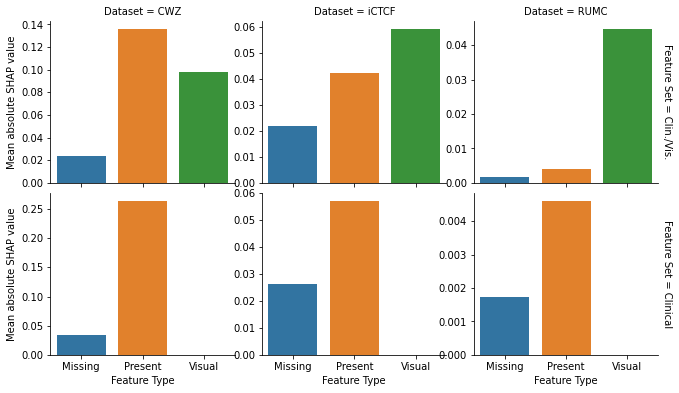

In [263]:
g = sns.catplot(data=pd.DataFrame(results), margin_titles=True, x='Feature Type', y='Mean absolute SHAP value', col='Dataset', row='Feature Set', kind='bar', sharey=False)
g.fig.set_size_inches(9, 5)

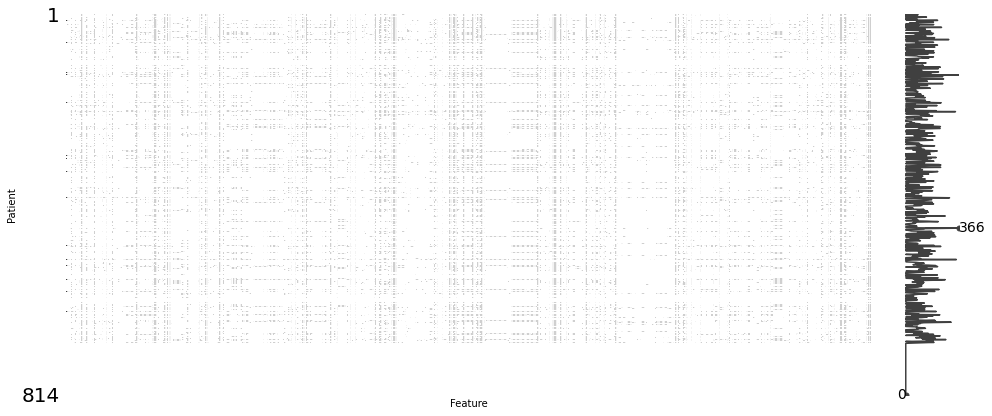

In [182]:
import missingno
missingno.matrix(pd.read_pickle('../data/processed/rumc.pkl').Input.Clinical.dropna(axis='columns', thresh=8), figsize=(16, 7))
plt.ylabel('Patient')
plt.xlabel('Feature')
plt.savefig('results/rumc_missingness.svg')

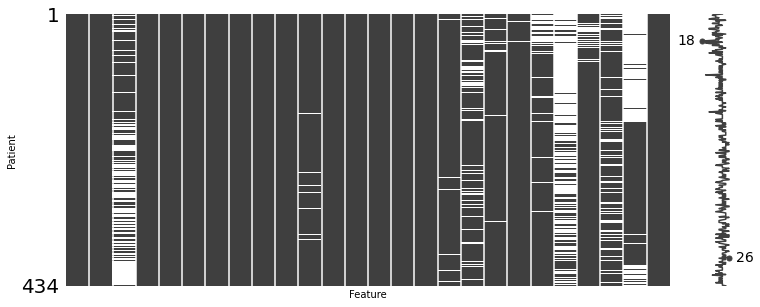

In [184]:
import missingno
missingno.matrix(pd.read_pickle('../data/processed/cwz.pkl').Input.Clinical.dropna(axis='columns', thresh=1), figsize=(12, 5), labels=False)
plt.ylabel('Patient')
plt.xlabel('Feature')
plt.savefig('results/cwz_missingness.svg')

In [354]:
from sklearn.model_selection import train_test_split
X_test_corr = np.random.rand(3000, 6)
x_orig = X_test_corr[:, 0]
X_test_corr[:, 1] = x_orig+np.random.randn(3000)*0.1
X_test_corr[:, 0] = x_orig+np.random.randn(3000)*0.1
X_test_corr[:, 2] = 0
y_test_corr = x_orig > 0.5

# X_test_corr_train, X_test_corr_test, y_test_corr_train, y_test_corr_test = train_test_split(X_test_corr, y_test_corr, shuffle=True, stratify=y_test_corr, test_size=0.2)
X_test_corr_train, X_test_corr_test, y_test_corr_train, y_test_corr_test = X_test_corr[:1000], X_test_corr[1000:2000], y_test_corr[:1000], y_test_corr[1000:2000]

clf_test_corr = LGBMClassifier(n_jobs=-1).fit(X_test_corr_train, y_test_corr_train)

In [369]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + str(X.iloc[:, variables].columns[maxloc]) +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [370]:
from sklearn.impute import SimpleImputer
df_temp = df.Input.Clinical.copy()
for col in df_temp:
    try:
        df_temp[col] = df_temp[col].astype(np.float)
    except:
        df_temp[col] = df_temp[col].astype('category').cat.codes

calculate_vif_(pd.DataFrame(SimpleImputer().fit_transform(df_temp), columns=df_temp.columns))

invalid value encountered in double_scalars


dropping 'Value_RF' at index: 99
dropping 'Value_NEP' at index: 82
dropping 'Value_BYST' at index: 19
dropping 'Value_MCH' at index: 72
dropping 'Value_WBCC' at index: 115
dropping 'Value_LPS' at index: 69
dropping 'Metadata_Temperature' at index: 116
dropping 'Value_HYAL' at index: 52


KeyboardInterrupt: 

In [355]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_corr, X_test_corr[:, 1] > 0.5)

0.8866666666666667

In [383]:
df_union = df[(df.Meta.hospital == 'Union') & (df.Target.Metadata_Morbidity != 'Suspected')]
df_liyuan = df[(df.Meta.hospital == 'Liyuan') & (df.Target.Metadata_Morbidity != 'Suspected')]
LGBMClassifier(n_jobs=-1).fit(*preprocess(df_union.Input.Clinical, df_union.Target.pcr)).score(*preprocess(df_liyuan.Input.Clinical, df_liyuan.Target.pcr))

0.5984848484848485

In [388]:
from sklearn.model_selection import cross_val_score
cross_val_score(LGBMClassifier(n_jobs=-1), *preprocess(df_union.Input.Clinical, df_union.Target.pcr), cv=StratifiedKFold(10, shuffle=True), scoring='roc_auc').mean()

0.969199298245614

In [356]:
clf_test_corr.score(X_test_corr, y_test_corr)

0.997

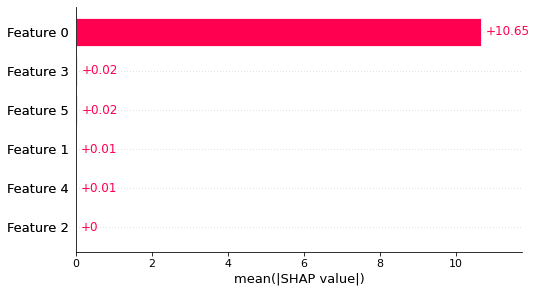

In [357]:
shap.plots.bar(shap.TreeExplainer(clf_test_corr, data=X_test_corr[2000:])(X_test_corr_test))#.values[:, :, 1].sum(axis=0)

In [ ]:
severity_dist_ictcf.pdf

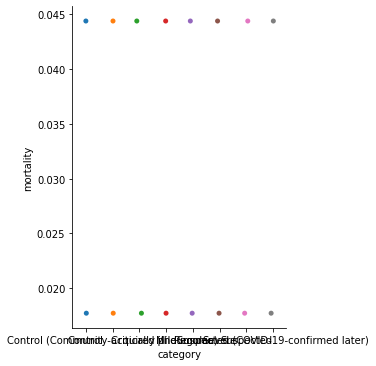

In [418]:
sns.catplot(data=severities, x='category', y='mortality')

In [439]:
data = pd.DataFrame({
    'mortality': df.Target.Metadata_Mortality == 'Deceased', 
    'morbidity': df.Target.Metadata_Morbidity, 
    'hospital': df.Meta.hospital
})
data['index'] = data.index

In [429]:
data = pd.wide_to_long(data, stubnames=['value'], sep='_', suffix='.+', j='Val', i='index')

<AxesSubplot:xlabel='hospital', ylabel='mortality'>

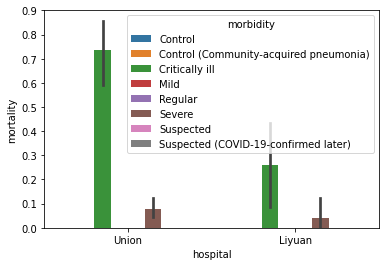

In [446]:
sns.barplot(data=data[data.morbidity.isin(['Severe', 'Critically ill'])], x='hospital', y='mortality', hue='morbidity')

In [445]:
data[data.morbidity.isin(['Severe', 'Critically ill'])]

mortality morbidity hospital  index
3         False    Severe    Union      3
4         False    Severe    Union      4
5         False    Severe    Union      5
9         False    Severe    Union      9
12        False    Severe    Union     12
...         ...       ...      ...    ...
1401      False    Severe    Union   1401
1405      False    Severe    Union   1405
1407      False    Severe    Union   1407
1408      False    Severe    Union   1408
1515      False    Severe    Union   1515

[274 rows x 4 columns]

In [481]:
df[df.Meta.cohort == 'c1'].Input.Visual.isna().any(axis=1).sum()

428

In [484]:
rumc = pd.read_pickle('../data/processed/rumc.pkl')

In [485]:
(~rumc[rumc.Meta.part == 'test'].Target.pcr.isna()).sum()

24

In [478]:
rumc = pd.read_csv('../data/raw/covid_ct_CF_anon_with_date_shifts.csv')

In [479]:
rumc[rumc.labresultscommonname.str.lower().str.contains(
        'cov') & rumc.labresultscommonname.str.lower().str.contains('pcr')].labresultscommonname.unique()

array(['PCR CORONAVIRUS NCOV-19 (FECES)',
       'PCR CORONAVIRUS NCOV19 (UITSTRIJK)',
       'PCR CORONAVIRUS NCOV-19 (UITSTRIJK)',
       'PCR CORONAVIRUS TYPE NCOV-19 (SPUTUM)',
       'PCR CORONAVIRUS TYPE NCOV-19 (LIQUOR)',
       'PCR CORONAVIRUS TYPE NCOV-19 (OVERIG)',
       'PCR CORONAVIRUS TYPE NCOV-19 (WEEFSEL)',
       'PCR CORONAVIRUS NCOV19 (OVERIG)',
       'PCR CORONAVIRUS NCOV19 (SPUTUM)',
       'PCR CORONAVIRUS TYPE NCOV-19 (SPOELING)'], dtype=object)

In [480]:
rumc[rumc.labresultscommonname.str.lower().str.contains(
        'cov') & ~rumc.labresultscommonname.str.lower().str.contains('biomarker')].labresultscommonname.unique()

array(['PCR CORONAVIRUS NCOV-19 (FECES)',
       'PCR CORONAVIRUS NCOV19 (UITSTRIJK)',
       'PCR CORONAVIRUS NCOV-19 (UITSTRIJK)',
       'PCR CORONAVIRUS TYPE NCOV-19 (SPUTUM)', 'SARS-COV-2 IGG',
       'SARS-COV-2 IG TOTAAL', 'PCR CORONAVIRUS TYPE NCOV-19 (LIQUOR)',
       'PCR CORONAVIRUS TYPE NCOV-19 (OVERIG)',
       'PCR CORONAVIRUS TYPE NCOV-19 (WEEFSEL)',
       'PCR CORONAVIRUS NCOV19 (OVERIG)',
       'PCR CORONAVIRUS NCOV19 (SPUTUM)',
       'PCR CORONAVIRUS TYPE NCOV-19 (SPOELING)'], dtype=object)